In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import quandl
from datetime import datetime
import requests
import time
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD,Adam
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint



import pygad
import pygad.kerasga


In [2]:
FUTURE = 5
ROLLING = 5
ROLLING1 = 10
ROLLING2 = 15

In [3]:
#List of features

start = datetime(2005, 1,1)
end = datetime(2022,12,1)


inputs = [ 'NASDAQCOM', 
          'DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSAL', 'VIXCLS', 
          'DCOILWTICO']
fred_df = pd.DataFrame()

for i, name in enumerate(inputs):
    print(f'Series:{name}')
    if i == 0:
        fred_df = web.get_data_fred(name, start, end)
    else:
        _df = web.get_data_fred(name, start, end)
        fred_df = fred_df.join(_df, how = 'outer')

        


Series:NASDAQCOM
Series:DEXJPUS
Series:DEXUSEU
Series:DEXCHUS
Series:DEXUSAL
Series:VIXCLS
Series:DCOILWTICO


In [4]:
#Gold_NIFTY_Russell

gold = quandl.get("LBMA/GOLD", authtoken="kUWytaDzbhXbCX7PDzvg")
gold.index.name = 'DATE'
gold = gold[['USD (AM)']]
gold = gold.reset_index()

starttime = int(time.mktime(datetime(2005, 1,1).timetuple()))
endtime = int(time.mktime(datetime(2022, 12,1).timetuple()))
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/^NSEI?period1={starttime}&period2={endtime}&interval=1d&events=history&includeAdjustedClose=true'
nifty = pd.read_csv(query_string)
nifty = nifty[['Date','Close' ]]
nifty.columns = ['DATE','NIFTY50' ]
nifty['DATE'] = pd.to_datetime(nifty['DATE'])

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/^RUT?period1={starttime}&period2={endtime}&interval=1d&events=history&includeAdjustedClose=true'
russell = pd.read_csv(query_string)
russell = russell[['Date','Close' ]]
russell.columns = ['DATE','RUSSL' ]
russell['DATE'] = pd.to_datetime(russell['DATE'])

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/^GSPC?period1={starttime}&period2={endtime}&interval=1d&events=history&includeAdjustedClose=true'
snp500 = pd.read_csv(query_string)
snp500 = snp500[['Date','Close' ]]
snp500.columns = ['DATE','SNP500' ]
snp500['DATE'] = pd.to_datetime(snp500['DATE'])


fred_df = fred_df.reset_index()



In [5]:
fred_df = pd.merge(pd.merge(fred_df, gold, on = 'DATE'), nifty, on = 'DATE')

fred_df = pd.merge(fred_df, snp500, on = 'DATE')

In [6]:
fred_df.isna().sum()

DATE           0
NASDAQCOM      0
DEXJPUS       39
DEXUSEU       39
DEXCHUS       39
DEXUSAL       39
VIXCLS         0
DCOILWTICO     7
USD (AM)       0
NIFTY50       10
SNP500         0
dtype: int64

In [7]:
fred_df['MONTH'] = fred_df['DATE'].dt.month
fred_df['DAY'] = fred_df['DATE'].dt.day

In [8]:
fred_df.columns = ['DATE', 'NASDAQCOM', 'DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSAL',
       'VIXCLS', 'DCOILWTICO', 'GOLD', 'NIFTY50', 'SNP500', 'MONTH',
       'DAY']

cols = ['NASDAQCOM', 'DEXJPUS', 'DEXUSEU', 'DEXCHUS', 'DEXUSAL',
       'VIXCLS', 'GOLD', 'NIFTY50', 'SNP500', 'DCOILWTICO']

fred_df.dropna(inplace = True)

for i in cols:
    col_name_roll = f'{i}_rolling_5'
    col_name_roll1 = f'{i}_rolling_10'
    col_name_roll2 = f'{i}_rolling_15'
    fred_df[col_name_roll] = fred_df[i].rolling(window = ROLLING).mean()
    fred_df[col_name_roll1] = fred_df[i].rolling(window = ROLLING1).mean()
    fred_df[col_name_roll2] = fred_df[i].rolling(window = ROLLING2).mean()
    
months = pd.get_dummies(fred_df['MONTH'], drop_first=True)
months.columns = ['FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

day = pd.get_dummies(fred_df['DAY'], drop_first=True)

fred_df = pd.concat([fred_df, months, day], axis = 1)

In [9]:
#Before COVID
fred_df = fred_df[fred_df['DATE'] <= datetime(2020,3,1)]

In [10]:
fred_df['OIL_PRICE_FUTURE'] = fred_df['DCOILWTICO'].shift(-FUTURE)

In [11]:
del fred_df['DAY']
del fred_df['MONTH']

In [12]:
cols = ['NASDAQCOM',
                     'DEXJPUS',               'DEXUSEU',
                     'DEXCHUS',               'DEXUSAL',
                      'VIXCLS',            'DCOILWTICO',
                        'GOLD',               'NIFTY50',
                      'SNP500',   'NASDAQCOM_rolling_5',
        'NASDAQCOM_rolling_10',  'NASDAQCOM_rolling_15',
           'DEXJPUS_rolling_5',    'DEXJPUS_rolling_10',
          'DEXJPUS_rolling_15',     'DEXUSEU_rolling_5',
          'DEXUSEU_rolling_10',    'DEXUSEU_rolling_15',
           'DEXCHUS_rolling_5',    'DEXCHUS_rolling_10',
          'DEXCHUS_rolling_15',     'DEXUSAL_rolling_5',
          'DEXUSAL_rolling_10',    'DEXUSAL_rolling_15',
            'VIXCLS_rolling_5',     'VIXCLS_rolling_10',
           'VIXCLS_rolling_15',        'GOLD_rolling_5',
             'GOLD_rolling_10',       'GOLD_rolling_15',
           'NIFTY50_rolling_5',    'NIFTY50_rolling_10',
          'NIFTY50_rolling_15',      'SNP500_rolling_5',
           'SNP500_rolling_10',     'SNP500_rolling_15',
        'DCOILWTICO_rolling_5', 'DCOILWTICO_rolling_10',
       'DCOILWTICO_rolling_15']

In [13]:
minmaxscaler = MinMaxScaler()

fred_df[cols] = minmaxscaler.fit_transform(fred_df.loc[:, fred_df.columns.isin(cols)])

fred_df.dropna(inplace = True)

In [14]:
date_arr = fred_df['DATE']

In [15]:
fred_df.drop(columns='DATE', inplace = True)
fred_df = fred_df.reset_index()
del fred_df['index']

In [16]:
thres_hold = int(-0.10*(fred_df.shape[0]))

training_dataset = fred_df.iloc[:thres_hold, :]
test_dataset = fred_df.iloc[thres_hold:, :]

In [17]:
y_train = np.array(training_dataset['OIL_PRICE_FUTURE'].values)
y_test = np.array(test_dataset['OIL_PRICE_FUTURE'].values)

X_train = training_dataset.loc[:, training_dataset.columns != 'OIL_PRICE_FUTURE']
X_test = test_dataset.loc[:, test_dataset.columns != 'OIL_PRICE_FUTURE']

X_train_arr = np.array(X_train)
X_test_arr = np.array(X_test)

In [18]:
data_outputs = np.array(fred_df['OIL_PRICE_FUTURE'])
data_inputs = fred_df
del data_inputs['OIL_PRICE_FUTURE']

In [19]:
data_inputs = np.array(data_inputs)

In [20]:
#GA Implementation

In [21]:
num_samples = X_train.shape[0]
num_feature_elements = X_train.shape[1]
train_indices = np.arange(0, 2577, 1)
test_indices = np.arange(2577, 2863, 1)

In [22]:
sol_per_pop = 5
num_parents_mating = 4
num_mutations = 3

#Population Shape
pop_shape = (sol_per_pop, num_feature_elements)

#Initial Population
new_population = np.random.randint(low = 0, high = 2, size = pop_shape)
print(new_population.shape)

best_outputs = []
num_generations = 50


(5, 81)


In [23]:
pop_shape = (sol_per_pop, num_feature_elements)

In [24]:
def reduce_features(solution, features):
    
    selected_elements_indices = numpy.where(solution == 1)[0]
    reduced_features = features[:, selected_elements_indices]
    return reduced_features

def fitness_func(labels, predictions):
    mse = tf.keras.losses.MeanSquaredError()
    fitness = 1/(mse(labels, predictions).numpy() + 0.00001)
    return fitness

def cal_pop_fitness(pop, features, labels, train_indices, test_indices):
    accuracies = np.zeros(pop.shape[0])
    idx = 0
    for curr_solution in pop:
        reduced_features = reduce_features(curr_solution, features)
        train_data = reduced_features[train_indices, :]
        test_data = reduced_features[test_indices, :]
        train_labels = labels[train_indices]
        test_labels = labels[test_indices]
        print(test_data)
        print(train_data.shape)
        print(test_data.shape)
        model_nn = Sequential()
        model_nn.add(Dense(128, activation = 'sigmoid',input_shape = (train_data.shape[1],)))
        model_nn.add(Dropout(0.2))
        model_nn.add(BatchNormalization())
        model_nn.add(Dense(128, activation = 'relu'))
        model_nn.add(Dense(128, activation = 'relu'))
        model_nn.add(Dense(1, activation='relu'))
        opt = Adam()
        model_nn.compile(optimizer=opt,  loss='mean_squared_error', metrics='mean_squared_error')
        history_nn = model_nn.fit(train_data, train_labels, epochs = 25, validation_data = [test_data, test_labels])
        predictions = model_nn.predict(test_data)
        accuracies[idx] = fitness_func(test_labels, predictions)
        idx = idx + 1
    return accuracies

def select_mating_pool(pop, fitness, num_parents):
    parents = numpy.empty((num_parents, pop_shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return parents

def crossover(parents, offspring_size):
    offspring = numpy.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually, it is at the center.
    crossover_point = numpy.uint8(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring


def mutation(offspring_crossover, num_mutations = 2):
    mutation_idx = np.random.randint(low = 0, high = offspring_crossover.shape[1], size = num_mutations)
    for idx in range(offspring_crossover.shape[0]):
        offspring_crossover[idx, mutation_idx] = 1 - offspring_crossover[idx, mutation_idx]
    return offspring_crossover
        

    
        

In [273]:
for generation in range(num_generations):
    print("Generation: ", generation)
    fitness = cal_pop_fitness(new_population, data_inputs, data_outputs, train_indices, test_indices)
    best_outputs.append(np.max(fitness))
    print("Best Result: ", best_outputs[-1])

    parents = select_mating_pool(new_population, fitness, num_parents_mating)
    offspring_crossover = crossover(parents, offspring_size= (pop_shape[0]-parents.shape[0], num_feature_elements))
    offspring_mutation = mutation(offspring_crossover, num_mutations= num_mutations)
    
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation


fitness = cal_pop_fitness(new_population, data_inputs, data_outputs, train_indices, test_indices)
# Then return the index of that solution corresponding to the best fitness.
best_match_idx = numpy.where(fitness == numpy.max(fitness))[0]
best_match_idx = best_match_idx[0]

best_solution = new_population[best_match_idx, :]
best_solution_indices = numpy.where(best_solution == 1)[0]
best_solution_num_elements = best_solution_indices.shape[0]
best_solution_fitness = fitness[best_match_idx]

print("best_match_idx : ", best_match_idx)
print("best_solution : ", best_solution)
print("Selected indices : ", best_solution_indices)
print("Number of selected elements : ", best_solution_num_elements)
print("Best solution fitness : ", best_solution_fitness)
    
    

Generation:  0
[[0.6994447  0.18225377 0.25015142 ... 0.         0.         0.        ]
 [0.6737802  0.19041704 0.24591157 ... 0.         0.         0.        ]
 [0.65978331 0.18030169 0.23682617 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07808341 0.12517666 ... 0.         0.         0.        ]
 [1.         0.0743567  0.1211387  ... 0.         0.         0.        ]
 [0.99225423 0.07488909 0.11003432 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:08:06.783855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2390.3926 - mean_squared_error: 2390.3926

2022-12-09 11:08:12.007689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 58ms/step - loss: 2390.3926 - mean_squared_error: 2390.3926 - val_loss: 818.6481 - val_mean_squared_error: 818.6481
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 121.0158 - mean_squared_error: 121.0158 - val_loss: 1439.9713 - val_mean_squared_error: 1439.9713
Epoch 3/25
81/81 [==============================] - 1s 14ms/step - loss: 90.5931 - mean_squared_error: 90.5931 - val_loss: 2317.9133 - val_mean_squared_error: 2317.9133
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 81.2363 - mean_squared_error: 81.2363 - val_loss: 2625.4529 - val_mean_squared_error: 2625.4529
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 68.6132 - mean_squared_error: 68.6132 - val_loss: 2683.2451 - val_mean_squared_error: 2683.2451
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 56.2447 - mean_squared_error: 56.2447 - val_loss: 2638.3518 - val_mean_squared_error: 263

2022-12-09 11:08:30.723773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.82922519 0.76015828 ... 0.         0.         0.        ]
 [0.6737802  0.83747884 0.74335148 ... 0.         0.         0.        ]
 [0.65978331 0.82658241 0.72532678 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.96241146 0.99414683 ... 0.         0.         0.        ]
 [1.         0.97597103 1.         ... 0.         0.         0.        ]
 [0.99225423 0.97139181 0.99523183 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:08:31.365523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2386.3457 - mean_squared_error: 2386.3457

2022-12-09 11:08:36.346311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 56ms/step - loss: 2386.3457 - mean_squared_error: 2386.3457 - val_loss: 1151.9568 - val_mean_squared_error: 1151.9567
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 123.4793 - mean_squared_error: 123.4793 - val_loss: 1180.5648 - val_mean_squared_error: 1180.5648
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 59.7515 - mean_squared_error: 59.7515 - val_loss: 1764.1471 - val_mean_squared_error: 1764.1471
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 58.6754 - mean_squared_error: 58.6754 - val_loss: 2091.8035 - val_mean_squared_error: 2091.8035
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 51.0836 - mean_squared_error: 51.0836 - val_loss: 2362.6892 - val_mean_squared_error: 2362.6892
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 43.4719 - mean_squared_error: 43.4719 - val_loss: 2372.5881 - val_mean_squared_error: 237

2022-12-09 11:08:54.397529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.60500742 0.12548801 ... 0.         0.         0.        ]
 [0.6737802  0.60709947 0.15281651 ... 0.         0.         0.        ]
 [0.65978331 0.61047375 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.64428398 0.07933631 ... 0.         0.         0.        ]
 [1.         0.6460386  0.07306191 ... 0.         0.         0.        ]
 [0.99225423 0.66290997 0.08951478 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 11:08:54.924723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2374.4695 - mean_squared_error: 2374.4695

2022-12-09 11:08:59.774855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 53ms/step - loss: 2374.4695 - mean_squared_error: 2374.4695 - val_loss: 870.7256 - val_mean_squared_error: 870.7256
Epoch 2/25
81/81 [==============================] - 1s 15ms/step - loss: 114.4514 - mean_squared_error: 114.4514 - val_loss: 1107.4528 - val_mean_squared_error: 1107.4528
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 48.5208 - mean_squared_error: 48.5208 - val_loss: 1506.1099 - val_mean_squared_error: 1506.1099
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 49.7129 - mean_squared_error: 49.7129 - val_loss: 2060.6860 - val_mean_squared_error: 2060.6860
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 41.6213 - mean_squared_error: 41.6213 - val_loss: 2411.2490 - val_mean_squared_error: 2411.2490
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 41.2894 - mean_squared_error: 41.2894 - val_loss: 2385.7178 - val_mean_squared_error: 238

2022-12-09 11:09:18.312472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 40)
(286, 40)
Epoch 1/25


2022-12-09 11:09:18.894817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2352.2937 - mean_squared_error: 2352.2937

2022-12-09 11:09:23.863555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 55ms/step - loss: 2352.2937 - mean_squared_error: 2352.2937 - val_loss: 895.2610 - val_mean_squared_error: 895.2610
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 130.3858 - mean_squared_error: 130.3858 - val_loss: 1125.9702 - val_mean_squared_error: 1125.9702
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 88.6739 - mean_squared_error: 88.6739 - val_loss: 2409.4209 - val_mean_squared_error: 2409.4209
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 76.4834 - mean_squared_error: 76.4834 - val_loss: 2837.9219 - val_mean_squared_error: 2837.9219
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 58.4611 - mean_squared_error: 58.4611 - val_loss: 2888.7485 - val_mean_squared_error: 2888.7485
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 50.1532 - mean_squared_error: 50.1532 - val_loss: 2867.9534 - val_mean_squared_error: 2867.

2022-12-09 11:09:42.200280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:09:42.808213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2367.2717 - mean_squared_error: 2367.2717

2022-12-09 11:09:47.981723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2367.2717 - mean_squared_error: 2367.2717 - val_loss: 666.7333 - val_mean_squared_error: 666.7333
Epoch 2/25
81/81 [==============================] - 1s 10ms/step - loss: 147.7747 - mean_squared_error: 147.7747 - val_loss: 1141.0275 - val_mean_squared_error: 1141.0275
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 86.4557 - mean_squared_error: 86.4557 - val_loss: 2021.2965 - val_mean_squared_error: 2021.2965
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 73.9679 - mean_squared_error: 73.9679 - val_loss: 2523.3728 - val_mean_squared_error: 2523.3728
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 62.8831 - mean_squared_error: 62.8831 - val_loss: 2626.6841 - val_mean_squared_error: 2626.6841
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 58.9460 - mean_squared_error: 58.9460 - val_loss: 2679.1431 - val_mean_squared_error: 2679.

2022-12-09 11:10:06.000186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0005865677104747284
Generation:  1
[[0.6994447  0.82922519 0.76015828 ... 0.         0.         0.        ]
 [0.6737802  0.83747884 0.74335148 ... 0.         0.         0.        ]
 [0.65978331 0.82658241 0.72532678 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.96241146 0.99414683 ... 0.         0.         0.        ]
 [1.         0.97597103 1.         ... 0.         0.         0.        ]
 [0.99225423 0.97139181 0.99523183 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:10:06.658272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2380.9314 - mean_squared_error: 2380.9314

2022-12-09 11:10:11.696957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 55ms/step - loss: 2380.9314 - mean_squared_error: 2380.9314 - val_loss: 1041.1071 - val_mean_squared_error: 1041.1071
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 114.8751 - mean_squared_error: 114.8751 - val_loss: 974.5891 - val_mean_squared_error: 974.5891
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 58.5545 - mean_squared_error: 58.5545 - val_loss: 1736.0028 - val_mean_squared_error: 1736.0028
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 55.7597 - mean_squared_error: 55.7597 - val_loss: 2255.8254 - val_mean_squared_error: 2255.8254
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 49.7018 - mean_squared_error: 49.7018 - val_loss: 2193.3098 - val_mean_squared_error: 2193.3098
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 50.7390 - mean_squared_error: 50.7390 - val_loss: 2258.8357 - val_mean_squared_error: 2258

2022-12-09 11:10:29.890302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.18225377 0.25015142 ... 0.         0.         0.        ]
 [0.6737802  0.19041704 0.24591157 ... 0.         0.         0.        ]
 [0.65978331 0.18030169 0.23682617 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07808341 0.12517666 ... 0.         0.         0.        ]
 [1.         0.0743567  0.1211387  ... 0.         0.         0.        ]
 [0.99225423 0.07488909 0.11003432 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:10:30.471761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2434.5701 - mean_squared_error: 2434.5701

2022-12-09 11:10:35.536333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 56ms/step - loss: 2434.5701 - mean_squared_error: 2434.5701 - val_loss: 775.6671 - val_mean_squared_error: 775.6671
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 128.2079 - mean_squared_error: 128.2079 - val_loss: 1584.9636 - val_mean_squared_error: 1584.9636
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 89.1844 - mean_squared_error: 89.1844 - val_loss: 2465.3540 - val_mean_squared_error: 2465.3540
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 73.3203 - mean_squared_error: 73.3203 - val_loss: 2822.4282 - val_mean_squared_error: 2822.4282
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 61.4514 - mean_squared_error: 61.4514 - val_loss: 2903.8381 - val_mean_squared_error: 2903.8381
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 58.1040 - mean_squared_error: 58.1040 - val_loss: 2909.0256 - val_mean_squared_error: 2909

2022-12-09 11:10:53.697996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:10:54.327748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2364.4360 - mean_squared_error: 2364.4360

2022-12-09 11:10:59.434212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 56ms/step - loss: 2364.4360 - mean_squared_error: 2364.4360 - val_loss: 1050.7894 - val_mean_squared_error: 1050.7894
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 133.5688 - mean_squared_error: 133.5688 - val_loss: 1461.3383 - val_mean_squared_error: 1461.3383
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 93.5018 - mean_squared_error: 93.5018 - val_loss: 2197.8833 - val_mean_squared_error: 2197.8833
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 75.0599 - mean_squared_error: 75.0599 - val_loss: 2628.6458 - val_mean_squared_error: 2628.6458
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 66.3823 - mean_squared_error: 66.3823 - val_loss: 2755.6836 - val_mean_squared_error: 2755.6836
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 53.8052 - mean_squared_error: 53.8052 - val_loss: 2736.1201 - val_mean_squared_error: 2

2022-12-09 11:11:17.501213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 40)
(286, 40)
Epoch 1/25


2022-12-09 11:11:18.095659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2406.6960 - mean_squared_error: 2406.6960

2022-12-09 11:11:23.192651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 56ms/step - loss: 2406.6960 - mean_squared_error: 2406.6960 - val_loss: 814.7336 - val_mean_squared_error: 814.7336
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 120.7544 - mean_squared_error: 120.7544 - val_loss: 1263.1388 - val_mean_squared_error: 1263.1388
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 85.7127 - mean_squared_error: 85.7127 - val_loss: 2350.4365 - val_mean_squared_error: 2350.4365
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 72.7513 - mean_squared_error: 72.7513 - val_loss: 2850.9265 - val_mean_squared_error: 2850.9265
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 65.6437 - mean_squared_error: 65.6437 - val_loss: 2956.2388 - val_mean_squared_error: 2956.2388
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 53.9745 - mean_squared_error: 53.9745 - val_loss: 2973.3853 - val_mean_squared_error: 297

2022-12-09 11:11:41.502627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.82922519 0.76015828 ... 0.         0.         0.        ]
 [0.6737802  0.83747884 0.74335148 ... 0.         0.         0.        ]
 [0.65978331 0.82658241 0.72532678 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.96241146 0.99414683 ... 0.         0.         0.        ]
 [1.         0.97597103 1.         ... 0.         0.         0.        ]
 [0.99225423 0.97139181 0.99523183 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 11:11:42.196053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2408.9014 - mean_squared_error: 2408.9014

2022-12-09 11:11:47.428063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2408.9014 - mean_squared_error: 2408.9014 - val_loss: 734.6398 - val_mean_squared_error: 734.6398
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 108.7829 - mean_squared_error: 108.7829 - val_loss: 880.1025 - val_mean_squared_error: 880.1025
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 60.0606 - mean_squared_error: 60.0606 - val_loss: 1668.3328 - val_mean_squared_error: 1668.3328
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 58.3935 - mean_squared_error: 58.3935 - val_loss: 2242.4028 - val_mean_squared_error: 2242.4028
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 56.1085 - mean_squared_error: 56.1085 - val_loss: 2400.1611 - val_mean_squared_error: 2400.1611
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 50.1487 - mean_squared_error: 50.1487 - val_loss: 2488.8843 - val_mean_squared_error: 2488.8

2022-12-09 11:12:08.568776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0005756218221413624
Generation:  2
[[0.6994447  0.82922519 0.76015828 ... 0.         0.         0.        ]
 [0.6737802  0.83747884 0.74335148 ... 0.         0.         0.        ]
 [0.65978331 0.82658241 0.72532678 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.96241146 0.99414683 ... 0.         0.         0.        ]
 [1.         0.97597103 1.         ... 0.         0.         0.        ]
 [0.99225423 0.97139181 0.99523183 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:12:09.268758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2429.1543 - mean_squared_error: 2429.1543

2022-12-09 11:12:13.996729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 52ms/step - loss: 2429.1543 - mean_squared_error: 2429.1543 - val_loss: 1098.0887 - val_mean_squared_error: 1098.0887
Epoch 2/25
81/81 [==============================] - 1s 15ms/step - loss: 125.6808 - mean_squared_error: 125.6808 - val_loss: 1130.7137 - val_mean_squared_error: 1130.7137
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 60.5545 - mean_squared_error: 60.5545 - val_loss: 1743.0079 - val_mean_squared_error: 1743.0079
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 50.7182 - mean_squared_error: 50.7182 - val_loss: 2355.0974 - val_mean_squared_error: 2355.0974
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 49.8547 - mean_squared_error: 49.8547 - val_loss: 2361.7568 - val_mean_squared_error: 2361.7568
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 54.6651 - mean_squared_error: 54.6651 - val_loss: 2389.8723 - val_mean_squared_error: 23

2022-12-09 11:12:32.791460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.82922519 0.76015828 ... 0.         0.         0.        ]
 [0.6737802  0.83747884 0.74335148 ... 0.         0.         0.        ]
 [0.65978331 0.82658241 0.72532678 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.96241146 0.99414683 ... 0.         0.         0.        ]
 [1.         0.97597103 1.         ... 0.         0.         0.        ]
 [0.99225423 0.97139181 0.99523183 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 11:12:33.415329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2399.3269 - mean_squared_error: 2399.3269

2022-12-09 11:12:38.344471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 55ms/step - loss: 2399.3269 - mean_squared_error: 2399.3269 - val_loss: 818.3428 - val_mean_squared_error: 818.3428
Epoch 2/25
81/81 [==============================] - 1s 10ms/step - loss: 106.3580 - mean_squared_error: 106.3580 - val_loss: 1030.0232 - val_mean_squared_error: 1030.0232
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 54.4490 - mean_squared_error: 54.4490 - val_loss: 1966.8496 - val_mean_squared_error: 1966.8496
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 53.0827 - mean_squared_error: 53.0827 - val_loss: 2541.9153 - val_mean_squared_error: 2541.9153
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 54.4557 - mean_squared_error: 54.4557 - val_loss: 2657.9021 - val_mean_squared_error: 2657.9021
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 46.5519 - mean_squared_error: 46.5519 - val_loss: 2643.2395 - val_mean_squared_error: 264

2022-12-09 11:12:56.542019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:12:57.072824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2408.0669 - mean_squared_error: 2408.0669

2022-12-09 11:13:01.981329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 54ms/step - loss: 2408.0669 - mean_squared_error: 2408.0669 - val_loss: 1226.8386 - val_mean_squared_error: 1226.8386
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 123.8645 - mean_squared_error: 123.8645 - val_loss: 1295.6671 - val_mean_squared_error: 1295.6671
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 81.8001 - mean_squared_error: 81.8001 - val_loss: 2149.6375 - val_mean_squared_error: 2149.6375
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 73.3219 - mean_squared_error: 73.3219 - val_loss: 2552.9229 - val_mean_squared_error: 2552.9229
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 58.8421 - mean_squared_error: 58.8421 - val_loss: 2514.8137 - val_mean_squared_error: 2514.8137
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 54.7737 - mean_squared_error: 54.7737 - val_loss: 2599.2737 - val_mean_squared_error: 25

2022-12-09 11:13:20.097367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 40)
(286, 40)
Epoch 1/25


2022-12-09 11:13:20.651519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2406.5146 - mean_squared_error: 2406.5146

2022-12-09 11:13:25.741580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2406.5146 - mean_squared_error: 2406.5146 - val_loss: 1067.4407 - val_mean_squared_error: 1067.4407
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 118.0770 - mean_squared_error: 118.0770 - val_loss: 1055.3593 - val_mean_squared_error: 1055.3593
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 89.4592 - mean_squared_error: 89.4592 - val_loss: 2171.5979 - val_mean_squared_error: 2171.5979
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 84.9102 - mean_squared_error: 84.9102 - val_loss: 2752.6216 - val_mean_squared_error: 2752.6213
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 72.1123 - mean_squared_error: 72.1123 - val_loss: 2874.4971 - val_mean_squared_error: 2874.4968
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 58.2282 - mean_squared_error: 58.2282 - val_loss: 2938.1624 - val_mean_squared_error: 29

2022-12-09 11:13:44.127190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:13:44.730969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2383.3760 - mean_squared_error: 2383.3760

2022-12-09 11:13:49.822718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2383.3760 - mean_squared_error: 2383.3760 - val_loss: 1092.7125 - val_mean_squared_error: 1092.7125
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 109.7811 - mean_squared_error: 109.7811 - val_loss: 1239.5483 - val_mean_squared_error: 1239.5483
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 56.7272 - mean_squared_error: 56.7272 - val_loss: 1879.6350 - val_mean_squared_error: 1879.6350
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 50.1312 - mean_squared_error: 50.1312 - val_loss: 2543.5996 - val_mean_squared_error: 2543.5996
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 54.4588 - mean_squared_error: 54.4588 - val_loss: 2529.5986 - val_mean_squared_error: 2529.5986
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 43.2890 - mean_squared_error: 43.2890 - val_loss: 2470.5496 - val_mean_squared_error: 247

2022-12-09 11:14:07.991239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0005764704325819192
Generation:  3
[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:14:08.567057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2408.3335 - mean_squared_error: 2408.3335

2022-12-09 11:14:13.664063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 55ms/step - loss: 2408.3335 - mean_squared_error: 2408.3335 - val_loss: 1096.5430 - val_mean_squared_error: 1096.5428
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 147.3911 - mean_squared_error: 147.3911 - val_loss: 1248.6062 - val_mean_squared_error: 1248.6062
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 85.5654 - mean_squared_error: 85.5654 - val_loss: 1837.2019 - val_mean_squared_error: 1837.2019
Epoch 4/25
81/81 [==============================] - 1s 8ms/step - loss: 79.5438 - mean_squared_error: 79.5438 - val_loss: 2408.0547 - val_mean_squared_error: 2408.0547
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 65.7210 - mean_squared_error: 65.7210 - val_loss: 2479.3633 - val_mean_squared_error: 2479.3633
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 59.1800 - mean_squared_error: 59.1800 - val_loss: 2507.6382 - val_mean_squared_error: 250

2022-12-09 11:14:31.961458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:14:32.561829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2416.8965 - mean_squared_error: 2416.8965

2022-12-09 11:14:37.696602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 56ms/step - loss: 2416.8965 - mean_squared_error: 2416.8965 - val_loss: 1185.7448 - val_mean_squared_error: 1185.7448
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 120.5178 - mean_squared_error: 120.5178 - val_loss: 1201.3787 - val_mean_squared_error: 1201.3787
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 59.2450 - mean_squared_error: 59.2450 - val_loss: 1801.6830 - val_mean_squared_error: 1801.6830
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 50.1860 - mean_squared_error: 50.1860 - val_loss: 2285.7502 - val_mean_squared_error: 2285.7502
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 49.6344 - mean_squared_error: 49.6344 - val_loss: 2471.3472 - val_mean_squared_error: 2471.3472
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 52.8472 - mean_squared_error: 52.8472 - val_loss: 2487.7986 - val_mean_squared_error: 24

2022-12-09 11:14:55.829514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.82922519 0.76015828 ... 0.         0.         0.        ]
 [0.6737802  0.83747884 0.74335148 ... 0.         0.         0.        ]
 [0.65978331 0.82658241 0.72532678 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.96241146 0.99414683 ... 0.         0.         0.        ]
 [1.         0.97597103 1.         ... 0.         0.         0.        ]
 [0.99225423 0.97139181 0.99523183 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:14:56.414931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2411.5090 - mean_squared_error: 2411.5090

2022-12-09 11:15:01.557433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 58ms/step - loss: 2411.5090 - mean_squared_error: 2411.5090 - val_loss: 955.0837 - val_mean_squared_error: 955.0837
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 114.2705 - mean_squared_error: 114.2705 - val_loss: 1449.4520 - val_mean_squared_error: 1449.4520
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 61.6672 - mean_squared_error: 61.6672 - val_loss: 2291.4409 - val_mean_squared_error: 2291.4409
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 59.1906 - mean_squared_error: 59.1906 - val_loss: 2754.0349 - val_mean_squared_error: 2754.0349
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 47.4178 - mean_squared_error: 47.4178 - val_loss: 2902.4104 - val_mean_squared_error: 2902.4104
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 41.5756 - mean_squared_error: 41.5756 - val_loss: 2935.3250 - val_mean_squared_error: 2935

2022-12-09 11:15:19.814431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.82922519 0.76015828 ... 0.         0.         0.        ]
 [0.6737802  0.83747884 0.74335148 ... 0.         0.         0.        ]
 [0.65978331 0.82658241 0.72532678 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.96241146 0.99414683 ... 0.         0.         0.        ]
 [1.         0.97597103 1.         ... 0.         0.         0.        ]
 [0.99225423 0.97139181 0.99523183 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 11:15:20.405722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2363.5610 - mean_squared_error: 2363.5610

2022-12-09 11:15:25.456744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 56ms/step - loss: 2363.5610 - mean_squared_error: 2363.5610 - val_loss: 606.2336 - val_mean_squared_error: 606.2336
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 98.5965 - mean_squared_error: 98.5965 - val_loss: 995.1422 - val_mean_squared_error: 995.1422
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 58.9828 - mean_squared_error: 58.9828 - val_loss: 2185.6838 - val_mean_squared_error: 2185.6838
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 55.5761 - mean_squared_error: 55.5761 - val_loss: 2720.6223 - val_mean_squared_error: 2720.6223
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 47.9086 - mean_squared_error: 47.9086 - val_loss: 2858.4038 - val_mean_squared_error: 2858.4038
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 47.3984 - mean_squared_error: 47.3984 - val_loss: 2838.0183 - val_mean_squared_error: 2838.018

2022-12-09 11:15:43.559150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:15:44.149623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2386.4729 - mean_squared_error: 2386.4729

2022-12-09 11:15:49.263637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 56ms/step - loss: 2386.4729 - mean_squared_error: 2386.4729 - val_loss: 1072.2786 - val_mean_squared_error: 1072.2786
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 112.8278 - mean_squared_error: 112.8278 - val_loss: 1190.6052 - val_mean_squared_error: 1190.6052
Epoch 3/25
81/81 [==============================] - 1s 9ms/step - loss: 67.0545 - mean_squared_error: 67.0545 - val_loss: 2102.9707 - val_mean_squared_error: 2102.9707
Epoch 4/25
81/81 [==============================] - 1s 8ms/step - loss: 60.8110 - mean_squared_error: 60.8110 - val_loss: 2686.5381 - val_mean_squared_error: 2686.5381
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 52.1156 - mean_squared_error: 52.1156 - val_loss: 2677.4985 - val_mean_squared_error: 2677.4985
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 40.9650 - mean_squared_error: 40.9650 - val_loss: 2719.1826 - val_mean_squared_error: 271

2022-12-09 11:16:07.439170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0005320156911130178
Generation:  4
[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:16:08.063370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2389.6499 - mean_squared_error: 2389.6499

2022-12-09 11:16:13.186567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 56ms/step - loss: 2389.6499 - mean_squared_error: 2389.6499 - val_loss: 1054.4341 - val_mean_squared_error: 1054.4341
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 119.6019 - mean_squared_error: 119.6019 - val_loss: 1092.8879 - val_mean_squared_error: 1092.8879
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 60.7707 - mean_squared_error: 60.7707 - val_loss: 1504.9921 - val_mean_squared_error: 1504.9921
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 52.4200 - mean_squared_error: 52.4200 - val_loss: 2396.0522 - val_mean_squared_error: 2396.0522
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 52.9394 - mean_squared_error: 52.9394 - val_loss: 2513.3125 - val_mean_squared_error: 2513.3125
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 46.1378 - mean_squared_error: 46.1378 - val_loss: 2637.3511 - val_mean_squared_error: 26

2022-12-09 11:16:31.492117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:16:32.109732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2419.9170 - mean_squared_error: 2419.9170

2022-12-09 11:16:37.254041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 56ms/step - loss: 2419.9170 - mean_squared_error: 2419.9170 - val_loss: 1079.9658 - val_mean_squared_error: 1079.9658
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 134.1038 - mean_squared_error: 134.1038 - val_loss: 1247.6821 - val_mean_squared_error: 1247.6821
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 92.7407 - mean_squared_error: 92.7407 - val_loss: 2013.8033 - val_mean_squared_error: 2013.8033
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 75.7374 - mean_squared_error: 75.7374 - val_loss: 2382.6409 - val_mean_squared_error: 2382.6409
Epoch 5/25
81/81 [==============================] - 1s 8ms/step - loss: 63.0869 - mean_squared_error: 63.0869 - val_loss: 2584.2397 - val_mean_squared_error: 2584.2397
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 55.1131 - mean_squared_error: 55.1131 - val_loss: 2505.6028 - val_mean_squared_error: 25

2022-12-09 11:16:55.468304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:16:56.052119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2457.6902 - mean_squared_error: 2457.6902

2022-12-09 11:17:01.266950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2457.6902 - mean_squared_error: 2457.6902 - val_loss: 996.9927 - val_mean_squared_error: 996.9927
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 112.3167 - mean_squared_error: 112.3167 - val_loss: 1059.0358 - val_mean_squared_error: 1059.0358
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 63.9725 - mean_squared_error: 63.9725 - val_loss: 1840.5883 - val_mean_squared_error: 1840.5883
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 53.8461 - mean_squared_error: 53.8461 - val_loss: 2359.7739 - val_mean_squared_error: 2359.7739
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 58.6302 - mean_squared_error: 58.6302 - val_loss: 2643.2280 - val_mean_squared_error: 2643.2280
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 41.2697 - mean_squared_error: 41.2697 - val_loss: 2460.2070 - val_mean_squared_error: 246

2022-12-09 11:17:19.422001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.82922519 0.76015828 ... 0.         0.         0.        ]
 [0.6737802  0.83747884 0.74335148 ... 0.         0.         0.        ]
 [0.65978331 0.82658241 0.72532678 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.96241146 0.99414683 ... 0.         0.         0.        ]
 [1.         0.97597103 1.         ... 0.         0.         0.        ]
 [0.99225423 0.97139181 0.99523183 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:17:19.974762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2454.8738 - mean_squared_error: 2454.8738

2022-12-09 11:17:25.189189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2454.8738 - mean_squared_error: 2454.8738 - val_loss: 1148.1957 - val_mean_squared_error: 1148.1957
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 132.6841 - mean_squared_error: 132.6841 - val_loss: 1279.4985 - val_mean_squared_error: 1279.4985
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 73.6981 - mean_squared_error: 73.6981 - val_loss: 2047.6370 - val_mean_squared_error: 2047.6370
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 60.0234 - mean_squared_error: 60.0234 - val_loss: 2645.6221 - val_mean_squared_error: 2645.6221
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 46.9701 - mean_squared_error: 46.9701 - val_loss: 2707.0632 - val_mean_squared_error: 2707.0632
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 46.1433 - mean_squared_error: 46.1433 - val_loss: 2790.3904 - val_mean_squared_error: 27

2022-12-09 11:17:43.272655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:17:43.853156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2351.7349 - mean_squared_error: 2351.7349

2022-12-09 11:17:49.005017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2351.7349 - mean_squared_error: 2351.7349 - val_loss: 861.3082 - val_mean_squared_error: 861.3081
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 111.8573 - mean_squared_error: 111.8573 - val_loss: 1148.4281 - val_mean_squared_error: 1148.4281
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 65.2935 - mean_squared_error: 65.2935 - val_loss: 1978.1630 - val_mean_squared_error: 1978.1630
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 50.9309 - mean_squared_error: 50.9309 - val_loss: 2231.2109 - val_mean_squared_error: 2231.2109
Epoch 5/25
81/81 [==============================] - 1s 12ms/step - loss: 46.7348 - mean_squared_error: 46.7348 - val_loss: 2560.9883 - val_mean_squared_error: 2560.9883
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 47.9060 - mean_squared_error: 47.9060 - val_loss: 2594.0056 - val_mean_squared_error: 2594

2022-12-09 11:18:07.494245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0005538235393685435
Generation:  5
[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:18:08.075091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2374.3315 - mean_squared_error: 2374.3315

2022-12-09 11:18:13.293953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2374.3315 - mean_squared_error: 2374.3315 - val_loss: 981.2742 - val_mean_squared_error: 981.2742
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 131.1380 - mean_squared_error: 131.1380 - val_loss: 1402.2897 - val_mean_squared_error: 1402.2897
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 92.9208 - mean_squared_error: 92.9208 - val_loss: 2317.9949 - val_mean_squared_error: 2317.9949
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 77.4521 - mean_squared_error: 77.4521 - val_loss: 2719.6992 - val_mean_squared_error: 2719.6992
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 64.4739 - mean_squared_error: 64.4739 - val_loss: 2750.5701 - val_mean_squared_error: 2750.5701
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 60.4397 - mean_squared_error: 60.4397 - val_loss: 2824.2881 - val_mean_squared_error: 2824

2022-12-09 11:18:31.684989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:18:32.355446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2406.8545 - mean_squared_error: 2406.8545

2022-12-09 11:18:37.583255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 56ms/step - loss: 2406.8545 - mean_squared_error: 2406.8545 - val_loss: 932.6856 - val_mean_squared_error: 932.6856
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 109.1858 - mean_squared_error: 109.1858 - val_loss: 1080.9309 - val_mean_squared_error: 1080.9309
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 63.7212 - mean_squared_error: 63.7212 - val_loss: 2003.8092 - val_mean_squared_error: 2003.8092
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 58.7956 - mean_squared_error: 58.7956 - val_loss: 2594.0996 - val_mean_squared_error: 2594.0996
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 48.8900 - mean_squared_error: 48.8900 - val_loss: 2568.5115 - val_mean_squared_error: 2568.5112
Epoch 6/25
81/81 [==============================] - 1s 12ms/step - loss: 48.7564 - mean_squared_error: 48.7564 - val_loss: 2624.5659 - val_mean_squared_error: 262

2022-12-09 11:18:55.854194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:18:56.536959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2330.8152 - mean_squared_error: 2330.8152

2022-12-09 11:19:01.705655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2330.8152 - mean_squared_error: 2330.8152 - val_loss: 836.7331 - val_mean_squared_error: 836.7330
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 117.7539 - mean_squared_error: 117.7539 - val_loss: 1076.6506 - val_mean_squared_error: 1076.6506
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 62.8557 - mean_squared_error: 62.8557 - val_loss: 1601.2137 - val_mean_squared_error: 1601.2137
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 52.3757 - mean_squared_error: 52.3757 - val_loss: 2205.1497 - val_mean_squared_error: 2205.1494
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 51.1260 - mean_squared_error: 51.1260 - val_loss: 2259.5251 - val_mean_squared_error: 2259.5249
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 44.4986 - mean_squared_error: 44.4986 - val_loss: 2235.5327 - val_mean_squared_error: 2235.

2022-12-09 11:19:19.778045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.82922519 0.76015828 ... 0.         0.         0.        ]
 [0.6737802  0.83747884 0.74335148 ... 0.         0.         0.        ]
 [0.65978331 0.82658241 0.72532678 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.96241146 0.99414683 ... 0.         0.         0.        ]
 [1.         0.97597103 1.         ... 0.         0.         0.        ]
 [0.99225423 0.97139181 0.99523183 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:19:20.343318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2385.9004 - mean_squared_error: 2385.9004

2022-12-09 11:19:25.596714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 58ms/step - loss: 2385.9004 - mean_squared_error: 2385.9004 - val_loss: 1082.6681 - val_mean_squared_error: 1082.6681
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 128.8695 - mean_squared_error: 128.8695 - val_loss: 1206.5190 - val_mean_squared_error: 1206.5190
Epoch 3/25
81/81 [==============================] - 1s 9ms/step - loss: 63.3191 - mean_squared_error: 63.3191 - val_loss: 1814.6835 - val_mean_squared_error: 1814.6835
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 52.7891 - mean_squared_error: 52.7891 - val_loss: 2400.6633 - val_mean_squared_error: 2400.6633
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 45.3784 - mean_squared_error: 45.3784 - val_loss: 2469.8062 - val_mean_squared_error: 2469.8062
Epoch 6/25
81/81 [==============================] - 1s 12ms/step - loss: 46.6439 - mean_squared_error: 46.6439 - val_loss: 2597.1526 - val_mean_squared_error: 25

2022-12-09 11:19:43.661685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:19:44.229298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2409.3013 - mean_squared_error: 2409.3013

2022-12-09 11:19:48.860142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 5s 49ms/step - loss: 2409.3013 - mean_squared_error: 2409.3013 - val_loss: 858.7640 - val_mean_squared_error: 858.7640
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 133.0656 - mean_squared_error: 133.0656 - val_loss: 1186.1973 - val_mean_squared_error: 1186.1973
Epoch 3/25
81/81 [==============================] - 1s 9ms/step - loss: 97.7446 - mean_squared_error: 97.7446 - val_loss: 2033.3180 - val_mean_squared_error: 2033.3180
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 76.7249 - mean_squared_error: 76.7249 - val_loss: 2642.8232 - val_mean_squared_error: 2642.8232
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 67.1545 - mean_squared_error: 67.1545 - val_loss: 2701.5156 - val_mean_squared_error: 2701.5156
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 59.9034 - mean_squared_error: 59.9034 - val_loss: 2682.6707 - val_mean_squared_error: 2682.

2022-12-09 11:20:07.265574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0005617738251373002
Generation:  6
[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:20:07.882069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2367.2285 - mean_squared_error: 2367.2285

2022-12-09 11:20:13.192753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2367.2285 - mean_squared_error: 2367.2285 - val_loss: 989.0664 - val_mean_squared_error: 989.0664
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 116.9294 - mean_squared_error: 116.9294 - val_loss: 1108.0171 - val_mean_squared_error: 1108.0171
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 59.0890 - mean_squared_error: 59.0890 - val_loss: 1584.8984 - val_mean_squared_error: 1584.8984
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 51.7876 - mean_squared_error: 51.7876 - val_loss: 2125.5574 - val_mean_squared_error: 2125.5574
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 45.1400 - mean_squared_error: 45.1400 - val_loss: 2350.6018 - val_mean_squared_error: 2350.6018
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 41.9855 - mean_squared_error: 41.9855 - val_loss: 2503.3901 - val_mean_squared_error: 2503

2022-12-09 11:20:31.364763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:20:31.936357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2351.6843 - mean_squared_error: 2351.6843

2022-12-09 11:20:37.259341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 58ms/step - loss: 2351.6843 - mean_squared_error: 2351.6843 - val_loss: 945.4009 - val_mean_squared_error: 945.4008
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 106.9720 - mean_squared_error: 106.9720 - val_loss: 1188.9321 - val_mean_squared_error: 1188.9321
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 67.4198 - mean_squared_error: 67.4198 - val_loss: 2119.9392 - val_mean_squared_error: 2119.9392
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 56.0332 - mean_squared_error: 56.0332 - val_loss: 2471.1157 - val_mean_squared_error: 2471.1157
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 49.0912 - mean_squared_error: 49.0912 - val_loss: 2611.2234 - val_mean_squared_error: 2611.2234
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 40.0460 - mean_squared_error: 40.0460 - val_loss: 2523.1555 - val_mean_squared_error: 252

2022-12-09 11:20:55.543140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.82922519 0.76015828 ... 0.         0.         0.        ]
 [0.6737802  0.83747884 0.74335148 ... 0.         0.         0.        ]
 [0.65978331 0.82658241 0.72532678 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.96241146 0.99414683 ... 0.         0.         0.        ]
 [1.         0.97597103 1.         ... 0.         0.         0.        ]
 [0.99225423 0.97139181 0.99523183 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:20:56.162621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2444.3713 - mean_squared_error: 2444.3713

2022-12-09 11:21:01.520548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2444.3713 - mean_squared_error: 2444.3713 - val_loss: 1217.0800 - val_mean_squared_error: 1217.0800
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 136.9046 - mean_squared_error: 136.9046 - val_loss: 1132.9902 - val_mean_squared_error: 1132.9901
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 59.7892 - mean_squared_error: 59.7892 - val_loss: 1841.2574 - val_mean_squared_error: 1841.2574
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 49.3402 - mean_squared_error: 49.3402 - val_loss: 2173.6279 - val_mean_squared_error: 2173.6279
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 51.1407 - mean_squared_error: 51.1407 - val_loss: 2360.8530 - val_mean_squared_error: 2360.8530
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 43.0546 - mean_squared_error: 43.0546 - val_loss: 2376.2214 - val_mean_squared_error: 237

2022-12-09 11:21:19.956748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:21:20.511405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2411.3589 - mean_squared_error: 2411.3589

2022-12-09 11:21:25.862105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 58ms/step - loss: 2411.3589 - mean_squared_error: 2411.3589 - val_loss: 1389.4789 - val_mean_squared_error: 1389.4788
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 136.5466 - mean_squared_error: 136.5466 - val_loss: 1491.2322 - val_mean_squared_error: 1491.2322
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 87.7491 - mean_squared_error: 87.7491 - val_loss: 2287.0447 - val_mean_squared_error: 2287.0447
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 79.0234 - mean_squared_error: 79.0234 - val_loss: 2799.4497 - val_mean_squared_error: 2799.4497
Epoch 5/25
81/81 [==============================] - 1s 8ms/step - loss: 68.0509 - mean_squared_error: 68.0509 - val_loss: 2796.4326 - val_mean_squared_error: 2796.4326
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 57.6037 - mean_squared_error: 57.6037 - val_loss: 2794.6729 - val_mean_squared_error: 279

2022-12-09 11:21:44.025115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 11:21:44.659474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2421.3704 - mean_squared_error: 2421.3704

2022-12-09 11:21:49.914336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 58ms/step - loss: 2421.3704 - mean_squared_error: 2421.3704 - val_loss: 781.0659 - val_mean_squared_error: 781.0659
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 116.6083 - mean_squared_error: 116.6083 - val_loss: 986.5029 - val_mean_squared_error: 986.5029
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 55.2187 - mean_squared_error: 55.2187 - val_loss: 1903.1984 - val_mean_squared_error: 1903.1984
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 51.6977 - mean_squared_error: 51.6977 - val_loss: 2489.9258 - val_mean_squared_error: 2489.9258
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 53.3712 - mean_squared_error: 53.3712 - val_loss: 2696.2258 - val_mean_squared_error: 2696.2258
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 52.6025 - mean_squared_error: 52.6025 - val_loss: 2716.7485 - val_mean_squared_error: 2716.74

2022-12-09 11:22:08.141969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0005567605530245905
Generation:  7
[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:22:08.717770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2387.9619 - mean_squared_error: 2387.9619

2022-12-09 11:22:13.371784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 50ms/step - loss: 2387.9619 - mean_squared_error: 2387.9619 - val_loss: 953.1793 - val_mean_squared_error: 953.1793
Epoch 2/25
81/81 [==============================] - 1s 15ms/step - loss: 125.8228 - mean_squared_error: 125.8228 - val_loss: 967.0047 - val_mean_squared_error: 967.0047
Epoch 3/25
81/81 [==============================] - 1s 9ms/step - loss: 61.8494 - mean_squared_error: 61.8494 - val_loss: 1525.4241 - val_mean_squared_error: 1525.4241
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 55.4061 - mean_squared_error: 55.4061 - val_loss: 2057.9597 - val_mean_squared_error: 2057.9597
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 50.3422 - mean_squared_error: 50.3422 - val_loss: 2161.0486 - val_mean_squared_error: 2161.0486
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 48.9223 - mean_squared_error: 48.9223 - val_loss: 2333.5217 - val_mean_squared_error: 2333.5

2022-12-09 11:22:31.949544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:22:32.571005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2346.0366 - mean_squared_error: 2346.0366

2022-12-09 11:22:38.081557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2346.0366 - mean_squared_error: 2346.0366 - val_loss: 1032.3125 - val_mean_squared_error: 1032.3125
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 109.1179 - mean_squared_error: 109.1179 - val_loss: 1119.8760 - val_mean_squared_error: 1119.8760
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 73.1348 - mean_squared_error: 73.1348 - val_loss: 1956.8831 - val_mean_squared_error: 1956.8831
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 57.9613 - mean_squared_error: 57.9613 - val_loss: 2449.4529 - val_mean_squared_error: 2449.4529
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 45.9474 - mean_squared_error: 45.9474 - val_loss: 2371.7388 - val_mean_squared_error: 2371.7388
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 49.8639 - mean_squared_error: 49.8639 - val_loss: 2422.9492 - val_mean_squared_error: 24

2022-12-09 11:22:56.507478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.82922519 0.76015828 ... 0.         0.         0.        ]
 [0.6737802  0.83747884 0.74335148 ... 0.         0.         0.        ]
 [0.65978331 0.82658241 0.72532678 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.96241146 0.99414683 ... 0.         0.         0.        ]
 [1.         0.97597103 1.         ... 0.         0.         0.        ]
 [0.99225423 0.97139181 0.99523183 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:22:57.070491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2400.0623 - mean_squared_error: 2400.0623

2022-12-09 11:23:02.531992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2400.0623 - mean_squared_error: 2400.0623 - val_loss: 862.7662 - val_mean_squared_error: 862.7662
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 110.1434 - mean_squared_error: 110.1434 - val_loss: 1021.5651 - val_mean_squared_error: 1021.5651
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 63.9524 - mean_squared_error: 63.9524 - val_loss: 1939.7915 - val_mean_squared_error: 1939.7915
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 52.7074 - mean_squared_error: 52.7074 - val_loss: 2560.5491 - val_mean_squared_error: 2560.5491
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 44.4977 - mean_squared_error: 44.4977 - val_loss: 2606.0571 - val_mean_squared_error: 2606.0571
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 44.6634 - mean_squared_error: 44.6634 - val_loss: 2567.8848 - val_mean_squared_error: 256

2022-12-09 11:23:20.855364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 11:23:21.447205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2357.9927 - mean_squared_error: 2357.9927

2022-12-09 11:23:26.890350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 61ms/step - loss: 2357.9927 - mean_squared_error: 2357.9927 - val_loss: 1100.7111 - val_mean_squared_error: 1100.7111
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 117.1821 - mean_squared_error: 117.1821 - val_loss: 1340.8374 - val_mean_squared_error: 1340.8374
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 63.4882 - mean_squared_error: 63.4882 - val_loss: 1788.8636 - val_mean_squared_error: 1788.8636
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 51.5324 - mean_squared_error: 51.5324 - val_loss: 2186.1812 - val_mean_squared_error: 2186.1812
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 52.2681 - mean_squared_error: 52.2681 - val_loss: 2337.2681 - val_mean_squared_error: 2337.2681
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 49.0877 - mean_squared_error: 49.0877 - val_loss: 2267.9568 - val_mean_squared_error: 2

2022-12-09 11:23:45.223918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:23:45.837388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2385.5229 - mean_squared_error: 2385.5229

2022-12-09 11:23:51.288085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 60ms/step - loss: 2385.5229 - mean_squared_error: 2385.5229 - val_loss: 1175.0382 - val_mean_squared_error: 1175.0382
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 133.1803 - mean_squared_error: 133.1803 - val_loss: 1167.4844 - val_mean_squared_error: 1167.4844
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 65.5937 - mean_squared_error: 65.5937 - val_loss: 1864.0649 - val_mean_squared_error: 1864.0649
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 55.8296 - mean_squared_error: 55.8296 - val_loss: 2186.2703 - val_mean_squared_error: 2186.2703
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 44.8250 - mean_squared_error: 44.8250 - val_loss: 2354.0842 - val_mean_squared_error: 2354.0842
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 48.6428 - mean_squared_error: 48.6428 - val_loss: 2405.5002 - val_mean_squared_error: 2

2022-12-09 11:24:09.763486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0006215988725840387
Generation:  8
[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 11:24:10.380501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2368.0012 - mean_squared_error: 2368.0012

2022-12-09 11:24:15.503055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 53ms/step - loss: 2368.0012 - mean_squared_error: 2368.0012 - val_loss: 921.0490 - val_mean_squared_error: 921.0490
Epoch 2/25
81/81 [==============================] - 1s 18ms/step - loss: 114.1136 - mean_squared_error: 114.1136 - val_loss: 1136.8749 - val_mean_squared_error: 1136.8749
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 59.4287 - mean_squared_error: 59.4287 - val_loss: 1657.4014 - val_mean_squared_error: 1657.4014
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 57.7246 - mean_squared_error: 57.7246 - val_loss: 2186.7253 - val_mean_squared_error: 2186.7253
Epoch 5/25
81/81 [==============================] - 1s 8ms/step - loss: 51.9627 - mean_squared_error: 51.9627 - val_loss: 2289.0884 - val_mean_squared_error: 2289.0884
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 62.5917 - mean_squared_error: 62.5917 - val_loss: 2405.6790 - val_mean_squared_error: 2405

2022-12-09 11:24:34.100837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:24:34.688064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2347.6343 - mean_squared_error: 2347.6343

2022-12-09 11:24:39.814933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 56ms/step - loss: 2347.6343 - mean_squared_error: 2347.6343 - val_loss: 684.5990 - val_mean_squared_error: 684.5990
Epoch 2/25
81/81 [==============================] - 1s 17ms/step - loss: 103.3609 - mean_squared_error: 103.3609 - val_loss: 792.8845 - val_mean_squared_error: 792.8845
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 67.1329 - mean_squared_error: 67.1329 - val_loss: 1495.6921 - val_mean_squared_error: 1495.6921
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 49.7170 - mean_squared_error: 49.7170 - val_loss: 2009.6123 - val_mean_squared_error: 2009.6123
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 47.8413 - mean_squared_error: 47.8413 - val_loss: 2219.7749 - val_mean_squared_error: 2219.7749
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 45.2036 - mean_squared_error: 45.2036 - val_loss: 2233.2847 - val_mean_squared_error: 2233.2

2022-12-09 11:24:58.612227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:24:59.329999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2365.3945 - mean_squared_error: 2365.3945

2022-12-09 11:25:04.827244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 61ms/step - loss: 2365.3945 - mean_squared_error: 2365.3945 - val_loss: 925.1403 - val_mean_squared_error: 925.1403
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 110.4896 - mean_squared_error: 110.4896 - val_loss: 1316.9432 - val_mean_squared_error: 1316.9432
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 53.6466 - mean_squared_error: 53.6466 - val_loss: 1962.5153 - val_mean_squared_error: 1962.5153
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 49.9003 - mean_squared_error: 49.9003 - val_loss: 2427.7881 - val_mean_squared_error: 2427.7881
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 44.3962 - mean_squared_error: 44.3962 - val_loss: 2542.9443 - val_mean_squared_error: 2542.9441
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 44.0154 - mean_squared_error: 44.0154 - val_loss: 2426.1252 - val_mean_squared_error: 2426

2022-12-09 11:25:23.273654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:25:23.901977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2376.7048 - mean_squared_error: 2376.7048

2022-12-09 11:25:29.419167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 60ms/step - loss: 2376.7048 - mean_squared_error: 2376.7048 - val_loss: 887.4651 - val_mean_squared_error: 887.4651
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 110.2042 - mean_squared_error: 110.2042 - val_loss: 1218.2780 - val_mean_squared_error: 1218.2780
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 75.6283 - mean_squared_error: 75.6283 - val_loss: 2072.1348 - val_mean_squared_error: 2072.1348
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 59.4209 - mean_squared_error: 59.4209 - val_loss: 2385.4976 - val_mean_squared_error: 2385.4976
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 45.5687 - mean_squared_error: 45.5687 - val_loss: 2457.2134 - val_mean_squared_error: 2457.2134
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 40.5952 - mean_squared_error: 40.5952 - val_loss: 2324.0601 - val_mean_squared_error: 2324.

2022-12-09 11:25:47.901545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 11:25:48.541021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2364.6221 - mean_squared_error: 2364.6221

2022-12-09 11:25:54.003611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 60ms/step - loss: 2364.6221 - mean_squared_error: 2364.6221 - val_loss: 944.9917 - val_mean_squared_error: 944.9917
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 133.0891 - mean_squared_error: 133.0891 - val_loss: 1144.6509 - val_mean_squared_error: 1144.6508
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 68.6575 - mean_squared_error: 68.6575 - val_loss: 1829.1648 - val_mean_squared_error: 1829.1648
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 55.2464 - mean_squared_error: 55.2464 - val_loss: 2253.2920 - val_mean_squared_error: 2253.2920
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 45.3330 - mean_squared_error: 45.3330 - val_loss: 2476.2759 - val_mean_squared_error: 2476.2759
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 49.5560 - mean_squared_error: 49.5560 - val_loss: 2562.2722 - val_mean_squared_error: 2562.

2022-12-09 11:26:12.623167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0007197063490050144
Generation:  9
[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:26:13.257429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2380.5000 - mean_squared_error: 2380.5000

2022-12-09 11:26:18.842989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 60ms/step - loss: 2380.5000 - mean_squared_error: 2380.5000 - val_loss: 1031.1285 - val_mean_squared_error: 1031.1285
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 105.7489 - mean_squared_error: 105.7489 - val_loss: 1141.8036 - val_mean_squared_error: 1141.8036
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 74.8486 - mean_squared_error: 74.8486 - val_loss: 1868.1938 - val_mean_squared_error: 1868.1938
Epoch 4/25
81/81 [==============================] - 1s 13ms/step - loss: 59.5762 - mean_squared_error: 59.5762 - val_loss: 2342.5571 - val_mean_squared_error: 2342.5571
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 47.3853 - mean_squared_error: 47.3853 - val_loss: 2334.0581 - val_mean_squared_error: 2334.0581
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 37.4776 - mean_squared_error: 37.4776 - val_loss: 2389.7434 - val_mean_squared_error: 2

2022-12-09 11:26:37.426068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 11:26:38.095161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2402.3726 - mean_squared_error: 2402.3726

2022-12-09 11:26:43.641373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 61ms/step - loss: 2402.3726 - mean_squared_error: 2402.3726 - val_loss: 1076.8733 - val_mean_squared_error: 1076.8733
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 115.9681 - mean_squared_error: 115.9681 - val_loss: 992.9762 - val_mean_squared_error: 992.9762
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 62.0280 - mean_squared_error: 62.0280 - val_loss: 1300.8617 - val_mean_squared_error: 1300.8617
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 53.4537 - mean_squared_error: 53.4537 - val_loss: 1834.1608 - val_mean_squared_error: 1834.1608
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 48.7466 - mean_squared_error: 48.7466 - val_loss: 2083.4727 - val_mean_squared_error: 2083.4727
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 45.2750 - mean_squared_error: 45.2750 - val_loss: 2107.2122 - val_mean_squared_error: 210

2022-12-09 11:27:06.905549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:27:07.824201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2353.6921 - mean_squared_error: 2353.6921

2022-12-09 11:27:12.902532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 55ms/step - loss: 2353.6921 - mean_squared_error: 2353.6921 - val_loss: 779.2366 - val_mean_squared_error: 779.2366
Epoch 2/25
81/81 [==============================] - 1s 15ms/step - loss: 112.9799 - mean_squared_error: 112.9799 - val_loss: 921.1564 - val_mean_squared_error: 921.1564
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 63.8430 - mean_squared_error: 63.8430 - val_loss: 1521.0309 - val_mean_squared_error: 1521.0309
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 50.5638 - mean_squared_error: 50.5638 - val_loss: 2024.5238 - val_mean_squared_error: 2024.5238
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 46.6959 - mean_squared_error: 46.6959 - val_loss: 2179.5457 - val_mean_squared_error: 2179.5457
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 48.4938 - mean_squared_error: 48.4938 - val_loss: 2214.0127 - val_mean_squared_error: 2214.0

2022-12-09 11:27:31.785663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:27:32.307290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2422.0195 - mean_squared_error: 2422.0195

2022-12-09 11:27:37.424479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2422.0195 - mean_squared_error: 2422.0195 - val_loss: 955.6582 - val_mean_squared_error: 955.6582
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 122.6554 - mean_squared_error: 122.6554 - val_loss: 1077.6589 - val_mean_squared_error: 1077.6589
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 62.8646 - mean_squared_error: 62.8646 - val_loss: 1742.0577 - val_mean_squared_error: 1742.0577
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 49.1688 - mean_squared_error: 49.1688 - val_loss: 2207.5840 - val_mean_squared_error: 2207.5840
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 53.5922 - mean_squared_error: 53.5922 - val_loss: 2428.7759 - val_mean_squared_error: 2428.7759
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 52.9147 - mean_squared_error: 52.9147 - val_loss: 2467.2554 - val_mean_squared_error: 2467

2022-12-09 11:27:55.877161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 11:27:56.540632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2433.6475 - mean_squared_error: 2433.6475

2022-12-09 11:28:01.664649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2433.6475 - mean_squared_error: 2433.6475 - val_loss: 931.1040 - val_mean_squared_error: 931.1040
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 111.1693 - mean_squared_error: 111.1693 - val_loss: 930.5369 - val_mean_squared_error: 930.5369
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 74.7178 - mean_squared_error: 74.7178 - val_loss: 1761.2987 - val_mean_squared_error: 1761.2987
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 57.3988 - mean_squared_error: 57.3988 - val_loss: 2487.7832 - val_mean_squared_error: 2487.7832
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 52.0604 - mean_squared_error: 52.0604 - val_loss: 2580.1411 - val_mean_squared_error: 2580.1411
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 45.0146 - mean_squared_error: 45.0146 - val_loss: 2597.3071 - val_mean_squared_error: 2597.3

2022-12-09 11:28:20.310973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0007325936516168328
Generation:  10
[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 11:28:20.941414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2389.7759 - mean_squared_error: 2389.7759

2022-12-09 11:28:25.731793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 54ms/step - loss: 2389.7759 - mean_squared_error: 2389.7759 - val_loss: 930.0173 - val_mean_squared_error: 930.0173
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 126.0454 - mean_squared_error: 126.0454 - val_loss: 1109.2744 - val_mean_squared_error: 1109.2744
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 62.8197 - mean_squared_error: 62.8197 - val_loss: 1388.7003 - val_mean_squared_error: 1388.7003
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 54.2605 - mean_squared_error: 54.2605 - val_loss: 2129.3115 - val_mean_squared_error: 2129.3115
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 53.7295 - mean_squared_error: 53.7295 - val_loss: 2414.7534 - val_mean_squared_error: 2414.7534
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 47.5337 - mean_squared_error: 47.5337 - val_loss: 2334.9548 - val_mean_squared_error: 2334.

2022-12-09 11:28:43.932631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:28:44.454647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2367.1677 - mean_squared_error: 2367.1677

2022-12-09 11:28:49.588007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2367.1677 - mean_squared_error: 2367.1677 - val_loss: 939.6570 - val_mean_squared_error: 939.6570
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 121.6942 - mean_squared_error: 121.6942 - val_loss: 808.4301 - val_mean_squared_error: 808.4301
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 62.9329 - mean_squared_error: 62.9329 - val_loss: 1556.0247 - val_mean_squared_error: 1556.0245
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 50.1766 - mean_squared_error: 50.1766 - val_loss: 2054.8401 - val_mean_squared_error: 2054.8401
Epoch 5/25
81/81 [==============================] - 1s 8ms/step - loss: 51.3792 - mean_squared_error: 51.3792 - val_loss: 2428.8091 - val_mean_squared_error: 2428.8091
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 47.4121 - mean_squared_error: 47.4121 - val_loss: 2575.3845 - val_mean_squared_error: 2575.38

2022-12-09 11:29:07.954103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:29:08.619471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2438.1448 - mean_squared_error: 2438.1448

2022-12-09 11:29:13.789111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2438.1448 - mean_squared_error: 2438.1448 - val_loss: 708.0264 - val_mean_squared_error: 708.0264
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 107.5855 - mean_squared_error: 107.5855 - val_loss: 1079.1560 - val_mean_squared_error: 1079.1560
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 55.8682 - mean_squared_error: 55.8682 - val_loss: 2030.6326 - val_mean_squared_error: 2030.6326
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 62.0563 - mean_squared_error: 62.0563 - val_loss: 2571.8159 - val_mean_squared_error: 2571.8159
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 45.6927 - mean_squared_error: 45.6927 - val_loss: 2736.6692 - val_mean_squared_error: 2736.6692
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 45.1666 - mean_squared_error: 45.1666 - val_loss: 2841.7100 - val_mean_squared_error: 2841

2022-12-09 11:29:32.183742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:29:32.722629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2388.1570 - mean_squared_error: 2388.1570

2022-12-09 11:29:37.931076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 58ms/step - loss: 2388.1570 - mean_squared_error: 2388.1570 - val_loss: 932.4903 - val_mean_squared_error: 932.4903
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 109.3325 - mean_squared_error: 109.3325 - val_loss: 1086.2999 - val_mean_squared_error: 1086.2999
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 67.9028 - mean_squared_error: 67.9028 - val_loss: 2102.1023 - val_mean_squared_error: 2102.1023
Epoch 4/25
81/81 [==============================] - 1s 13ms/step - loss: 54.7148 - mean_squared_error: 54.7148 - val_loss: 2584.0972 - val_mean_squared_error: 2584.0972
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 49.9625 - mean_squared_error: 49.9625 - val_loss: 2599.5713 - val_mean_squared_error: 2599.5713
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 44.0193 - mean_squared_error: 44.0193 - val_loss: 2612.7615 - val_mean_squared_error: 2612

2022-12-09 11:29:56.354831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.12548801 0.82922519 0.76015828 ... 0.         0.         0.        ]
 [0.15281651 0.83747884 0.74335148 ... 0.         0.         0.        ]
 [0.18600112 0.82658241 0.72532678 ... 0.         0.         0.        ]
 ...
 [0.07933631 0.96241146 0.99414683 ... 0.         0.         0.        ]
 [0.07306191 0.97597103 1.         ... 0.         0.         0.        ]
 [0.08951478 0.97139181 0.99523183 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 11:29:56.913403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2395.9124 - mean_squared_error: 2395.9124

2022-12-09 11:30:02.175586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2395.9124 - mean_squared_error: 2395.9124 - val_loss: 983.6039 - val_mean_squared_error: 983.6039
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 93.1462 - mean_squared_error: 93.1462 - val_loss: 1123.7369 - val_mean_squared_error: 1123.7369
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 56.0121 - mean_squared_error: 56.0121 - val_loss: 2062.9509 - val_mean_squared_error: 2062.9509
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 47.1489 - mean_squared_error: 47.1489 - val_loss: 2471.5481 - val_mean_squared_error: 2471.5481
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 44.5697 - mean_squared_error: 44.5697 - val_loss: 2646.9924 - val_mean_squared_error: 2646.9924
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 43.3934 - mean_squared_error: 43.3934 - val_loss: 2685.5122 - val_mean_squared_error: 2685.5

2022-12-09 11:30:20.398383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0004845963180322993
Generation:  11
[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:30:21.023075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2422.0266 - mean_squared_error: 2422.0266

2022-12-09 11:30:26.302539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2422.0266 - mean_squared_error: 2422.0266 - val_loss: 751.2663 - val_mean_squared_error: 751.2663
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 118.0640 - mean_squared_error: 118.0640 - val_loss: 945.9554 - val_mean_squared_error: 945.9554
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 73.6102 - mean_squared_error: 73.6102 - val_loss: 1947.1630 - val_mean_squared_error: 1947.1630
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 57.7636 - mean_squared_error: 57.7636 - val_loss: 2422.9124 - val_mean_squared_error: 2422.9124
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 47.9256 - mean_squared_error: 47.9256 - val_loss: 2599.5481 - val_mean_squared_error: 2599.5481
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 45.6041 - mean_squared_error: 45.6041 - val_loss: 2581.1082 - val_mean_squared_error: 2581.10

2022-12-09 11:30:44.696853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 11:30:45.335256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2330.2563 - mean_squared_error: 2330.2563

2022-12-09 11:30:50.598261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2330.2563 - mean_squared_error: 2330.2563 - val_loss: 992.5120 - val_mean_squared_error: 992.5120
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 122.4957 - mean_squared_error: 122.4957 - val_loss: 1116.3727 - val_mean_squared_error: 1116.3726
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 66.4924 - mean_squared_error: 66.4924 - val_loss: 1574.8704 - val_mean_squared_error: 1574.8704
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 52.1145 - mean_squared_error: 52.1145 - val_loss: 2133.9507 - val_mean_squared_error: 2133.9507
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 46.4667 - mean_squared_error: 46.4667 - val_loss: 2182.1633 - val_mean_squared_error: 2182.1633
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 46.7479 - mean_squared_error: 46.7479 - val_loss: 2340.9941 - val_mean_squared_error: 234

2022-12-09 11:31:09.137131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:31:09.813221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2373.1111 - mean_squared_error: 2373.1111

2022-12-09 11:31:15.099824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 58ms/step - loss: 2373.1111 - mean_squared_error: 2373.1111 - val_loss: 913.6193 - val_mean_squared_error: 913.6193
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 115.0578 - mean_squared_error: 115.0578 - val_loss: 1052.6930 - val_mean_squared_error: 1052.6930
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 64.5239 - mean_squared_error: 64.5239 - val_loss: 2082.2058 - val_mean_squared_error: 2082.2058
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 55.7517 - mean_squared_error: 55.7517 - val_loss: 2313.2351 - val_mean_squared_error: 2313.2351
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 50.9330 - mean_squared_error: 50.9330 - val_loss: 2571.3496 - val_mean_squared_error: 2571.3496
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 52.6795 - mean_squared_error: 52.6795 - val_loss: 2469.3647 - val_mean_squared_error: 2469

2022-12-09 11:31:33.596368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.12548801 0.82922519 0.76015828 ... 0.         0.         0.        ]
 [0.15281651 0.83747884 0.74335148 ... 0.         0.         0.        ]
 [0.18600112 0.82658241 0.72532678 ... 0.         0.         0.        ]
 ...
 [0.07933631 0.96241146 0.99414683 ... 0.         0.         0.        ]
 [0.07306191 0.97597103 1.         ... 0.         0.         0.        ]
 [0.08951478 0.97139181 0.99523183 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 11:31:34.183489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2334.9026 - mean_squared_error: 2334.9026

2022-12-09 11:31:40.514379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 67ms/step - loss: 2334.9026 - mean_squared_error: 2334.9026 - val_loss: 754.7599 - val_mean_squared_error: 754.7599
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 91.1359 - mean_squared_error: 91.1359 - val_loss: 748.7007 - val_mean_squared_error: 748.7007
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 57.5047 - mean_squared_error: 57.5047 - val_loss: 1703.5121 - val_mean_squared_error: 1703.5121
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 46.9542 - mean_squared_error: 46.9542 - val_loss: 2305.5884 - val_mean_squared_error: 2305.5884
Epoch 5/25
81/81 [==============================] - 1s 8ms/step - loss: 42.1486 - mean_squared_error: 42.1486 - val_loss: 2463.8831 - val_mean_squared_error: 2463.8831
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 42.3447 - mean_squared_error: 42.3447 - val_loss: 2622.5911 - val_mean_squared_error: 2622.591

2022-12-09 11:31:59.263673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 11:31:59.942556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2380.1282 - mean_squared_error: 2380.1282

2022-12-09 11:32:05.261970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 60ms/step - loss: 2380.1282 - mean_squared_error: 2380.1282 - val_loss: 697.6869 - val_mean_squared_error: 697.6869
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 112.4145 - mean_squared_error: 112.4145 - val_loss: 936.2437 - val_mean_squared_error: 936.2437
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 75.5719 - mean_squared_error: 75.5719 - val_loss: 1997.5205 - val_mean_squared_error: 1997.5205
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 60.1790 - mean_squared_error: 60.1790 - val_loss: 2602.3096 - val_mean_squared_error: 2602.3096
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 52.2277 - mean_squared_error: 52.2277 - val_loss: 2740.2407 - val_mean_squared_error: 2740.2407
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 44.8954 - mean_squared_error: 44.8954 - val_loss: 2832.7883 - val_mean_squared_error: 2832.7

2022-12-09 11:32:23.854450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.000495577398754771
Generation:  12
[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:32:24.524443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2303.3232 - mean_squared_error: 2303.3232

2022-12-09 11:32:29.534155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 54ms/step - loss: 2303.3232 - mean_squared_error: 2303.3232 - val_loss: 814.5408 - val_mean_squared_error: 814.5408
Epoch 2/25
81/81 [==============================] - 1s 18ms/step - loss: 116.0685 - mean_squared_error: 116.0685 - val_loss: 1115.3933 - val_mean_squared_error: 1115.3933
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 67.3269 - mean_squared_error: 67.3269 - val_loss: 1865.0719 - val_mean_squared_error: 1865.0719
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 50.8635 - mean_squared_error: 50.8635 - val_loss: 2271.3538 - val_mean_squared_error: 2271.3538
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 51.4441 - mean_squared_error: 51.4441 - val_loss: 2586.1011 - val_mean_squared_error: 2586.1011
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 47.1349 - mean_squared_error: 47.1349 - val_loss: 2637.0474 - val_mean_squared_error: 2637

2022-12-09 11:32:48.300269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 11:32:48.901000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2368.9153 - mean_squared_error: 2368.9153

2022-12-09 11:32:54.365341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 61ms/step - loss: 2368.9153 - mean_squared_error: 2368.9153 - val_loss: 858.8193 - val_mean_squared_error: 858.8193
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 110.1913 - mean_squared_error: 110.1913 - val_loss: 1123.4049 - val_mean_squared_error: 1123.4049
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 57.7847 - mean_squared_error: 57.7847 - val_loss: 1936.3822 - val_mean_squared_error: 1936.3822
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 48.6202 - mean_squared_error: 48.6202 - val_loss: 2519.4626 - val_mean_squared_error: 2519.4626
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 49.8680 - mean_squared_error: 49.8680 - val_loss: 2663.3132 - val_mean_squared_error: 2663.3132
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 44.3748 - mean_squared_error: 44.3748 - val_loss: 2723.3218 - val_mean_squared_error: 2723

2022-12-09 11:33:12.861504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.12548801 0.82922519 0.76015828 ... 0.         0.         0.        ]
 [0.15281651 0.83747884 0.74335148 ... 0.         0.         0.        ]
 [0.18600112 0.82658241 0.72532678 ... 0.         0.         0.        ]
 ...
 [0.07933631 0.96241146 0.99414683 ... 0.         0.         0.        ]
 [0.07306191 0.97597103 1.         ... 0.         0.         0.        ]
 [0.08951478 0.97139181 0.99523183 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 11:33:13.475315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2357.4575 - mean_squared_error: 2357.4575

2022-12-09 11:33:18.895956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 60ms/step - loss: 2357.4575 - mean_squared_error: 2357.4575 - val_loss: 564.8382 - val_mean_squared_error: 564.8382
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 79.5069 - mean_squared_error: 79.5069 - val_loss: 953.5555 - val_mean_squared_error: 953.5555
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 57.8978 - mean_squared_error: 57.8978 - val_loss: 2116.4138 - val_mean_squared_error: 2116.4138
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 46.1195 - mean_squared_error: 46.1195 - val_loss: 2667.7610 - val_mean_squared_error: 2667.7610
Epoch 5/25
81/81 [==============================] - 1s 8ms/step - loss: 54.3899 - mean_squared_error: 54.3899 - val_loss: 2744.1848 - val_mean_squared_error: 2744.1848
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 52.4446 - mean_squared_error: 52.4446 - val_loss: 2739.5332 - val_mean_squared_error: 2739.5332

2022-12-09 11:33:37.198187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:33:37.778951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2354.3657 - mean_squared_error: 2354.3657

2022-12-09 11:33:43.197808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 61ms/step - loss: 2354.3657 - mean_squared_error: 2354.3657 - val_loss: 794.6311 - val_mean_squared_error: 794.6311
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 92.5071 - mean_squared_error: 92.5071 - val_loss: 1307.2843 - val_mean_squared_error: 1307.2843
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 66.8742 - mean_squared_error: 66.8742 - val_loss: 2242.9319 - val_mean_squared_error: 2242.9319
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 50.4632 - mean_squared_error: 50.4632 - val_loss: 2711.1831 - val_mean_squared_error: 2711.1831
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 46.9062 - mean_squared_error: 46.9062 - val_loss: 2786.0134 - val_mean_squared_error: 2786.0134
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 40.0846 - mean_squared_error: 40.0846 - val_loss: 2849.4722 - val_mean_squared_error: 2849.4

2022-12-09 11:34:01.689996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:34:02.272804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2413.8398 - mean_squared_error: 2413.8398

2022-12-09 11:34:07.734695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 60ms/step - loss: 2413.8398 - mean_squared_error: 2413.8398 - val_loss: 1155.0280 - val_mean_squared_error: 1155.0280
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 134.3835 - mean_squared_error: 134.3835 - val_loss: 1206.1838 - val_mean_squared_error: 1206.1838
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 60.1501 - mean_squared_error: 60.1501 - val_loss: 1665.0753 - val_mean_squared_error: 1665.0753
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 56.1333 - mean_squared_error: 56.1333 - val_loss: 2108.9644 - val_mean_squared_error: 2108.9644
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 46.5799 - mean_squared_error: 46.5799 - val_loss: 2517.2085 - val_mean_squared_error: 2517.2085
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 53.0932 - mean_squared_error: 53.0932 - val_loss: 2666.9426 - val_mean_squared_error: 266

2022-12-09 11:34:26.280004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0004921473575035014
Generation:  13
[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:34:26.948019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2312.8345 - mean_squared_error: 2312.8345

2022-12-09 11:34:32.423783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2312.8345 - mean_squared_error: 2312.8345 - val_loss: 932.9448 - val_mean_squared_error: 932.9448
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 113.9908 - mean_squared_error: 113.9908 - val_loss: 1037.9995 - val_mean_squared_error: 1037.9995
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 63.3180 - mean_squared_error: 63.3180 - val_loss: 1867.1407 - val_mean_squared_error: 1867.1407
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 57.8718 - mean_squared_error: 57.8718 - val_loss: 2436.6719 - val_mean_squared_error: 2436.6719
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 54.8630 - mean_squared_error: 54.8630 - val_loss: 2591.7656 - val_mean_squared_error: 2591.7656
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 41.2279 - mean_squared_error: 41.2279 - val_loss: 2601.6099 - val_mean_squared_error: 2601

2022-12-09 11:34:50.914234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:34:51.504809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2395.3821 - mean_squared_error: 2395.3821

2022-12-09 11:34:57.008273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2395.3821 - mean_squared_error: 2395.3821 - val_loss: 978.6691 - val_mean_squared_error: 978.6691
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 112.9164 - mean_squared_error: 112.9164 - val_loss: 1079.4679 - val_mean_squared_error: 1079.4679
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 60.0024 - mean_squared_error: 60.0024 - val_loss: 1825.0531 - val_mean_squared_error: 1825.0531
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 53.9571 - mean_squared_error: 53.9571 - val_loss: 2275.7939 - val_mean_squared_error: 2275.7939
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 52.3345 - mean_squared_error: 52.3345 - val_loss: 2286.7212 - val_mean_squared_error: 2286.7212
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 46.1123 - mean_squared_error: 46.1123 - val_loss: 2338.6973 - val_mean_squared_error: 233

2022-12-09 11:35:15.529359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:35:16.118523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2372.3625 - mean_squared_error: 2372.3625

2022-12-09 11:35:21.601788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 61ms/step - loss: 2372.3625 - mean_squared_error: 2372.3625 - val_loss: 1025.7393 - val_mean_squared_error: 1025.7393
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 109.9860 - mean_squared_error: 109.9860 - val_loss: 1205.2671 - val_mean_squared_error: 1205.2671
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 65.4031 - mean_squared_error: 65.4031 - val_loss: 2214.1685 - val_mean_squared_error: 2214.1685
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 58.6029 - mean_squared_error: 58.6029 - val_loss: 2619.2668 - val_mean_squared_error: 2619.2668
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 47.0065 - mean_squared_error: 47.0065 - val_loss: 2638.7241 - val_mean_squared_error: 2638.7241
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 46.8234 - mean_squared_error: 46.8234 - val_loss: 2544.1316 - val_mean_squared_error: 254

2022-12-09 11:35:40.088115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 11:35:40.685689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2380.0283 - mean_squared_error: 2380.0283

2022-12-09 11:35:46.208625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 61ms/step - loss: 2380.0283 - mean_squared_error: 2380.0283 - val_loss: 1029.0941 - val_mean_squared_error: 1029.0941
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 130.4401 - mean_squared_error: 130.4401 - val_loss: 1352.2860 - val_mean_squared_error: 1352.2860
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 63.4579 - mean_squared_error: 63.4579 - val_loss: 1942.0083 - val_mean_squared_error: 1942.0083
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 52.0717 - mean_squared_error: 52.0717 - val_loss: 2511.1951 - val_mean_squared_error: 2511.1951
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 50.7216 - mean_squared_error: 50.7216 - val_loss: 2679.3772 - val_mean_squared_error: 2679.3772
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 46.8148 - mean_squared_error: 46.8148 - val_loss: 2740.1287 - val_mean_squared_error: 274

2022-12-09 11:36:04.844441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 47)
(286, 47)
Epoch 1/25


2022-12-09 11:36:05.560574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2374.2556 - mean_squared_error: 2374.2556

2022-12-09 11:36:11.291823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2374.2556 - mean_squared_error: 2374.2556 - val_loss: 908.0406 - val_mean_squared_error: 908.0406
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 107.7462 - mean_squared_error: 107.7462 - val_loss: 1420.2394 - val_mean_squared_error: 1420.2394
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 59.1215 - mean_squared_error: 59.1215 - val_loss: 2006.8365 - val_mean_squared_error: 2006.8365
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 47.8597 - mean_squared_error: 47.8597 - val_loss: 2295.6965 - val_mean_squared_error: 2295.6965
Epoch 5/25
81/81 [==============================] - 1s 13ms/step - loss: 45.5407 - mean_squared_error: 45.5407 - val_loss: 2207.7441 - val_mean_squared_error: 2207.7441
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 50.6422 - mean_squared_error: 50.6422 - val_loss: 2057.7466 - val_mean_squared_error: 205

2022-12-09 11:36:30.310407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.000925453638261593
Generation:  14
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 47)
(286, 47)
Epoch 1/25


2022-12-09 11:36:30.903872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2419.9402 - mean_squared_error: 2419.9402

2022-12-09 11:36:35.764503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 52ms/step - loss: 2419.9402 - mean_squared_error: 2419.9402 - val_loss: 915.3401 - val_mean_squared_error: 915.3401
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 123.8138 - mean_squared_error: 123.8138 - val_loss: 1300.8198 - val_mean_squared_error: 1300.8197
Epoch 3/25
81/81 [==============================] - 1s 15ms/step - loss: 67.4822 - mean_squared_error: 67.4822 - val_loss: 1656.6707 - val_mean_squared_error: 1656.6707
Epoch 4/25
81/81 [==============================] - 1s 13ms/step - loss: 57.4644 - mean_squared_error: 57.4644 - val_loss: 2152.9795 - val_mean_squared_error: 2152.9795
Epoch 5/25
81/81 [==============================] - 1s 8ms/step - loss: 54.7566 - mean_squared_error: 54.7566 - val_loss: 2324.8491 - val_mean_squared_error: 2324.8491
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 47.7857 - mean_squared_error: 47.7857 - val_loss: 2232.6826 - val_mean_squared_error: 2232

2022-12-09 11:36:54.325842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:36:54.913526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2384.8411 - mean_squared_error: 2384.8411

2022-12-09 11:37:00.523246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2384.8411 - mean_squared_error: 2384.8411 - val_loss: 882.5919 - val_mean_squared_error: 882.5919
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 108.2953 - mean_squared_error: 108.2953 - val_loss: 1011.3942 - val_mean_squared_error: 1011.3942
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 55.6183 - mean_squared_error: 55.6183 - val_loss: 1963.4329 - val_mean_squared_error: 1963.4329
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 53.6606 - mean_squared_error: 53.6606 - val_loss: 2276.0806 - val_mean_squared_error: 2276.0806
Epoch 5/25
81/81 [==============================] - 1s 13ms/step - loss: 50.7432 - mean_squared_error: 50.7432 - val_loss: 2558.0906 - val_mean_squared_error: 2558.0906
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 46.9120 - mean_squared_error: 46.9120 - val_loss: 2605.4656 - val_mean_squared_error: 260

2022-12-09 11:37:19.203402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:37:19.840077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2398.0752 - mean_squared_error: 2398.0752

2022-12-09 11:37:25.437909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 61ms/step - loss: 2398.0752 - mean_squared_error: 2398.0752 - val_loss: 1028.8999 - val_mean_squared_error: 1028.8999
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 115.1598 - mean_squared_error: 115.1598 - val_loss: 1171.8756 - val_mean_squared_error: 1171.8756
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 66.8209 - mean_squared_error: 66.8209 - val_loss: 1977.8745 - val_mean_squared_error: 1977.8745
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 59.6845 - mean_squared_error: 59.6845 - val_loss: 2595.7432 - val_mean_squared_error: 2595.7432
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 55.6280 - mean_squared_error: 55.6280 - val_loss: 2649.0608 - val_mean_squared_error: 2649.0608
Epoch 6/25
81/81 [==============================] - 1s 12ms/step - loss: 45.7647 - mean_squared_error: 45.7647 - val_loss: 2588.2632 - val_mean_squared_error: 25

2022-12-09 11:37:43.781961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:37:44.370974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2375.7842 - mean_squared_error: 2375.7842

2022-12-09 11:37:49.964004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 60ms/step - loss: 2375.7842 - mean_squared_error: 2375.7842 - val_loss: 991.3159 - val_mean_squared_error: 991.3159
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 120.3032 - mean_squared_error: 120.3032 - val_loss: 1092.3917 - val_mean_squared_error: 1092.3917
Epoch 3/25
81/81 [==============================] - 1s 14ms/step - loss: 59.4375 - mean_squared_error: 59.4375 - val_loss: 1902.4702 - val_mean_squared_error: 1902.4702
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 60.0529 - mean_squared_error: 60.0529 - val_loss: 2278.8518 - val_mean_squared_error: 2278.8518
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 49.3490 - mean_squared_error: 49.3490 - val_loss: 2380.5601 - val_mean_squared_error: 2380.5601
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 47.9498 - mean_squared_error: 47.9498 - val_loss: 2423.0178 - val_mean_squared_error: 2423

2022-12-09 11:38:08.493488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:38:09.120116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2436.7332 - mean_squared_error: 2436.7332

2022-12-09 11:38:14.759854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2436.7332 - mean_squared_error: 2436.7332 - val_loss: 732.5955 - val_mean_squared_error: 732.5955
Epoch 2/25
81/81 [==============================] - 1s 15ms/step - loss: 167.6275 - mean_squared_error: 167.6275 - val_loss: 1200.4473 - val_mean_squared_error: 1200.4473
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 81.3145 - mean_squared_error: 81.3145 - val_loss: 1989.0868 - val_mean_squared_error: 1989.0868
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 68.1386 - mean_squared_error: 68.1386 - val_loss: 2549.9238 - val_mean_squared_error: 2549.9238
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 54.2412 - mean_squared_error: 54.2412 - val_loss: 2594.6216 - val_mean_squared_error: 2594.6216
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 60.2097 - mean_squared_error: 60.2097 - val_loss: 2647.2168 - val_mean_squared_error: 2647

2022-12-09 11:38:33.337461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0007404367726775412
Generation:  15
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 47)
(286, 47)
Epoch 1/25


2022-12-09 11:38:33.991388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2386.9187 - mean_squared_error: 2386.9187

2022-12-09 11:38:39.568133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 60ms/step - loss: 2386.9187 - mean_squared_error: 2386.9187 - val_loss: 984.8447 - val_mean_squared_error: 984.8447
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 123.7672 - mean_squared_error: 123.7672 - val_loss: 1317.8119 - val_mean_squared_error: 1317.8119
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 61.9304 - mean_squared_error: 61.9304 - val_loss: 1758.8920 - val_mean_squared_error: 1758.8920
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 51.5103 - mean_squared_error: 51.5103 - val_loss: 2387.9158 - val_mean_squared_error: 2387.9158
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 49.8287 - mean_squared_error: 49.8287 - val_loss: 2477.2297 - val_mean_squared_error: 2477.2295
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 40.5343 - mean_squared_error: 40.5343 - val_loss: 2524.4966 - val_mean_squared_error: 252

2022-12-09 11:38:58.074779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:38:58.725788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2405.3098 - mean_squared_error: 2405.3098

2022-12-09 11:39:04.379514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 63ms/step - loss: 2405.3098 - mean_squared_error: 2405.3098 - val_loss: 832.8349 - val_mean_squared_error: 832.8349
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 162.4889 - mean_squared_error: 162.4889 - val_loss: 1219.1533 - val_mean_squared_error: 1219.1533
Epoch 3/25
81/81 [==============================] - 1s 9ms/step - loss: 77.4310 - mean_squared_error: 77.4310 - val_loss: 2217.7778 - val_mean_squared_error: 2217.7778
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 63.5883 - mean_squared_error: 63.5883 - val_loss: 2461.9824 - val_mean_squared_error: 2461.9824
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 57.4146 - mean_squared_error: 57.4146 - val_loss: 2735.1887 - val_mean_squared_error: 2735.1887
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 54.3471 - mean_squared_error: 54.3471 - val_loss: 2808.8572 - val_mean_squared_error: 2808.

2022-12-09 11:39:23.095954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:39:23.744852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2419.8315 - mean_squared_error: 2419.8315

2022-12-09 11:39:29.435352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 63ms/step - loss: 2419.8315 - mean_squared_error: 2419.8315 - val_loss: 765.4597 - val_mean_squared_error: 765.4597
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 104.7414 - mean_squared_error: 104.7414 - val_loss: 985.8565 - val_mean_squared_error: 985.8565
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 62.2896 - mean_squared_error: 62.2896 - val_loss: 1674.5481 - val_mean_squared_error: 1674.5481
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 55.2217 - mean_squared_error: 55.2217 - val_loss: 2127.1116 - val_mean_squared_error: 2127.1116
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 51.7455 - mean_squared_error: 51.7455 - val_loss: 2201.2097 - val_mean_squared_error: 2201.2097
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 40.7199 - mean_squared_error: 40.7199 - val_loss: 2057.6836 - val_mean_squared_error: 2057.

2022-12-09 11:39:48.108472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:39:48.762542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2368.3997 - mean_squared_error: 2368.3997

2022-12-09 11:39:54.469035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2368.3997 - mean_squared_error: 2368.3997 - val_loss: 833.6449 - val_mean_squared_error: 833.6449
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 114.8900 - mean_squared_error: 114.8900 - val_loss: 947.1974 - val_mean_squared_error: 947.1974
Epoch 3/25
81/81 [==============================] - 1s 14ms/step - loss: 62.3333 - mean_squared_error: 62.3333 - val_loss: 1674.6665 - val_mean_squared_error: 1674.6665
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 52.3445 - mean_squared_error: 52.3445 - val_loss: 2365.0715 - val_mean_squared_error: 2365.0715
Epoch 5/25
81/81 [==============================] - 1s 8ms/step - loss: 51.2385 - mean_squared_error: 51.2385 - val_loss: 2561.3855 - val_mean_squared_error: 2561.3855
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 47.3329 - mean_squared_error: 47.3329 - val_loss: 2501.8569 - val_mean_squared_error: 2501.85

2022-12-09 11:40:12.986794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 49)
(286, 49)
Epoch 1/25


2022-12-09 11:40:13.718599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2388.3640 - mean_squared_error: 2388.3640

2022-12-09 11:40:19.529681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 65ms/step - loss: 2388.3640 - mean_squared_error: 2388.3640 - val_loss: 749.5391 - val_mean_squared_error: 749.5391
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 128.7240 - mean_squared_error: 128.7240 - val_loss: 1002.1716 - val_mean_squared_error: 1002.1716
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 60.4005 - mean_squared_error: 60.4005 - val_loss: 1623.0138 - val_mean_squared_error: 1623.0138
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 50.6365 - mean_squared_error: 50.6365 - val_loss: 2119.8796 - val_mean_squared_error: 2119.8796
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 46.1634 - mean_squared_error: 46.1634 - val_loss: 2335.9282 - val_mean_squared_error: 2335.9282
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 42.7453 - mean_squared_error: 42.7453 - val_loss: 2510.5291 - val_mean_squared_error: 2510

2022-12-09 11:40:38.411850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0006846783039059972
Generation:  16
[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:40:39.016607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2354.2375 - mean_squared_error: 2354.2375

2022-12-09 11:40:44.701123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 63ms/step - loss: 2354.2375 - mean_squared_error: 2354.2375 - val_loss: 944.8262 - val_mean_squared_error: 944.8262
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 102.7147 - mean_squared_error: 102.7147 - val_loss: 1313.4987 - val_mean_squared_error: 1313.4987
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 61.7544 - mean_squared_error: 61.7544 - val_loss: 2319.2246 - val_mean_squared_error: 2319.2246
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 51.4812 - mean_squared_error: 51.4812 - val_loss: 2743.0789 - val_mean_squared_error: 2743.0789
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 43.5321 - mean_squared_error: 43.5321 - val_loss: 2787.6553 - val_mean_squared_error: 2787.6553
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 47.0198 - mean_squared_error: 47.0198 - val_loss: 2815.3540 - val_mean_squared_error: 281

2022-12-09 11:41:03.188469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 49)
(286, 49)
Epoch 1/25


2022-12-09 11:41:03.769683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2419.3972 - mean_squared_error: 2419.3972

2022-12-09 11:41:09.357817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2419.3972 - mean_squared_error: 2419.3972 - val_loss: 623.0573 - val_mean_squared_error: 623.0573
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 110.1245 - mean_squared_error: 110.1245 - val_loss: 1107.7866 - val_mean_squared_error: 1107.7866
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 63.4768 - mean_squared_error: 63.4768 - val_loss: 1897.5398 - val_mean_squared_error: 1897.5398
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 51.8466 - mean_squared_error: 51.8466 - val_loss: 2370.8838 - val_mean_squared_error: 2370.8838
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 45.0181 - mean_squared_error: 45.0181 - val_loss: 2754.7312 - val_mean_squared_error: 2754.7312
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 47.9317 - mean_squared_error: 47.9317 - val_loss: 2828.2656 - val_mean_squared_error: 2828

2022-12-09 11:41:27.985844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 47)
(286, 47)
Epoch 1/25


2022-12-09 11:41:28.623526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2376.8250 - mean_squared_error: 2376.8250

2022-12-09 11:41:34.261184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2376.8250 - mean_squared_error: 2376.8250 - val_loss: 999.5957 - val_mean_squared_error: 999.5957
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 115.1317 - mean_squared_error: 115.1317 - val_loss: 1236.8605 - val_mean_squared_error: 1236.8605
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 64.7399 - mean_squared_error: 64.7399 - val_loss: 1844.7253 - val_mean_squared_error: 1844.7253
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 53.7990 - mean_squared_error: 53.7990 - val_loss: 2387.3367 - val_mean_squared_error: 2387.3367
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 40.0645 - mean_squared_error: 40.0645 - val_loss: 2462.3796 - val_mean_squared_error: 2462.3796
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 46.8282 - mean_squared_error: 46.8282 - val_loss: 2642.7361 - val_mean_squared_error: 2642

2022-12-09 11:41:52.954898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:41:53.620482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2417.4104 - mean_squared_error: 2417.4104

2022-12-09 11:41:58.959651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 58ms/step - loss: 2417.4104 - mean_squared_error: 2417.4104 - val_loss: 1041.1337 - val_mean_squared_error: 1041.1337
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 114.6136 - mean_squared_error: 114.6136 - val_loss: 1169.2450 - val_mean_squared_error: 1169.2450
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 70.9250 - mean_squared_error: 70.9250 - val_loss: 1912.5996 - val_mean_squared_error: 1912.5996
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 49.3334 - mean_squared_error: 49.3334 - val_loss: 2330.6980 - val_mean_squared_error: 2330.6980
Epoch 5/25
81/81 [==============================] - 1s 8ms/step - loss: 50.8446 - mean_squared_error: 50.8446 - val_loss: 2493.3391 - val_mean_squared_error: 2493.3391
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 46.9234 - mean_squared_error: 46.9234 - val_loss: 2617.4636 - val_mean_squared_error: 26

2022-12-09 11:42:22.310017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/25


2022-12-09 11:42:23.078644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2331.6182 - mean_squared_error: 2331.6182

2022-12-09 11:42:28.623635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 61ms/step - loss: 2331.6182 - mean_squared_error: 2331.6182 - val_loss: 730.5262 - val_mean_squared_error: 730.5262
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 107.7866 - mean_squared_error: 107.7866 - val_loss: 1103.8779 - val_mean_squared_error: 1103.8779
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 71.9297 - mean_squared_error: 71.9297 - val_loss: 2089.8518 - val_mean_squared_error: 2089.8518
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 64.6718 - mean_squared_error: 64.6718 - val_loss: 2652.1133 - val_mean_squared_error: 2652.1133
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 46.9670 - mean_squared_error: 46.9670 - val_loss: 2716.1521 - val_mean_squared_error: 2716.1521
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 44.2734 - mean_squared_error: 44.2734 - val_loss: 2727.7566 - val_mean_squared_error: 2727

2022-12-09 11:42:47.534882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0006055627764574679
Generation:  17
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 47)
(286, 47)
Epoch 1/25


2022-12-09 11:42:48.132760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2378.2219 - mean_squared_error: 2378.2219

2022-12-09 11:42:53.418015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 60ms/step - loss: 2378.2219 - mean_squared_error: 2378.2219 - val_loss: 941.6002 - val_mean_squared_error: 941.6002
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 119.2982 - mean_squared_error: 119.2982 - val_loss: 1053.2670 - val_mean_squared_error: 1053.2670
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 59.0966 - mean_squared_error: 59.0966 - val_loss: 1761.9877 - val_mean_squared_error: 1761.9877
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 56.2513 - mean_squared_error: 56.2513 - val_loss: 2144.3813 - val_mean_squared_error: 2144.3813
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 47.6038 - mean_squared_error: 47.6038 - val_loss: 2232.6709 - val_mean_squared_error: 2232.6709
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 48.8401 - mean_squared_error: 48.8401 - val_loss: 2493.0667 - val_mean_squared_error: 2493

2022-12-09 11:43:11.991150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:43:12.536767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2383.3079 - mean_squared_error: 2383.3079

2022-12-09 11:43:17.832075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 60ms/step - loss: 2383.3079 - mean_squared_error: 2383.3079 - val_loss: 1037.3567 - val_mean_squared_error: 1037.3567
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 121.6001 - mean_squared_error: 121.6001 - val_loss: 1293.7538 - val_mean_squared_error: 1293.7538
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 64.2862 - mean_squared_error: 64.2862 - val_loss: 1762.4603 - val_mean_squared_error: 1762.4603
Epoch 4/25
81/81 [==============================] - 1s 13ms/step - loss: 57.6121 - mean_squared_error: 57.6121 - val_loss: 2358.4597 - val_mean_squared_error: 2358.4597
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 50.8459 - mean_squared_error: 50.8459 - val_loss: 2351.5869 - val_mean_squared_error: 2351.5869
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 49.0932 - mean_squared_error: 49.0932 - val_loss: 2405.5334 - val_mean_squared_error: 24

2022-12-09 11:43:36.438475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/25


2022-12-09 11:43:36.995245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2378.4526 - mean_squared_error: 2378.4526

2022-12-09 11:43:42.290899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 60ms/step - loss: 2378.4526 - mean_squared_error: 2378.4526 - val_loss: 895.1122 - val_mean_squared_error: 895.1122
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 105.5996 - mean_squared_error: 105.5996 - val_loss: 1154.9576 - val_mean_squared_error: 1154.9576
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 74.3361 - mean_squared_error: 74.3361 - val_loss: 2301.7905 - val_mean_squared_error: 2301.7905
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 58.5627 - mean_squared_error: 58.5627 - val_loss: 2627.8101 - val_mean_squared_error: 2627.8101
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 52.1447 - mean_squared_error: 52.1447 - val_loss: 2596.5378 - val_mean_squared_error: 2596.5378
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 41.8658 - mean_squared_error: 41.8658 - val_loss: 2696.1482 - val_mean_squared_error: 269

2022-12-09 11:44:00.737585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 49)
(286, 49)
Epoch 1/25


2022-12-09 11:44:01.308213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2440.0964 - mean_squared_error: 2440.0964

2022-12-09 11:44:06.640808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2440.0964 - mean_squared_error: 2440.0964 - val_loss: 912.2570 - val_mean_squared_error: 912.2570
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 117.3343 - mean_squared_error: 117.3343 - val_loss: 1278.9004 - val_mean_squared_error: 1278.9004
Epoch 3/25
81/81 [==============================] - 1s 14ms/step - loss: 59.0480 - mean_squared_error: 59.0480 - val_loss: 1812.4838 - val_mean_squared_error: 1812.4838
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 60.9555 - mean_squared_error: 60.9555 - val_loss: 2378.6018 - val_mean_squared_error: 2378.6018
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 45.0268 - mean_squared_error: 45.0268 - val_loss: 2739.3271 - val_mean_squared_error: 2739.3271
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 50.6169 - mean_squared_error: 50.6169 - val_loss: 2763.3562 - val_mean_squared_error: 2763

2022-12-09 11:44:25.052248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:44:25.715278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2425.9658 - mean_squared_error: 2425.9658

2022-12-09 11:44:31.126605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 61ms/step - loss: 2425.9658 - mean_squared_error: 2425.9658 - val_loss: 906.9336 - val_mean_squared_error: 906.9336
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 121.1140 - mean_squared_error: 121.1140 - val_loss: 978.2647 - val_mean_squared_error: 978.2646
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 55.9471 - mean_squared_error: 55.9471 - val_loss: 1414.1337 - val_mean_squared_error: 1414.1337
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 51.9535 - mean_squared_error: 51.9535 - val_loss: 1863.6248 - val_mean_squared_error: 1863.6248
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 45.6101 - mean_squared_error: 45.6101 - val_loss: 2290.5662 - val_mean_squared_error: 2290.5662
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 44.0157 - mean_squared_error: 44.0157 - val_loss: 2372.6841 - val_mean_squared_error: 2372.6

2022-12-09 11:44:49.755343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0005764334791594577
Generation:  18
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:44:50.306375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2390.6396 - mean_squared_error: 2390.6396

2022-12-09 11:44:55.734430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 60ms/step - loss: 2390.6396 - mean_squared_error: 2390.6396 - val_loss: 927.8461 - val_mean_squared_error: 927.8461
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 122.8590 - mean_squared_error: 122.8590 - val_loss: 1107.8759 - val_mean_squared_error: 1107.8759
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 58.3722 - mean_squared_error: 58.3722 - val_loss: 1620.5264 - val_mean_squared_error: 1620.5264
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 50.7685 - mean_squared_error: 50.7685 - val_loss: 2266.6560 - val_mean_squared_error: 2266.6560
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 47.2122 - mean_squared_error: 47.2122 - val_loss: 2575.1125 - val_mean_squared_error: 2575.1125
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 55.8902 - mean_squared_error: 55.8902 - val_loss: 2715.3120 - val_mean_squared_error: 271

2022-12-09 11:45:14.289128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 47)
(286, 47)
Epoch 1/25


2022-12-09 11:45:14.862394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2406.4463 - mean_squared_error: 2406.4463

2022-12-09 11:45:20.319282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2406.4463 - mean_squared_error: 2406.4463 - val_loss: 926.9412 - val_mean_squared_error: 926.9412
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 127.2811 - mean_squared_error: 127.2811 - val_loss: 1286.3481 - val_mean_squared_error: 1286.3481
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 58.5898 - mean_squared_error: 58.5898 - val_loss: 1970.6021 - val_mean_squared_error: 1970.6021
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 56.8386 - mean_squared_error: 56.8386 - val_loss: 2227.7053 - val_mean_squared_error: 2227.7053
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 44.5174 - mean_squared_error: 44.5174 - val_loss: 2315.4675 - val_mean_squared_error: 2315.4675
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 45.7191 - mean_squared_error: 45.7191 - val_loss: 2442.6782 - val_mean_squared_error: 2442

2022-12-09 11:45:38.945386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:45:39.552529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2439.5251 - mean_squared_error: 2439.5251

2022-12-09 11:45:44.985476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 61ms/step - loss: 2439.5251 - mean_squared_error: 2439.5251 - val_loss: 1021.2103 - val_mean_squared_error: 1021.2103
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 131.5174 - mean_squared_error: 131.5174 - val_loss: 1107.1804 - val_mean_squared_error: 1107.1804
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 60.0236 - mean_squared_error: 60.0236 - val_loss: 1508.6399 - val_mean_squared_error: 1508.6399
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 55.0061 - mean_squared_error: 55.0061 - val_loss: 2353.6982 - val_mean_squared_error: 2353.6982
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 57.6114 - mean_squared_error: 57.6114 - val_loss: 2490.1802 - val_mean_squared_error: 2490.1802
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 48.6642 - mean_squared_error: 48.6642 - val_loss: 2640.9634 - val_mean_squared_error: 264

2022-12-09 11:46:03.553233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/25


2022-12-09 11:46:04.125141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2373.3625 - mean_squared_error: 2373.3625

2022-12-09 11:46:09.619215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 60ms/step - loss: 2373.3625 - mean_squared_error: 2373.3625 - val_loss: 674.7832 - val_mean_squared_error: 674.7832
Epoch 2/25
81/81 [==============================] - 1s 10ms/step - loss: 103.0354 - mean_squared_error: 103.0354 - val_loss: 1002.9388 - val_mean_squared_error: 1002.9388
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 68.8648 - mean_squared_error: 68.8648 - val_loss: 1944.8706 - val_mean_squared_error: 1944.8706
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 66.1002 - mean_squared_error: 66.1002 - val_loss: 2471.9307 - val_mean_squared_error: 2471.9307
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 47.6689 - mean_squared_error: 47.6689 - val_loss: 2557.6018 - val_mean_squared_error: 2557.6018
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 44.2251 - mean_squared_error: 44.2251 - val_loss: 2596.0530 - val_mean_squared_error: 2596

2022-12-09 11:46:28.265115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:46:28.906082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2407.1917 - mean_squared_error: 2407.1917

2022-12-09 11:46:34.404778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 61ms/step - loss: 2407.1917 - mean_squared_error: 2407.1917 - val_loss: 1013.3718 - val_mean_squared_error: 1013.3718
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 188.5223 - mean_squared_error: 188.5223 - val_loss: 1484.4098 - val_mean_squared_error: 1484.4098
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 93.3929 - mean_squared_error: 93.3929 - val_loss: 1707.6029 - val_mean_squared_error: 1707.6028
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 66.1419 - mean_squared_error: 66.1419 - val_loss: 1965.7356 - val_mean_squared_error: 1965.7356
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 60.0292 - mean_squared_error: 60.0292 - val_loss: 2134.6155 - val_mean_squared_error: 2134.6155
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 53.4847 - mean_squared_error: 53.4847 - val_loss: 2429.3313 - val_mean_squared_error: 24

2022-12-09 11:46:52.907437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.000643712102531513
Generation:  19
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 47)
(286, 47)
Epoch 1/25


2022-12-09 11:46:53.611851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2398.0310 - mean_squared_error: 2398.0310

2022-12-09 11:46:59.113123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 61ms/step - loss: 2398.0310 - mean_squared_error: 2398.0310 - val_loss: 943.6326 - val_mean_squared_error: 943.6326
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 104.6281 - mean_squared_error: 104.6281 - val_loss: 1097.4720 - val_mean_squared_error: 1097.4720
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 59.6296 - mean_squared_error: 59.6296 - val_loss: 1754.8969 - val_mean_squared_error: 1754.8969
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 47.1686 - mean_squared_error: 47.1686 - val_loss: 2077.8384 - val_mean_squared_error: 2077.8384
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 49.3775 - mean_squared_error: 49.3775 - val_loss: 2273.7705 - val_mean_squared_error: 2273.7705
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 43.3258 - mean_squared_error: 43.3258 - val_loss: 2081.7112 - val_mean_squared_error: 208

2022-12-09 11:47:17.825940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/25


2022-12-09 11:47:18.506485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2345.4160 - mean_squared_error: 2345.4160

2022-12-09 11:47:24.024589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2345.4160 - mean_squared_error: 2345.4160 - val_loss: 624.8228 - val_mean_squared_error: 624.8228
Epoch 2/25
81/81 [==============================] - 1s 17ms/step - loss: 98.2945 - mean_squared_error: 98.2945 - val_loss: 868.0287 - val_mean_squared_error: 868.0287
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 67.5899 - mean_squared_error: 67.5899 - val_loss: 2139.0508 - val_mean_squared_error: 2139.0508
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 53.3120 - mean_squared_error: 53.3120 - val_loss: 2418.6433 - val_mean_squared_error: 2418.6433
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 51.6148 - mean_squared_error: 51.6148 - val_loss: 2547.6157 - val_mean_squared_error: 2547.6157
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 49.2422 - mean_squared_error: 49.2422 - val_loss: 2573.7800 - val_mean_squared_error: 2573.78

2022-12-09 11:47:42.997966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:47:43.675491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2469.4954 - mean_squared_error: 2469.4954

2022-12-09 11:47:49.334129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 63ms/step - loss: 2469.4954 - mean_squared_error: 2469.4954 - val_loss: 941.2520 - val_mean_squared_error: 941.2520
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 191.0365 - mean_squared_error: 191.0365 - val_loss: 1432.5969 - val_mean_squared_error: 1432.5969
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 88.4809 - mean_squared_error: 88.4809 - val_loss: 1607.4407 - val_mean_squared_error: 1607.4407
Epoch 4/25
81/81 [==============================] - 1s 8ms/step - loss: 66.8135 - mean_squared_error: 66.8135 - val_loss: 1742.8289 - val_mean_squared_error: 1742.8289
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 57.7974 - mean_squared_error: 57.7974 - val_loss: 1845.7119 - val_mean_squared_error: 1845.7119
Epoch 6/25
81/81 [==============================] - 1s 12ms/step - loss: 48.2480 - mean_squared_error: 48.2480 - val_loss: 2266.0149 - val_mean_squared_error: 2266.

2022-12-09 11:48:07.880985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:48:08.450187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2464.4314 - mean_squared_error: 2464.4314

2022-12-09 11:48:13.920902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 61ms/step - loss: 2464.4314 - mean_squared_error: 2464.4314 - val_loss: 1009.6376 - val_mean_squared_error: 1009.6376
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 133.5812 - mean_squared_error: 133.5812 - val_loss: 1265.3229 - val_mean_squared_error: 1265.3229
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 65.0907 - mean_squared_error: 65.0907 - val_loss: 1819.7081 - val_mean_squared_error: 1819.7081
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 52.1047 - mean_squared_error: 52.1047 - val_loss: 2387.6274 - val_mean_squared_error: 2387.6274
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 48.8675 - mean_squared_error: 48.8675 - val_loss: 2594.4053 - val_mean_squared_error: 2594.4053
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 59.2664 - mean_squared_error: 59.2664 - val_loss: 2573.8848 - val_mean_squared_error: 2

2022-12-09 11:48:32.605599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 11:48:33.272078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2370.8894 - mean_squared_error: 2370.8894

2022-12-09 11:48:38.865990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 61ms/step - loss: 2370.8894 - mean_squared_error: 2370.8894 - val_loss: 684.0031 - val_mean_squared_error: 684.0031
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 119.8692 - mean_squared_error: 119.8692 - val_loss: 1057.4727 - val_mean_squared_error: 1057.4727
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 65.7565 - mean_squared_error: 65.7565 - val_loss: 1949.7876 - val_mean_squared_error: 1949.7876
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 45.1027 - mean_squared_error: 45.1027 - val_loss: 2458.1653 - val_mean_squared_error: 2458.1653
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 45.1996 - mean_squared_error: 45.1996 - val_loss: 2738.0811 - val_mean_squared_error: 2738.0811
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 42.5865 - mean_squared_error: 42.5865 - val_loss: 2835.3977 - val_mean_squared_error: 2835

2022-12-09 11:48:57.499884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0006907354885608695
Generation:  20
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 47)
(286, 47)
Epoch 1/25


2022-12-09 11:48:58.089610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2418.5417 - mean_squared_error: 2418.5417

2022-12-09 11:49:03.675702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2418.5417 - mean_squared_error: 2418.5417 - val_loss: 908.4581 - val_mean_squared_error: 908.4581
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 120.4507 - mean_squared_error: 120.4507 - val_loss: 1221.4526 - val_mean_squared_error: 1221.4526
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 62.7490 - mean_squared_error: 62.7490 - val_loss: 2087.9280 - val_mean_squared_error: 2087.9280
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 56.6693 - mean_squared_error: 56.6693 - val_loss: 2517.3579 - val_mean_squared_error: 2517.3579
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 48.3755 - mean_squared_error: 48.3755 - val_loss: 2663.4773 - val_mean_squared_error: 2663.4773
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 48.2091 - mean_squared_error: 48.2091 - val_loss: 2622.2258 - val_mean_squared_error: 2622.

2022-12-09 11:49:22.374668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:49:22.988800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2438.9355 - mean_squared_error: 2438.9355

2022-12-09 11:49:28.596640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2438.9355 - mean_squared_error: 2438.9355 - val_loss: 908.0080 - val_mean_squared_error: 908.0080
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 202.5520 - mean_squared_error: 202.5520 - val_loss: 1448.2904 - val_mean_squared_error: 1448.2904
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 102.8015 - mean_squared_error: 102.8015 - val_loss: 1583.8776 - val_mean_squared_error: 1583.8776
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 64.7186 - mean_squared_error: 64.7186 - val_loss: 2103.2363 - val_mean_squared_error: 2103.2363
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 62.0197 - mean_squared_error: 62.0197 - val_loss: 2047.3042 - val_mean_squared_error: 2047.3042
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 62.2339 - mean_squared_error: 62.2339 - val_loss: 2089.4768 - val_mean_squared_error: 208

2022-12-09 11:49:47.026619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/25


2022-12-09 11:49:47.754277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2395.7397 - mean_squared_error: 2395.7397

2022-12-09 11:49:53.366055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 60ms/step - loss: 2395.7397 - mean_squared_error: 2395.7397 - val_loss: 787.7606 - val_mean_squared_error: 787.7606
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 104.8361 - mean_squared_error: 104.8361 - val_loss: 1022.0611 - val_mean_squared_error: 1022.0611
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 65.4039 - mean_squared_error: 65.4039 - val_loss: 2184.4622 - val_mean_squared_error: 2184.4622
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 59.8977 - mean_squared_error: 59.8977 - val_loss: 2655.7781 - val_mean_squared_error: 2655.7781
Epoch 5/25
81/81 [==============================] - 1s 12ms/step - loss: 54.6289 - mean_squared_error: 54.6289 - val_loss: 2791.5334 - val_mean_squared_error: 2791.5334
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 40.2088 - mean_squared_error: 40.2088 - val_loss: 2796.6382 - val_mean_squared_error: 2796

2022-12-09 11:50:11.885508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:50:12.514209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2371.6792 - mean_squared_error: 2371.6792

2022-12-09 11:50:18.149352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2371.6792 - mean_squared_error: 2371.6792 - val_loss: 1061.5494 - val_mean_squared_error: 1061.5494
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 117.6517 - mean_squared_error: 117.6517 - val_loss: 1101.7515 - val_mean_squared_error: 1101.7515
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 56.8634 - mean_squared_error: 56.8634 - val_loss: 1797.8484 - val_mean_squared_error: 1797.8484
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 54.1255 - mean_squared_error: 54.1255 - val_loss: 2455.5530 - val_mean_squared_error: 2455.5530
Epoch 5/25
81/81 [==============================] - 1s 13ms/step - loss: 49.1875 - mean_squared_error: 49.1875 - val_loss: 2541.7612 - val_mean_squared_error: 2541.7612
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 44.2282 - mean_squared_error: 44.2282 - val_loss: 2609.2891 - val_mean_squared_error: 2

2022-12-09 11:50:36.887094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:50:37.488642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2431.4082 - mean_squared_error: 2431.4082

2022-12-09 11:50:43.041174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 60ms/step - loss: 2431.4082 - mean_squared_error: 2431.4082 - val_loss: 763.1208 - val_mean_squared_error: 763.1208
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 122.8083 - mean_squared_error: 122.8083 - val_loss: 1007.9199 - val_mean_squared_error: 1007.9198
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 65.5946 - mean_squared_error: 65.5946 - val_loss: 1732.9545 - val_mean_squared_error: 1732.9545
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 59.4046 - mean_squared_error: 59.4046 - val_loss: 2269.0662 - val_mean_squared_error: 2269.0662
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 55.8739 - mean_squared_error: 55.8739 - val_loss: 2348.9563 - val_mean_squared_error: 2348.9563
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 39.5524 - mean_squared_error: 39.5524 - val_loss: 2580.4646 - val_mean_squared_error: 2580

2022-12-09 11:51:01.669201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0005995284970991899
Generation:  21
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:51:02.295918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2438.7896 - mean_squared_error: 2438.7896

2022-12-09 11:51:07.964443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2438.7896 - mean_squared_error: 2438.7896 - val_loss: 903.7286 - val_mean_squared_error: 903.7286
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 189.5611 - mean_squared_error: 189.5611 - val_loss: 1423.9703 - val_mean_squared_error: 1423.9703
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 97.1539 - mean_squared_error: 97.1539 - val_loss: 1894.9160 - val_mean_squared_error: 1894.9160
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 68.9125 - mean_squared_error: 68.9125 - val_loss: 2105.5452 - val_mean_squared_error: 2105.5452
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 63.8328 - mean_squared_error: 63.8328 - val_loss: 2289.2405 - val_mean_squared_error: 2289.2405
Epoch 6/25
81/81 [==============================] - 1s 12ms/step - loss: 52.8792 - mean_squared_error: 52.8792 - val_loss: 2440.0017 - val_mean_squared_error: 2440

2022-12-09 11:51:26.646974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:51:27.300754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2375.4998 - mean_squared_error: 2375.4998

2022-12-09 11:51:32.979491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2375.4998 - mean_squared_error: 2375.4998 - val_loss: 681.1367 - val_mean_squared_error: 681.1367
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 111.8453 - mean_squared_error: 111.8453 - val_loss: 847.1153 - val_mean_squared_error: 847.1152
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 59.5424 - mean_squared_error: 59.5424 - val_loss: 1805.3851 - val_mean_squared_error: 1805.3851
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 48.3978 - mean_squared_error: 48.3978 - val_loss: 2152.7986 - val_mean_squared_error: 2152.7986
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 51.1912 - mean_squared_error: 51.1912 - val_loss: 2322.0393 - val_mean_squared_error: 2322.0393
Epoch 6/25
81/81 [==============================] - 1s 12ms/step - loss: 51.8189 - mean_squared_error: 51.8189 - val_loss: 2448.9312 - val_mean_squared_error: 2448.9

2022-12-09 11:51:51.604873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:51:52.249033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2437.2595 - mean_squared_error: 2437.2595

2022-12-09 11:51:57.980116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 61ms/step - loss: 2437.2595 - mean_squared_error: 2437.2595 - val_loss: 1257.3419 - val_mean_squared_error: 1257.3419
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 142.6800 - mean_squared_error: 142.6800 - val_loss: 1273.6436 - val_mean_squared_error: 1273.6436
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 69.6744 - mean_squared_error: 69.6744 - val_loss: 1853.8483 - val_mean_squared_error: 1853.8483
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 60.4679 - mean_squared_error: 60.4679 - val_loss: 2348.3809 - val_mean_squared_error: 2348.3809
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 55.0549 - mean_squared_error: 55.0549 - val_loss: 2579.4180 - val_mean_squared_error: 2579.4177
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 49.4085 - mean_squared_error: 49.4085 - val_loss: 2597.1750 - val_mean_squared_error: 25

2022-12-09 11:52:16.648095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 47)
(286, 47)
Epoch 1/25


2022-12-09 11:52:17.306784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2438.8430 - mean_squared_error: 2438.8430

2022-12-09 11:52:22.279974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 54ms/step - loss: 2438.8430 - mean_squared_error: 2438.8430 - val_loss: 964.2874 - val_mean_squared_error: 964.2874
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 134.7605 - mean_squared_error: 134.7605 - val_loss: 1238.7952 - val_mean_squared_error: 1238.7952
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 67.2633 - mean_squared_error: 67.2633 - val_loss: 1879.6613 - val_mean_squared_error: 1879.6613
Epoch 4/25
81/81 [==============================] - 1s 16ms/step - loss: 53.3643 - mean_squared_error: 53.3643 - val_loss: 2292.6238 - val_mean_squared_error: 2292.6238
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 56.2599 - mean_squared_error: 56.2599 - val_loss: 2442.2744 - val_mean_squared_error: 2442.2744
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 48.7907 - mean_squared_error: 48.7907 - val_loss: 2413.9373 - val_mean_squared_error: 2413

2022-12-09 11:52:40.936319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 11:52:41.631126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2428.3218 - mean_squared_error: 2428.3218

2022-12-09 11:52:47.435269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 64ms/step - loss: 2428.3218 - mean_squared_error: 2428.3218 - val_loss: 1114.8542 - val_mean_squared_error: 1114.8542
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 190.8268 - mean_squared_error: 190.8268 - val_loss: 1735.6118 - val_mean_squared_error: 1735.6118
Epoch 3/25
81/81 [==============================] - 1s 14ms/step - loss: 90.3964 - mean_squared_error: 90.3964 - val_loss: 2067.8372 - val_mean_squared_error: 2067.8372
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 71.6411 - mean_squared_error: 71.6411 - val_loss: 2447.8318 - val_mean_squared_error: 2447.8318
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 53.7964 - mean_squared_error: 53.7964 - val_loss: 2673.4548 - val_mean_squared_error: 2673.4548
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 50.4810 - mean_squared_error: 50.4810 - val_loss: 2718.4998 - val_mean_squared_error: 27

2022-12-09 11:53:06.063444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0006608823284049937
Generation:  22
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 47)
(286, 47)
Epoch 1/25


2022-12-09 11:53:06.703195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2371.5640 - mean_squared_error: 2371.5640

2022-12-09 11:53:12.379487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2371.5640 - mean_squared_error: 2371.5640 - val_loss: 1177.0348 - val_mean_squared_error: 1177.0348
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 125.4847 - mean_squared_error: 125.4847 - val_loss: 1473.6738 - val_mean_squared_error: 1473.6738
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 61.1574 - mean_squared_error: 61.1574 - val_loss: 1793.6858 - val_mean_squared_error: 1793.6858
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 54.6482 - mean_squared_error: 54.6482 - val_loss: 2367.0195 - val_mean_squared_error: 2367.0195
Epoch 5/25
81/81 [==============================] - 1s 12ms/step - loss: 44.8613 - mean_squared_error: 44.8613 - val_loss: 2356.7820 - val_mean_squared_error: 2356.7820
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 46.8176 - mean_squared_error: 46.8176 - val_loss: 2403.0532 - val_mean_squared_error: 24

2022-12-09 11:53:31.166842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:53:31.798119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2354.3088 - mean_squared_error: 2354.3088

2022-12-09 11:53:37.596548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 64ms/step - loss: 2354.3088 - mean_squared_error: 2354.3088 - val_loss: 684.5932 - val_mean_squared_error: 684.5932
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 119.1107 - mean_squared_error: 119.1107 - val_loss: 1191.8002 - val_mean_squared_error: 1191.8002
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 55.9825 - mean_squared_error: 55.9825 - val_loss: 2068.8528 - val_mean_squared_error: 2068.8528
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 47.9961 - mean_squared_error: 47.9961 - val_loss: 2535.7134 - val_mean_squared_error: 2535.7134
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 48.4353 - mean_squared_error: 48.4353 - val_loss: 2695.6653 - val_mean_squared_error: 2695.6653
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 42.8825 - mean_squared_error: 42.8825 - val_loss: 2713.5034 - val_mean_squared_error: 271

2022-12-09 11:53:56.360975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:53:57.038459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2442.3342 - mean_squared_error: 2442.3342

2022-12-09 11:54:02.930318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 64ms/step - loss: 2442.3342 - mean_squared_error: 2442.3342 - val_loss: 1137.0806 - val_mean_squared_error: 1137.0806
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 190.0536 - mean_squared_error: 190.0536 - val_loss: 1520.0081 - val_mean_squared_error: 1520.0081
Epoch 3/25
81/81 [==============================] - 1s 9ms/step - loss: 93.1433 - mean_squared_error: 93.1433 - val_loss: 1840.9279 - val_mean_squared_error: 1840.9279
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 71.1070 - mean_squared_error: 71.1070 - val_loss: 1953.0813 - val_mean_squared_error: 1953.0813
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 60.9450 - mean_squared_error: 60.9450 - val_loss: 2224.5830 - val_mean_squared_error: 2224.5830
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 51.3425 - mean_squared_error: 51.3425 - val_loss: 2081.4509 - val_mean_squared_error: 20

2022-12-09 11:54:21.574144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.82922519 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.83747884 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.82658241 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.96241146 ... 0.         0.         0.        ]
 [1.         0.07306191 0.97597103 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.97139181 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 11:54:22.249747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2380.1738 - mean_squared_error: 2380.1738

2022-12-09 11:54:28.120541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2380.1738 - mean_squared_error: 2380.1738 - val_loss: 1030.8140 - val_mean_squared_error: 1030.8140
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 121.2742 - mean_squared_error: 121.2742 - val_loss: 1244.7971 - val_mean_squared_error: 1244.7971
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 69.3591 - mean_squared_error: 69.3591 - val_loss: 1935.8723 - val_mean_squared_error: 1935.8723
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 52.5606 - mean_squared_error: 52.5606 - val_loss: 2533.5205 - val_mean_squared_error: 2533.5205
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 50.1823 - mean_squared_error: 50.1823 - val_loss: 2747.6516 - val_mean_squared_error: 2747.6516
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 41.0107 - mean_squared_error: 41.0107 - val_loss: 2804.0901 - val_mean_squared_error: 28

2022-12-09 11:54:46.616534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 11:54:47.197109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2417.1299 - mean_squared_error: 2417.1299

2022-12-09 11:54:53.053582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 63ms/step - loss: 2417.1299 - mean_squared_error: 2417.1299 - val_loss: 1030.7548 - val_mean_squared_error: 1030.7548
Epoch 2/25
81/81 [==============================] - 1s 15ms/step - loss: 159.7292 - mean_squared_error: 159.7292 - val_loss: 1391.2557 - val_mean_squared_error: 1391.2557
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 79.7566 - mean_squared_error: 79.7566 - val_loss: 2074.9182 - val_mean_squared_error: 2074.9182
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 66.2100 - mean_squared_error: 66.2100 - val_loss: 2365.6462 - val_mean_squared_error: 2365.6462
Epoch 5/25
81/81 [==============================] - 1s 8ms/step - loss: 55.2718 - mean_squared_error: 55.2718 - val_loss: 2662.7622 - val_mean_squared_error: 2662.7622
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 48.6931 - mean_squared_error: 48.6931 - val_loss: 2651.2507 - val_mean_squared_error: 265

2022-12-09 11:55:11.535726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0007134360280803372
Generation:  23
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:55:12.215986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2419.7246 - mean_squared_error: 2419.7246

2022-12-09 11:55:18.096727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 63ms/step - loss: 2419.7246 - mean_squared_error: 2419.7246 - val_loss: 1170.3527 - val_mean_squared_error: 1170.3527
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 200.8280 - mean_squared_error: 200.8280 - val_loss: 1628.3732 - val_mean_squared_error: 1628.3732
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 99.5417 - mean_squared_error: 99.5417 - val_loss: 1626.3495 - val_mean_squared_error: 1626.3495
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 68.5984 - mean_squared_error: 68.5984 - val_loss: 1872.1604 - val_mean_squared_error: 1872.1604
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 56.5473 - mean_squared_error: 56.5473 - val_loss: 2125.8425 - val_mean_squared_error: 2125.8425
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 53.5411 - mean_squared_error: 53.5411 - val_loss: 2231.0933 - val_mean_squared_error: 22

2022-12-09 11:55:36.695559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 47)
(286, 47)
Epoch 1/25


2022-12-09 11:55:37.472394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2493.4011 - mean_squared_error: 2493.4011

2022-12-09 11:55:43.675807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 67ms/step - loss: 2493.4011 - mean_squared_error: 2493.4011 - val_loss: 908.5342 - val_mean_squared_error: 908.5342
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 128.0354 - mean_squared_error: 128.0354 - val_loss: 1225.5598 - val_mean_squared_error: 1225.5598
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 58.5865 - mean_squared_error: 58.5865 - val_loss: 1776.5883 - val_mean_squared_error: 1776.5883
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 50.3374 - mean_squared_error: 50.3374 - val_loss: 2402.1316 - val_mean_squared_error: 2402.1316
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 55.6707 - mean_squared_error: 55.6707 - val_loss: 2506.1658 - val_mean_squared_error: 2506.1658
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 48.7856 - mean_squared_error: 48.7856 - val_loss: 2543.4749 - val_mean_squared_error: 254

2022-12-09 11:56:02.506448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:56:03.122964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2361.3928 - mean_squared_error: 2361.3928

2022-12-09 11:56:08.936012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 63ms/step - loss: 2361.3928 - mean_squared_error: 2361.3928 - val_loss: 993.3093 - val_mean_squared_error: 993.3093
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 123.0841 - mean_squared_error: 123.0841 - val_loss: 1092.0269 - val_mean_squared_error: 1092.0269
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 65.3608 - mean_squared_error: 65.3608 - val_loss: 1913.3455 - val_mean_squared_error: 1913.3455
Epoch 4/25
81/81 [==============================] - 1s 13ms/step - loss: 53.3289 - mean_squared_error: 53.3289 - val_loss: 2281.2346 - val_mean_squared_error: 2281.2346
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 52.0851 - mean_squared_error: 52.0851 - val_loss: 2397.3696 - val_mean_squared_error: 2397.3696
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 50.5261 - mean_squared_error: 50.5261 - val_loss: 2591.3550 - val_mean_squared_error: 259

2022-12-09 11:56:28.141000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 11:56:29.000420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2412.2520 - mean_squared_error: 2412.2520

2022-12-09 11:56:34.972995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 64ms/step - loss: 2412.2520 - mean_squared_error: 2412.2520 - val_loss: 1101.3041 - val_mean_squared_error: 1101.3041
Epoch 2/25
81/81 [==============================] - 1s 15ms/step - loss: 162.0517 - mean_squared_error: 162.0517 - val_loss: 1206.1641 - val_mean_squared_error: 1206.1641
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 82.6927 - mean_squared_error: 82.6927 - val_loss: 2114.5901 - val_mean_squared_error: 2114.5901
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 69.4629 - mean_squared_error: 69.4629 - val_loss: 2312.7688 - val_mean_squared_error: 2312.7688
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 65.7010 - mean_squared_error: 65.7010 - val_loss: 2439.8164 - val_mean_squared_error: 2439.8164
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 47.9610 - mean_squared_error: 47.9610 - val_loss: 2580.7944 - val_mean_squared_error: 2

2022-12-09 11:56:54.620634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 11:56:55.483420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2418.2275 - mean_squared_error: 2418.2275

2022-12-09 11:57:01.929367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 8s 66ms/step - loss: 2418.2275 - mean_squared_error: 2418.2275 - val_loss: 1017.1611 - val_mean_squared_error: 1017.1611
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 209.4444 - mean_squared_error: 209.4444 - val_loss: 1686.6627 - val_mean_squared_error: 1686.6627
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 98.1920 - mean_squared_error: 98.1920 - val_loss: 1746.5177 - val_mean_squared_error: 1746.5177
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 74.9291 - mean_squared_error: 74.9291 - val_loss: 1885.5316 - val_mean_squared_error: 1885.5316
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 64.5055 - mean_squared_error: 64.5055 - val_loss: 2201.4138 - val_mean_squared_error: 2201.4138
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 55.3300 - mean_squared_error: 55.3300 - val_loss: 2305.2708 - val_mean_squared_error: 2

2022-12-09 11:57:20.641103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0005824339534174419
Generation:  24
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 47)
(286, 47)
Epoch 1/25


2022-12-09 11:57:21.523000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2431.8013 - mean_squared_error: 2431.8013

2022-12-09 11:57:34.642624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 15s 153ms/step - loss: 2431.8013 - mean_squared_error: 2431.8013 - val_loss: 839.6328 - val_mean_squared_error: 839.6327
Epoch 2/25
81/81 [==============================] - 1s 15ms/step - loss: 116.6426 - mean_squared_error: 116.6426 - val_loss: 1252.1022 - val_mean_squared_error: 1252.1022
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 56.2669 - mean_squared_error: 56.2669 - val_loss: 1888.5542 - val_mean_squared_error: 1888.5542
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 55.8448 - mean_squared_error: 55.8448 - val_loss: 2270.4653 - val_mean_squared_error: 2270.4653
Epoch 5/25
81/81 [==============================] - 1s 8ms/step - loss: 54.1929 - mean_squared_error: 54.1929 - val_loss: 2471.2319 - val_mean_squared_error: 2471.2319
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 52.2798 - mean_squared_error: 52.2798 - val_loss: 2366.7300 - val_mean_squared_error: 23

2022-12-09 11:57:53.316787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 11:57:54.029282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2415.5679 - mean_squared_error: 2415.5679

2022-12-09 11:57:59.108864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 56ms/step - loss: 2415.5679 - mean_squared_error: 2415.5679 - val_loss: 1082.2317 - val_mean_squared_error: 1082.2317
Epoch 2/25
81/81 [==============================] - 1s 9ms/step - loss: 184.9583 - mean_squared_error: 184.9583 - val_loss: 1650.4929 - val_mean_squared_error: 1650.4929
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 91.7690 - mean_squared_error: 91.7690 - val_loss: 2135.1187 - val_mean_squared_error: 2135.1187
Epoch 4/25
81/81 [==============================] - 1s 16ms/step - loss: 71.1100 - mean_squared_error: 71.1100 - val_loss: 1980.0808 - val_mean_squared_error: 1980.0808
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 56.4128 - mean_squared_error: 56.4128 - val_loss: 2048.0256 - val_mean_squared_error: 2048.0256
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 53.8339 - mean_squared_error: 53.8339 - val_loss: 1874.8286 - val_mean_squared_error: 187

2022-12-09 11:58:17.911638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 11:58:18.573323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2447.4001 - mean_squared_error: 2447.4001

2022-12-09 11:58:23.250363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 52ms/step - loss: 2447.4001 - mean_squared_error: 2447.4001 - val_loss: 1091.0087 - val_mean_squared_error: 1091.0087
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 193.8542 - mean_squared_error: 193.8542 - val_loss: 1303.1869 - val_mean_squared_error: 1303.1869
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 89.1723 - mean_squared_error: 89.1723 - val_loss: 1721.6244 - val_mean_squared_error: 1721.6244
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 69.5231 - mean_squared_error: 69.5231 - val_loss: 1798.1606 - val_mean_squared_error: 1798.1606
Epoch 5/25
81/81 [==============================] - 1s 8ms/step - loss: 51.4805 - mean_squared_error: 51.4805 - val_loss: 2045.4912 - val_mean_squared_error: 2045.4912
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 48.0228 - mean_squared_error: 48.0228 - val_loss: 2034.7899 - val_mean_squared_error: 203

2022-12-09 11:58:40.978745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 11:58:41.639193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2376.4531 - mean_squared_error: 2376.4531

2022-12-09 11:58:46.661407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2376.4531 - mean_squared_error: 2376.4531 - val_loss: 789.5138 - val_mean_squared_error: 789.5138
Epoch 2/25
81/81 [==============================] - 1s 15ms/step - loss: 172.1935 - mean_squared_error: 172.1935 - val_loss: 1251.5706 - val_mean_squared_error: 1251.5706
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 87.0511 - mean_squared_error: 87.0511 - val_loss: 1724.8077 - val_mean_squared_error: 1724.8077
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 66.3724 - mean_squared_error: 66.3724 - val_loss: 2249.3481 - val_mean_squared_error: 2249.3481
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 57.0166 - mean_squared_error: 57.0166 - val_loss: 2428.2195 - val_mean_squared_error: 2428.2195
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 53.2811 - mean_squared_error: 53.2811 - val_loss: 2383.9673 - val_mean_squared_error: 2383

2022-12-09 11:59:05.018319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 11:59:05.635834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2359.4968 - mean_squared_error: 2359.4968

2022-12-09 11:59:10.293813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 52ms/step - loss: 2359.4968 - mean_squared_error: 2359.4968 - val_loss: 871.9872 - val_mean_squared_error: 871.9872
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 96.8450 - mean_squared_error: 96.8450 - val_loss: 1003.3203 - val_mean_squared_error: 1003.3203
Epoch 3/25
81/81 [==============================] - 1s 16ms/step - loss: 48.3023 - mean_squared_error: 48.3023 - val_loss: 1994.5826 - val_mean_squared_error: 1994.5826
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 47.4416 - mean_squared_error: 47.4416 - val_loss: 2586.1912 - val_mean_squared_error: 2586.1912
Epoch 5/25
81/81 [==============================] - 1s 15ms/step - loss: 50.1211 - mean_squared_error: 50.1211 - val_loss: 2775.2771 - val_mean_squared_error: 2775.2771
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 38.7079 - mean_squared_error: 38.7079 - val_loss: 2814.1536 - val_mean_squared_error: 2814.

2022-12-09 11:59:29.972699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0006634403273121563
Generation:  25
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 11:59:30.576365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2433.4214 - mean_squared_error: 2433.4214

2022-12-09 11:59:35.249729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 50ms/step - loss: 2433.4214 - mean_squared_error: 2433.4214 - val_loss: 1047.8193 - val_mean_squared_error: 1047.8193
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 192.7078 - mean_squared_error: 192.7078 - val_loss: 1400.9823 - val_mean_squared_error: 1400.9823
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 94.5210 - mean_squared_error: 94.5210 - val_loss: 2085.5669 - val_mean_squared_error: 2085.5669
Epoch 4/25
81/81 [==============================] - 1s 16ms/step - loss: 63.0653 - mean_squared_error: 63.0653 - val_loss: 2372.5757 - val_mean_squared_error: 2372.5757
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 54.2336 - mean_squared_error: 54.2336 - val_loss: 2779.6108 - val_mean_squared_error: 2779.6108
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 43.5282 - mean_squared_error: 43.5282 - val_loss: 2843.5059 - val_mean_squared_error: 284

2022-12-09 11:59:54.679895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 47)
(286, 47)
Epoch 1/25


2022-12-09 11:59:55.408382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2405.9819 - mean_squared_error: 2405.9819

2022-12-09 12:00:01.013286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 60ms/step - loss: 2405.9819 - mean_squared_error: 2405.9819 - val_loss: 1186.2406 - val_mean_squared_error: 1186.2406
Epoch 2/25
81/81 [==============================] - 1s 9ms/step - loss: 123.3496 - mean_squared_error: 123.3496 - val_loss: 1269.8033 - val_mean_squared_error: 1269.8033
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 68.0762 - mean_squared_error: 68.0762 - val_loss: 1777.8308 - val_mean_squared_error: 1777.8308
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 49.4357 - mean_squared_error: 49.4357 - val_loss: 2321.3596 - val_mean_squared_error: 2321.3596
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 43.1369 - mean_squared_error: 43.1369 - val_loss: 2479.3267 - val_mean_squared_error: 2479.3267
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 46.9149 - mean_squared_error: 46.9149 - val_loss: 2525.9690 - val_mean_squared_error: 252

2022-12-09 12:00:20.546204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:00:21.158509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2366.0068 - mean_squared_error: 2366.0068

2022-12-09 12:00:25.923745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 51ms/step - loss: 2366.0068 - mean_squared_error: 2366.0068 - val_loss: 1178.0044 - val_mean_squared_error: 1178.0044
Epoch 2/25
81/81 [==============================] - 1s 19ms/step - loss: 199.0070 - mean_squared_error: 199.0070 - val_loss: 1500.1941 - val_mean_squared_error: 1500.1941
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 98.3920 - mean_squared_error: 98.3920 - val_loss: 1899.9431 - val_mean_squared_error: 1899.9431
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 65.9889 - mean_squared_error: 65.9889 - val_loss: 2101.0933 - val_mean_squared_error: 2101.0933
Epoch 5/25
81/81 [==============================] - 1s 14ms/step - loss: 59.9171 - mean_squared_error: 59.9171 - val_loss: 2361.6797 - val_mean_squared_error: 2361.6797
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 49.1996 - mean_squared_error: 49.1996 - val_loss: 2407.6274 - val_mean_squared_error: 2

2022-12-09 12:00:46.074777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 12:00:46.802616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2391.7554 - mean_squared_error: 2391.7554

2022-12-09 12:00:51.982566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 58ms/step - loss: 2391.7554 - mean_squared_error: 2391.7554 - val_loss: 762.5327 - val_mean_squared_error: 762.5326
Epoch 2/25
81/81 [==============================] - 1s 9ms/step - loss: 178.4656 - mean_squared_error: 178.4656 - val_loss: 1572.9430 - val_mean_squared_error: 1572.9430
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 89.8730 - mean_squared_error: 89.8730 - val_loss: 2121.1489 - val_mean_squared_error: 2121.1489
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 68.2295 - mean_squared_error: 68.2295 - val_loss: 2397.0271 - val_mean_squared_error: 2397.0271
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 61.2104 - mean_squared_error: 61.2104 - val_loss: 2550.2383 - val_mean_squared_error: 2550.2383
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 51.9432 - mean_squared_error: 51.9432 - val_loss: 2679.9968 - val_mean_squared_error: 2679.

2022-12-09 12:01:09.695267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 12:01:10.350862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2453.0457 - mean_squared_error: 2453.0457

2022-12-09 12:01:15.865246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2453.0457 - mean_squared_error: 2453.0457 - val_loss: 871.2241 - val_mean_squared_error: 871.2241
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 138.0847 - mean_squared_error: 138.0847 - val_loss: 1190.5454 - val_mean_squared_error: 1190.5454
Epoch 3/25
81/81 [==============================] - 1s 16ms/step - loss: 67.7576 - mean_squared_error: 67.7576 - val_loss: 1543.8503 - val_mean_squared_error: 1543.8503
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 59.0588 - mean_squared_error: 59.0588 - val_loss: 1948.9668 - val_mean_squared_error: 1948.9668
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 46.3428 - mean_squared_error: 46.3428 - val_loss: 2448.8035 - val_mean_squared_error: 2448.8035
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 46.5237 - mean_squared_error: 46.5237 - val_loss: 2527.6104 - val_mean_squared_error: 2527.

2022-12-09 12:01:37.717255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0005161007403022281
Generation:  26
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 47)
(286, 47)
Epoch 1/25


2022-12-09 12:01:38.588595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2431.1335 - mean_squared_error: 2431.1335

2022-12-09 12:01:43.528697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 53ms/step - loss: 2431.1335 - mean_squared_error: 2431.1335 - val_loss: 1108.2906 - val_mean_squared_error: 1108.2906
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 125.2337 - mean_squared_error: 125.2337 - val_loss: 1323.0576 - val_mean_squared_error: 1323.0576
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 63.1678 - mean_squared_error: 63.1678 - val_loss: 1977.2690 - val_mean_squared_error: 1977.2690
Epoch 4/25
81/81 [==============================] - 1s 15ms/step - loss: 48.5401 - mean_squared_error: 48.5401 - val_loss: 2417.2959 - val_mean_squared_error: 2417.2959
Epoch 5/25
81/81 [==============================] - 1s 8ms/step - loss: 46.9957 - mean_squared_error: 46.9957 - val_loss: 2563.3870 - val_mean_squared_error: 2563.3870
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 46.3951 - mean_squared_error: 46.3951 - val_loss: 2493.1375 - val_mean_squared_error: 249

2022-12-09 12:02:02.322478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 12:02:02.967399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2360.4133 - mean_squared_error: 2360.4133

2022-12-09 12:02:07.802390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 54ms/step - loss: 2360.4133 - mean_squared_error: 2360.4133 - val_loss: 1025.8431 - val_mean_squared_error: 1025.8431
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 157.2036 - mean_squared_error: 157.2036 - val_loss: 1610.3873 - val_mean_squared_error: 1610.3872
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 83.4942 - mean_squared_error: 83.4942 - val_loss: 2275.1855 - val_mean_squared_error: 2275.1855
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 68.4593 - mean_squared_error: 68.4593 - val_loss: 2760.2285 - val_mean_squared_error: 2760.2285
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 57.4392 - mean_squared_error: 57.4392 - val_loss: 2881.7324 - val_mean_squared_error: 2881.7324
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 49.8932 - mean_squared_error: 49.8932 - val_loss: 2862.5129 - val_mean_squared_error: 2862

2022-12-09 12:02:26.486796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:02:27.198825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2409.4148 - mean_squared_error: 2409.4148

2022-12-09 12:02:32.347028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2409.4148 - mean_squared_error: 2409.4148 - val_loss: 1111.0938 - val_mean_squared_error: 1111.0938
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 199.5440 - mean_squared_error: 199.5440 - val_loss: 1568.1111 - val_mean_squared_error: 1568.1111
Epoch 3/25
81/81 [==============================] - 2s 19ms/step - loss: 91.3983 - mean_squared_error: 91.3983 - val_loss: 1685.1313 - val_mean_squared_error: 1685.1313
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 63.7231 - mean_squared_error: 63.7231 - val_loss: 1672.4187 - val_mean_squared_error: 1672.4187
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 53.6242 - mean_squared_error: 53.6242 - val_loss: 1828.8074 - val_mean_squared_error: 1828.8073
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 52.1924 - mean_squared_error: 52.1924 - val_loss: 2014.5033 - val_mean_squared_error: 20

2022-12-09 12:02:51.167546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 12:02:51.817934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2462.7708 - mean_squared_error: 2462.7708

2022-12-09 12:02:56.771876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 53ms/step - loss: 2462.7708 - mean_squared_error: 2462.7708 - val_loss: 1072.3322 - val_mean_squared_error: 1072.3322
Epoch 2/25
81/81 [==============================] - 2s 23ms/step - loss: 148.0734 - mean_squared_error: 148.0734 - val_loss: 1260.3568 - val_mean_squared_error: 1260.3568
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 62.8906 - mean_squared_error: 62.8906 - val_loss: 1452.2235 - val_mean_squared_error: 1452.2235
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 51.1216 - mean_squared_error: 51.1216 - val_loss: 1938.8669 - val_mean_squared_error: 1938.8667
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 46.7126 - mean_squared_error: 46.7126 - val_loss: 2158.0986 - val_mean_squared_error: 2158.0986
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 48.6265 - mean_squared_error: 48.6265 - val_loss: 2163.9187 - val_mean_squared_error: 2

2022-12-09 12:03:17.616435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.60500742 0.12548801 ... 0.         0.         0.        ]
 [0.6737802  0.60709947 0.15281651 ... 0.         0.         0.        ]
 [0.65978331 0.61047375 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.64428398 0.07933631 ... 0.         0.         0.        ]
 [1.         0.6460386  0.07306191 ... 0.         0.         0.        ]
 [0.99225423 0.66290997 0.08951478 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 12:03:18.552508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2422.4692 - mean_squared_error: 2422.4692

2022-12-09 12:03:24.241820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 59ms/step - loss: 2422.4692 - mean_squared_error: 2422.4692 - val_loss: 930.0598 - val_mean_squared_error: 930.0596
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 131.2525 - mean_squared_error: 131.2525 - val_loss: 1127.8052 - val_mean_squared_error: 1127.8052
Epoch 3/25
81/81 [==============================] - 1s 14ms/step - loss: 58.6414 - mean_squared_error: 58.6414 - val_loss: 1950.3701 - val_mean_squared_error: 1950.3701
Epoch 4/25
81/81 [==============================] - 1s 16ms/step - loss: 52.9061 - mean_squared_error: 52.9061 - val_loss: 2405.6174 - val_mean_squared_error: 2405.6174
Epoch 5/25
81/81 [==============================] - 1s 13ms/step - loss: 43.9896 - mean_squared_error: 43.9896 - val_loss: 2661.1523 - val_mean_squared_error: 2661.1523
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 43.8054 - mean_squared_error: 43.8054 - val_loss: 2647.4009 - val_mean_squared_error: 2647

2022-12-09 12:03:45.245193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0007041054403336114
Generation:  27
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:03:45.955648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2385.2161 - mean_squared_error: 2385.2161

2022-12-09 12:03:50.961986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 53ms/step - loss: 2385.2161 - mean_squared_error: 2385.2161 - val_loss: 1108.5759 - val_mean_squared_error: 1108.5759
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 190.1135 - mean_squared_error: 190.1135 - val_loss: 1184.7791 - val_mean_squared_error: 1184.7791
Epoch 3/25
81/81 [==============================] - 1s 15ms/step - loss: 88.8948 - mean_squared_error: 88.8948 - val_loss: 1503.7994 - val_mean_squared_error: 1503.7994
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 70.4994 - mean_squared_error: 70.4994 - val_loss: 2155.4521 - val_mean_squared_error: 2155.4521
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 64.2379 - mean_squared_error: 64.2379 - val_loss: 1927.6641 - val_mean_squared_error: 1927.6641
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 52.8669 - mean_squared_error: 52.8669 - val_loss: 2351.0566 - val_mean_squared_error: 23

2022-12-09 12:04:09.885702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 47)
(286, 47)
Epoch 1/25


2022-12-09 12:04:10.618112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2412.1223 - mean_squared_error: 2412.1223

2022-12-09 12:04:15.773429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 55ms/step - loss: 2412.1223 - mean_squared_error: 2412.1223 - val_loss: 1051.1780 - val_mean_squared_error: 1051.1780
Epoch 2/25
81/81 [==============================] - 1s 15ms/step - loss: 126.4825 - mean_squared_error: 126.4825 - val_loss: 1220.4133 - val_mean_squared_error: 1220.4133
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 61.0655 - mean_squared_error: 61.0655 - val_loss: 1830.5564 - val_mean_squared_error: 1830.5564
Epoch 4/25
81/81 [==============================] - 1s 18ms/step - loss: 61.6738 - mean_squared_error: 61.6738 - val_loss: 2267.1904 - val_mean_squared_error: 2267.1904
Epoch 5/25
81/81 [==============================] - 1s 8ms/step - loss: 43.3414 - mean_squared_error: 43.3414 - val_loss: 2349.3362 - val_mean_squared_error: 2349.3362
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 44.1935 - mean_squared_error: 44.1935 - val_loss: 2543.2437 - val_mean_squared_error: 254

2022-12-09 12:04:35.881539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 12:04:36.708561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2330.7058 - mean_squared_error: 2330.7058

2022-12-09 12:04:42.171742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 58ms/step - loss: 2330.7058 - mean_squared_error: 2330.7058 - val_loss: 936.5096 - val_mean_squared_error: 936.5096
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 119.8427 - mean_squared_error: 119.8427 - val_loss: 1039.3087 - val_mean_squared_error: 1039.3087
Epoch 3/25
81/81 [==============================] - 1s 15ms/step - loss: 58.1930 - mean_squared_error: 58.1930 - val_loss: 1551.7733 - val_mean_squared_error: 1551.7733
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 47.1687 - mean_squared_error: 47.1687 - val_loss: 1876.1309 - val_mean_squared_error: 1876.1309
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 53.2149 - mean_squared_error: 53.2149 - val_loss: 2056.0073 - val_mean_squared_error: 2056.0071
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 41.3759 - mean_squared_error: 41.3759 - val_loss: 2193.0503 - val_mean_squared_error: 2193.

2022-12-09 12:05:01.989936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.60500742 0.12548801 ... 0.         0.         0.        ]
 [0.6737802  0.60709947 0.15281651 ... 0.         0.         0.        ]
 [0.65978331 0.61047375 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.64428398 0.07933631 ... 0.         0.         0.        ]
 [1.         0.6460386  0.07306191 ... 0.         0.         0.        ]
 [0.99225423 0.66290997 0.08951478 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 12:05:02.692920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2347.4165 - mean_squared_error: 2347.4165

2022-12-09 12:05:08.441767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 63ms/step - loss: 2347.4165 - mean_squared_error: 2347.4165 - val_loss: 1040.8522 - val_mean_squared_error: 1040.8522
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 120.1155 - mean_squared_error: 120.1155 - val_loss: 1408.6145 - val_mean_squared_error: 1408.6145
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 65.1965 - mean_squared_error: 65.1965 - val_loss: 1914.1678 - val_mean_squared_error: 1914.1678
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 54.9071 - mean_squared_error: 54.9071 - val_loss: 2545.5928 - val_mean_squared_error: 2545.5928
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 51.5736 - mean_squared_error: 51.5736 - val_loss: 2714.5334 - val_mean_squared_error: 2714.5334
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 46.9472 - mean_squared_error: 46.9472 - val_loss: 2714.4868 - val_mean_squared_error: 27

2022-12-09 12:05:27.297597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 12:05:28.120956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2405.4834 - mean_squared_error: 2405.4834

2022-12-09 12:05:33.795856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 64ms/step - loss: 2405.4834 - mean_squared_error: 2405.4834 - val_loss: 967.8620 - val_mean_squared_error: 967.8620
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 168.9000 - mean_squared_error: 168.9000 - val_loss: 1736.8688 - val_mean_squared_error: 1736.8688
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 83.5890 - mean_squared_error: 83.5890 - val_loss: 2194.7041 - val_mean_squared_error: 2194.7041
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 80.5966 - mean_squared_error: 80.5966 - val_loss: 2553.1304 - val_mean_squared_error: 2553.1304
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 55.3818 - mean_squared_error: 55.3818 - val_loss: 2666.6550 - val_mean_squared_error: 2666.6550
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 53.3416 - mean_squared_error: 53.3416 - val_loss: 2792.0112 - val_mean_squared_error: 2792

2022-12-09 12:05:53.078774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0005822699338819726
Generation:  28
[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 12:05:53.828494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2427.7405 - mean_squared_error: 2427.7405

2022-12-09 12:05:58.881444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 54ms/step - loss: 2427.7405 - mean_squared_error: 2427.7405 - val_loss: 1217.8994 - val_mean_squared_error: 1217.8994
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 131.8496 - mean_squared_error: 131.8496 - val_loss: 1374.8694 - val_mean_squared_error: 1374.8694
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 66.3156 - mean_squared_error: 66.3156 - val_loss: 1682.4177 - val_mean_squared_error: 1682.4177
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 48.0318 - mean_squared_error: 48.0318 - val_loss: 2131.6296 - val_mean_squared_error: 2131.6296
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 48.8498 - mean_squared_error: 48.8498 - val_loss: 2350.2280 - val_mean_squared_error: 2350.2280
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 44.2714 - mean_squared_error: 44.2714 - val_loss: 2320.0486 - val_mean_squared_error: 23

2022-12-09 12:06:17.928204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.60500742 0.12548801 ... 0.         0.         0.        ]
 [0.6737802  0.60709947 0.15281651 ... 0.         0.         0.        ]
 [0.65978331 0.61047375 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.64428398 0.07933631 ... 0.         0.         0.        ]
 [1.         0.6460386  0.07306191 ... 0.         0.         0.        ]
 [0.99225423 0.66290997 0.08951478 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 12:06:18.601875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2422.4570 - mean_squared_error: 2422.4570

2022-12-09 12:06:23.970590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2422.4570 - mean_squared_error: 2422.4570 - val_loss: 840.9661 - val_mean_squared_error: 840.9661
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 134.6484 - mean_squared_error: 134.6484 - val_loss: 1187.6799 - val_mean_squared_error: 1187.6799
Epoch 3/25
81/81 [==============================] - 1s 16ms/step - loss: 64.1011 - mean_squared_error: 64.1011 - val_loss: 1815.9062 - val_mean_squared_error: 1815.9062
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 51.2787 - mean_squared_error: 51.2787 - val_loss: 2223.6831 - val_mean_squared_error: 2223.6831
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 53.8641 - mean_squared_error: 53.8641 - val_loss: 2701.4841 - val_mean_squared_error: 2701.4841
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 55.4833 - mean_squared_error: 55.4833 - val_loss: 2574.7551 - val_mean_squared_error: 2574

2022-12-09 12:06:43.780612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 47)
(286, 47)
Epoch 1/25


2022-12-09 12:06:44.527331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2410.1926 - mean_squared_error: 2410.1926

2022-12-09 12:06:49.733323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2410.1926 - mean_squared_error: 2410.1926 - val_loss: 798.5351 - val_mean_squared_error: 798.5351
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 129.2699 - mean_squared_error: 129.2699 - val_loss: 1249.9797 - val_mean_squared_error: 1249.9797
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 69.7276 - mean_squared_error: 69.7276 - val_loss: 1964.7169 - val_mean_squared_error: 1964.7169
Epoch 4/25
81/81 [==============================] - 1s 17ms/step - loss: 53.5838 - mean_squared_error: 53.5838 - val_loss: 2413.8508 - val_mean_squared_error: 2413.8508
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 50.8119 - mean_squared_error: 50.8119 - val_loss: 2541.0261 - val_mean_squared_error: 2541.0261
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 56.0711 - mean_squared_error: 56.0711 - val_loss: 2645.4104 - val_mean_squared_error: 264

2022-12-09 12:07:08.698578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:07:09.365608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2492.1333 - mean_squared_error: 2492.1333

2022-12-09 12:07:14.587867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 55ms/step - loss: 2492.1333 - mean_squared_error: 2492.1333 - val_loss: 1081.0446 - val_mean_squared_error: 1081.0446
Epoch 2/25
81/81 [==============================] - 1s 18ms/step - loss: 181.6948 - mean_squared_error: 181.6948 - val_loss: 1569.5841 - val_mean_squared_error: 1569.5841
Epoch 3/25
81/81 [==============================] - 1s 9ms/step - loss: 94.7263 - mean_squared_error: 94.7263 - val_loss: 1733.5413 - val_mean_squared_error: 1733.5413
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 63.0315 - mean_squared_error: 63.0315 - val_loss: 2262.7866 - val_mean_squared_error: 2262.7866
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 55.3454 - mean_squared_error: 55.3454 - val_loss: 2313.2473 - val_mean_squared_error: 2313.2473
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 51.1364 - mean_squared_error: 51.1364 - val_loss: 2433.5303 - val_mean_squared_error: 243

2022-12-09 12:07:33.945309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:07:34.697173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2355.0251 - mean_squared_error: 2355.0251

2022-12-09 12:07:41.642344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 8s 62ms/step - loss: 2355.0251 - mean_squared_error: 2355.0251 - val_loss: 896.1666 - val_mean_squared_error: 896.1666
Epoch 2/25
81/81 [==============================] - 1s 17ms/step - loss: 112.6860 - mean_squared_error: 112.6860 - val_loss: 1225.9287 - val_mean_squared_error: 1225.9287
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 65.7382 - mean_squared_error: 65.7382 - val_loss: 1809.3677 - val_mean_squared_error: 1809.3677
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 56.5653 - mean_squared_error: 56.5653 - val_loss: 2439.2095 - val_mean_squared_error: 2439.2095
Epoch 5/25
81/81 [==============================] - 1s 13ms/step - loss: 45.1739 - mean_squared_error: 45.1739 - val_loss: 2643.0544 - val_mean_squared_error: 2643.0544
Epoch 6/25
81/81 [==============================] - 1s 18ms/step - loss: 47.0359 - mean_squared_error: 47.0359 - val_loss: 2641.7905 - val_mean_squared_error: 264

2022-12-09 12:08:01.696607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0004999907203284778
Generation:  29
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 47)
(286, 47)
Epoch 1/25


2022-12-09 12:08:02.491841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2395.1499 - mean_squared_error: 2395.1499

2022-12-09 12:08:07.787851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 58ms/step - loss: 2395.1499 - mean_squared_error: 2395.1499 - val_loss: 1075.4775 - val_mean_squared_error: 1075.4775
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 128.4243 - mean_squared_error: 128.4243 - val_loss: 1035.5784 - val_mean_squared_error: 1035.5784
Epoch 3/25
81/81 [==============================] - 1s 17ms/step - loss: 68.9829 - mean_squared_error: 68.9829 - val_loss: 1733.0238 - val_mean_squared_error: 1733.0238
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 54.7183 - mean_squared_error: 54.7183 - val_loss: 2289.0723 - val_mean_squared_error: 2289.0723
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 48.5315 - mean_squared_error: 48.5315 - val_loss: 2357.3735 - val_mean_squared_error: 2357.3735
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 47.1183 - mean_squared_error: 47.1183 - val_loss: 2548.7603 - val_mean_squared_error: 2

2022-12-09 12:08:27.231334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:08:27.993890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2462.6582 - mean_squared_error: 2462.6582

2022-12-09 12:08:33.361426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 58ms/step - loss: 2462.6582 - mean_squared_error: 2462.6582 - val_loss: 1119.9257 - val_mean_squared_error: 1119.9257
Epoch 2/25
81/81 [==============================] - 2s 22ms/step - loss: 188.7143 - mean_squared_error: 188.7143 - val_loss: 1349.0500 - val_mean_squared_error: 1349.0500
Epoch 3/25
81/81 [==============================] - 1s 14ms/step - loss: 84.6282 - mean_squared_error: 84.6282 - val_loss: 1262.9462 - val_mean_squared_error: 1262.9462
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 58.2514 - mean_squared_error: 58.2514 - val_loss: 1217.8546 - val_mean_squared_error: 1217.8546
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 56.5054 - mean_squared_error: 56.5054 - val_loss: 1641.5380 - val_mean_squared_error: 1641.5380
Epoch 6/25
81/81 [==============================] - 1s 12ms/step - loss: 49.4361 - mean_squared_error: 49.4361 - val_loss: 1540.9867 - val_mean_squared_error: 1

2022-12-09 12:08:53.581526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 12:08:54.308611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2421.8311 - mean_squared_error: 2421.8311

2022-12-09 12:09:00.038058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 61ms/step - loss: 2421.8311 - mean_squared_error: 2421.8311 - val_loss: 912.0482 - val_mean_squared_error: 912.0482
Epoch 2/25
81/81 [==============================] - 1s 18ms/step - loss: 132.2533 - mean_squared_error: 132.2533 - val_loss: 1142.4210 - val_mean_squared_error: 1142.4210
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 57.5144 - mean_squared_error: 57.5144 - val_loss: 1565.9215 - val_mean_squared_error: 1565.9215
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 42.5330 - mean_squared_error: 42.5330 - val_loss: 2147.4167 - val_mean_squared_error: 2147.4167
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 40.0434 - mean_squared_error: 40.0434 - val_loss: 2282.1824 - val_mean_squared_error: 2282.1824
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 36.7917 - mean_squared_error: 36.7917 - val_loss: 2441.8721 - val_mean_squared_error: 2441.

2022-12-09 12:09:19.606494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:09:20.463844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2405.5837 - mean_squared_error: 2405.5837

2022-12-09 12:09:26.305174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2405.5837 - mean_squared_error: 2405.5837 - val_loss: 892.6670 - val_mean_squared_error: 892.6670
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 117.8798 - mean_squared_error: 117.8798 - val_loss: 1199.9485 - val_mean_squared_error: 1199.9485
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 65.1507 - mean_squared_error: 65.1507 - val_loss: 1735.6841 - val_mean_squared_error: 1735.6841
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 59.8687 - mean_squared_error: 59.8687 - val_loss: 2190.3235 - val_mean_squared_error: 2190.3235
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 52.8472 - mean_squared_error: 52.8472 - val_loss: 2272.4719 - val_mean_squared_error: 2272.4719
Epoch 6/25
81/81 [==============================] - 1s 17ms/step - loss: 52.8638 - mean_squared_error: 52.8638 - val_loss: 2487.7668 - val_mean_squared_error: 2487

2022-12-09 12:09:45.224971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.12548801 0.43662912 0.76015828 ... 0.         0.         0.        ]
 [0.15281651 0.44309554 0.74335148 ... 0.         0.         0.        ]
 [0.18600112 0.44272007 0.72532678 ... 0.         0.         0.        ]
 ...
 [0.07933631 0.74735086 0.99414683 ... 0.         0.         0.        ]
 [0.07306191 0.76512307 1.         ... 0.         0.         0.        ]
 [0.08951478 0.76583229 0.99523183 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:09:45.981732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2362.1265 - mean_squared_error: 2362.1265

2022-12-09 12:09:51.928972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 67ms/step - loss: 2362.1265 - mean_squared_error: 2362.1265 - val_loss: 723.6876 - val_mean_squared_error: 723.6876
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 121.2782 - mean_squared_error: 121.2782 - val_loss: 1204.9366 - val_mean_squared_error: 1204.9366
Epoch 3/25
81/81 [==============================] - 1s 14ms/step - loss: 59.5985 - mean_squared_error: 59.5985 - val_loss: 1911.5470 - val_mean_squared_error: 1911.5470
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 55.9381 - mean_squared_error: 55.9381 - val_loss: 2319.9507 - val_mean_squared_error: 2319.9507
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 43.6759 - mean_squared_error: 43.6759 - val_loss: 2551.4937 - val_mean_squared_error: 2551.4937
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 59.4036 - mean_squared_error: 59.4036 - val_loss: 2576.1765 - val_mean_squared_error: 2576

2022-12-09 12:10:11.169238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0009753984458748943
Generation:  30
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:10:11.930008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2436.1663 - mean_squared_error: 2436.1663

2022-12-09 12:10:17.488215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 61ms/step - loss: 2436.1663 - mean_squared_error: 2436.1663 - val_loss: 1077.7877 - val_mean_squared_error: 1077.7877
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 191.8385 - mean_squared_error: 191.8385 - val_loss: 1503.6694 - val_mean_squared_error: 1503.6694
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 91.0562 - mean_squared_error: 91.0562 - val_loss: 1588.1941 - val_mean_squared_error: 1588.1941
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 61.3511 - mean_squared_error: 61.3511 - val_loss: 2015.3739 - val_mean_squared_error: 2015.3739
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 55.5179 - mean_squared_error: 55.5179 - val_loss: 2061.2832 - val_mean_squared_error: 2061.2832
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 52.9811 - mean_squared_error: 52.9811 - val_loss: 2415.8567 - val_mean_squared_error: 24

2022-12-09 12:10:36.921642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 12:10:37.718738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2393.9102 - mean_squared_error: 2393.9102

2022-12-09 12:10:43.334771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 63ms/step - loss: 2393.9102 - mean_squared_error: 2393.9102 - val_loss: 1185.0421 - val_mean_squared_error: 1185.0421
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 131.0853 - mean_squared_error: 131.0853 - val_loss: 1332.7944 - val_mean_squared_error: 1332.7944
Epoch 3/25
81/81 [==============================] - 1s 17ms/step - loss: 63.4185 - mean_squared_error: 63.4185 - val_loss: 1601.3271 - val_mean_squared_error: 1601.3271
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 52.9501 - mean_squared_error: 52.9501 - val_loss: 2006.1475 - val_mean_squared_error: 2006.1475
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 46.8506 - mean_squared_error: 46.8506 - val_loss: 2271.9612 - val_mean_squared_error: 2271.9612
Epoch 6/25
81/81 [==============================] - 1s 14ms/step - loss: 42.1637 - mean_squared_error: 42.1637 - val_loss: 2203.7771 - val_mean_squared_error: 22

2022-12-09 12:11:04.672963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 47)
(286, 47)
Epoch 1/25


2022-12-09 12:11:05.748087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2433.3257 - mean_squared_error: 2433.3257

2022-12-09 12:11:11.457425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2433.3257 - mean_squared_error: 2433.3257 - val_loss: 1135.0090 - val_mean_squared_error: 1135.0090
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 129.5338 - mean_squared_error: 129.5338 - val_loss: 1465.6964 - val_mean_squared_error: 1465.6964
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 62.1955 - mean_squared_error: 62.1955 - val_loss: 2395.9194 - val_mean_squared_error: 2395.9194
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 53.1886 - mean_squared_error: 53.1886 - val_loss: 2748.8752 - val_mean_squared_error: 2748.8752
Epoch 5/25
81/81 [==============================] - 2s 24ms/step - loss: 52.7299 - mean_squared_error: 52.7299 - val_loss: 2746.8694 - val_mean_squared_error: 2746.8694
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 54.5971 - mean_squared_error: 54.5971 - val_loss: 2801.7300 - val_mean_squared_error: 2

2022-12-09 12:11:31.468963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:11:32.228880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2350.7068 - mean_squared_error: 2350.7068

2022-12-09 12:11:38.004144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2350.7068 - mean_squared_error: 2350.7068 - val_loss: 885.3150 - val_mean_squared_error: 885.3150
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 110.9800 - mean_squared_error: 110.9800 - val_loss: 1145.2993 - val_mean_squared_error: 1145.2993
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 65.6199 - mean_squared_error: 65.6199 - val_loss: 1799.1990 - val_mean_squared_error: 1799.1990
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 54.6645 - mean_squared_error: 54.6645 - val_loss: 2300.2700 - val_mean_squared_error: 2300.2700
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 49.2626 - mean_squared_error: 49.2626 - val_loss: 2470.3206 - val_mean_squared_error: 2470.3206
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 40.0987 - mean_squared_error: 40.0987 - val_loss: 2541.4634 - val_mean_squared_error: 254

2022-12-09 12:11:58.042366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.25015142 0.12548801 ... 0.         0.         0.        ]
 [0.6737802  0.24591157 0.15281651 ... 0.         0.         0.        ]
 [0.65978331 0.23682617 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.12517666 0.07933631 ... 0.         0.         0.        ]
 [1.         0.1211387  0.07306191 ... 0.         0.         0.        ]
 [0.99225423 0.11003432 0.08951478 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 12:11:58.932012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2519.5952 - mean_squared_error: 2519.5952

2022-12-09 12:12:04.470052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 60ms/step - loss: 2519.5952 - mean_squared_error: 2519.5952 - val_loss: 1051.0892 - val_mean_squared_error: 1051.0892
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 221.6568 - mean_squared_error: 221.6568 - val_loss: 1414.4797 - val_mean_squared_error: 1414.4796
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 114.8382 - mean_squared_error: 114.8382 - val_loss: 1855.9337 - val_mean_squared_error: 1855.9337
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 60.7553 - mean_squared_error: 60.7553 - val_loss: 1987.0620 - val_mean_squared_error: 1987.0620
Epoch 5/25
81/81 [==============================] - 1s 13ms/step - loss: 47.6139 - mean_squared_error: 47.6139 - val_loss: 2237.1631 - val_mean_squared_error: 2237.1631
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 48.3528 - mean_squared_error: 48.3528 - val_loss: 2415.2212 - val_mean_squared_error: 

2022-12-09 12:12:23.537680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0005782008912589734
Generation:  31
[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 12:12:24.285975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2360.6914 - mean_squared_error: 2360.6914

2022-12-09 12:12:29.858151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 60ms/step - loss: 2360.6914 - mean_squared_error: 2360.6914 - val_loss: 897.8847 - val_mean_squared_error: 897.8847
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 130.6770 - mean_squared_error: 130.6770 - val_loss: 1244.9264 - val_mean_squared_error: 1244.9264
Epoch 3/25
81/81 [==============================] - 1s 16ms/step - loss: 59.3137 - mean_squared_error: 59.3137 - val_loss: 1591.7018 - val_mean_squared_error: 1591.7018
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 52.4917 - mean_squared_error: 52.4917 - val_loss: 2092.1216 - val_mean_squared_error: 2092.1216
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 47.1616 - mean_squared_error: 47.1616 - val_loss: 2343.9858 - val_mean_squared_error: 2343.9858
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 44.4685 - mean_squared_error: 44.4685 - val_loss: 2260.4514 - val_mean_squared_error: 2260.

2022-12-09 12:12:49.134065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:12:50.042697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2432.6040 - mean_squared_error: 2432.6040

2022-12-09 12:12:55.689015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 61ms/step - loss: 2432.6040 - mean_squared_error: 2432.6040 - val_loss: 1087.5614 - val_mean_squared_error: 1087.5614
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 191.5020 - mean_squared_error: 191.5020 - val_loss: 1588.7286 - val_mean_squared_error: 1588.7286
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 90.3668 - mean_squared_error: 90.3668 - val_loss: 1635.3296 - val_mean_squared_error: 1635.3296
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 64.8592 - mean_squared_error: 64.8592 - val_loss: 1905.2094 - val_mean_squared_error: 1905.2094
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 56.9178 - mean_squared_error: 56.9178 - val_loss: 2006.0741 - val_mean_squared_error: 2006.0741
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 51.1301 - mean_squared_error: 51.1301 - val_loss: 2051.6104 - val_mean_squared_error: 20

2022-12-09 12:13:15.953992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.25015142 0.12548801 ... 0.         0.         0.        ]
 [0.6737802  0.24591157 0.15281651 ... 0.         0.         0.        ]
 [0.65978331 0.23682617 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.12517666 0.07933631 ... 0.         0.         0.        ]
 [1.         0.1211387  0.07306191 ... 0.         0.         0.        ]
 [0.99225423 0.11003432 0.08951478 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 12:13:23.327724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2431.1907 - mean_squared_error: 2431.1907

2022-12-09 12:13:29.300452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 13s 63ms/step - loss: 2431.1907 - mean_squared_error: 2431.1907 - val_loss: 1229.0472 - val_mean_squared_error: 1229.0472
Epoch 2/25
81/81 [==============================] - 2s 19ms/step - loss: 231.4881 - mean_squared_error: 231.4881 - val_loss: 1699.6841 - val_mean_squared_error: 1699.6841
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 114.2668 - mean_squared_error: 114.2668 - val_loss: 1846.8944 - val_mean_squared_error: 1846.8944
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 62.6299 - mean_squared_error: 62.6299 - val_loss: 1941.0940 - val_mean_squared_error: 1941.0940
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 52.9738 - mean_squared_error: 52.9738 - val_loss: 2009.6807 - val_mean_squared_error: 2009.6807
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 47.2113 - mean_squared_error: 47.2113 - val_loss: 2101.0986 - val_mean_squared_error: 

2022-12-09 12:13:48.460948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:13:49.203985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2366.1328 - mean_squared_error: 2366.1328

2022-12-09 12:13:54.619733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 61ms/step - loss: 2366.1328 - mean_squared_error: 2366.1328 - val_loss: 586.2496 - val_mean_squared_error: 586.2496
Epoch 2/25
81/81 [==============================] - 1s 15ms/step - loss: 111.7557 - mean_squared_error: 111.7557 - val_loss: 997.4612 - val_mean_squared_error: 997.4612
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 66.3006 - mean_squared_error: 66.3006 - val_loss: 1782.8140 - val_mean_squared_error: 1782.8140
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 51.3597 - mean_squared_error: 51.3597 - val_loss: 2305.8391 - val_mean_squared_error: 2305.8391
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 48.0809 - mean_squared_error: 48.0809 - val_loss: 2565.1277 - val_mean_squared_error: 2565.1277
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 44.7806 - mean_squared_error: 44.7806 - val_loss: 2690.8342 - val_mean_squared_error: 2690.

2022-12-09 12:14:13.266650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.12548801 0.25436535 0.43662912 ... 0.         0.         0.        ]
 [0.15281651 0.25998993 0.44309554 ... 0.         0.         0.        ]
 [0.18600112 0.22834117 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07933631 0.21751175 0.74735086 ... 0.         0.         0.        ]
 [0.07306191 0.22766958 0.76512307 ... 0.         0.         0.        ]
 [0.08951478 0.23153123 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:14:13.904182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2418.9678 - mean_squared_error: 2418.9678

2022-12-09 12:14:19.785683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 66ms/step - loss: 2418.9678 - mean_squared_error: 2418.9678 - val_loss: 645.9247 - val_mean_squared_error: 645.9247
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 128.1137 - mean_squared_error: 128.1137 - val_loss: 1091.6477 - val_mean_squared_error: 1091.6477
Epoch 3/25
81/81 [==============================] - 1s 8ms/step - loss: 62.6050 - mean_squared_error: 62.6050 - val_loss: 1631.3087 - val_mean_squared_error: 1631.3087
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 48.5846 - mean_squared_error: 48.5846 - val_loss: 2096.5291 - val_mean_squared_error: 2096.5291
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 46.4743 - mean_squared_error: 46.4743 - val_loss: 2499.1191 - val_mean_squared_error: 2499.1191
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 44.9002 - mean_squared_error: 44.9002 - val_loss: 2575.4148 - val_mean_squared_error: 2575

2022-12-09 12:14:38.139391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0006511987834104085
Generation:  32
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:14:38.789951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2403.3352 - mean_squared_error: 2403.3352

2022-12-09 12:14:44.292599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 61ms/step - loss: 2403.3352 - mean_squared_error: 2403.3352 - val_loss: 1058.5032 - val_mean_squared_error: 1058.5032
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 196.0053 - mean_squared_error: 196.0053 - val_loss: 1520.6250 - val_mean_squared_error: 1520.6250
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 90.3031 - mean_squared_error: 90.3031 - val_loss: 1906.9250 - val_mean_squared_error: 1906.9250
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 69.6705 - mean_squared_error: 69.6705 - val_loss: 2206.0725 - val_mean_squared_error: 2206.0725
Epoch 5/25
81/81 [==============================] - 1s 17ms/step - loss: 57.6309 - mean_squared_error: 57.6309 - val_loss: 2205.9216 - val_mean_squared_error: 2205.9216
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 55.2229 - mean_squared_error: 55.2229 - val_loss: 2195.9329 - val_mean_squared_error: 2

2022-12-09 12:15:03.397705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 12:15:04.124672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2391.8381 - mean_squared_error: 2391.8381

2022-12-09 12:15:09.319058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2391.8381 - mean_squared_error: 2391.8381 - val_loss: 1144.8375 - val_mean_squared_error: 1144.8375
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 142.5525 - mean_squared_error: 142.5525 - val_loss: 1489.5026 - val_mean_squared_error: 1489.5026
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 57.2208 - mean_squared_error: 57.2208 - val_loss: 1810.3805 - val_mean_squared_error: 1810.3805
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 49.5569 - mean_squared_error: 49.5569 - val_loss: 2233.2449 - val_mean_squared_error: 2233.2449
Epoch 5/25
81/81 [==============================] - 1s 17ms/step - loss: 46.8143 - mean_squared_error: 46.8143 - val_loss: 2370.7969 - val_mean_squared_error: 2370.7969
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 44.1222 - mean_squared_error: 44.1222 - val_loss: 2612.6125 - val_mean_squared_error: 2

2022-12-09 12:15:29.475619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.25015142 0.12548801 ... 0.         0.         0.        ]
 [0.6737802  0.24591157 0.15281651 ... 0.         0.         0.        ]
 [0.65978331 0.23682617 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.12517666 0.07933631 ... 0.         0.         0.        ]
 [1.         0.1211387  0.07306191 ... 0.         0.         0.        ]
 [0.99225423 0.11003432 0.08951478 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 12:15:30.179997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2489.0957 - mean_squared_error: 2489.0957

2022-12-09 12:15:35.193491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 54ms/step - loss: 2489.0957 - mean_squared_error: 2489.0957 - val_loss: 1295.0203 - val_mean_squared_error: 1295.0203
Epoch 2/25
81/81 [==============================] - 2s 24ms/step - loss: 220.2225 - mean_squared_error: 220.2225 - val_loss: 1907.4344 - val_mean_squared_error: 1907.4344
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 112.3997 - mean_squared_error: 112.3997 - val_loss: 2475.9380 - val_mean_squared_error: 2475.9380
Epoch 4/25
81/81 [==============================] - 1s 13ms/step - loss: 63.9625 - mean_squared_error: 63.9625 - val_loss: 2669.7114 - val_mean_squared_error: 2669.7114
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 49.2353 - mean_squared_error: 49.2353 - val_loss: 2800.6035 - val_mean_squared_error: 2800.6035
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 47.4672 - mean_squared_error: 47.4672 - val_loss: 2923.3140 - val_mean_squared_error: 

2022-12-09 12:15:54.437538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:15:55.117926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2359.9292 - mean_squared_error: 2359.9292

2022-12-09 12:16:00.847583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 65ms/step - loss: 2359.9292 - mean_squared_error: 2359.9292 - val_loss: 857.1146 - val_mean_squared_error: 857.1146
Epoch 2/25
81/81 [==============================] - 1s 10ms/step - loss: 123.0200 - mean_squared_error: 123.0200 - val_loss: 1197.8379 - val_mean_squared_error: 1197.8379
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 67.2177 - mean_squared_error: 67.2177 - val_loss: 1743.8728 - val_mean_squared_error: 1743.8728
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 61.0495 - mean_squared_error: 61.0495 - val_loss: 2076.3828 - val_mean_squared_error: 2076.3828
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 49.0598 - mean_squared_error: 49.0598 - val_loss: 2128.4448 - val_mean_squared_error: 2128.4448
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 45.8432 - mean_squared_error: 45.8432 - val_loss: 2299.6367 - val_mean_squared_error: 2299.

2022-12-09 12:16:18.760662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:16:19.426367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2410.3013 - mean_squared_error: 2410.3013

2022-12-09 12:16:24.604624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2410.3013 - mean_squared_error: 2410.3013 - val_loss: 965.1138 - val_mean_squared_error: 965.1138
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 210.9637 - mean_squared_error: 210.9637 - val_loss: 1474.1718 - val_mean_squared_error: 1474.1716
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 89.6764 - mean_squared_error: 89.6764 - val_loss: 2150.9585 - val_mean_squared_error: 2150.9585
Epoch 4/25
81/81 [==============================] - 1s 16ms/step - loss: 68.5667 - mean_squared_error: 68.5667 - val_loss: 2714.2488 - val_mean_squared_error: 2714.2488
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 58.3788 - mean_squared_error: 58.3788 - val_loss: 2776.6501 - val_mean_squared_error: 2776.6501
Epoch 6/25
81/81 [==============================] - 1s 16ms/step - loss: 51.5181 - mean_squared_error: 51.5181 - val_loss: 2806.8340 - val_mean_squared_error: 280

2022-12-09 12:16:44.441354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0005250503872110667
Generation:  33
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:16:45.194818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2408.9504 - mean_squared_error: 2408.9504

2022-12-09 12:16:50.319103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 56ms/step - loss: 2408.9504 - mean_squared_error: 2408.9504 - val_loss: 1016.4317 - val_mean_squared_error: 1016.4317
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 185.4711 - mean_squared_error: 185.4711 - val_loss: 1396.6854 - val_mean_squared_error: 1396.6854
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 83.9103 - mean_squared_error: 83.9103 - val_loss: 1737.0070 - val_mean_squared_error: 1737.0070
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 67.8422 - mean_squared_error: 67.8422 - val_loss: 2071.0688 - val_mean_squared_error: 2071.0688
Epoch 5/25
81/81 [==============================] - 1s 8ms/step - loss: 53.7522 - mean_squared_error: 53.7522 - val_loss: 2230.5742 - val_mean_squared_error: 2230.5742
Epoch 6/25
81/81 [==============================] - 1s 14ms/step - loss: 53.5939 - mean_squared_error: 53.5939 - val_loss: 2230.1812 - val_mean_squared_error: 22

2022-12-09 12:17:09.653863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:17:10.311651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2351.4048 - mean_squared_error: 2351.4048

2022-12-09 12:17:15.510863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2351.4048 - mean_squared_error: 2351.4048 - val_loss: 856.7906 - val_mean_squared_error: 856.7906
Epoch 2/25
81/81 [==============================] - 1s 15ms/step - loss: 110.9709 - mean_squared_error: 110.9709 - val_loss: 1067.5392 - val_mean_squared_error: 1067.5392
Epoch 3/25
81/81 [==============================] - 1s 14ms/step - loss: 73.8616 - mean_squared_error: 73.8616 - val_loss: 1514.3770 - val_mean_squared_error: 1514.3770
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 55.5714 - mean_squared_error: 55.5714 - val_loss: 1954.4795 - val_mean_squared_error: 1954.4795
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 50.0456 - mean_squared_error: 50.0456 - val_loss: 2324.5098 - val_mean_squared_error: 2324.5098
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 40.5567 - mean_squared_error: 40.5567 - val_loss: 2433.9653 - val_mean_squared_error: 2433.

2022-12-09 12:17:34.253621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 12:17:34.955574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2457.3159 - mean_squared_error: 2457.3159

2022-12-09 12:17:40.235759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 58ms/step - loss: 2457.3159 - mean_squared_error: 2457.3159 - val_loss: 1086.4437 - val_mean_squared_error: 1086.4436
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 135.6922 - mean_squared_error: 135.6922 - val_loss: 1091.1588 - val_mean_squared_error: 1091.1588
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 71.9320 - mean_squared_error: 71.9320 - val_loss: 1417.7153 - val_mean_squared_error: 1417.7153
Epoch 4/25
81/81 [==============================] - 1s 18ms/step - loss: 45.5044 - mean_squared_error: 45.5044 - val_loss: 1758.9486 - val_mean_squared_error: 1758.9486
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 53.8686 - mean_squared_error: 53.8686 - val_loss: 2126.8477 - val_mean_squared_error: 2126.8477
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 44.3345 - mean_squared_error: 44.3345 - val_loss: 2266.9487 - val_mean_squared_error: 2

2022-12-09 12:18:00.063274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:18:00.825788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2464.7747 - mean_squared_error: 2464.7747

2022-12-09 12:18:06.359840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2464.7747 - mean_squared_error: 2464.7747 - val_loss: 1354.8439 - val_mean_squared_error: 1354.8439
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 220.5011 - mean_squared_error: 220.5011 - val_loss: 1317.8033 - val_mean_squared_error: 1317.8033
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 87.7818 - mean_squared_error: 87.7818 - val_loss: 1675.3529 - val_mean_squared_error: 1675.3529
Epoch 4/25
81/81 [==============================] - 2s 22ms/step - loss: 69.3430 - mean_squared_error: 69.3430 - val_loss: 1843.4250 - val_mean_squared_error: 1843.4250
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 60.5614 - mean_squared_error: 60.5614 - val_loss: 1885.7177 - val_mean_squared_error: 1885.7177
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 49.3129 - mean_squared_error: 49.3129 - val_loss: 2039.7642 - val_mean_squared_error: 203

2022-12-09 12:18:26.175728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 40)
(286, 40)
Epoch 1/25


2022-12-09 12:18:26.874241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2481.3694 - mean_squared_error: 2481.3694

2022-12-09 12:18:32.185272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2481.3694 - mean_squared_error: 2481.3694 - val_loss: 1267.0201 - val_mean_squared_error: 1267.0201
Epoch 2/25
81/81 [==============================] - 1s 15ms/step - loss: 202.1314 - mean_squared_error: 202.1314 - val_loss: 1719.2046 - val_mean_squared_error: 1719.2046
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 100.1594 - mean_squared_error: 100.1594 - val_loss: 2034.7268 - val_mean_squared_error: 2034.7268
Epoch 4/25
81/81 [==============================] - 1s 18ms/step - loss: 73.5904 - mean_squared_error: 73.5904 - val_loss: 1982.8004 - val_mean_squared_error: 1982.8003
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 61.1355 - mean_squared_error: 61.1355 - val_loss: 2404.4951 - val_mean_squared_error: 2404.4951
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 50.7000 - mean_squared_error: 50.7000 - val_loss: 2503.0972 - val_mean_squared_error: 

2022-12-09 12:18:51.622101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0006701578310954111
Generation:  34
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:18:52.405906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2449.4978 - mean_squared_error: 2449.4978

2022-12-09 12:18:58.167990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 61ms/step - loss: 2449.4978 - mean_squared_error: 2449.4978 - val_loss: 1376.3156 - val_mean_squared_error: 1376.3156
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 237.3620 - mean_squared_error: 237.3620 - val_loss: 1314.8839 - val_mean_squared_error: 1314.8839
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 98.7066 - mean_squared_error: 98.7066 - val_loss: 1580.5155 - val_mean_squared_error: 1580.5155
Epoch 4/25
81/81 [==============================] - 2s 20ms/step - loss: 75.8016 - mean_squared_error: 75.8016 - val_loss: 1885.4084 - val_mean_squared_error: 1885.4084
Epoch 5/25
81/81 [==============================] - 1s 14ms/step - loss: 57.5589 - mean_squared_error: 57.5589 - val_loss: 1959.8842 - val_mean_squared_error: 1959.8842
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 55.7077 - mean_squared_error: 55.7077 - val_loss: 1863.7190 - val_mean_squared_error: 18

2022-12-09 12:19:18.684029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 12:19:19.492100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2454.2910 - mean_squared_error: 2454.2910

2022-12-09 12:19:25.276672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 61ms/step - loss: 2454.2910 - mean_squared_error: 2454.2910 - val_loss: 1028.3818 - val_mean_squared_error: 1028.3818
Epoch 2/25
81/81 [==============================] - 1s 10ms/step - loss: 123.8983 - mean_squared_error: 123.8983 - val_loss: 1240.8065 - val_mean_squared_error: 1240.8065
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 57.7677 - mean_squared_error: 57.7677 - val_loss: 1745.6292 - val_mean_squared_error: 1745.6292
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 47.9288 - mean_squared_error: 47.9288 - val_loss: 2061.8062 - val_mean_squared_error: 2061.8062
Epoch 5/25
81/81 [==============================] - 1s 15ms/step - loss: 47.3094 - mean_squared_error: 47.3094 - val_loss: 2470.8076 - val_mean_squared_error: 2470.8076
Epoch 6/25
81/81 [==============================] - 1s 12ms/step - loss: 42.5636 - mean_squared_error: 42.5636 - val_loss: 2637.9546 - val_mean_squared_error: 2

2022-12-09 12:19:44.654278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:19:45.360110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2479.2429 - mean_squared_error: 2479.2429

2022-12-09 12:19:50.999066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2479.2429 - mean_squared_error: 2479.2429 - val_loss: 987.1050 - val_mean_squared_error: 987.1050
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 196.9257 - mean_squared_error: 196.9257 - val_loss: 1448.8391 - val_mean_squared_error: 1448.8391
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 90.3533 - mean_squared_error: 90.3533 - val_loss: 1894.6410 - val_mean_squared_error: 1894.6410
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 71.8631 - mean_squared_error: 71.8631 - val_loss: 2288.6489 - val_mean_squared_error: 2288.6489
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 66.5959 - mean_squared_error: 66.5959 - val_loss: 2323.0605 - val_mean_squared_error: 2323.0605
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 52.6856 - mean_squared_error: 52.6856 - val_loss: 2654.1423 - val_mean_squared_error: 2654.

2022-12-09 12:20:09.868384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:20:10.648035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2341.5005 - mean_squared_error: 2341.5005

2022-12-09 12:20:16.286836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 61ms/step - loss: 2341.5005 - mean_squared_error: 2341.5005 - val_loss: 990.2805 - val_mean_squared_error: 990.2805
Epoch 2/25
81/81 [==============================] - 1s 15ms/step - loss: 118.2152 - mean_squared_error: 118.2152 - val_loss: 1422.8032 - val_mean_squared_error: 1422.8032
Epoch 3/25
81/81 [==============================] - 1s 14ms/step - loss: 80.6334 - mean_squared_error: 80.6334 - val_loss: 1928.0111 - val_mean_squared_error: 1928.0111
Epoch 4/25
81/81 [==============================] - 1s 15ms/step - loss: 62.7266 - mean_squared_error: 62.7266 - val_loss: 2416.8638 - val_mean_squared_error: 2416.8638
Epoch 5/25
81/81 [==============================] - 1s 12ms/step - loss: 55.9602 - mean_squared_error: 55.9602 - val_loss: 2607.3647 - val_mean_squared_error: 2607.3647
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 48.1207 - mean_squared_error: 48.1207 - val_loss: 2721.2014 - val_mean_squared_error: 2721

2022-12-09 12:20:36.049418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 40)
(286, 40)
Epoch 1/25


2022-12-09 12:20:36.776394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2410.5664 - mean_squared_error: 2410.5664

2022-12-09 12:20:42.475554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 60ms/step - loss: 2410.5664 - mean_squared_error: 2410.5664 - val_loss: 1111.5684 - val_mean_squared_error: 1111.5684
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 210.3724 - mean_squared_error: 210.3724 - val_loss: 1611.7966 - val_mean_squared_error: 1611.7966
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 101.7597 - mean_squared_error: 101.7597 - val_loss: 1976.2578 - val_mean_squared_error: 1976.2578
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 70.6935 - mean_squared_error: 70.6935 - val_loss: 2254.9775 - val_mean_squared_error: 2254.9775
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 67.4353 - mean_squared_error: 67.4353 - val_loss: 2658.4968 - val_mean_squared_error: 2658.4968
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 55.0513 - mean_squared_error: 55.0513 - val_loss: 2576.7439 - val_mean_squared_error:

2022-12-09 12:21:02.355080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0007353486968215499
Generation:  35
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:21:03.217077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2449.0366 - mean_squared_error: 2449.0366

2022-12-09 12:21:08.783644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2449.0366 - mean_squared_error: 2449.0366 - val_loss: 1258.1274 - val_mean_squared_error: 1258.1274
Epoch 2/25
81/81 [==============================] - 2s 19ms/step - loss: 221.1259 - mean_squared_error: 221.1259 - val_loss: 1334.5879 - val_mean_squared_error: 1334.5879
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 93.1049 - mean_squared_error: 93.1049 - val_loss: 1693.9130 - val_mean_squared_error: 1693.9130
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 64.7510 - mean_squared_error: 64.7510 - val_loss: 2081.8721 - val_mean_squared_error: 2081.8721
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 58.7366 - mean_squared_error: 58.7366 - val_loss: 2172.8264 - val_mean_squared_error: 2172.8264
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 55.0272 - mean_squared_error: 55.0272 - val_loss: 2174.5166 - val_mean_squared_error: 2

2022-12-09 12:21:29.003015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:21:29.819103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2456.1851 - mean_squared_error: 2456.1851

2022-12-09 12:21:35.494655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 61ms/step - loss: 2456.1851 - mean_squared_error: 2456.1851 - val_loss: 1035.1829 - val_mean_squared_error: 1035.1829
Epoch 2/25
81/81 [==============================] - 2s 26ms/step - loss: 202.1738 - mean_squared_error: 202.1738 - val_loss: 1409.1238 - val_mean_squared_error: 1409.1238
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 86.9632 - mean_squared_error: 86.9632 - val_loss: 1740.1654 - val_mean_squared_error: 1740.1654
Epoch 4/25
81/81 [==============================] - 1s 13ms/step - loss: 65.8808 - mean_squared_error: 65.8808 - val_loss: 1781.7034 - val_mean_squared_error: 1781.7034
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 65.5117 - mean_squared_error: 65.5117 - val_loss: 2148.9260 - val_mean_squared_error: 2148.9260
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 54.9076 - mean_squared_error: 54.9076 - val_loss: 2153.8210 - val_mean_squared_error: 21

2022-12-09 12:21:55.895815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 12:21:56.588100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2392.8896 - mean_squared_error: 2392.8896

2022-12-09 12:22:01.969108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 58ms/step - loss: 2392.8896 - mean_squared_error: 2392.8896 - val_loss: 998.5010 - val_mean_squared_error: 998.5010
Epoch 2/25
81/81 [==============================] - 1s 17ms/step - loss: 136.4179 - mean_squared_error: 136.4179 - val_loss: 1524.6107 - val_mean_squared_error: 1524.6107
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 69.7245 - mean_squared_error: 69.7245 - val_loss: 1760.0189 - val_mean_squared_error: 1760.0189
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 53.0206 - mean_squared_error: 53.0206 - val_loss: 2099.9136 - val_mean_squared_error: 2099.9136
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 45.0347 - mean_squared_error: 45.0347 - val_loss: 2306.5117 - val_mean_squared_error: 2306.5117
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 41.8992 - mean_squared_error: 41.8992 - val_loss: 2379.8679 - val_mean_squared_error: 2379

2022-12-09 12:22:21.490127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 40)
(286, 40)
Epoch 1/25


2022-12-09 12:22:22.246542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2477.5923 - mean_squared_error: 2477.5923

2022-12-09 12:22:28.090183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 64ms/step - loss: 2477.5923 - mean_squared_error: 2477.5923 - val_loss: 1052.2157 - val_mean_squared_error: 1052.2157
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 210.5409 - mean_squared_error: 210.5409 - val_loss: 1265.8774 - val_mean_squared_error: 1265.8774
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 102.1891 - mean_squared_error: 102.1891 - val_loss: 1358.3031 - val_mean_squared_error: 1358.3030
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 70.1228 - mean_squared_error: 70.1228 - val_loss: 1639.5857 - val_mean_squared_error: 1639.5857
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 59.3249 - mean_squared_error: 59.3249 - val_loss: 1833.8680 - val_mean_squared_error: 1833.8680
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 62.3545 - mean_squared_error: 62.3545 - val_loss: 1681.1079 - val_mean_squared_error: 

2022-12-09 12:22:47.277878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:22:48.052375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2433.0957 - mean_squared_error: 2433.0957

2022-12-09 12:22:53.728971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 59ms/step - loss: 2433.0957 - mean_squared_error: 2433.0957 - val_loss: 1149.9956 - val_mean_squared_error: 1149.9956
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 191.2336 - mean_squared_error: 191.2336 - val_loss: 1548.1670 - val_mean_squared_error: 1548.1670
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 90.4777 - mean_squared_error: 90.4777 - val_loss: 1890.3601 - val_mean_squared_error: 1890.3601
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 69.1743 - mean_squared_error: 69.1743 - val_loss: 2061.4358 - val_mean_squared_error: 2061.4358
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 50.3874 - mean_squared_error: 50.3874 - val_loss: 2309.7908 - val_mean_squared_error: 2309.7908
Epoch 6/25
81/81 [==============================] - 1s 18ms/step - loss: 59.2699 - mean_squared_error: 59.2699 - val_loss: 2292.6326 - val_mean_squared_error: 2

2022-12-09 12:23:14.317594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0007553978105559479
Generation:  36
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 40)
(286, 40)
Epoch 1/25


2022-12-09 12:23:15.244058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2452.0662 - mean_squared_error: 2452.0662

2022-12-09 12:23:21.659610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 69ms/step - loss: 2452.0662 - mean_squared_error: 2452.0662 - val_loss: 1266.7511 - val_mean_squared_error: 1266.7511
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 208.8420 - mean_squared_error: 208.8420 - val_loss: 1685.4956 - val_mean_squared_error: 1685.4956
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 98.8820 - mean_squared_error: 98.8820 - val_loss: 1676.6879 - val_mean_squared_error: 1676.6879
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 69.1737 - mean_squared_error: 69.1737 - val_loss: 2105.8491 - val_mean_squared_error: 2105.8491
Epoch 5/25
81/81 [==============================] - 1s 8ms/step - loss: 65.2926 - mean_squared_error: 65.2926 - val_loss: 2257.3987 - val_mean_squared_error: 2257.3987
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 59.4945 - mean_squared_error: 59.4945 - val_loss: 2467.8728 - val_mean_squared_error: 246

2022-12-09 12:23:40.283608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:23:41.115635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2406.7566 - mean_squared_error: 2406.7566

2022-12-09 12:23:46.636700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 59ms/step - loss: 2406.7566 - mean_squared_error: 2406.7566 - val_loss: 825.2178 - val_mean_squared_error: 825.2178
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 221.6912 - mean_squared_error: 221.6912 - val_loss: 1042.7892 - val_mean_squared_error: 1042.7892
Epoch 3/25
81/81 [==============================] - 1s 9ms/step - loss: 92.7234 - mean_squared_error: 92.7234 - val_loss: 1327.7593 - val_mean_squared_error: 1327.7593
Epoch 4/25
81/81 [==============================] - 1s 16ms/step - loss: 66.7635 - mean_squared_error: 66.7635 - val_loss: 2102.1387 - val_mean_squared_error: 2102.1387
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 60.5930 - mean_squared_error: 60.5930 - val_loss: 2319.6592 - val_mean_squared_error: 2319.6592
Epoch 6/25
81/81 [==============================] - 1s 12ms/step - loss: 56.8492 - mean_squared_error: 56.8492 - val_loss: 2598.8418 - val_mean_squared_error: 2598

2022-12-09 12:24:05.664199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 12:24:06.422170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2451.8840 - mean_squared_error: 2451.8840

2022-12-09 12:24:11.718746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 58ms/step - loss: 2451.8840 - mean_squared_error: 2451.8840 - val_loss: 1097.6786 - val_mean_squared_error: 1097.6786
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 133.6425 - mean_squared_error: 133.6425 - val_loss: 1124.5665 - val_mean_squared_error: 1124.5665
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 63.3880 - mean_squared_error: 63.3880 - val_loss: 1566.7769 - val_mean_squared_error: 1566.7769
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 45.1936 - mean_squared_error: 45.1936 - val_loss: 2165.9316 - val_mean_squared_error: 2165.9316
Epoch 5/25
81/81 [==============================] - 1s 15ms/step - loss: 46.7165 - mean_squared_error: 46.7165 - val_loss: 2191.6294 - val_mean_squared_error: 2191.6294
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 46.4940 - mean_squared_error: 46.4940 - val_loss: 2336.8484 - val_mean_squared_error: 233

2022-12-09 12:24:31.157827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:24:31.904082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2402.1636 - mean_squared_error: 2402.1636

2022-12-09 12:24:37.495896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 60ms/step - loss: 2402.1636 - mean_squared_error: 2402.1636 - val_loss: 1051.8855 - val_mean_squared_error: 1051.8855
Epoch 2/25
81/81 [==============================] - 2s 20ms/step - loss: 184.6574 - mean_squared_error: 184.6574 - val_loss: 1362.6077 - val_mean_squared_error: 1362.6077
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 96.1589 - mean_squared_error: 96.1589 - val_loss: 1859.1573 - val_mean_squared_error: 1859.1573
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 64.2314 - mean_squared_error: 64.2314 - val_loss: 2216.1655 - val_mean_squared_error: 2216.1655
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 55.3787 - mean_squared_error: 55.3787 - val_loss: 2359.8645 - val_mean_squared_error: 2359.8645
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 54.9038 - mean_squared_error: 54.9038 - val_loss: 2389.9795 - val_mean_squared_error: 23

2022-12-09 12:24:57.193424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:24:58.020872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2507.6670 - mean_squared_error: 2507.6670

2022-12-09 12:25:03.883570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 61ms/step - loss: 2507.6670 - mean_squared_error: 2507.6670 - val_loss: 1052.0742 - val_mean_squared_error: 1052.0742
Epoch 2/25
81/81 [==============================] - 1s 16ms/step - loss: 324.2867 - mean_squared_error: 324.2867 - val_loss: 2040.7202 - val_mean_squared_error: 2040.7202
Epoch 3/25
81/81 [==============================] - 2s 19ms/step - loss: 222.5302 - mean_squared_error: 222.5302 - val_loss: 2253.4885 - val_mean_squared_error: 2253.4885
Epoch 4/25
81/81 [==============================] - 1s 13ms/step - loss: 165.8683 - mean_squared_error: 165.8683 - val_loss: 2594.4541 - val_mean_squared_error: 2594.4541
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 157.3199 - mean_squared_error: 157.3199 - val_loss: 2402.9260 - val_mean_squared_error: 2402.9260
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 140.0677 - mean_squared_error: 140.0677 - val_loss: 2558.3267 - val_mean_squared_e

2022-12-09 12:25:24.038346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0007717038590922644
Generation:  37
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:25:24.834773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2449.8518 - mean_squared_error: 2449.8518

2022-12-09 12:25:30.344130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 60ms/step - loss: 2449.8518 - mean_squared_error: 2449.8518 - val_loss: 1335.8435 - val_mean_squared_error: 1335.8435
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 324.3104 - mean_squared_error: 324.3104 - val_loss: 2085.8733 - val_mean_squared_error: 2085.8733
Epoch 3/25
81/81 [==============================] - 1s 9ms/step - loss: 226.6949 - mean_squared_error: 226.6949 - val_loss: 2588.7871 - val_mean_squared_error: 2588.7871
Epoch 4/25
81/81 [==============================] - 1s 18ms/step - loss: 168.1793 - mean_squared_error: 168.1793 - val_loss: 2696.1619 - val_mean_squared_error: 2696.1619
Epoch 5/25
81/81 [==============================] - 1s 8ms/step - loss: 147.6624 - mean_squared_error: 147.6624 - val_loss: 2565.0547 - val_mean_squared_error: 2565.0547
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 136.9382 - mean_squared_error: 136.9382 - val_loss: 2788.3357 - val_mean_squared_er

2022-12-09 12:25:49.837705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 40)
(286, 40)
Epoch 1/25


2022-12-09 12:25:50.591898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2433.3777 - mean_squared_error: 2433.3777

2022-12-09 12:25:56.487475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 65ms/step - loss: 2433.3777 - mean_squared_error: 2433.3777 - val_loss: 944.5274 - val_mean_squared_error: 944.5274
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 223.8775 - mean_squared_error: 223.8775 - val_loss: 1314.4978 - val_mean_squared_error: 1314.4978
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 102.6791 - mean_squared_error: 102.6791 - val_loss: 1762.8491 - val_mean_squared_error: 1762.8491
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 75.2713 - mean_squared_error: 75.2713 - val_loss: 2235.6628 - val_mean_squared_error: 2235.6628
Epoch 5/25
81/81 [==============================] - 2s 23ms/step - loss: 62.4950 - mean_squared_error: 62.4950 - val_loss: 2312.3679 - val_mean_squared_error: 2312.3679
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 56.3296 - mean_squared_error: 56.3296 - val_loss: 2437.2769 - val_mean_squared_error: 24

2022-12-09 12:26:16.749042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:26:17.549980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2420.0923 - mean_squared_error: 2420.0923

2022-12-09 12:26:23.451475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 64ms/step - loss: 2420.0923 - mean_squared_error: 2420.0923 - val_loss: 1067.4031 - val_mean_squared_error: 1067.4031
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 173.8806 - mean_squared_error: 173.8806 - val_loss: 1457.9824 - val_mean_squared_error: 1457.9824
Epoch 3/25
81/81 [==============================] - 1s 14ms/step - loss: 83.6494 - mean_squared_error: 83.6494 - val_loss: 1878.5315 - val_mean_squared_error: 1878.5315
Epoch 4/25
81/81 [==============================] - 1s 8ms/step - loss: 65.9511 - mean_squared_error: 65.9511 - val_loss: 2035.5739 - val_mean_squared_error: 2035.5739
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 58.9502 - mean_squared_error: 58.9502 - val_loss: 2364.7815 - val_mean_squared_error: 2364.7815
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 51.2579 - mean_squared_error: 51.2579 - val_loss: 2324.5659 - val_mean_squared_error: 23

2022-12-09 12:26:42.690175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 12:26:43.459403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2424.2512 - mean_squared_error: 2424.2512

2022-12-09 12:26:49.290775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 64ms/step - loss: 2424.2512 - mean_squared_error: 2424.2512 - val_loss: 975.0197 - val_mean_squared_error: 975.0197
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 117.4208 - mean_squared_error: 117.4208 - val_loss: 993.3517 - val_mean_squared_error: 993.3517
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 54.2372 - mean_squared_error: 54.2372 - val_loss: 1599.5814 - val_mean_squared_error: 1599.5814
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 54.1778 - mean_squared_error: 54.1778 - val_loss: 2107.1692 - val_mean_squared_error: 2107.1692
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 43.0548 - mean_squared_error: 43.0548 - val_loss: 2257.4460 - val_mean_squared_error: 2257.4460
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 41.9036 - mean_squared_error: 41.9036 - val_loss: 2432.0674 - val_mean_squared_error: 2432.

2022-12-09 12:27:08.271399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:27:09.015400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2432.2375 - mean_squared_error: 2432.2375

2022-12-09 12:27:14.819308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 63ms/step - loss: 2432.2375 - mean_squared_error: 2432.2375 - val_loss: 1339.3907 - val_mean_squared_error: 1339.3907
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 332.3969 - mean_squared_error: 332.3969 - val_loss: 2164.5874 - val_mean_squared_error: 2164.5874
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 226.6548 - mean_squared_error: 226.6548 - val_loss: 2503.3845 - val_mean_squared_error: 2503.3845
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 165.7946 - mean_squared_error: 165.7946 - val_loss: 2752.3557 - val_mean_squared_error: 2752.3557
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 148.4882 - mean_squared_error: 148.4882 - val_loss: 2665.9197 - val_mean_squared_error: 2665.9197
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 140.0877 - mean_squared_error: 140.0877 - val_loss: 2600.0999 - val_mean_squared_e

2022-12-09 12:27:34.279112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0005887277853911439
Generation:  38
[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 12:27:34.957033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2385.7256 - mean_squared_error: 2385.7256

2022-12-09 12:27:40.421257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 59ms/step - loss: 2385.7256 - mean_squared_error: 2385.7256 - val_loss: 784.5082 - val_mean_squared_error: 784.5082
Epoch 2/25
81/81 [==============================] - 2s 19ms/step - loss: 119.4650 - mean_squared_error: 119.4650 - val_loss: 1267.4601 - val_mean_squared_error: 1267.4601
Epoch 3/25
81/81 [==============================] - 1s 9ms/step - loss: 55.0672 - mean_squared_error: 55.0672 - val_loss: 1660.6517 - val_mean_squared_error: 1660.6517
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 44.0633 - mean_squared_error: 44.0633 - val_loss: 2257.7439 - val_mean_squared_error: 2257.7439
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 43.7498 - mean_squared_error: 43.7498 - val_loss: 2470.9424 - val_mean_squared_error: 2470.9424
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 42.1793 - mean_squared_error: 42.1793 - val_loss: 2581.2117 - val_mean_squared_error: 2581

2022-12-09 12:27:59.644133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:28:00.387913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2458.7214 - mean_squared_error: 2458.7214

2022-12-09 12:28:05.920159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 59ms/step - loss: 2458.7214 - mean_squared_error: 2458.7214 - val_loss: 1319.9984 - val_mean_squared_error: 1319.9984
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 325.0905 - mean_squared_error: 325.0905 - val_loss: 1794.2036 - val_mean_squared_error: 1794.2036
Epoch 3/25
81/81 [==============================] - 1s 8ms/step - loss: 227.9649 - mean_squared_error: 227.9649 - val_loss: 2131.7600 - val_mean_squared_error: 2131.7600
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 160.6456 - mean_squared_error: 160.6456 - val_loss: 2202.6799 - val_mean_squared_error: 2202.6799
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 145.0751 - mean_squared_error: 145.0751 - val_loss: 2162.8796 - val_mean_squared_error: 2162.8796
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 137.1417 - mean_squared_error: 137.1417 - val_loss: 1882.2830 - val_mean_squared_er

2022-12-09 12:28:25.339053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:28:26.036517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2449.6929 - mean_squared_error: 2449.6929

2022-12-09 12:28:31.542278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 59ms/step - loss: 2449.6929 - mean_squared_error: 2449.6929 - val_loss: 981.2756 - val_mean_squared_error: 981.2756
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 194.5731 - mean_squared_error: 194.5731 - val_loss: 1639.3650 - val_mean_squared_error: 1639.3650
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 93.3066 - mean_squared_error: 93.3066 - val_loss: 1881.6256 - val_mean_squared_error: 1881.6256
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 65.2505 - mean_squared_error: 65.2505 - val_loss: 2435.0557 - val_mean_squared_error: 2435.0557
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 61.4081 - mean_squared_error: 61.4081 - val_loss: 2331.7925 - val_mean_squared_error: 2331.7925
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 52.0668 - mean_squared_error: 52.0668 - val_loss: 2545.8342 - val_mean_squared_error: 254

2022-12-09 12:28:52.238934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:28:53.038920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2433.2983 - mean_squared_error: 2433.2983

2022-12-09 12:28:59.152567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 65ms/step - loss: 2433.2983 - mean_squared_error: 2433.2983 - val_loss: 889.2334 - val_mean_squared_error: 889.2334
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 322.0382 - mean_squared_error: 322.0382 - val_loss: 1711.6144 - val_mean_squared_error: 1711.6144
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 221.7825 - mean_squared_error: 221.7825 - val_loss: 2130.2375 - val_mean_squared_error: 2130.2375
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 170.6793 - mean_squared_error: 170.6793 - val_loss: 2234.1516 - val_mean_squared_error: 2234.1516
Epoch 5/25
81/81 [==============================] - 1s 13ms/step - loss: 145.4879 - mean_squared_error: 145.4879 - val_loss: 2093.6436 - val_mean_squared_error: 2093.6436
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 136.8871 - mean_squared_error: 136.8871 - val_loss: 2290.1658 - val_mean_squared_er

2022-12-09 12:29:18.809195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 12:29:19.583334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2412.2173 - mean_squared_error: 2412.2173

2022-12-09 12:29:25.155107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 59ms/step - loss: 2412.2173 - mean_squared_error: 2412.2173 - val_loss: 1258.7753 - val_mean_squared_error: 1258.7751
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 171.0656 - mean_squared_error: 171.0656 - val_loss: 1682.3132 - val_mean_squared_error: 1682.3131
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 86.8743 - mean_squared_error: 86.8743 - val_loss: 1942.3014 - val_mean_squared_error: 1942.3014
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 66.7726 - mean_squared_error: 66.7726 - val_loss: 2077.7285 - val_mean_squared_error: 2077.7285
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 48.0302 - mean_squared_error: 48.0302 - val_loss: 2253.2771 - val_mean_squared_error: 2253.2771
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 51.1200 - mean_squared_error: 51.1200 - val_loss: 2343.8940 - val_mean_squared_error: 2

2022-12-09 12:29:44.832732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.019515432052268005
Generation:  39
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:29:51.262254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2458.7507 - mean_squared_error: 2458.7507

2022-12-09 12:29:56.756484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 56ms/step - loss: 2458.7507 - mean_squared_error: 2458.7507 - val_loss: 1390.3792 - val_mean_squared_error: 1390.3792
Epoch 2/25
81/81 [==============================] - 2s 24ms/step - loss: 313.1588 - mean_squared_error: 313.1588 - val_loss: 2073.2905 - val_mean_squared_error: 2073.2905
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 198.6490 - mean_squared_error: 198.6490 - val_loss: 2289.9553 - val_mean_squared_error: 2289.9553
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 158.3601 - mean_squared_error: 158.3601 - val_loss: 2363.7769 - val_mean_squared_error: 2363.7769
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 148.2550 - mean_squared_error: 148.2550 - val_loss: 2241.5586 - val_mean_squared_error: 2241.5586
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 129.1529 - mean_squared_error: 129.1529 - val_loss: 1838.0618 - val_mean_squared_er

2022-12-09 12:30:17.039372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:30:17.774372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2465.9275 - mean_squared_error: 2465.9275

2022-12-09 12:30:22.797532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 54ms/step - loss: 2465.9275 - mean_squared_error: 2465.9275 - val_loss: 1055.5553 - val_mean_squared_error: 1055.5553
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 325.4009 - mean_squared_error: 325.4009 - val_loss: 1610.7797 - val_mean_squared_error: 1610.7797
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 227.2984 - mean_squared_error: 227.2984 - val_loss: 2192.1721 - val_mean_squared_error: 2192.1721
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 167.8530 - mean_squared_error: 167.8530 - val_loss: 2239.9458 - val_mean_squared_error: 2239.9458
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 145.1682 - mean_squared_error: 145.1682 - val_loss: 2449.6226 - val_mean_squared_error: 2449.6226
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 143.4906 - mean_squared_error: 143.4906 - val_loss: 2347.9666 - val_mean_squared_e

2022-12-09 12:30:42.322124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 12:30:42.993317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2444.0291 - mean_squared_error: 2444.0291

2022-12-09 12:30:48.066610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 55ms/step - loss: 2444.0291 - mean_squared_error: 2444.0291 - val_loss: 1125.6716 - val_mean_squared_error: 1125.6716
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 180.9387 - mean_squared_error: 180.9387 - val_loss: 1552.4971 - val_mean_squared_error: 1552.4971
Epoch 3/25
81/81 [==============================] - 1s 15ms/step - loss: 86.6314 - mean_squared_error: 86.6314 - val_loss: 1867.6451 - val_mean_squared_error: 1867.6451
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 64.5588 - mean_squared_error: 64.5588 - val_loss: 2085.9390 - val_mean_squared_error: 2085.9390
Epoch 5/25
81/81 [==============================] - 1s 8ms/step - loss: 62.8887 - mean_squared_error: 62.8887 - val_loss: 2340.3674 - val_mean_squared_error: 2340.3674
Epoch 6/25
81/81 [==============================] - 1s 16ms/step - loss: 55.7614 - mean_squared_error: 55.7614 - val_loss: 2550.9868 - val_mean_squared_error: 25

2022-12-09 12:31:07.920476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/25


2022-12-09 12:31:08.578782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2409.5623 - mean_squared_error: 2409.5623

2022-12-09 12:31:13.746797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2409.5623 - mean_squared_error: 2409.5623 - val_loss: 1016.7069 - val_mean_squared_error: 1016.7069
Epoch 2/25
81/81 [==============================] - 1s 18ms/step - loss: 128.9362 - mean_squared_error: 128.9362 - val_loss: 1286.2644 - val_mean_squared_error: 1286.2644
Epoch 3/25
81/81 [==============================] - 1s 9ms/step - loss: 63.9548 - mean_squared_error: 63.9548 - val_loss: 1667.1722 - val_mean_squared_error: 1667.1722
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 48.4966 - mean_squared_error: 48.4966 - val_loss: 2278.9451 - val_mean_squared_error: 2278.9451
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 43.7638 - mean_squared_error: 43.7638 - val_loss: 2396.4890 - val_mean_squared_error: 2396.4890
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 44.2366 - mean_squared_error: 44.2366 - val_loss: 2491.8723 - val_mean_squared_error: 249

2022-12-09 12:31:33.410078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 12:31:34.141038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2432.9534 - mean_squared_error: 2432.9534

2022-12-09 12:31:40.781557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 8s 69ms/step - loss: 2432.9534 - mean_squared_error: 2432.9534 - val_loss: 1008.1796 - val_mean_squared_error: 1008.1796
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 275.6561 - mean_squared_error: 275.6561 - val_loss: 1779.1483 - val_mean_squared_error: 1779.1483
Epoch 3/25
81/81 [==============================] - 2s 22ms/step - loss: 176.3782 - mean_squared_error: 176.3782 - val_loss: 2421.7571 - val_mean_squared_error: 2421.7571
Epoch 4/25
81/81 [==============================] - 1s 14ms/step - loss: 131.0925 - mean_squared_error: 131.0925 - val_loss: 2629.1465 - val_mean_squared_error: 2629.1465
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 119.0457 - mean_squared_error: 119.0457 - val_loss: 2788.2041 - val_mean_squared_error: 2788.2041
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 115.4741 - mean_squared_error: 115.4741 - val_loss: 2810.0063 - val_mean_squared_e

2022-12-09 12:32:01.614278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.012766197862367639
Generation:  40
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:32:02.438483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2468.1294 - mean_squared_error: 2468.1294

2022-12-09 12:32:07.917326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 60ms/step - loss: 2468.1294 - mean_squared_error: 2468.1294 - val_loss: 1307.9785 - val_mean_squared_error: 1307.9785
Epoch 2/25
81/81 [==============================] - 1s 15ms/step - loss: 327.3814 - mean_squared_error: 327.3814 - val_loss: 2006.9445 - val_mean_squared_error: 2006.9445
Epoch 3/25
81/81 [==============================] - 1s 17ms/step - loss: 227.9701 - mean_squared_error: 227.9701 - val_loss: 2392.7737 - val_mean_squared_error: 2392.7737
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 165.1608 - mean_squared_error: 165.1608 - val_loss: 2593.4478 - val_mean_squared_error: 2593.4478
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 146.1554 - mean_squared_error: 146.1554 - val_loss: 2554.8276 - val_mean_squared_error: 2554.8276
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 137.4914 - mean_squared_error: 137.4914 - val_loss: 2325.5115 - val_mean_squared_e

2022-12-09 12:32:27.709668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:32:28.496242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2471.1206 - mean_squared_error: 2471.1206

2022-12-09 12:32:33.877847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 58ms/step - loss: 2471.1206 - mean_squared_error: 2471.1206 - val_loss: 970.8411 - val_mean_squared_error: 970.8411
Epoch 2/25
81/81 [==============================] - 1s 16ms/step - loss: 312.5329 - mean_squared_error: 312.5329 - val_loss: 1776.0303 - val_mean_squared_error: 1776.0303
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 211.3118 - mean_squared_error: 211.3118 - val_loss: 2509.4690 - val_mean_squared_error: 2509.4690
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 166.1047 - mean_squared_error: 166.1047 - val_loss: 2583.3840 - val_mean_squared_error: 2583.3840
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 136.7817 - mean_squared_error: 136.7817 - val_loss: 2656.1335 - val_mean_squared_error: 2656.1333
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 140.1256 - mean_squared_error: 140.1256 - val_loss: 2684.7507 - val_mean_squared_erro

2022-12-09 12:32:54.363416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 12:32:55.177234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2520.4951 - mean_squared_error: 2520.4951

2022-12-09 12:33:00.683633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2520.4951 - mean_squared_error: 2520.4951 - val_loss: 1272.5483 - val_mean_squared_error: 1272.5483
Epoch 2/25
81/81 [==============================] - 1s 15ms/step - loss: 274.9992 - mean_squared_error: 274.9992 - val_loss: 1825.1877 - val_mean_squared_error: 1825.1877
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 168.2328 - mean_squared_error: 168.2328 - val_loss: 2387.8994 - val_mean_squared_error: 2387.8994
Epoch 4/25
81/81 [==============================] - 1s 16ms/step - loss: 132.1087 - mean_squared_error: 132.1087 - val_loss: 2681.4736 - val_mean_squared_error: 2681.4736
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 115.8546 - mean_squared_error: 115.8546 - val_loss: 2718.6321 - val_mean_squared_error: 2718.6321
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 112.3780 - mean_squared_error: 112.3780 - val_loss: 2743.2017 - val_mean_squared_e

2022-12-09 12:33:20.271732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 12:33:20.972535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2429.5586 - mean_squared_error: 2429.5586

2022-12-09 12:33:25.997792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 55ms/step - loss: 2429.5586 - mean_squared_error: 2429.5586 - val_loss: 1159.0935 - val_mean_squared_error: 1159.0935
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 181.9319 - mean_squared_error: 181.9319 - val_loss: 1451.4055 - val_mean_squared_error: 1451.4055
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 90.7271 - mean_squared_error: 90.7271 - val_loss: 1758.9851 - val_mean_squared_error: 1758.9851
Epoch 4/25
81/81 [==============================] - 1s 15ms/step - loss: 68.6203 - mean_squared_error: 68.6203 - val_loss: 2018.0732 - val_mean_squared_error: 2018.0732
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 63.4558 - mean_squared_error: 63.4558 - val_loss: 2302.3235 - val_mean_squared_error: 2302.3235
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 50.2262 - mean_squared_error: 50.2262 - val_loss: 2479.1975 - val_mean_squared_error: 24

2022-12-09 12:33:43.905002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 12:33:44.646163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2459.3381 - mean_squared_error: 2459.3381

2022-12-09 12:33:49.305232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 49ms/step - loss: 2459.3381 - mean_squared_error: 2459.3381 - val_loss: 860.3480 - val_mean_squared_error: 860.3480
Epoch 2/25
81/81 [==============================] - 1s 16ms/step - loss: 293.4117 - mean_squared_error: 293.4117 - val_loss: 1705.4679 - val_mean_squared_error: 1705.4679
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 206.2435 - mean_squared_error: 206.2435 - val_loss: 2332.2847 - val_mean_squared_error: 2332.2847
Epoch 4/25
81/81 [==============================] - 1s 18ms/step - loss: 156.3540 - mean_squared_error: 156.3540 - val_loss: 2529.8428 - val_mean_squared_error: 2529.8428
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 142.6663 - mean_squared_error: 142.6663 - val_loss: 2655.4280 - val_mean_squared_error: 2655.4280
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 135.6559 - mean_squared_error: 135.6559 - val_loss: 2686.4626 - val_mean_squared_err

2022-12-09 12:34:07.944039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0009554128150497793
Generation:  41
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:34:08.682424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2492.9556 - mean_squared_error: 2492.9556

2022-12-09 12:34:14.258896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2492.9556 - mean_squared_error: 2492.9556 - val_loss: 1343.0790 - val_mean_squared_error: 1343.0790
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 332.8464 - mean_squared_error: 332.8464 - val_loss: 1853.8711 - val_mean_squared_error: 1853.8711
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 239.2587 - mean_squared_error: 239.2587 - val_loss: 2052.8352 - val_mean_squared_error: 2052.8352
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 161.8838 - mean_squared_error: 161.8838 - val_loss: 1783.9030 - val_mean_squared_error: 1783.9030
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 146.6376 - mean_squared_error: 146.6376 - val_loss: 1611.0903 - val_mean_squared_error: 1611.0903
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 137.4415 - mean_squared_error: 137.4415 - val_loss: 1527.3488 - val_mean_squared_e

2022-12-09 12:34:33.005414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 12:34:33.717525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2499.5386 - mean_squared_error: 2499.5386

2022-12-09 12:34:39.329224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2499.5386 - mean_squared_error: 2499.5386 - val_loss: 1169.6295 - val_mean_squared_error: 1169.6295
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 303.8621 - mean_squared_error: 303.8621 - val_loss: 1870.3127 - val_mean_squared_error: 1870.3127
Epoch 3/25
81/81 [==============================] - 1s 16ms/step - loss: 215.2446 - mean_squared_error: 215.2446 - val_loss: 2289.6655 - val_mean_squared_error: 2289.6655
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 167.3359 - mean_squared_error: 167.3359 - val_loss: 2577.9873 - val_mean_squared_error: 2577.9873
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 154.5592 - mean_squared_error: 154.5592 - val_loss: 2442.9111 - val_mean_squared_error: 2442.9111
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 138.4374 - mean_squared_error: 138.4374 - val_loss: 2803.4597 - val_mean_squared_

2022-12-09 12:34:57.875193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:34:58.589657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2463.0703 - mean_squared_error: 2463.0703

2022-12-09 12:35:04.043850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 60ms/step - loss: 2463.0703 - mean_squared_error: 2463.0703 - val_loss: 1204.1508 - val_mean_squared_error: 1204.1508
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 324.0202 - mean_squared_error: 324.0202 - val_loss: 1796.2177 - val_mean_squared_error: 1796.2177
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 230.1976 - mean_squared_error: 230.1976 - val_loss: 2272.4490 - val_mean_squared_error: 2272.4490
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 163.0685 - mean_squared_error: 163.0685 - val_loss: 2536.5085 - val_mean_squared_error: 2536.5085
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 140.6015 - mean_squared_error: 140.6015 - val_loss: 2572.8481 - val_mean_squared_error: 2572.8481
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 136.0891 - mean_squared_error: 136.0891 - val_loss: 2610.4050 - val_mean_squared_

2022-12-09 12:35:21.968902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 12:35:22.666822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2466.8752 - mean_squared_error: 2466.8752

2022-12-09 12:35:28.303736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 61ms/step - loss: 2466.8752 - mean_squared_error: 2466.8752 - val_loss: 1457.8108 - val_mean_squared_error: 1457.8108
Epoch 2/25
81/81 [==============================] - 1s 15ms/step - loss: 256.5175 - mean_squared_error: 256.5175 - val_loss: 2065.5298 - val_mean_squared_error: 2065.5298
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 156.1603 - mean_squared_error: 156.1603 - val_loss: 2419.1819 - val_mean_squared_error: 2419.1819
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 137.1398 - mean_squared_error: 137.1398 - val_loss: 2391.3811 - val_mean_squared_error: 2391.3811
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 108.1836 - mean_squared_error: 108.1836 - val_loss: 2383.3435 - val_mean_squared_error: 2383.3435
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 99.9962 - mean_squared_error: 99.9962 - val_loss: 2293.3096 - val_mean_squared_err

2022-12-09 12:35:46.516297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:35:47.189745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2467.7454 - mean_squared_error: 2467.7454

2022-12-09 12:35:52.420365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 55ms/step - loss: 2467.7454 - mean_squared_error: 2467.7454 - val_loss: 978.4807 - val_mean_squared_error: 978.4807
Epoch 2/25
81/81 [==============================] - 1s 16ms/step - loss: 199.8526 - mean_squared_error: 199.8526 - val_loss: 1217.2562 - val_mean_squared_error: 1217.2562
Epoch 3/25
81/81 [==============================] - 1s 14ms/step - loss: 94.0996 - mean_squared_error: 94.0996 - val_loss: 1334.5286 - val_mean_squared_error: 1334.5286
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 77.2928 - mean_squared_error: 77.2928 - val_loss: 1823.1013 - val_mean_squared_error: 1823.1013
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 62.8634 - mean_squared_error: 62.8634 - val_loss: 1919.7307 - val_mean_squared_error: 1919.7307
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 56.2499 - mean_squared_error: 56.2499 - val_loss: 1981.7089 - val_mean_squared_error: 1981.

2022-12-09 12:36:10.749582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0016424578294032947
Generation:  42
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:36:11.504208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2439.2632 - mean_squared_error: 2439.2632

2022-12-09 12:36:16.777231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 55ms/step - loss: 2439.2632 - mean_squared_error: 2439.2632 - val_loss: 1259.7944 - val_mean_squared_error: 1259.7944
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 333.5313 - mean_squared_error: 333.5313 - val_loss: 2190.7905 - val_mean_squared_error: 2190.7905
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 245.7095 - mean_squared_error: 245.7095 - val_loss: 2505.6851 - val_mean_squared_error: 2505.6851
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 163.3346 - mean_squared_error: 163.3346 - val_loss: 2631.3608 - val_mean_squared_error: 2631.3608
Epoch 5/25
81/81 [==============================] - 1s 15ms/step - loss: 147.1556 - mean_squared_error: 147.1556 - val_loss: 2548.5249 - val_mean_squared_error: 2548.5249
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 135.1220 - mean_squared_error: 135.1220 - val_loss: 2414.2285 - val_mean_squared_

2022-12-09 12:36:35.556899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 12:36:36.238211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2407.5095 - mean_squared_error: 2407.5095

2022-12-09 12:36:41.505535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2407.5095 - mean_squared_error: 2407.5095 - val_loss: 1126.9529 - val_mean_squared_error: 1126.9528
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 269.0929 - mean_squared_error: 269.0929 - val_loss: 1966.1534 - val_mean_squared_error: 1966.1534
Epoch 3/25
81/81 [==============================] - 1s 18ms/step - loss: 166.8785 - mean_squared_error: 166.8785 - val_loss: 2545.6660 - val_mean_squared_error: 2545.6660
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 125.9364 - mean_squared_error: 125.9364 - val_loss: 2811.4163 - val_mean_squared_error: 2811.4163
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 115.3758 - mean_squared_error: 115.3758 - val_loss: 2925.5444 - val_mean_squared_error: 2925.5444
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 106.6242 - mean_squared_error: 106.6242 - val_loss: 2824.6714 - val_mean_squared_e

2022-12-09 12:36:59.888476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:37:00.586721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2440.7793 - mean_squared_error: 2440.7793

2022-12-09 12:37:06.277103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2440.7793 - mean_squared_error: 2440.7793 - val_loss: 1049.7783 - val_mean_squared_error: 1049.7783
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 226.8690 - mean_squared_error: 226.8690 - val_loss: 1648.7847 - val_mean_squared_error: 1648.7847
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 102.7559 - mean_squared_error: 102.7559 - val_loss: 1669.3933 - val_mean_squared_error: 1669.3933
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 67.1782 - mean_squared_error: 67.1782 - val_loss: 2144.4680 - val_mean_squared_error: 2144.4680
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 61.5971 - mean_squared_error: 61.5971 - val_loss: 2352.2712 - val_mean_squared_error: 2352.2712
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 55.9316 - mean_squared_error: 55.9316 - val_loss: 2303.2390 - val_mean_squared_error: 2

2022-12-09 12:37:24.855986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:37:25.621600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2541.7903 - mean_squared_error: 2541.7903

2022-12-09 12:37:31.340196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 63ms/step - loss: 2541.7903 - mean_squared_error: 2541.7903 - val_loss: 1496.1984 - val_mean_squared_error: 1496.1984
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 322.9960 - mean_squared_error: 322.9960 - val_loss: 2170.2002 - val_mean_squared_error: 2170.2002
Epoch 3/25
81/81 [==============================] - 1s 17ms/step - loss: 229.2139 - mean_squared_error: 229.2139 - val_loss: 2579.2361 - val_mean_squared_error: 2579.2361
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 163.0688 - mean_squared_error: 163.0688 - val_loss: 2671.5674 - val_mean_squared_error: 2671.5674
Epoch 5/25
81/81 [==============================] - 1s 12ms/step - loss: 148.1869 - mean_squared_error: 148.1869 - val_loss: 2704.2642 - val_mean_squared_error: 2704.2642
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 134.8445 - mean_squared_error: 134.8445 - val_loss: 2378.9253 - val_mean_squared_

2022-12-09 12:37:50.145664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:37:50.874548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2407.8506 - mean_squared_error: 2407.8506

2022-12-09 12:37:56.210543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2407.8506 - mean_squared_error: 2407.8506 - val_loss: 982.2110 - val_mean_squared_error: 982.2110
Epoch 2/25
81/81 [==============================] - 1s 17ms/step - loss: 211.9847 - mean_squared_error: 211.9847 - val_loss: 1397.2159 - val_mean_squared_error: 1397.2159
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 91.1516 - mean_squared_error: 91.1516 - val_loss: 2197.7688 - val_mean_squared_error: 2197.7688
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 67.6695 - mean_squared_error: 67.6695 - val_loss: 2736.8789 - val_mean_squared_error: 2736.8789
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 64.8274 - mean_squared_error: 64.8274 - val_loss: 2920.6069 - val_mean_squared_error: 2920.6069
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 61.5508 - mean_squared_error: 61.5508 - val_loss: 2985.9070 - val_mean_squared_error: 2985.

2022-12-09 12:38:15.221942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0008659106785501702
Generation:  43
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:38:15.983645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2440.6765 - mean_squared_error: 2440.6765

2022-12-09 12:38:21.330821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2440.6765 - mean_squared_error: 2440.6765 - val_loss: 1117.7321 - val_mean_squared_error: 1117.7321
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 326.1896 - mean_squared_error: 326.1896 - val_loss: 2024.4414 - val_mean_squared_error: 2024.4414
Epoch 3/25
81/81 [==============================] - 1s 16ms/step - loss: 232.2890 - mean_squared_error: 232.2890 - val_loss: 2304.0127 - val_mean_squared_error: 2304.0127
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 156.4160 - mean_squared_error: 156.4160 - val_loss: 2305.3875 - val_mean_squared_error: 2305.3875
Epoch 5/25
81/81 [==============================] - 1s 12ms/step - loss: 143.4086 - mean_squared_error: 143.4086 - val_loss: 2130.0537 - val_mean_squared_error: 2130.0537
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 138.4706 - mean_squared_error: 138.4706 - val_loss: 2193.9712 - val_mean_squared_

2022-12-09 12:38:40.534106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:38:41.236391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2469.4292 - mean_squared_error: 2469.4292

2022-12-09 12:38:46.625565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2469.4292 - mean_squared_error: 2469.4292 - val_loss: 1286.0837 - val_mean_squared_error: 1286.0837
Epoch 2/25
81/81 [==============================] - 1s 17ms/step - loss: 331.2300 - mean_squared_error: 331.2300 - val_loss: 1946.1431 - val_mean_squared_error: 1946.1431
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 229.4801 - mean_squared_error: 229.4801 - val_loss: 2453.9897 - val_mean_squared_error: 2453.9897
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 159.4663 - mean_squared_error: 159.4663 - val_loss: 2560.1262 - val_mean_squared_error: 2560.1262
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 154.5651 - mean_squared_error: 154.5651 - val_loss: 2292.6550 - val_mean_squared_error: 2292.6550
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 149.8918 - mean_squared_error: 149.8918 - val_loss: 2450.3591 - val_mean_squared_e

2022-12-09 12:39:05.800796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:39:06.500470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2400.3086 - mean_squared_error: 2400.3086

2022-12-09 12:39:11.904362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2400.3086 - mean_squared_error: 2400.3086 - val_loss: 944.5600 - val_mean_squared_error: 944.5600
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 200.5774 - mean_squared_error: 200.5774 - val_loss: 1369.9115 - val_mean_squared_error: 1369.9115
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 101.9970 - mean_squared_error: 101.9970 - val_loss: 1591.7416 - val_mean_squared_error: 1591.7416
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 70.7957 - mean_squared_error: 70.7957 - val_loss: 2212.4443 - val_mean_squared_error: 2212.4443
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 59.3110 - mean_squared_error: 59.3110 - val_loss: 2331.0398 - val_mean_squared_error: 2331.0398
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 52.3397 - mean_squared_error: 52.3397 - val_loss: 2627.7751 - val_mean_squared_error: 262

2022-12-09 12:39:30.395190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 12:39:31.171229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2427.2053 - mean_squared_error: 2427.2053

2022-12-09 12:39:36.585025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 57ms/step - loss: 2427.2053 - mean_squared_error: 2427.2053 - val_loss: 1387.3921 - val_mean_squared_error: 1387.3921
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 254.4848 - mean_squared_error: 254.4848 - val_loss: 2083.2349 - val_mean_squared_error: 2083.2349
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 159.3430 - mean_squared_error: 159.3430 - val_loss: 2596.5659 - val_mean_squared_error: 2596.5659
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 119.6101 - mean_squared_error: 119.6101 - val_loss: 2539.5361 - val_mean_squared_error: 2539.5361
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 115.7102 - mean_squared_error: 115.7102 - val_loss: 2786.5784 - val_mean_squared_error: 2786.5784
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 109.8526 - mean_squared_error: 109.8526 - val_loss: 2839.7732 - val_mean_squared_e

2022-12-09 12:39:55.188131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:39:55.903920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2426.4187 - mean_squared_error: 2426.4187

2022-12-09 12:40:01.725197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 63ms/step - loss: 2426.4187 - mean_squared_error: 2426.4187 - val_loss: 804.5154 - val_mean_squared_error: 804.5154
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 198.9135 - mean_squared_error: 198.9135 - val_loss: 1034.4180 - val_mean_squared_error: 1034.4180
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 95.0761 - mean_squared_error: 95.0761 - val_loss: 1402.7712 - val_mean_squared_error: 1402.7712
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 67.9207 - mean_squared_error: 67.9207 - val_loss: 1847.8477 - val_mean_squared_error: 1847.8477
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 58.0324 - mean_squared_error: 58.0324 - val_loss: 1981.2036 - val_mean_squared_error: 1981.2036
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 54.1338 - mean_squared_error: 54.1338 - val_loss: 1942.4154 - val_mean_squared_error: 194

2022-12-09 12:40:19.806305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.001514683784501302
Generation:  44
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:40:20.554200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2476.1680 - mean_squared_error: 2476.1680

2022-12-09 12:40:26.413409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 63ms/step - loss: 2476.1680 - mean_squared_error: 2476.1680 - val_loss: 1400.3757 - val_mean_squared_error: 1400.3757
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 336.7340 - mean_squared_error: 336.7340 - val_loss: 2088.0579 - val_mean_squared_error: 2088.0579
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 233.9132 - mean_squared_error: 233.9132 - val_loss: 2445.0127 - val_mean_squared_error: 2445.0127
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 164.3865 - mean_squared_error: 164.3865 - val_loss: 2519.3933 - val_mean_squared_error: 2519.3933
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 144.5170 - mean_squared_error: 144.5170 - val_loss: 2391.2698 - val_mean_squared_error: 2391.2698
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 137.5510 - mean_squared_error: 137.5510 - val_loss: 2498.2178 - val_mean_squared_

2022-12-09 12:40:45.812879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:40:46.590135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2458.6174 - mean_squared_error: 2458.6174

2022-12-09 12:40:52.047203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 59ms/step - loss: 2458.6174 - mean_squared_error: 2458.6174 - val_loss: 1239.8877 - val_mean_squared_error: 1239.8877
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 337.5093 - mean_squared_error: 337.5093 - val_loss: 1953.0493 - val_mean_squared_error: 1953.0493
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 230.6897 - mean_squared_error: 230.6897 - val_loss: 2439.0757 - val_mean_squared_error: 2439.0757
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 174.7559 - mean_squared_error: 174.7559 - val_loss: 2559.4460 - val_mean_squared_error: 2559.4460
Epoch 5/25
81/81 [==============================] - 1s 12ms/step - loss: 145.2570 - mean_squared_error: 145.2570 - val_loss: 2526.4653 - val_mean_squared_error: 2526.4653
Epoch 6/25
81/81 [==============================] - 1s 17ms/step - loss: 136.8755 - mean_squared_error: 136.8755 - val_loss: 2599.4648 - val_mean_squared_

2022-12-09 12:41:11.598815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 43)
(286, 43)
Epoch 1/25


2022-12-09 12:41:12.308579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2417.7832 - mean_squared_error: 2417.7832

2022-12-09 12:41:17.850526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 60ms/step - loss: 2417.7832 - mean_squared_error: 2417.7832 - val_loss: 1059.6072 - val_mean_squared_error: 1059.6072
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 201.2940 - mean_squared_error: 201.2940 - val_loss: 1359.7831 - val_mean_squared_error: 1359.7831
Epoch 3/25
81/81 [==============================] - 1s 16ms/step - loss: 100.6204 - mean_squared_error: 100.6204 - val_loss: 2040.3584 - val_mean_squared_error: 2040.3584
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 73.0626 - mean_squared_error: 73.0626 - val_loss: 1860.7327 - val_mean_squared_error: 1860.7327
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 63.3932 - mean_squared_error: 63.3932 - val_loss: 2178.7839 - val_mean_squared_error: 2178.7839
Epoch 6/25
81/81 [==============================] - 1s 12ms/step - loss: 61.2747 - mean_squared_error: 61.2747 - val_loss: 2498.8000 - val_mean_squared_error:

2022-12-09 12:41:38.933645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 12:41:39.727522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2467.1184 - mean_squared_error: 2467.1184

2022-12-09 12:41:45.336181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 60ms/step - loss: 2467.1184 - mean_squared_error: 2467.1184 - val_loss: 1175.1538 - val_mean_squared_error: 1175.1538
Epoch 2/25
81/81 [==============================] - 2s 21ms/step - loss: 275.0365 - mean_squared_error: 275.0365 - val_loss: 1693.6608 - val_mean_squared_error: 1693.6608
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 173.3109 - mean_squared_error: 173.3109 - val_loss: 2105.3730 - val_mean_squared_error: 2105.3730
Epoch 4/25
81/81 [==============================] - 1s 15ms/step - loss: 124.7192 - mean_squared_error: 124.7192 - val_loss: 2406.5820 - val_mean_squared_error: 2406.5820
Epoch 5/25
81/81 [==============================] - 1s 12ms/step - loss: 108.9712 - mean_squared_error: 108.9712 - val_loss: 2093.5259 - val_mean_squared_error: 2093.5259
Epoch 6/25
81/81 [==============================] - 1s 12ms/step - loss: 113.6986 - mean_squared_error: 113.6986 - val_loss: 2340.4636 - val_mean_squared_

2022-12-09 12:42:09.160351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 12:42:09.877859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2372.9329 - mean_squared_error: 2372.9329

2022-12-09 12:42:15.337365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 59ms/step - loss: 2372.9329 - mean_squared_error: 2372.9329 - val_loss: 1290.8181 - val_mean_squared_error: 1290.8181
Epoch 2/25
81/81 [==============================] - 1s 18ms/step - loss: 311.6895 - mean_squared_error: 311.6895 - val_loss: 1760.7146 - val_mean_squared_error: 1760.7146
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 221.7297 - mean_squared_error: 221.7297 - val_loss: 2226.7979 - val_mean_squared_error: 2226.7979
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 159.3977 - mean_squared_error: 159.3977 - val_loss: 2315.9104 - val_mean_squared_error: 2315.9104
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 150.3409 - mean_squared_error: 150.3409 - val_loss: 1899.8059 - val_mean_squared_error: 1899.8059
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 139.0098 - mean_squared_error: 139.0098 - val_loss: 2404.8398 - val_mean_squared_

2022-12-09 12:42:33.988869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0010147286674567926
Generation:  45
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:42:34.693933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2472.6565 - mean_squared_error: 2472.6565

2022-12-09 12:42:40.184014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 59ms/step - loss: 2472.6565 - mean_squared_error: 2472.6565 - val_loss: 1240.1306 - val_mean_squared_error: 1240.1306
Epoch 2/25
81/81 [==============================] - 2s 19ms/step - loss: 327.0876 - mean_squared_error: 327.0876 - val_loss: 1974.4940 - val_mean_squared_error: 1974.4939
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 224.2857 - mean_squared_error: 224.2857 - val_loss: 2338.8467 - val_mean_squared_error: 2338.8467
Epoch 4/25
81/81 [==============================] - 1s 13ms/step - loss: 168.2781 - mean_squared_error: 168.2781 - val_loss: 2454.7371 - val_mean_squared_error: 2454.7371
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 139.8852 - mean_squared_error: 139.8852 - val_loss: 2589.0940 - val_mean_squared_error: 2589.0940
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 137.9152 - mean_squared_error: 137.9152 - val_loss: 2562.0300 - val_mean_squared_

2022-12-09 12:42:59.715689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 12:43:00.471087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2482.3594 - mean_squared_error: 2482.3594

2022-12-09 12:43:05.623532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 55ms/step - loss: 2482.3594 - mean_squared_error: 2482.3594 - val_loss: 1206.1221 - val_mean_squared_error: 1206.1221
Epoch 2/25
81/81 [==============================] - 1s 16ms/step - loss: 303.9889 - mean_squared_error: 303.9889 - val_loss: 1901.6302 - val_mean_squared_error: 1901.6302
Epoch 3/25
81/81 [==============================] - 1s 9ms/step - loss: 210.4886 - mean_squared_error: 210.4886 - val_loss: 2222.3188 - val_mean_squared_error: 2222.3186
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 163.4647 - mean_squared_error: 163.4647 - val_loss: 2560.1199 - val_mean_squared_error: 2560.1199
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 145.8384 - mean_squared_error: 145.8384 - val_loss: 2476.1499 - val_mean_squared_error: 2476.1499
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 135.2788 - mean_squared_error: 135.2788 - val_loss: 2659.4839 - val_mean_squared_er

2022-12-09 12:43:24.618103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 12:43:25.387947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2475.1062 - mean_squared_error: 2475.1062

2022-12-09 12:43:30.941744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 60ms/step - loss: 2475.1062 - mean_squared_error: 2475.1062 - val_loss: 1316.6536 - val_mean_squared_error: 1316.6536
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 261.8635 - mean_squared_error: 261.8635 - val_loss: 2096.6326 - val_mean_squared_error: 2096.6326
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 169.8069 - mean_squared_error: 169.8069 - val_loss: 2702.2236 - val_mean_squared_error: 2702.2236
Epoch 4/25
81/81 [==============================] - 1s 17ms/step - loss: 136.0323 - mean_squared_error: 136.0323 - val_loss: 2674.3882 - val_mean_squared_error: 2674.3882
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 119.5270 - mean_squared_error: 119.5270 - val_loss: 2805.7771 - val_mean_squared_error: 2805.7771
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 112.1819 - mean_squared_error: 112.1819 - val_loss: 2804.9529 - val_mean_squared_

2022-12-09 12:43:51.020034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:43:51.792041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2424.7949 - mean_squared_error: 2424.7949

2022-12-09 12:43:57.534527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 61ms/step - loss: 2424.7949 - mean_squared_error: 2424.7949 - val_loss: 1241.1075 - val_mean_squared_error: 1241.1075
Epoch 2/25
81/81 [==============================] - 1s 17ms/step - loss: 333.7701 - mean_squared_error: 333.7701 - val_loss: 1941.1377 - val_mean_squared_error: 1941.1377
Epoch 3/25
81/81 [==============================] - 2s 21ms/step - loss: 227.3976 - mean_squared_error: 227.3976 - val_loss: 2334.9102 - val_mean_squared_error: 2334.9102
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 161.5952 - mean_squared_error: 161.5952 - val_loss: 2423.4324 - val_mean_squared_error: 2423.4324
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 144.4241 - mean_squared_error: 144.4241 - val_loss: 2625.6960 - val_mean_squared_error: 2625.6960
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 129.1680 - mean_squared_error: 129.1680 - val_loss: 2609.5803 - val_mean_squared_

2022-12-09 12:44:17.239419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 39)
(286, 39)
Epoch 1/25


2022-12-09 12:44:17.998492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2434.0593 - mean_squared_error: 2434.0593

2022-12-09 12:44:24.126073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 67ms/step - loss: 2434.0593 - mean_squared_error: 2434.0593 - val_loss: 1086.0233 - val_mean_squared_error: 1086.0233
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 205.7643 - mean_squared_error: 205.7643 - val_loss: 1283.3822 - val_mean_squared_error: 1283.3822
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 99.0602 - mean_squared_error: 99.0602 - val_loss: 1593.6754 - val_mean_squared_error: 1593.6754
Epoch 4/25
81/81 [==============================] - 1s 13ms/step - loss: 61.8524 - mean_squared_error: 61.8524 - val_loss: 2033.2509 - val_mean_squared_error: 2033.2509
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 58.7255 - mean_squared_error: 58.7255 - val_loss: 2125.4099 - val_mean_squared_error: 2125.4099
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 61.5732 - mean_squared_error: 61.5732 - val_loss: 2232.4570 - val_mean_squared_error: 22

2022-12-09 12:44:43.598287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0009506236114303803
Generation:  46
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:44:44.358854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2491.0327 - mean_squared_error: 2491.0327

2022-12-09 12:44:49.902968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 61ms/step - loss: 2491.0327 - mean_squared_error: 2491.0327 - val_loss: 1131.7545 - val_mean_squared_error: 1131.7545
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 329.3174 - mean_squared_error: 329.3174 - val_loss: 1963.6357 - val_mean_squared_error: 1963.6357
Epoch 3/25
81/81 [==============================] - 1s 17ms/step - loss: 226.1411 - mean_squared_error: 226.1411 - val_loss: 2364.0750 - val_mean_squared_error: 2364.0750
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 166.6924 - mean_squared_error: 166.6924 - val_loss: 2461.8020 - val_mean_squared_error: 2461.8020
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 148.9628 - mean_squared_error: 148.9628 - val_loss: 2309.3625 - val_mean_squared_error: 2309.3625
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 138.7456 - mean_squared_error: 138.7456 - val_loss: 2303.6489 - val_mean_squared_

2022-12-09 12:45:09.500265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 12:45:10.207420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2467.8833 - mean_squared_error: 2467.8833

2022-12-09 12:45:15.781497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 60ms/step - loss: 2467.8833 - mean_squared_error: 2467.8833 - val_loss: 1118.9331 - val_mean_squared_error: 1118.9331
Epoch 2/25
81/81 [==============================] - 2s 19ms/step - loss: 296.5726 - mean_squared_error: 296.5726 - val_loss: 1502.2084 - val_mean_squared_error: 1502.2084
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 214.0442 - mean_squared_error: 214.0442 - val_loss: 1972.6704 - val_mean_squared_error: 1972.6704
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 164.3086 - mean_squared_error: 164.3086 - val_loss: 2034.1486 - val_mean_squared_error: 2034.1486
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 144.9706 - mean_squared_error: 144.9706 - val_loss: 2003.4336 - val_mean_squared_error: 2003.4336
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 136.4028 - mean_squared_error: 136.4028 - val_loss: 2175.4902 - val_mean_squared_er

2022-12-09 12:45:35.542623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.25436535 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.25998993 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.22834117 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.21751175 ... 0.         0.         0.        ]
 [1.         0.07306191 0.22766958 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.23153123 ... 0.         0.         0.        ]]
(2577, 39)
(286, 39)
Epoch 1/25


2022-12-09 12:45:41.799744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2423.8638 - mean_squared_error: 2423.8638

2022-12-09 12:45:47.406556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 58ms/step - loss: 2423.8638 - mean_squared_error: 2423.8638 - val_loss: 1104.9967 - val_mean_squared_error: 1104.9967
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 213.8037 - mean_squared_error: 213.8037 - val_loss: 1558.9658 - val_mean_squared_error: 1558.9658
Epoch 3/25
81/81 [==============================] - 2s 20ms/step - loss: 99.0106 - mean_squared_error: 99.0106 - val_loss: 1901.1652 - val_mean_squared_error: 1901.1652
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 67.9584 - mean_squared_error: 67.9584 - val_loss: 2268.6829 - val_mean_squared_error: 2268.6829
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 63.6708 - mean_squared_error: 63.6708 - val_loss: 2376.1423 - val_mean_squared_error: 2376.1423
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 54.9613 - mean_squared_error: 54.9613 - val_loss: 2732.5459 - val_mean_squared_error: 27

2022-12-09 12:46:07.270912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 12:46:07.980630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2420.1648 - mean_squared_error: 2420.1648

2022-12-09 12:46:13.303825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2420.1648 - mean_squared_error: 2420.1648 - val_loss: 1367.7775 - val_mean_squared_error: 1367.7775
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 264.9073 - mean_squared_error: 264.9073 - val_loss: 2100.0913 - val_mean_squared_error: 2100.0913
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 161.1440 - mean_squared_error: 161.1440 - val_loss: 2403.5991 - val_mean_squared_error: 2403.5991
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 121.4537 - mean_squared_error: 121.4537 - val_loss: 2608.9446 - val_mean_squared_error: 2608.9446
Epoch 5/25
81/81 [==============================] - 1s 12ms/step - loss: 111.3115 - mean_squared_error: 111.3115 - val_loss: 2641.5435 - val_mean_squared_error: 2641.5432
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 108.8393 - mean_squared_error: 108.8393 - val_loss: 2697.4963 - val_mean_squared_

2022-12-09 12:46:32.815610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.12548801 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.15281651 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07933631 ... 0.         0.         0.        ]
 [1.         0.71099077 0.07306191 ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.08951478 ... 0.         0.         0.        ]]
(2577, 39)
(286, 39)
Epoch 1/25


2022-12-09 12:46:33.482170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2479.4426 - mean_squared_error: 2479.4426

2022-12-09 12:46:39.184113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 64ms/step - loss: 2479.4426 - mean_squared_error: 2479.4426 - val_loss: 1042.1377 - val_mean_squared_error: 1042.1377
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 328.5026 - mean_squared_error: 328.5026 - val_loss: 1743.4382 - val_mean_squared_error: 1743.4381
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 231.3722 - mean_squared_error: 231.3722 - val_loss: 2207.5603 - val_mean_squared_error: 2207.5603
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 172.7437 - mean_squared_error: 172.7437 - val_loss: 2083.6384 - val_mean_squared_error: 2083.6384
Epoch 5/25
81/81 [==============================] - 1s 8ms/step - loss: 144.1144 - mean_squared_error: 144.1144 - val_loss: 1927.0795 - val_mean_squared_error: 1927.0795
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 135.2926 - mean_squared_error: 135.2926 - val_loss: 1629.9034 - val_mean_squared_e

2022-12-09 12:46:58.445083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0012920179712506896
Generation:  47
[[0.6994447  0.74288006 0.12548801 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.15281651 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07933631 ... 0.         0.         0.        ]
 [1.         0.71099077 0.07306191 ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.08951478 ... 0.         0.         0.        ]]
(2577, 39)
(286, 39)
Epoch 1/25


2022-12-09 12:46:59.097534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2439.2363 - mean_squared_error: 2439.2363

2022-12-09 12:47:04.886488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 60ms/step - loss: 2439.2363 - mean_squared_error: 2439.2363 - val_loss: 1276.9625 - val_mean_squared_error: 1276.9625
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 308.8712 - mean_squared_error: 308.8712 - val_loss: 1861.4178 - val_mean_squared_error: 1861.4178
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 214.2974 - mean_squared_error: 214.2974 - val_loss: 2409.2288 - val_mean_squared_error: 2409.2288
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 162.2232 - mean_squared_error: 162.2232 - val_loss: 2459.4229 - val_mean_squared_error: 2459.4229
Epoch 5/25
81/81 [==============================] - 1s 13ms/step - loss: 141.4376 - mean_squared_error: 141.4376 - val_loss: 2251.3877 - val_mean_squared_error: 2251.3877
Epoch 6/25
81/81 [==============================] - 1s 12ms/step - loss: 138.1149 - mean_squared_error: 138.1149 - val_loss: 2332.0015 - val_mean_squared_

2022-12-09 12:47:24.829424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 12:47:25.611767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2465.1262 - mean_squared_error: 2465.1262

2022-12-09 12:47:31.242334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2465.1262 - mean_squared_error: 2465.1262 - val_loss: 1290.5415 - val_mean_squared_error: 1290.5415
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 301.4988 - mean_squared_error: 301.4988 - val_loss: 1759.4469 - val_mean_squared_error: 1759.4469
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 204.7664 - mean_squared_error: 204.7664 - val_loss: 2363.7617 - val_mean_squared_error: 2363.7617
Epoch 4/25
81/81 [==============================] - 1s 11ms/step - loss: 161.8354 - mean_squared_error: 161.8354 - val_loss: 2511.5142 - val_mean_squared_error: 2511.5142
Epoch 5/25
81/81 [==============================] - 1s 15ms/step - loss: 140.3795 - mean_squared_error: 140.3795 - val_loss: 2614.4832 - val_mean_squared_error: 2614.4832
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 138.3640 - mean_squared_error: 138.3640 - val_loss: 2537.4409 - val_mean_squared_

2022-12-09 12:47:50.105742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:47:50.787715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2491.6057 - mean_squared_error: 2491.6057

2022-12-09 12:47:55.980296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 56ms/step - loss: 2491.6057 - mean_squared_error: 2491.6057 - val_loss: 1231.7532 - val_mean_squared_error: 1231.7532
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 332.8865 - mean_squared_error: 332.8865 - val_loss: 1897.6853 - val_mean_squared_error: 1897.6853
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 244.9997 - mean_squared_error: 244.9997 - val_loss: 2409.3794 - val_mean_squared_error: 2409.3794
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 178.8835 - mean_squared_error: 178.8835 - val_loss: 2323.1123 - val_mean_squared_error: 2323.1123
Epoch 5/25
81/81 [==============================] - 1s 15ms/step - loss: 153.0655 - mean_squared_error: 153.0655 - val_loss: 2414.0469 - val_mean_squared_error: 2414.0469
Epoch 6/25
81/81 [==============================] - 1s 12ms/step - loss: 147.4647 - mean_squared_error: 147.4647 - val_loss: 2356.5176 - val_mean_squared_e

2022-12-09 12:48:15.523124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 45)
(286, 45)
Epoch 1/25


2022-12-09 12:48:16.255615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2414.6726 - mean_squared_error: 2414.6726

2022-12-09 12:48:21.615988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2414.6726 - mean_squared_error: 2414.6726 - val_loss: 950.1314 - val_mean_squared_error: 950.1314
Epoch 2/25
81/81 [==============================] - 2s 19ms/step - loss: 259.6223 - mean_squared_error: 259.6223 - val_loss: 1766.8027 - val_mean_squared_error: 1766.8027
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 159.9299 - mean_squared_error: 159.9299 - val_loss: 2352.4722 - val_mean_squared_error: 2352.4722
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 123.9133 - mean_squared_error: 123.9133 - val_loss: 2655.9832 - val_mean_squared_error: 2655.9832
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 118.3696 - mean_squared_error: 118.3696 - val_loss: 2716.9849 - val_mean_squared_error: 2716.9849
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 104.2364 - mean_squared_error: 104.2364 - val_loss: 2714.8594 - val_mean_squared_err

2022-12-09 12:48:41.145727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.12548801 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.15281651 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07933631 ... 0.         0.         0.        ]
 [1.         0.71099077 0.07306191 ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.08951478 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 12:48:41.842867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2463.1482 - mean_squared_error: 2463.1482

2022-12-09 12:48:47.115397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2463.1482 - mean_squared_error: 2463.1482 - val_loss: 872.2084 - val_mean_squared_error: 872.2084
Epoch 2/25
81/81 [==============================] - 2s 19ms/step - loss: 183.0136 - mean_squared_error: 183.0136 - val_loss: 1279.7941 - val_mean_squared_error: 1279.7941
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 83.8320 - mean_squared_error: 83.8320 - val_loss: 1938.7616 - val_mean_squared_error: 1938.7616
Epoch 4/25
81/81 [==============================] - 1s 8ms/step - loss: 70.0577 - mean_squared_error: 70.0577 - val_loss: 2459.0425 - val_mean_squared_error: 2459.0425
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 58.7960 - mean_squared_error: 58.7960 - val_loss: 2422.0242 - val_mean_squared_error: 2422.0242
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 60.1678 - mean_squared_error: 60.1678 - val_loss: 2601.2283 - val_mean_squared_error: 2601

2022-12-09 12:49:05.754504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0011613143811982074
Generation:  48
[[0.6994447  0.74288006 0.12548801 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.15281651 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07933631 ... 0.         0.         0.        ]
 [1.         0.71099077 0.07306191 ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.08951478 ... 0.         0.         0.        ]]
(2577, 39)
(286, 39)
Epoch 1/25


2022-12-09 12:49:06.431100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2432.4888 - mean_squared_error: 2432.4888

2022-12-09 12:49:11.808445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 58ms/step - loss: 2432.4888 - mean_squared_error: 2432.4888 - val_loss: 1118.3931 - val_mean_squared_error: 1118.3931
Epoch 2/25
81/81 [==============================] - 1s 17ms/step - loss: 297.5722 - mean_squared_error: 297.5722 - val_loss: 1932.0402 - val_mean_squared_error: 1932.0402
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 201.0238 - mean_squared_error: 201.0238 - val_loss: 2454.0991 - val_mean_squared_error: 2454.0991
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 162.4155 - mean_squared_error: 162.4155 - val_loss: 2716.7363 - val_mean_squared_error: 2716.7363
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 144.7915 - mean_squared_error: 144.7915 - val_loss: 2678.4944 - val_mean_squared_error: 2678.4944
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 131.5656 - mean_squared_error: 131.5656 - val_loss: 2572.6340 - val_mean_squared_

2022-12-09 12:49:31.484191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:49:32.165032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2507.7517 - mean_squared_error: 2507.7517

2022-12-09 12:49:37.492776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 58ms/step - loss: 2507.7517 - mean_squared_error: 2507.7517 - val_loss: 1502.8987 - val_mean_squared_error: 1502.8987
Epoch 2/25
81/81 [==============================] - 1s 10ms/step - loss: 322.2425 - mean_squared_error: 322.2425 - val_loss: 2278.9272 - val_mean_squared_error: 2278.9272
Epoch 3/25
81/81 [==============================] - 2s 19ms/step - loss: 229.1496 - mean_squared_error: 229.1496 - val_loss: 2400.8992 - val_mean_squared_error: 2400.8992
Epoch 4/25
81/81 [==============================] - 1s 9ms/step - loss: 161.7492 - mean_squared_error: 161.7492 - val_loss: 2591.0378 - val_mean_squared_error: 2591.0378
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 142.3818 - mean_squared_error: 142.3818 - val_loss: 2368.7942 - val_mean_squared_error: 2368.7942
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 143.4387 - mean_squared_error: 143.4387 - val_loss: 2419.1611 - val_mean_squared_e

2022-12-09 12:49:56.152817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 12:49:56.873410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2501.0720 - mean_squared_error: 2501.0720

2022-12-09 12:50:02.562269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2501.0720 - mean_squared_error: 2501.0720 - val_loss: 966.6564 - val_mean_squared_error: 966.6564
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 301.1836 - mean_squared_error: 301.1836 - val_loss: 1582.3661 - val_mean_squared_error: 1582.3661
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 207.7199 - mean_squared_error: 207.7199 - val_loss: 2429.3860 - val_mean_squared_error: 2429.3860
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 162.0009 - mean_squared_error: 162.0009 - val_loss: 2625.7126 - val_mean_squared_error: 2625.7126
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 149.6522 - mean_squared_error: 149.6522 - val_loss: 2538.0354 - val_mean_squared_error: 2538.0354
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 141.7635 - mean_squared_error: 141.7635 - val_loss: 2671.5120 - val_mean_squared_err

2022-12-09 12:50:21.896099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.12548801 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.15281651 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07933631 ... 0.         0.         0.        ]
 [1.         0.71099077 0.07306191 ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.08951478 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 12:50:22.679665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2451.3354 - mean_squared_error: 2451.3354

2022-12-09 12:50:28.115108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 6s 59ms/step - loss: 2451.3354 - mean_squared_error: 2451.3354 - val_loss: 1096.6536 - val_mean_squared_error: 1096.6536
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 177.6975 - mean_squared_error: 177.6975 - val_loss: 1577.5953 - val_mean_squared_error: 1577.5953
Epoch 3/25
81/81 [==============================] - 1s 15ms/step - loss: 90.6469 - mean_squared_error: 90.6469 - val_loss: 2141.6926 - val_mean_squared_error: 2141.6926
Epoch 4/25
81/81 [==============================] - 1s 16ms/step - loss: 69.0166 - mean_squared_error: 69.0166 - val_loss: 2524.1150 - val_mean_squared_error: 2524.1150
Epoch 5/25
81/81 [==============================] - 1s 11ms/step - loss: 77.4140 - mean_squared_error: 77.4140 - val_loss: 2681.7786 - val_mean_squared_error: 2681.7783
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 61.3393 - mean_squared_error: 61.3393 - val_loss: 2724.9453 - val_mean_squared_error: 2

2022-12-09 12:50:47.977866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.12548801 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.15281651 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07933631 ... 0.         0.         0.        ]
 [1.         0.71099077 0.07306191 ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.08951478 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 12:50:48.763205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2516.5415 - mean_squared_error: 2516.5415

2022-12-09 12:50:54.344591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 60ms/step - loss: 2516.5415 - mean_squared_error: 2516.5415 - val_loss: 1136.3531 - val_mean_squared_error: 1136.3531
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 315.7213 - mean_squared_error: 315.7213 - val_loss: 1778.2236 - val_mean_squared_error: 1778.2236
Epoch 3/25
81/81 [==============================] - 1s 16ms/step - loss: 215.0559 - mean_squared_error: 215.0559 - val_loss: 2246.3787 - val_mean_squared_error: 2246.3787
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 161.5373 - mean_squared_error: 161.5373 - val_loss: 2185.7861 - val_mean_squared_error: 2185.7861
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 152.7061 - mean_squared_error: 152.7061 - val_loss: 2368.8591 - val_mean_squared_error: 2368.8591
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 140.2213 - mean_squared_error: 140.2213 - val_loss: 2477.5693 - val_mean_squared_e

2022-12-09 12:51:13.483600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0007627009386956342
Generation:  49
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:51:14.279588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2473.3206 - mean_squared_error: 2473.3206

2022-12-09 12:51:19.945234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2473.3206 - mean_squared_error: 2473.3206 - val_loss: 1373.5846 - val_mean_squared_error: 1373.5846
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 338.3463 - mean_squared_error: 338.3463 - val_loss: 2252.5449 - val_mean_squared_error: 2252.5449
Epoch 3/25
81/81 [==============================] - 1s 9ms/step - loss: 233.2545 - mean_squared_error: 233.2545 - val_loss: 2442.2356 - val_mean_squared_error: 2442.2356
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 172.0429 - mean_squared_error: 172.0429 - val_loss: 2365.2720 - val_mean_squared_error: 2365.2720
Epoch 5/25
81/81 [==============================] - 1s 12ms/step - loss: 142.4875 - mean_squared_error: 142.4875 - val_loss: 2372.8677 - val_mean_squared_error: 2372.8674
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 136.7477 - mean_squared_error: 136.7477 - val_loss: 2236.1560 - val_mean_squared_e

2022-12-09 12:51:39.694154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.12548801 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.15281651 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07933631 ... 0.         0.         0.        ]
 [1.         0.71099077 0.07306191 ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.08951478 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 12:51:40.489480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2396.0356 - mean_squared_error: 2396.0356

2022-12-09 12:51:46.615988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 68ms/step - loss: 2396.0356 - mean_squared_error: 2396.0356 - val_loss: 1300.9407 - val_mean_squared_error: 1300.9407
Epoch 2/25
81/81 [==============================] - 1s 14ms/step - loss: 312.5208 - mean_squared_error: 312.5208 - val_loss: 1928.0659 - val_mean_squared_error: 1928.0659
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 217.4303 - mean_squared_error: 217.4303 - val_loss: 2317.8716 - val_mean_squared_error: 2317.8716
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 167.2279 - mean_squared_error: 167.2279 - val_loss: 2318.4070 - val_mean_squared_error: 2318.4070
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 156.8250 - mean_squared_error: 156.8250 - val_loss: 1848.7201 - val_mean_squared_error: 1848.7201
Epoch 6/25
81/81 [==============================] - 1s 9ms/step - loss: 147.8778 - mean_squared_error: 147.8778 - val_loss: 2359.4180 - val_mean_squared_er

2022-12-09 12:52:05.340855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.12548801 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.15281651 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07933631 ... 0.         0.         0.        ]
 [1.         0.71099077 0.07306191 ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.08951478 ... 0.         0.         0.        ]]
(2577, 39)
(286, 39)
Epoch 1/25


2022-12-09 12:52:06.147096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2435.6589 - mean_squared_error: 2435.6589

2022-12-09 12:52:11.630734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 59ms/step - loss: 2435.6589 - mean_squared_error: 2435.6589 - val_loss: 1152.9790 - val_mean_squared_error: 1152.9790
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 311.0208 - mean_squared_error: 311.0208 - val_loss: 1931.5183 - val_mean_squared_error: 1931.5183
Epoch 3/25
81/81 [==============================] - 1s 13ms/step - loss: 226.2054 - mean_squared_error: 226.2054 - val_loss: 2335.9541 - val_mean_squared_error: 2335.9541
Epoch 4/25
81/81 [==============================] - 1s 15ms/step - loss: 166.3477 - mean_squared_error: 166.3477 - val_loss: 2171.4380 - val_mean_squared_error: 2171.4380
Epoch 5/25
81/81 [==============================] - 1s 10ms/step - loss: 151.1255 - mean_squared_error: 151.1255 - val_loss: 2322.4263 - val_mean_squared_error: 2322.4263
Epoch 6/25
81/81 [==============================] - 1s 12ms/step - loss: 139.1605 - mean_squared_error: 139.1605 - val_loss: 2125.1477 - val_mean_squared_

2022-12-09 12:52:31.301960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 12:52:31.981781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2476.9109 - mean_squared_error: 2476.9109

2022-12-09 12:52:37.464846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 58ms/step - loss: 2476.9109 - mean_squared_error: 2476.9109 - val_loss: 1101.7853 - val_mean_squared_error: 1101.7852
Epoch 2/25
81/81 [==============================] - 1s 12ms/step - loss: 305.1395 - mean_squared_error: 305.1395 - val_loss: 1746.1779 - val_mean_squared_error: 1746.1779
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 206.2217 - mean_squared_error: 206.2217 - val_loss: 1973.7303 - val_mean_squared_error: 1973.7303
Epoch 4/25
81/81 [==============================] - 1s 8ms/step - loss: 157.7682 - mean_squared_error: 157.7682 - val_loss: 2122.5505 - val_mean_squared_error: 2122.5505
Epoch 5/25
81/81 [==============================] - 1s 17ms/step - loss: 148.4283 - mean_squared_error: 148.4283 - val_loss: 1922.4373 - val_mean_squared_error: 1922.4373
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 139.3004 - mean_squared_error: 139.3004 - val_loss: 2012.6187 - val_mean_squared_e

2022-12-09 12:52:57.278850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/25


2022-12-09 12:52:58.079403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2465.4905 - mean_squared_error: 2465.4905

2022-12-09 12:53:03.554163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 60ms/step - loss: 2465.4905 - mean_squared_error: 2465.4905 - val_loss: 1196.8302 - val_mean_squared_error: 1196.8302
Epoch 2/25
81/81 [==============================] - 1s 11ms/step - loss: 219.6309 - mean_squared_error: 219.6309 - val_loss: 1342.3691 - val_mean_squared_error: 1342.3691
Epoch 3/25
81/81 [==============================] - 2s 22ms/step - loss: 93.0443 - mean_squared_error: 93.0443 - val_loss: 1865.3853 - val_mean_squared_error: 1865.3853
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 71.5166 - mean_squared_error: 71.5166 - val_loss: 2184.2258 - val_mean_squared_error: 2184.2258
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 56.2349 - mean_squared_error: 56.2349 - val_loss: 2451.1394 - val_mean_squared_error: 2451.1394
Epoch 6/25
81/81 [==============================] - 1s 10ms/step - loss: 62.0929 - mean_squared_error: 62.0929 - val_loss: 2586.0854 - val_mean_squared_error: 25

2022-12-09 12:53:23.026186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0019431456356650513
[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 12:53:23.712103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2487.2263 - mean_squared_error: 2487.2263

2022-12-09 12:53:29.510505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 63ms/step - loss: 2487.2263 - mean_squared_error: 2487.2263 - val_loss: 1054.2041 - val_mean_squared_error: 1054.2041
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 307.2032 - mean_squared_error: 307.2032 - val_loss: 1886.6097 - val_mean_squared_error: 1886.6097
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 216.3638 - mean_squared_error: 216.3638 - val_loss: 2298.2659 - val_mean_squared_error: 2298.2659
Epoch 4/25
81/81 [==============================] - 1s 13ms/step - loss: 162.6634 - mean_squared_error: 162.6634 - val_loss: 2572.1943 - val_mean_squared_error: 2572.1943
Epoch 5/25
81/81 [==============================] - 1s 12ms/step - loss: 145.0421 - mean_squared_error: 145.0421 - val_loss: 2438.8850 - val_mean_squared_error: 2438.8850
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 135.7238 - mean_squared_error: 135.7238 - val_loss: 2359.7139 - val_mean_squared_e

2022-12-09 12:53:48.680491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.12548801 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.15281651 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07933631 ... 0.         0.         0.        ]
 [1.         0.71099077 0.07306191 ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.08951478 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 12:53:49.495829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2455.0339 - mean_squared_error: 2455.0339

2022-12-09 12:53:55.928619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 8s 71ms/step - loss: 2455.0339 - mean_squared_error: 2455.0339 - val_loss: 1193.4358 - val_mean_squared_error: 1193.4358
Epoch 2/25
81/81 [==============================] - 1s 13ms/step - loss: 321.4154 - mean_squared_error: 321.4154 - val_loss: 1796.3414 - val_mean_squared_error: 1796.3414
Epoch 3/25
81/81 [==============================] - 1s 10ms/step - loss: 219.7556 - mean_squared_error: 219.7556 - val_loss: 2281.2297 - val_mean_squared_error: 2281.2297
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 164.5675 - mean_squared_error: 164.5675 - val_loss: 2498.8945 - val_mean_squared_error: 2498.8945
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 147.9410 - mean_squared_error: 147.9410 - val_loss: 2433.4421 - val_mean_squared_error: 2433.4421
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 145.6159 - mean_squared_error: 145.6159 - val_loss: 2575.0071 - val_mean_squared_e

2022-12-09 12:54:14.644942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.12548801 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.15281651 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07933631 ... 0.         0.         0.        ]
 [1.         0.71099077 0.07306191 ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.08951478 ... 0.         0.         0.        ]]
(2577, 39)
(286, 39)
Epoch 1/25


2022-12-09 12:54:15.422976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2439.9922 - mean_squared_error: 2439.9922

2022-12-09 12:54:21.234580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 62ms/step - loss: 2439.9922 - mean_squared_error: 2439.9922 - val_loss: 1339.2738 - val_mean_squared_error: 1339.2738
Epoch 2/25
81/81 [==============================] - 1s 15ms/step - loss: 320.3918 - mean_squared_error: 320.3918 - val_loss: 1912.9261 - val_mean_squared_error: 1912.9261
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 220.9767 - mean_squared_error: 220.9767 - val_loss: 2535.7095 - val_mean_squared_error: 2535.7095
Epoch 4/25
81/81 [==============================] - 1s 10ms/step - loss: 165.8675 - mean_squared_error: 165.8675 - val_loss: 2558.3267 - val_mean_squared_error: 2558.3267
Epoch 5/25
81/81 [==============================] - 1s 13ms/step - loss: 149.2431 - mean_squared_error: 149.2431 - val_loss: 2521.7009 - val_mean_squared_error: 2521.7009
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 143.1779 - mean_squared_error: 143.1779 - val_loss: 2553.0576 - val_mean_squared_e

2022-12-09 12:54:41.324130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 42)
(286, 42)
Epoch 1/25


2022-12-09 12:54:42.097689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2510.5212 - mean_squared_error: 2510.5212

2022-12-09 12:54:47.727525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 58ms/step - loss: 2510.5212 - mean_squared_error: 2510.5212 - val_loss: 1256.2865 - val_mean_squared_error: 1256.2865
Epoch 2/25
81/81 [==============================] - 1s 17ms/step - loss: 325.7375 - mean_squared_error: 325.7375 - val_loss: 1893.1298 - val_mean_squared_error: 1893.1298
Epoch 3/25
81/81 [==============================] - 1s 12ms/step - loss: 223.2894 - mean_squared_error: 223.2894 - val_loss: 2253.3350 - val_mean_squared_error: 2253.3350
Epoch 4/25
81/81 [==============================] - 1s 12ms/step - loss: 165.3351 - mean_squared_error: 165.3351 - val_loss: 2624.6299 - val_mean_squared_error: 2624.6299
Epoch 5/25
81/81 [==============================] - 1s 12ms/step - loss: 153.8172 - mean_squared_error: 153.8172 - val_loss: 2525.0969 - val_mean_squared_error: 2525.0969
Epoch 6/25
81/81 [==============================] - 1s 8ms/step - loss: 137.2528 - mean_squared_error: 137.2528 - val_loss: 2564.5549 - val_mean_squared_e

2022-12-09 12:55:07.313494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.6737802  0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.65978331 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [1.         0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.99225423 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/25


2022-12-09 12:55:08.083613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2462.4666 - mean_squared_error: 2462.4666

2022-12-09 12:55:13.619802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 60ms/step - loss: 2462.4666 - mean_squared_error: 2462.4666 - val_loss: 1301.1477 - val_mean_squared_error: 1301.1477
Epoch 2/25
81/81 [==============================] - 2s 20ms/step - loss: 324.4162 - mean_squared_error: 324.4162 - val_loss: 2000.9550 - val_mean_squared_error: 2000.9550
Epoch 3/25
81/81 [==============================] - 1s 11ms/step - loss: 221.7138 - mean_squared_error: 221.7138 - val_loss: 2350.7717 - val_mean_squared_error: 2350.7717
Epoch 4/25
81/81 [==============================] - 1s 13ms/step - loss: 169.4448 - mean_squared_error: 169.4448 - val_loss: 2467.2683 - val_mean_squared_error: 2467.2683
Epoch 5/25
81/81 [==============================] - 1s 9ms/step - loss: 153.8614 - mean_squared_error: 153.8614 - val_loss: 2366.0371 - val_mean_squared_error: 2366.0371
Epoch 6/25
81/81 [==============================] - 1s 11ms/step - loss: 131.2595 - mean_squared_error: 131.2595 - val_loss: 2200.0833 - val_mean_squared_e

2022-12-09 12:55:33.585619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


best_match_idx :  4
best_solution :  [1 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 0 0
 1 1 1 1 1 1 1]
Selected indices :  [ 0  5  7  9 10 11 14 17 20 21 26 28 30 33 34 35 36 47 48 49 50 51 53 54
 58 60 62 63 65 66 67 68 69 70 74 75 76 77 78 79 80]
Number of selected elements :  41
Best solution fitness :  0.0008951445973968857


In [77]:
reduced_data_inputs = data_inputs[:, [   0 , 5 , 7,  9, 10, 11, 14 ,17, 20, 21, 26, 28, 30, 33, 34, 35, 36, 47, 48, 49, 50, 51, 53, 54,
 58, 60, 62, 63, 65, 66, 67, 68, 69, 70, 74, 75, 76, 77, 78, 79, 80]]

In [78]:
train_data_ann = reduced_data_inputs[train_indices, :]
test_data_ann = reduced_data_inputs[test_indices, :]

In [79]:
train_data_ann.shape

(2577, 41)

In [81]:
y_train_ann = data_outputs[train_indices]

y_test_ann = data_outputs[test_indices]

In [82]:
model_nn = Sequential()
model_nn.add(Dense(128, activation = 'sigmoid',input_shape = (train_data_ann.shape[1],)))
model_nn.add(Dropout(0.2))
model_nn.add(BatchNormalization())
model_nn.add(Dense(128, activation = 'relu'))
model_nn.add(Dense(128, activation = 'relu'))
model_nn.add(Dense(1, activation='relu'))

opt = Adam()

model_nn.compile(optimizer=opt,  loss='mean_squared_error', metrics='mean_squared_error')
history_nn = model_nn.fit(train_data_ann, y_train_ann, epochs = 100, validation_data = [test_data_ann, y_test_ann])


2022-12-09 16:43:09.995501: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-09 16:43:10.145530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100
81/81 [==============================] - 1s 9ms/step - loss: 6334.6709 - mean_squared_error: 6334.6709 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/100
 8/81 [=>............................] - ETA: 0s - loss: 6440.0654 - mean_squared_error: 6440.0654

2022-12-09 16:43:11.052232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 1s 8ms/step - loss: 6334.6724 - mean_squared_error: 6334.6724 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/100
81/81 [==============================] - 1s 8ms/step - loss: 6334.6719 - mean_squared_error: 6334.6719 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 4/100
81/81 [==============================] - 1s 8ms/step - loss: 6334.6729 - mean_squared_error: 6334.6729 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 5/100
81/81 [==============================] - 1s 8ms/step - loss: 6334.6719 - mean_squared_error: 6334.6719 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 6/100
81/81 [==============================] - 1s 8ms/step - loss: 6334.6714 - mean_squared_error: 6334.6714 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 7/100
81/81 [==============================] - 1s 8ms/step - loss: 6334.6704 - mean_squared_error: 6334.6704 - val_loss: 3164.6384 - val_mean

Epoch 97/100
81/81 [==============================] - 1s 7ms/step - loss: 77.4249 - mean_squared_error: 77.4249 - val_loss: 459.4814 - val_mean_squared_error: 459.4814
Epoch 98/100
81/81 [==============================] - 1s 7ms/step - loss: 80.3979 - mean_squared_error: 80.3979 - val_loss: 515.1418 - val_mean_squared_error: 515.1418
Epoch 99/100
81/81 [==============================] - 1s 8ms/step - loss: 78.1820 - mean_squared_error: 78.1820 - val_loss: 397.8671 - val_mean_squared_error: 397.8671
Epoch 100/100
81/81 [==============================] - 1s 8ms/step - loss: 76.9606 - mean_squared_error: 76.9606 - val_loss: 344.2016 - val_mean_squared_error: 344.2016


In [83]:
y_pred__test_ga_nn = model_nn.predict(test_data_ann)
y_pred__train_ga_nn = model_nn.predict(train_data_ann)

2022-12-09 16:44:16.813375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [103]:
#Main Architechture ANN
model_nn = Sequential()
model_nn.add(Dense(128, activation = 'sigmoid',input_shape = (X_train.shape[1],)))
model_nn.add(Dropout(0.2))
model_nn.add(BatchNormalization())
model_nn.add(Dense(128, activation = 'relu'))
model_nn.add(Dense(128, activation = 'relu'))
model_nn.add(Dense(1, activation='relu'))

opt = Adam()

model_nn.compile(optimizer=opt,  loss='mean_squared_error', metrics='mean_squared_error')

history_nn = model_nn.fit(X_train, y_train, epochs = 100, 
             validation_data = [X_test, y_test])



Epoch 1/100
 1/81 [..............................] - ETA: 25s - loss: 5526.8862 - mean_squared_error: 5526.8862

2022-12-09 17:17:10.563268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 1s 10ms/step - loss: 6334.6724 - mean_squared_error: 6334.6724 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/100
 8/81 [=>............................] - ETA: 0s - loss: 6339.9668 - mean_squared_error: 6339.9668

2022-12-09 17:17:11.442433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 1s 8ms/step - loss: 6334.6631 - mean_squared_error: 6334.6631 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/100
81/81 [==============================] - 1s 8ms/step - loss: 1747.6044 - mean_squared_error: 1747.6044 - val_loss: 1564.3827 - val_mean_squared_error: 1564.3827
Epoch 4/100
81/81 [==============================] - 1s 8ms/step - loss: 72.3302 - mean_squared_error: 72.3302 - val_loss: 1900.6294 - val_mean_squared_error: 1900.6294
Epoch 5/100
81/81 [==============================] - 1s 8ms/step - loss: 54.8067 - mean_squared_error: 54.8067 - val_loss: 2106.8301 - val_mean_squared_error: 2106.8301
Epoch 6/100
81/81 [==============================] - 1s 8ms/step - loss: 49.1724 - mean_squared_error: 49.1724 - val_loss: 2147.6216 - val_mean_squared_error: 2147.6216
Epoch 7/100
81/81 [==============================] - 1s 8ms/step - loss: 42.7373 - mean_squared_error: 42.7373 - val_loss: 2233.4321 - val_mean_squared_error: 

81/81 [==============================] - 1s 8ms/step - loss: 21.2434 - mean_squared_error: 21.2434 - val_loss: 1019.3207 - val_mean_squared_error: 1019.3207
Epoch 99/100
81/81 [==============================] - 1s 7ms/step - loss: 21.3902 - mean_squared_error: 21.3902 - val_loss: 1031.2543 - val_mean_squared_error: 1031.2543
Epoch 100/100
81/81 [==============================] - 1s 7ms/step - loss: 20.1082 - mean_squared_error: 20.1082 - val_loss: 959.8607 - val_mean_squared_error: 959.8607


In [104]:
y_pred__test_ann = model_nn.predict(X_test)
y_pred__train_ann = model_nn.predict(X_train)

2022-12-09 17:28:55.241368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


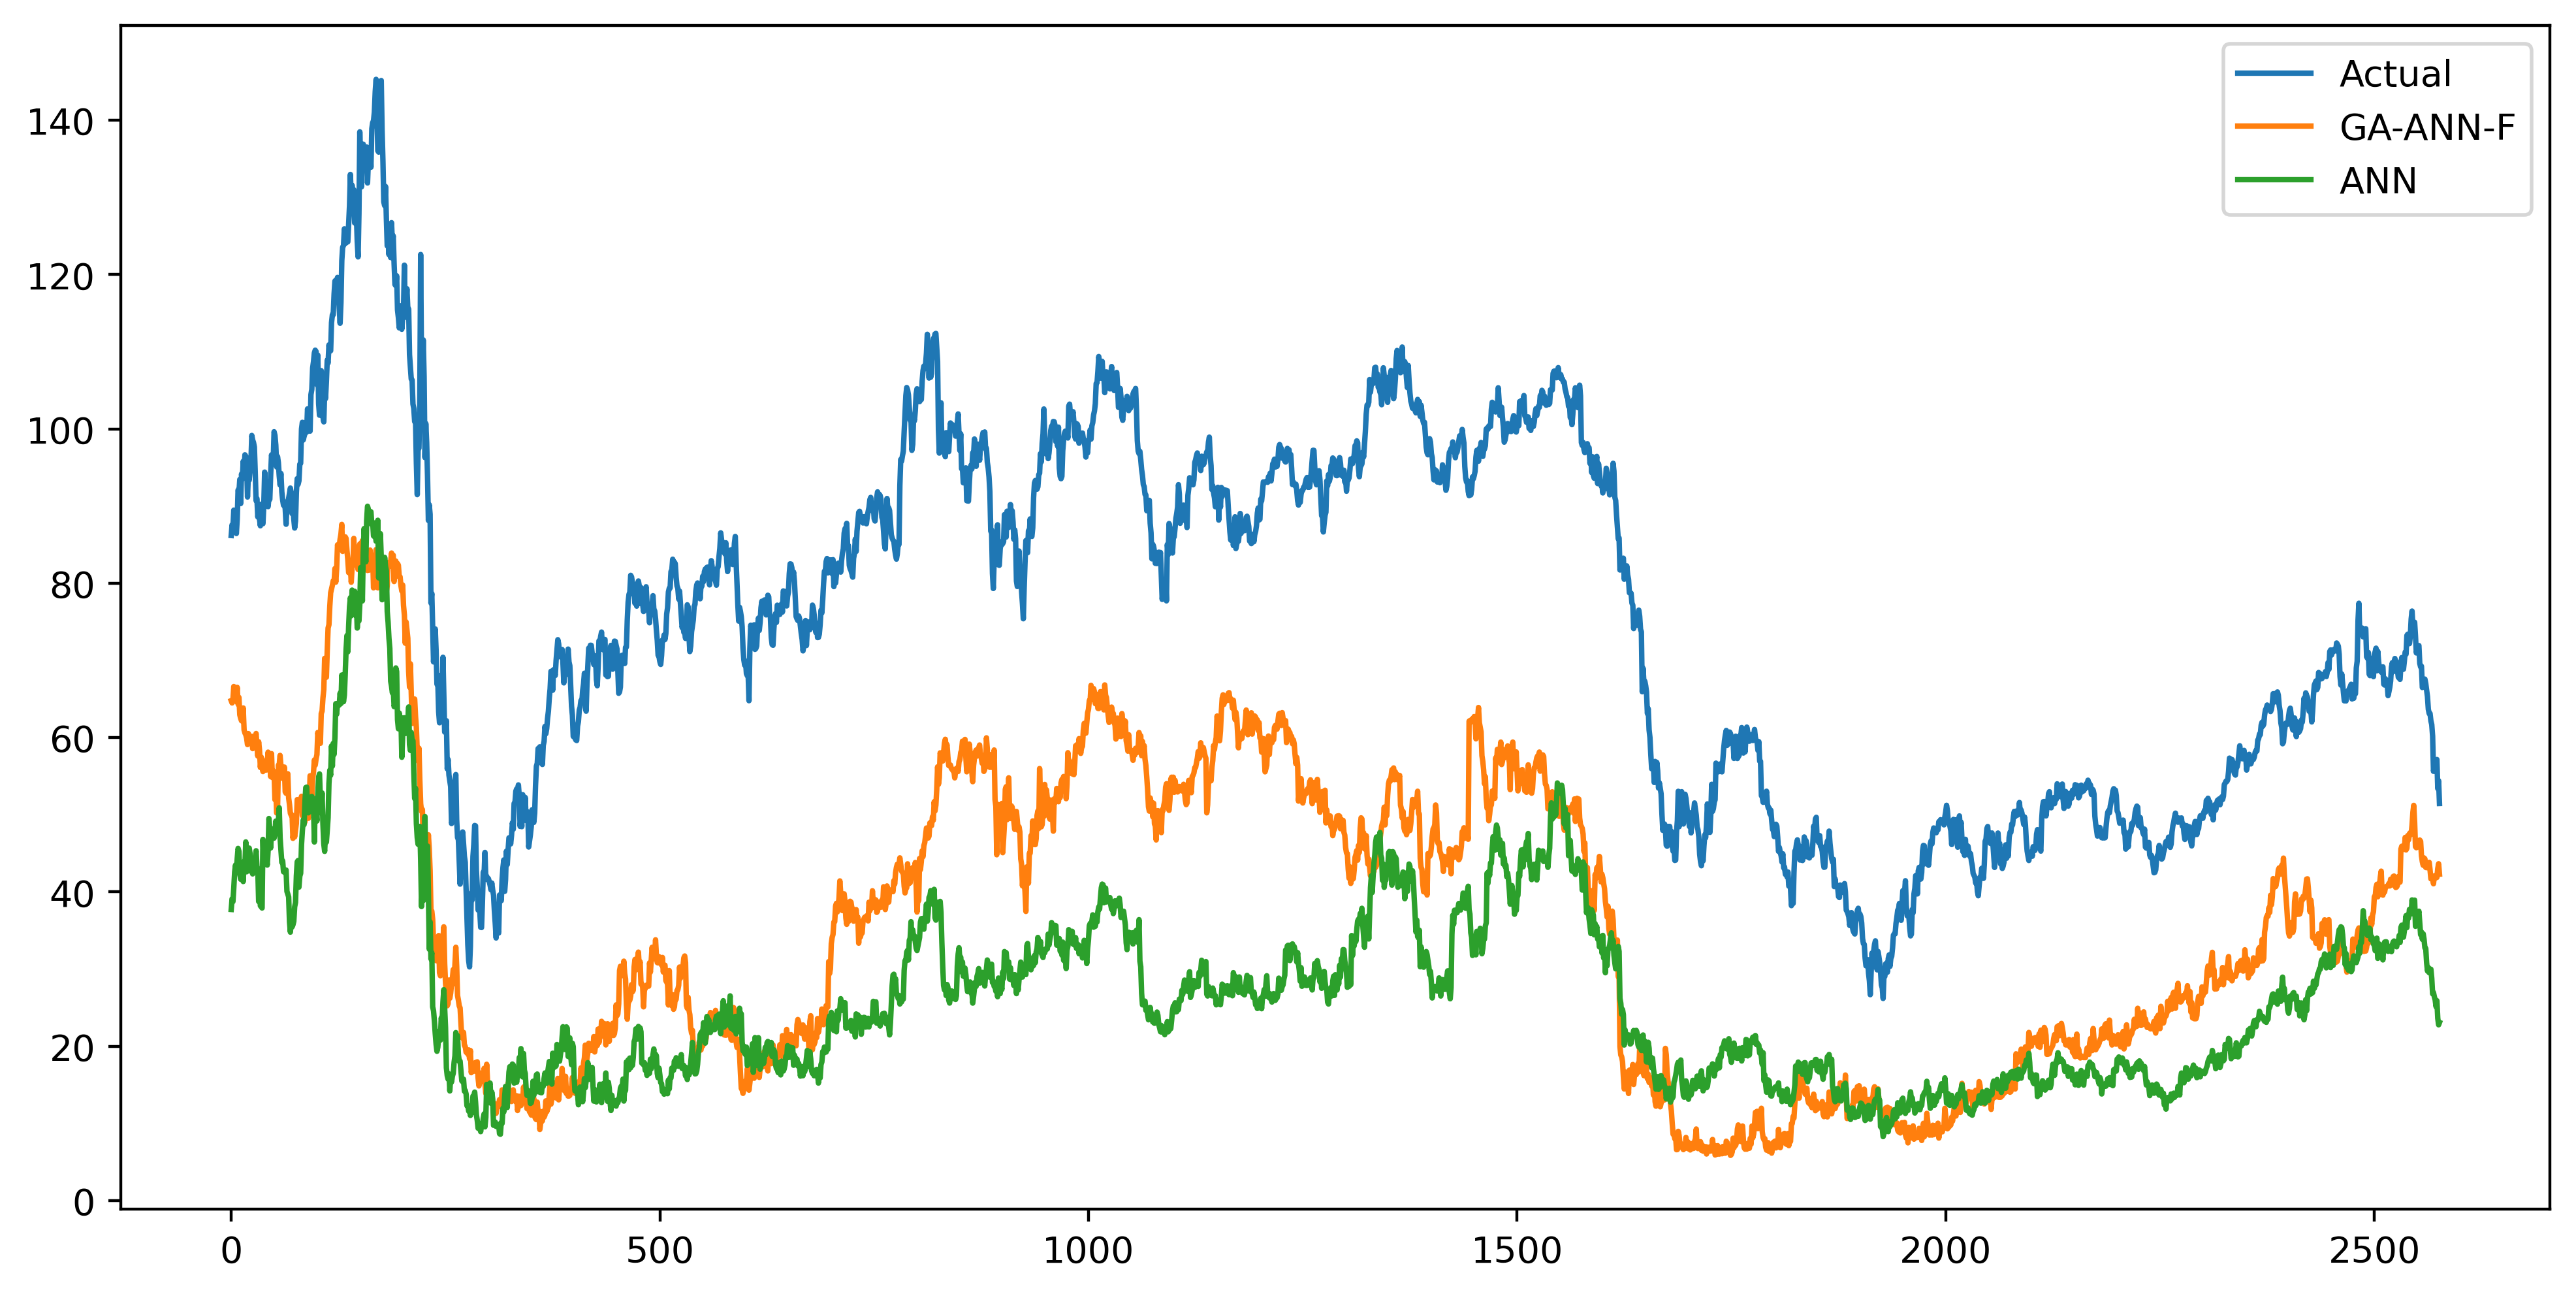

In [107]:
plt.figure(figsize = (12,6), dpi = 400)
plt.plot(y_train_ann, label = 'Actual')
plt.plot(y_pred__train_ga_nn, label = 'GA-ANN-F')
plt.plot(y_pred__train_ann, label = 'ANN')

plt.legend()
#plt.savefig('Plot-GA-ANN_train.jpg', dpi = 800)

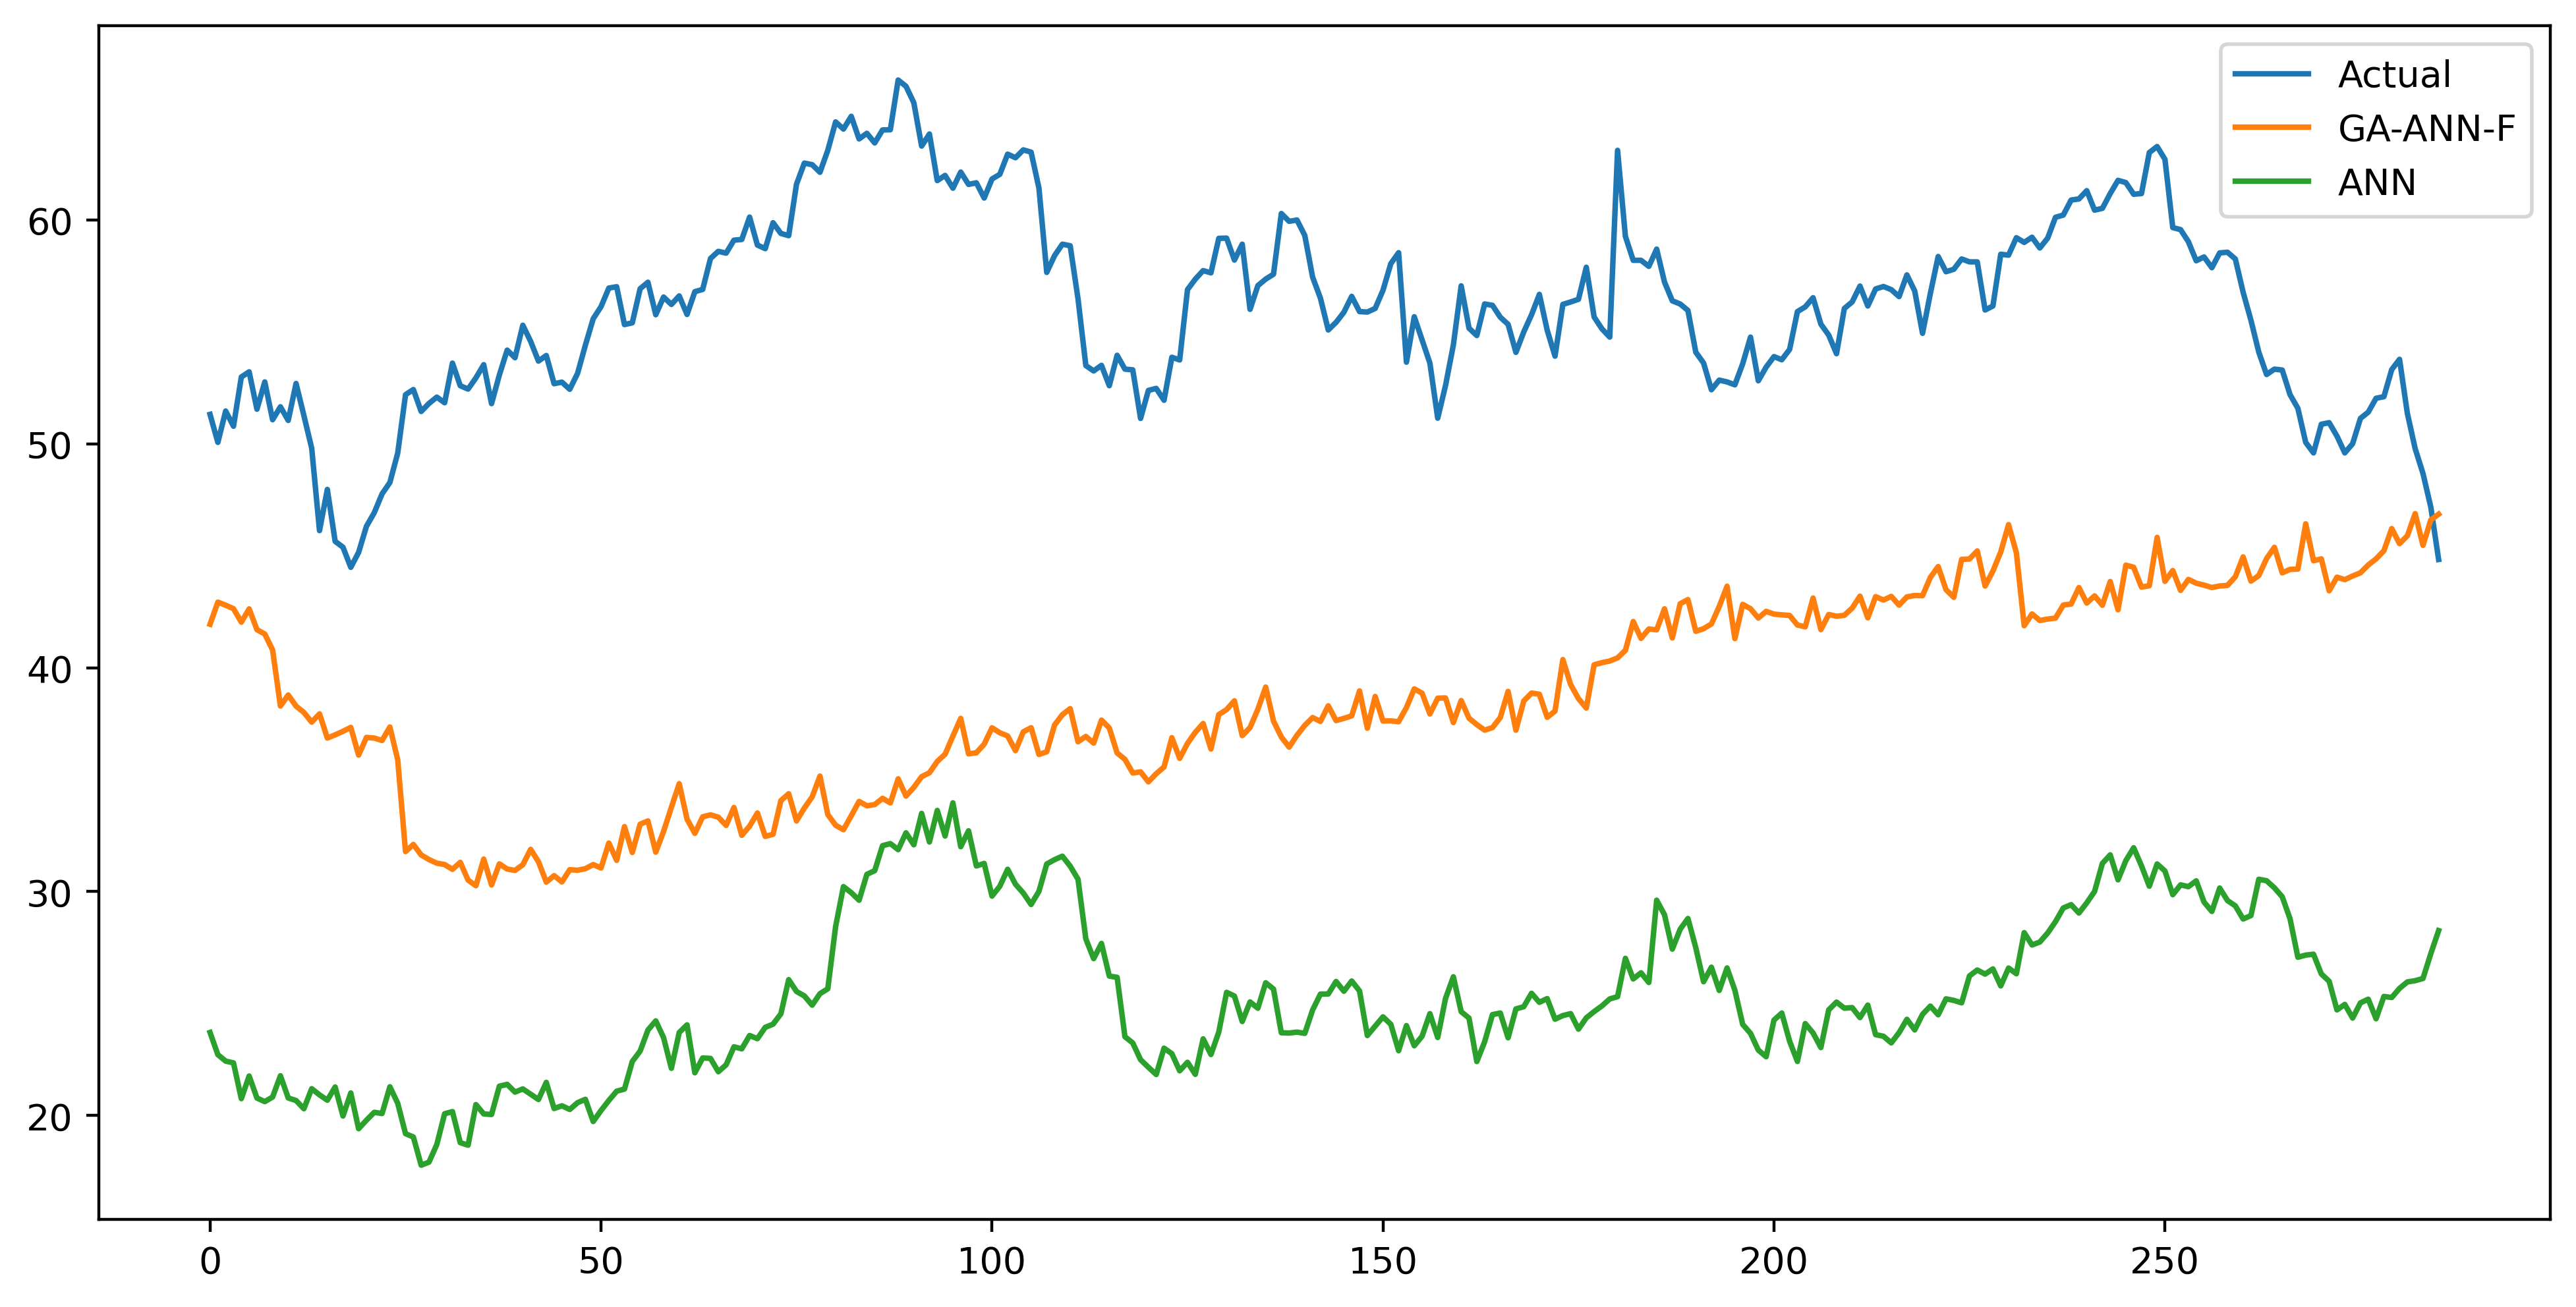

In [109]:
plt.figure(figsize = (12,6), dpi = 400)
plt.plot(y_test_ann, label = 'Actual')
plt.plot(y_pred__test_ga_nn, label = 'GA-ANN-F')
plt.plot(y_pred__test_ann, label = 'ANN')
plt.legend()
#plt.savefig('Plot-GA-ANN-F_test.jpg', dpi = 800)

In [110]:
arr_nn_ga_f = list(y_pred__train_ga_nn) + list(y_pred__test_ga_nn)
arr_ann = list(y_pred__train_ann) + list(y_pred__test_ann)
actual = list(y_train) + list(y_test)

In [111]:
arr_nn_ga_f1 = []
for x in arr_nn_ga_f:
    arr_nn_ga_f1.append(float(x))
    
arr_ann1 = []
for x in arr_ann:
    arr_ann1.append(float(x))
    
actual1 = []
for x in actual:
    actual1.append(float(x))

In [112]:
temp = pd.DataFrame(date_arr)


In [113]:
temp['Actual'] = actual1

In [114]:
temp['ANN'] = arr_ann1
temp['GA_ANN_F'] = arr_nn_ga_f1

In [115]:
temp

DATE  Actual        ANN   GA_ANN_F
14   2007-10-08   86.19  37.727489  64.785660
15   2007-10-09   87.58  39.110336  64.490265
16   2007-10-10   87.19  38.735291  64.919067
17   2007-10-11   89.48  40.521767  66.621346
18   2007-10-12   88.58  42.567089  64.885735
...         ...     ...        ...        ...
2914 2020-02-13   51.36  25.968416  45.890278
2915 2020-02-14   49.78  26.022779  46.879910
2916 2020-02-18   48.67  26.122488  45.461826
2917 2020-02-19   47.17  27.231556  46.597939
2918 2020-02-20   44.83  28.258421  46.854820

[2863 rows x 4 columns]

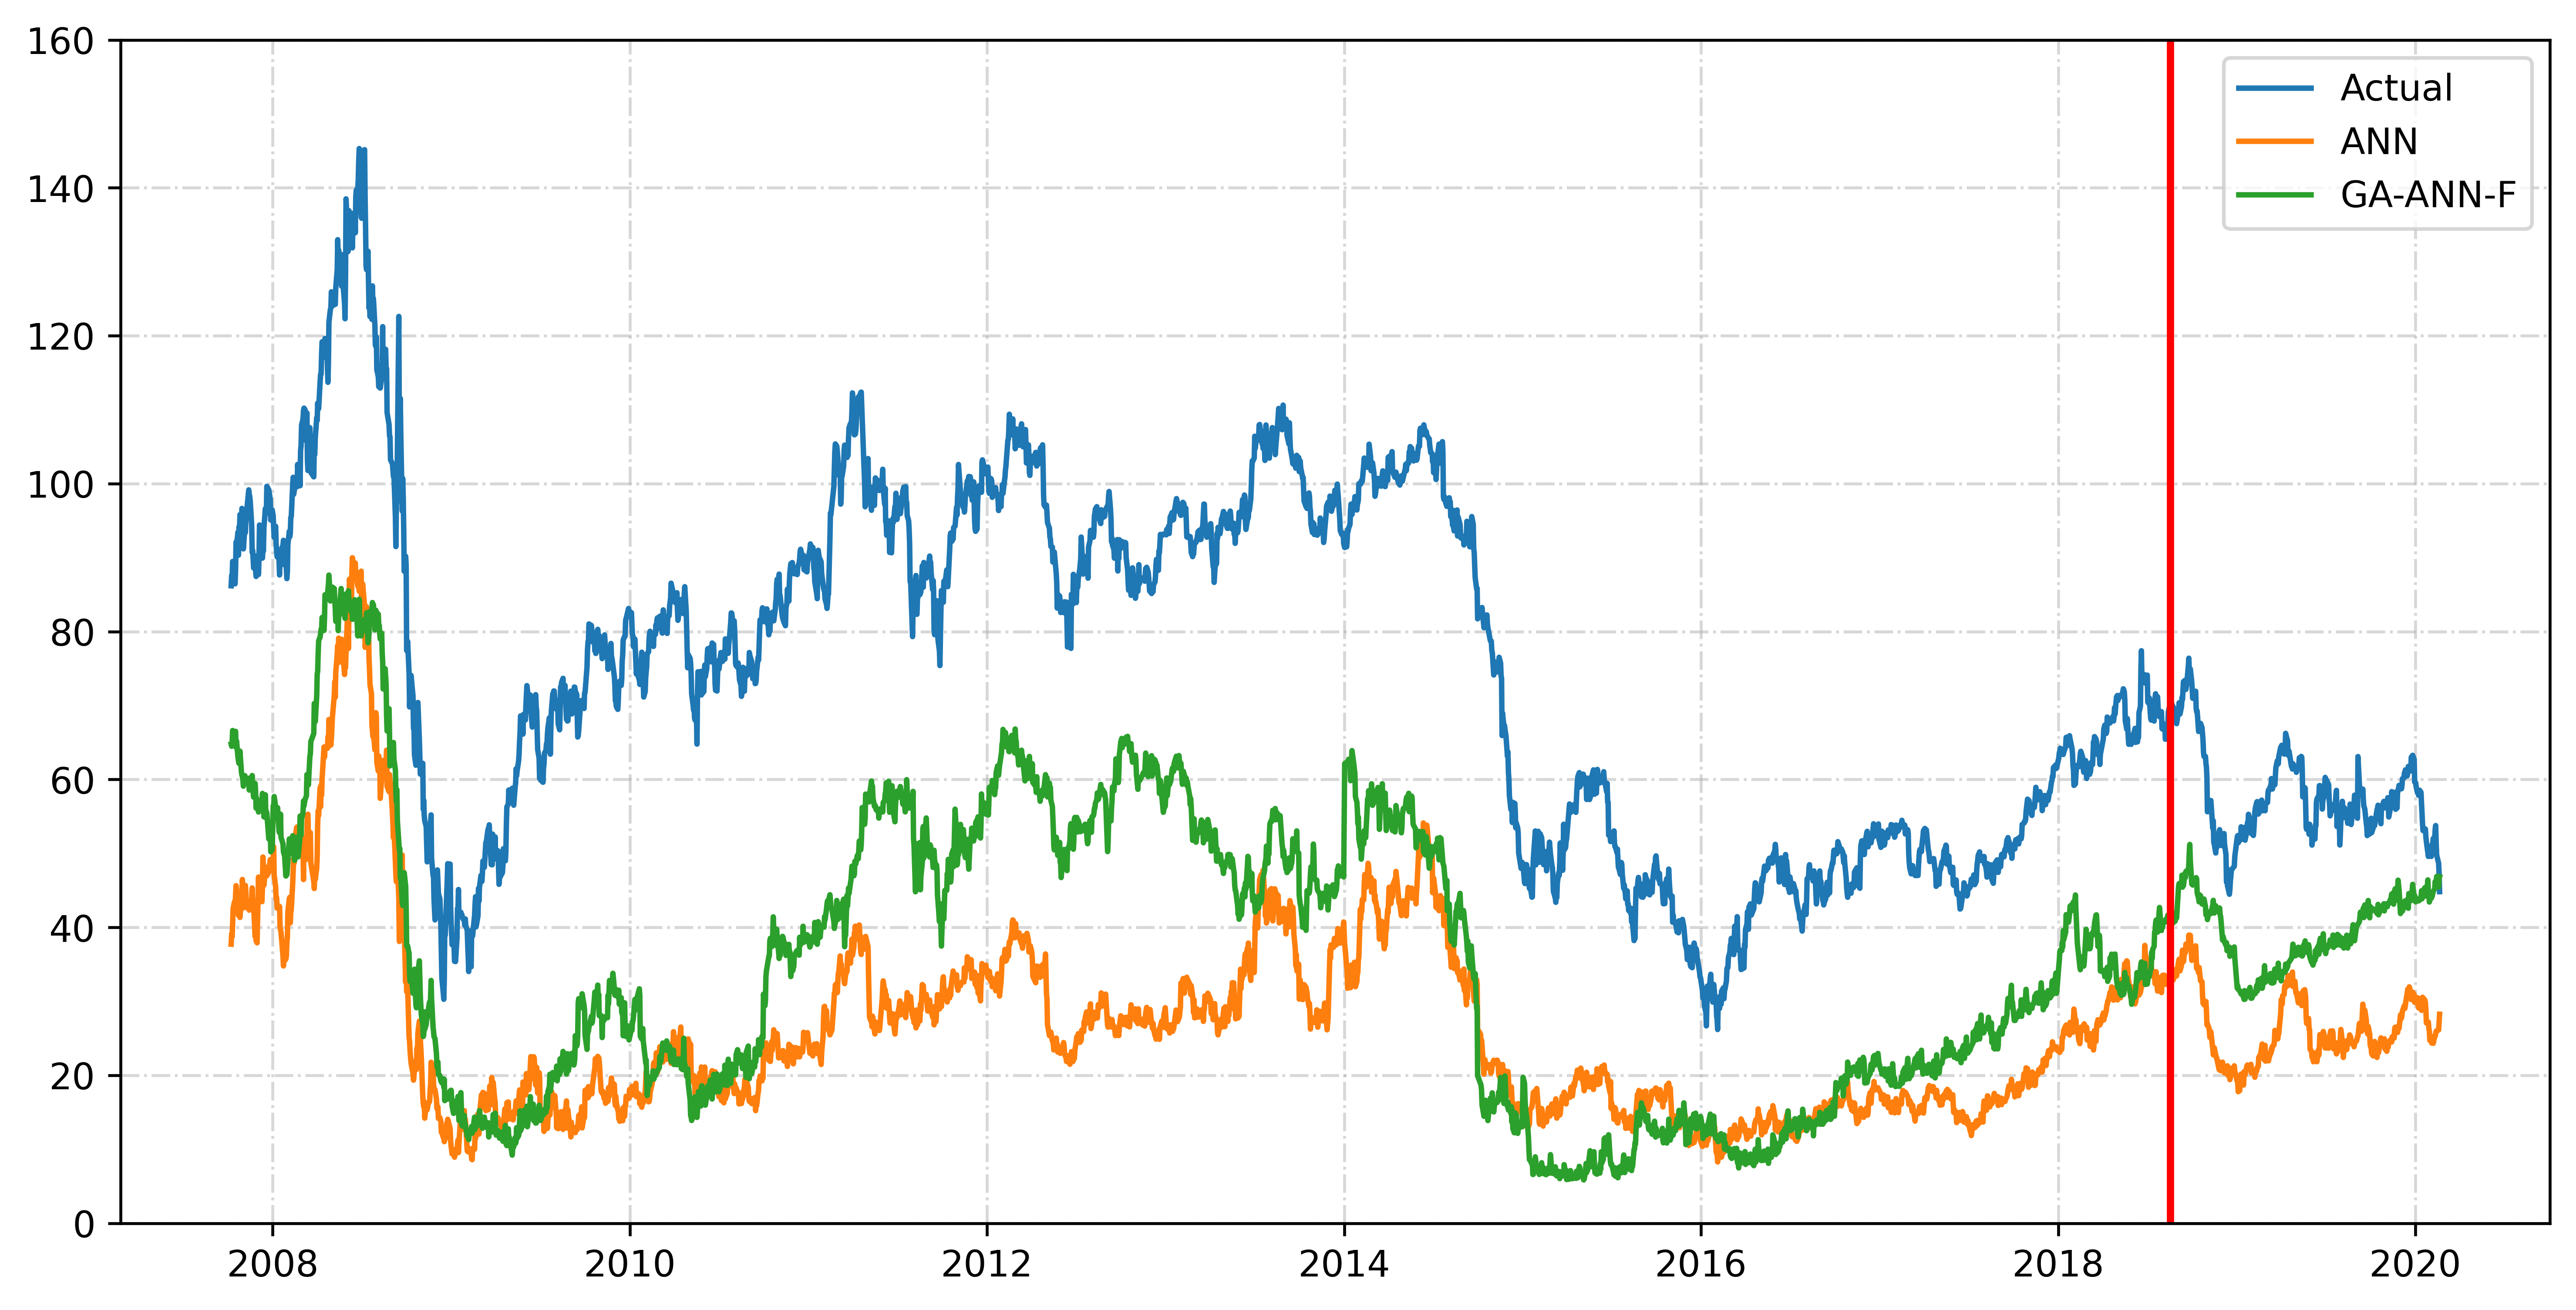

In [118]:
plt.figure(figsize = (12,6), dpi = 600)

plt.plot( temp['DATE'],temp['Actual'], label = 'Actual')
plt.plot( temp['DATE'],temp['ANN'], label = 'ANN')
plt.plot( temp['DATE'],temp['GA_ANN_F'], label = 'GA-ANN-F')

plt.vlines(x = datetime(2018,8,18), ymin = 0, ymax= 240, color = 'red', linewidth = 2)
#plt.plot(predictions_ga_ann_test, label = 'ANN_GA',  marker = '*', alpha  =  0.5)
#plt.plot(predictions_ga_ann_test, label = 'LSTM_GA', alpha  =  0.5)
plt.legend()
plt.grid(linestyle = '-.', alpha = 0.5)
plt.ylim(0,160)
#plt.savefig('PlotGA_ANN_F.jpg', dpi = 800)
plt.show()


In [120]:
#temp.to_csv('temp1.csv')

In [25]:
def reduce_features(solution, features):
    
    selected_elements_indices = numpy.where(solution == 1)[0]
    reduced_features = features[:, selected_elements_indices]
    return reduced_features

def fitness_func(labels, predictions):
    mse = tf.keras.losses.MeanSquaredError()
    fitness = 1/(mse(labels, predictions).numpy() + 0.00001)
    return fitness

def cal_pop_fitness(pop, features, labels, train_indices, test_indices):
    accuracies = np.zeros(pop.shape[0])
    idx = 0
    for curr_solution in pop:
        reduced_features = reduce_features(curr_solution, features)
        train_data = reduced_features[train_indices, :]
        test_data = reduced_features[test_indices, :]
        train_labels = labels[train_indices]
        test_labels = labels[test_indices]
        print(test_data)
        print(train_data.shape)
        print(test_data.shape)
        model_lstm = Sequential()
        model_lstm.add(LSTM(128, input_shape= (train_data.shape[1],1), return_sequences=True))
        model_lstm.add(Dropout(0.2))
        model_lstm.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.

        model_lstm.add(LSTM(128, return_sequences=True))
        model_lstm.add(Dropout(0.1))
        model_lstm.add(BatchNormalization())

        model_lstm.add(LSTM(128))
        model_lstm.add(Dropout(0.2))
        model_lstm.add(BatchNormalization())

        model_lstm.add(Dense(32, activation='relu'))
        model_lstm.add(Dropout(0.2))

        model_lstm.add(Dense(1, activation='relu'))

        opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
        
        model_lstm.compile(optimizer=opt,  loss='mean_squared_error', metrics='mean_squared_error')
        history_nn = model_lstm.fit(train_data, train_labels, epochs = 30, validation_data = [test_data, test_labels])
        predictions = model_lstm.predict(test_data)
        accuracies[idx] = fitness_func(test_labels, predictions)
        idx = idx + 1
    return accuracies

def select_mating_pool(pop, fitness, num_parents):
    parents = numpy.empty((num_parents, pop_shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return parents

def crossover(parents, offspring_size):
    offspring = numpy.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually, it is at the center.
    crossover_point = numpy.uint8(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring


def mutation(offspring_crossover, num_mutations = 2):
    mutation_idx = np.random.randint(low = 0, high = offspring_crossover.shape[1], size = num_mutations)
    for idx in range(offspring_crossover.shape[0]):
        offspring_crossover[idx, mutation_idx] = 1 - offspring_crossover[idx, mutation_idx]
    return offspring_crossover
        

    
        

In [26]:
num_generations = 20

In [27]:
import numpy

In [ ]:
for generation in range(num_generations):
    print("Generation: ", generation)
    fitness = cal_pop_fitness(new_population, data_inputs, data_outputs, train_indices, test_indices)
    best_outputs.append(np.max(fitness))
    print("Best Result: ", best_outputs[-1])

    parents = select_mating_pool(new_population, fitness, num_parents_mating)
    offspring_crossover = crossover(parents, offspring_size= (pop_shape[0]-parents.shape[0], num_feature_elements))
    offspring_mutation = mutation(offspring_crossover, num_mutations= num_mutations)
    
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation
    fitness = cal_pop_fitness(new_population, data_inputs, data_outputs, train_indices, test_indices)
# Then return the index of that solution corresponding to the best fitness.
    best_match_idx = numpy.where(fitness == numpy.max(fitness))[0]
    best_match_idx = best_match_idx[0]

    best_solution = new_population[best_match_idx, :]
    best_solution_indices = numpy.where(best_solution == 1)[0]
    best_solution_num_elements = best_solution_indices.shape[0]
    best_solution_fitness = fitness[best_match_idx]

    print("best_match_idx : ", best_match_idx)
    print("best_solution : ", best_solution)
    print("Selected indices : ", best_solution_indices)
    print("Number of selected elements : ", best_solution_num_elements)
    print("Best solution fitness : ", best_solution_fitness)
    
    

Generation:  0
[[0.18225377 0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Metal device set to: Apple M1 Pro


2022-12-10 12:12:15.247000: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-10 12:12:15.247487: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-10 12:12:15.591995: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30


2022-12-10 12:12:16.613049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:12:17.025714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:12:17.145853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:12:17.227558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:12:17.408250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:12:17.595232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:12:17.741336: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4714.0571 - mean_squared_error: 4714.0571

2022-12-10 12:12:21.678683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:12:21.808935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:12:21.871977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:12:21.943319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 55ms/step - loss: 4714.0571 - mean_squared_error: 4714.0571 - val_loss: 375.3421 - val_mean_squared_error: 375.3421
Epoch 2/30
81/81 [==============================] - 3s 41ms/step - loss: 2280.6301 - mean_squared_error: 2280.6301 - val_loss: 79.6511 - val_mean_squared_error: 79.6511
Epoch 3/30
81/81 [==============================] - 3s 42ms/step - loss: 1235.7565 - mean_squared_error: 1235.7565 - val_loss: 317.3334 - val_mean_squared_error: 317.3334
Epoch 4/30
81/81 [==============================] - 3s 42ms/step - loss: 1069.3400 - mean_squared_error: 1069.3400 - val_loss: 39.1712 - val_mean_squared_error: 39.1712
Epoch 5/30
81/81 [==============================] - 3s 42ms/step - loss: 838.7263 - mean_squared_error: 838.7263 - val_loss: 872.5482 - val_mean_squared_error: 872.5482
Epoch 6/30
81/81 [==============================] - 3s 42ms/step - loss: 624.9553 - mean_squared_error: 624.9553 - val_loss: 96.6863 - val_mean_squared_error: 96.

2022-12-10 12:14:01.644428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:14:01.760846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:14:01.823043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:14:01.892490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.60500742 0.12548801 ... 0.         0.         0.        ]
 [0.6737802  0.60709947 0.15281651 ... 0.         0.         0.        ]
 [0.65978331 0.61047375 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.64428398 0.07933631 ... 0.         0.         0.        ]
 [1.         0.6460386  0.07306191 ... 0.         0.         0.        ]
 [0.99225423 0.66290997 0.08951478 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/30


2022-12-10 12:14:03.413270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:14:03.840739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:14:03.929847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:14:04.021430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:14:04.168059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:14:04.325669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 2/81 [..............................] - ETA: 4s - loss: 6850.0122 - mean_squared_error: 6850.0122  

2022-12-10 12:14:04.485807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 4660.2954 - mean_squared_error: 4660.2954

2022-12-10 12:14:08.753136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:14:08.894991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:14:08.959309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:14:09.031372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 60ms/step - loss: 4660.2954 - mean_squared_error: 4660.2954 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 4s 44ms/step - loss: 1726.2640 - mean_squared_error: 1726.2640 - val_loss: 34.6666 - val_mean_squared_error: 34.6666
Epoch 3/30
81/81 [==============================] - 4s 44ms/step - loss: 967.9208 - mean_squared_error: 967.9208 - val_loss: 156.5017 - val_mean_squared_error: 156.5017
Epoch 4/30
81/81 [==============================] - 4s 43ms/step - loss: 583.4884 - mean_squared_error: 583.4884 - val_loss: 155.8360 - val_mean_squared_error: 155.8360
Epoch 5/30
81/81 [==============================] - 3s 43ms/step - loss: 514.1791 - mean_squared_error: 514.1791 - val_loss: 28.2275 - val_mean_squared_error: 28.2275
Epoch 6/30
81/81 [==============================] - 3s 43ms/step - loss: 328.7943 - mean_squared_error: 328.7943 - val_loss: 141.3054 - val_mean_squared_error: 141.

2022-12-10 12:15:51.827651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:15:51.953727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:15:52.024925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:15:52.108476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.18225377 0.12548801 0.16524764 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.169704   ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.17343575 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.08050433 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.07604797 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.07256983 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/30


2022-12-10 12:15:53.840528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:15:54.306974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:15:54.392143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:15:54.486196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:15:54.653968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:15:54.834211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/81 [..............................] - ETA: 3:15 - loss: 5904.7773 - mean_squared_error: 5904.7773

2022-12-10 12:15:55.015323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 4505.6133 - mean_squared_error: 4505.6133

2022-12-10 12:15:59.484533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:15:59.627723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:15:59.701667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:15:59.781685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 8s 63ms/step - loss: 4505.6133 - mean_squared_error: 4505.6133 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 4s 43ms/step - loss: 1437.0671 - mean_squared_error: 1437.0671 - val_loss: 18.8925 - val_mean_squared_error: 18.8925
Epoch 3/30
81/81 [==============================] - 4s 43ms/step - loss: 712.8690 - mean_squared_error: 712.8690 - val_loss: 84.9098 - val_mean_squared_error: 84.9098
Epoch 4/30
81/81 [==============================] - 4s 44ms/step - loss: 614.4236 - mean_squared_error: 614.4236 - val_loss: 3071.3948 - val_mean_squared_error: 3071.3948
Epoch 5/30
81/81 [==============================] - 4s 44ms/step - loss: 784.4459 - mean_squared_error: 784.4459 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 6/30
81/81 [==============================] - 3s 43ms/step - loss: 636.5085 - mean_squared_error: 636.5085 - val_loss: 56.4917 - val_mean_squared_error: 5

2022-12-10 12:17:42.945255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:17:43.069022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:17:43.142900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:17:43.225788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 12:17:44.949498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:17:45.408668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:17:45.515168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:17:45.626855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:17:45.812189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:17:46.005362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:17:46.194936: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4815.2017 - mean_squared_error: 4815.2017

2022-12-10 12:17:51.078271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:17:51.214294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:17:51.291210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:17:51.372664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 8s 69ms/step - loss: 4815.2017 - mean_squared_error: 4815.2017 - val_loss: 2865.6282 - val_mean_squared_error: 2865.6282
Epoch 2/30
81/81 [==============================] - 4s 45ms/step - loss: 2596.3523 - mean_squared_error: 2596.3523 - val_loss: 537.6719 - val_mean_squared_error: 537.6719
Epoch 3/30
81/81 [==============================] - 4s 45ms/step - loss: 2224.5083 - mean_squared_error: 2224.5083 - val_loss: 1222.5885 - val_mean_squared_error: 1222.5885
Epoch 4/30
81/81 [==============================] - 4s 46ms/step - loss: 854.8522 - mean_squared_error: 854.8522 - val_loss: 3381.0891 - val_mean_squared_error: 3381.0891
Epoch 5/30
81/81 [==============================] - 4s 45ms/step - loss: 780.6198 - mean_squared_error: 780.6198 - val_loss: 2062.9717 - val_mean_squared_error: 2062.9717
Epoch 6/30
81/81 [==============================] - 4s 45ms/step - loss: 766.3279 - mean_squared_error: 766.3279 - val_loss: 1213.4004 - val_mean_square

2022-12-10 12:19:39.775031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:19:39.901708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:19:39.975632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:19:40.068471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 12:19:41.847385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:19:42.312067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:19:42.417454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:19:42.528544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:19:42.761576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:19:42.979960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/81 [..............................] - ETA: 3:29 - loss: 6157.3120 - mean_squared_error: 6157.3120

2022-12-10 12:19:43.196511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 4729.2056 - mean_squared_error: 4729.2056

2022-12-10 12:19:47.697078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:19:47.833754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:19:47.901939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:19:47.975875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 8s 63ms/step - loss: 4729.2056 - mean_squared_error: 4729.2056 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 3s 40ms/step - loss: 2882.6165 - mean_squared_error: 2882.6165 - val_loss: 924.2663 - val_mean_squared_error: 924.2663
Epoch 3/30
81/81 [==============================] - 3s 39ms/step - loss: 1231.7357 - mean_squared_error: 1231.7357 - val_loss: 4157.5000 - val_mean_squared_error: 4157.5000
Epoch 4/30
81/81 [==============================] - 3s 39ms/step - loss: 638.6656 - mean_squared_error: 638.6656 - val_loss: 626.6222 - val_mean_squared_error: 626.6222
Epoch 5/30
81/81 [==============================] - 3s 40ms/step - loss: 248.6081 - mean_squared_error: 248.6081 - val_loss: 849.1373 - val_mean_squared_error: 849.1373
Epoch 6/30
81/81 [==============================] - 3s 40ms/step - loss: 79.1426 - mean_squared_error: 79.1426 - val_loss: 37.6033 - val_mean_squared_error:

2022-12-10 12:21:22.697309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:21:22.822692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:21:22.910138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:21:23.002857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.025509789955382983
[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 12:21:24.826396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:21:25.233630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:21:25.355870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:21:25.490190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:21:25.727107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:21:25.964097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/81 [..............................] - ETA: 3:40 - loss: 6367.8262 - mean_squared_error: 6367.8262

2022-12-10 12:21:26.203429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 4939.4780 - mean_squared_error: 4939.4780

2022-12-10 12:21:31.411173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:21:31.539441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:21:31.635305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:21:31.737418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 9s 74ms/step - loss: 4939.4780 - mean_squared_error: 4939.4780 - val_loss: 487.4036 - val_mean_squared_error: 487.4036
Epoch 2/30
81/81 [==============================] - 4s 46ms/step - loss: 3129.3171 - mean_squared_error: 3129.3171 - val_loss: 134.1376 - val_mean_squared_error: 134.1376
Epoch 3/30
81/81 [==============================] - 4s 47ms/step - loss: 1482.0382 - mean_squared_error: 1482.0382 - val_loss: 889.4099 - val_mean_squared_error: 889.4099
Epoch 4/30
81/81 [==============================] - 4s 46ms/step - loss: 1174.2950 - mean_squared_error: 1174.2950 - val_loss: 875.1362 - val_mean_squared_error: 875.1362
Epoch 5/30
81/81 [==============================] - 4s 46ms/step - loss: 1116.0647 - mean_squared_error: 1116.0647 - val_loss: 1659.4325 - val_mean_squared_error: 1659.4324
Epoch 6/30
81/81 [==============================] - 4s 46ms/step - loss: 1099.5964 - mean_squared_error: 1099.5964 - val_loss: 133.4148 - val_mean_squared

2022-12-10 12:23:21.862280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:23:21.978658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:23:22.073214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:23:22.174299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.18225377 0.12548801 0.16524764 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.169704   ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.17343575 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.08050433 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.07604797 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.07256983 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/30


2022-12-10 12:23:23.829807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:23:24.285587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:23:24.402703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:23:24.535021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:23:24.781634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:23:25.021510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/81 [..............................] - ETA: 3:24 - loss: 6268.8252 - mean_squared_error: 6268.8252

2022-12-10 12:23:25.260047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 4380.2627 - mean_squared_error: 4380.2627

2022-12-10 12:23:30.581652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:23:30.721072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:23:30.816131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:23:30.913519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 9s 75ms/step - loss: 4380.2627 - mean_squared_error: 4380.2627 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 4s 45ms/step - loss: 1534.4059 - mean_squared_error: 1534.4059 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 4s 45ms/step - loss: 1160.9659 - mean_squared_error: 1160.9659 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 4/30
81/81 [==============================] - 4s 44ms/step - loss: 669.3458 - mean_squared_error: 669.3458 - val_loss: 707.2568 - val_mean_squared_error: 707.2568
Epoch 5/30
81/81 [==============================] - 4s 45ms/step - loss: 482.4203 - mean_squared_error: 482.4203 - val_loss: 159.8981 - val_mean_squared_error: 159.8981
Epoch 6/30
81/81 [==============================] - 4s 44ms/step - loss: 567.7206 - mean_squared_error: 567.7206 - val_loss: 140.1647 - val_mean_squared_e

2022-12-10 12:25:15.845892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:25:15.980992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:25:16.072058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:25:16.171125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.18225377 0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 12:25:18.016336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:25:18.479613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:25:18.607054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:25:18.743615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:25:18.990172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:25:19.222511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/81 [..............................] - ETA: 3:37 - loss: 6399.6201 - mean_squared_error: 6399.6201

2022-12-10 12:25:19.472243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 4918.6973 - mean_squared_error: 4918.6973

2022-12-10 12:25:24.791816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:25:24.939177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:25:25.032588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:25:25.131019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 9s 76ms/step - loss: 4918.6973 - mean_squared_error: 4918.6973 - val_loss: 2397.4150 - val_mean_squared_error: 2397.4148
Epoch 2/30
81/81 [==============================] - 4s 45ms/step - loss: 2386.6006 - mean_squared_error: 2386.6006 - val_loss: 50.8537 - val_mean_squared_error: 50.8537
Epoch 3/30
81/81 [==============================] - 4s 44ms/step - loss: 856.8683 - mean_squared_error: 856.8683 - val_loss: 181.6937 - val_mean_squared_error: 181.6937
Epoch 4/30
81/81 [==============================] - 3s 43ms/step - loss: 515.6670 - mean_squared_error: 515.6670 - val_loss: 65.2036 - val_mean_squared_error: 65.2036
Epoch 5/30
81/81 [==============================] - 3s 42ms/step - loss: 362.9511 - mean_squared_error: 362.9511 - val_loss: 560.7556 - val_mean_squared_error: 560.7556
Epoch 6/30
81/81 [==============================] - 3s 43ms/step - loss: 218.9830 - mean_squared_error: 218.9830 - val_loss: 470.2606 - val_mean_squared_error: 470.

2022-12-10 12:27:07.015998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:27:07.137635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:27:07.229227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:27:07.324838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 12:27:09.141484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:27:09.580569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:27:09.703275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:27:09.833398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:27:10.066788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:27:10.277388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/81 [..............................] - ETA: 3:29 - loss: 5474.4067 - mean_squared_error: 5474.4067

2022-12-10 12:27:10.490939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 4695.0342 - mean_squared_error: 4695.0342

2022-12-10 12:27:15.696977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:27:15.833247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:27:15.924947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:27:16.017632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 8s 73ms/step - loss: 4695.0342 - mean_squared_error: 4695.0342 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 3s 42ms/step - loss: 2153.2300 - mean_squared_error: 2153.2300 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 3s 41ms/step - loss: 1237.1160 - mean_squared_error: 1237.1160 - val_loss: 1098.8390 - val_mean_squared_error: 1098.8390
Epoch 4/30
81/81 [==============================] - 3s 40ms/step - loss: 615.4446 - mean_squared_error: 615.4446 - val_loss: 530.4849 - val_mean_squared_error: 530.4849
Epoch 5/30
81/81 [==============================] - 3s 40ms/step - loss: 556.3781 - mean_squared_error: 556.3781 - val_loss: 56.6271 - val_mean_squared_error: 56.6271
Epoch 6/30
81/81 [==============================] - 3s 41ms/step - loss: 563.6143 - mean_squared_error: 563.6143 - val_loss: 234.5437 - val_mean_squared_err

2022-12-10 12:28:51.835926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:28:51.963422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:28:52.043023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:28:52.137268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 50)
(286, 50)
Epoch 1/30


2022-12-10 12:28:53.968041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:28:54.430382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:28:54.755955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:28:54.930117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:28:55.195319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:28:55.467492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:28:55.724937: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4894.4810 - mean_squared_error: 4894.4810

2022-12-10 12:29:01.858985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:29:01.998715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:29:02.115846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:29:02.215544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 10s 86ms/step - loss: 4894.4810 - mean_squared_error: 4894.4810 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 4s 50ms/step - loss: 2694.5603 - mean_squared_error: 2694.5603 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 4s 48ms/step - loss: 1994.9655 - mean_squared_error: 1994.9655 - val_loss: 288.5669 - val_mean_squared_error: 288.5669
Epoch 4/30
81/81 [==============================] - 4s 48ms/step - loss: 1681.9470 - mean_squared_error: 1681.9470 - val_loss: 387.6811 - val_mean_squared_error: 387.6811
Epoch 5/30
81/81 [==============================] - 4s 48ms/step - loss: 1663.4506 - mean_squared_error: 1663.4506 - val_loss: 416.3937 - val_mean_squared_error: 416.3937
Epoch 6/30
81/81 [==============================] - 4s 48ms/step - loss: 1648.8221 - mean_squared_error: 1648.8221 - val_loss: 530.8481 - val_mean_squa

2022-12-10 12:30:57.603531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:30:57.738544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:30:57.841856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:30:57.941769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


best_match_idx :  0
best_solution :  [1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1
 1 0 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1
 1 0 1 1 0 0 1]
Selected indices :  [ 0  1  2  3  4  6  8  9 11 13 15 18 21 24 25 27 29 31 32 33 36 37 39 41
 42 43 44 46 47 51 52 53 54 55 56 58 61 62 65 66 67 69 72 73 74 76 77 80]
Number of selected elements :  48
Best solution fitness :  0.01657584507916953
Generation:  1
[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 12:30:59.949843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:31:00.362284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:31:00.511557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:31:00.700197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:31:00.954644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:31:01.204227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:31:01.456728: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4873.2041 - mean_squared_error: 4873.2041

2022-12-10 12:31:07.699058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:31:07.824372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:31:07.932758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:31:08.063617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 10s 89ms/step - loss: 4873.2041 - mean_squared_error: 4873.2041 - val_loss: 2394.6055 - val_mean_squared_error: 2394.6055
Epoch 2/30
81/81 [==============================] - 4s 49ms/step - loss: 2603.0132 - mean_squared_error: 2603.0132 - val_loss: 73.6973 - val_mean_squared_error: 73.6973
Epoch 3/30
81/81 [==============================] - 4s 49ms/step - loss: 1645.8002 - mean_squared_error: 1645.8002 - val_loss: 20.1102 - val_mean_squared_error: 20.1102
Epoch 4/30
81/81 [==============================] - 4s 50ms/step - loss: 1130.5203 - mean_squared_error: 1130.5203 - val_loss: 477.9078 - val_mean_squared_error: 477.9078
Epoch 5/30
81/81 [==============================] - 4s 48ms/step - loss: 928.2136 - mean_squared_error: 928.2136 - val_loss: 309.9883 - val_mean_squared_error: 309.9883
Epoch 6/30
81/81 [==============================] - 4s 48ms/step - loss: 926.0173 - mean_squared_error: 926.0173 - val_loss: 131.1795 - val_mean_squared_error:

2022-12-10 12:33:02.746656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:33:02.863762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:33:02.984690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:33:03.117897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.18225377 0.12548801 0.16524764 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.169704   ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.17343575 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.08050433 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.07604797 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.07256983 ... 0.         0.         0.        ]]
(2577, 44)
(286, 44)
Epoch 1/30


2022-12-10 12:33:04.909063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:33:05.364826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:33:05.499910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:33:05.636181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:33:05.876545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:33:06.103785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/81 [..............................] - ETA: 3:24 - loss: 7321.0981 - mean_squared_error: 7321.0981

2022-12-10 12:33:06.324360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 4466.6025 - mean_squared_error: 4466.6025

2022-12-10 12:33:12.603624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:33:12.741403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:33:12.846442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:33:12.941891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 10s 88ms/step - loss: 4466.6025 - mean_squared_error: 4466.6025 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 4s 47ms/step - loss: 1465.5956 - mean_squared_error: 1465.5956 - val_loss: 240.5378 - val_mean_squared_error: 240.5378
Epoch 3/30
81/81 [==============================] - 4s 46ms/step - loss: 937.7607 - mean_squared_error: 937.7607 - val_loss: 215.8772 - val_mean_squared_error: 215.8772
Epoch 4/30
81/81 [==============================] - 4s 46ms/step - loss: 638.4656 - mean_squared_error: 638.4656 - val_loss: 253.6339 - val_mean_squared_error: 253.6339
Epoch 5/30
81/81 [==============================] - 4s 46ms/step - loss: 545.7242 - mean_squared_error: 545.7242 - val_loss: 43.8327 - val_mean_squared_error: 43.8327
Epoch 6/30
81/81 [==============================] - 4s 45ms/step - loss: 531.2341 - mean_squared_error: 531.2341 - val_loss: 3164.6384 - val_mean_squared_error: 

2022-12-10 12:35:00.773887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:35:00.906707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:35:01.032223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:35:01.162032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.18225377 0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 12:35:03.120593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:35:03.602482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:35:03.768617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:35:03.943211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:35:04.274768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:35:04.605091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:35:04.931504: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4994.6353 - mean_squared_error: 4994.6353

2022-12-10 12:35:11.500781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:35:11.648376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:35:11.766627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:35:11.899269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 11s 95ms/step - loss: 4994.6353 - mean_squared_error: 4994.6353 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 4s 46ms/step - loss: 2634.3740 - mean_squared_error: 2634.3740 - val_loss: 118.4372 - val_mean_squared_error: 118.4372
Epoch 3/30
81/81 [==============================] - 4s 45ms/step - loss: 1405.9276 - mean_squared_error: 1405.9276 - val_loss: 593.6695 - val_mean_squared_error: 593.6695
Epoch 4/30
81/81 [==============================] - 4s 45ms/step - loss: 1151.8389 - mean_squared_error: 1151.8389 - val_loss: 272.2657 - val_mean_squared_error: 272.2657
Epoch 5/30
81/81 [==============================] - 4s 45ms/step - loss: 1106.0887 - mean_squared_error: 1106.0887 - val_loss: 22.0911 - val_mean_squared_error: 22.0911
Epoch 6/30
81/81 [==============================] - 4s 44ms/step - loss: 1001.4987 - mean_squared_error: 1001.4987 - val_loss: 264.4770 - val_mean_squared_

2022-12-10 12:36:56.671757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:36:56.810439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:36:56.935420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:36:57.067319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 12:36:59.089164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:36:59.563440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:36:59.735817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:36:59.917133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:37:00.187813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:37:00.405661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:37:00.721233: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4810.9067 - mean_squared_error: 4810.9067

2022-12-10 12:37:07.471184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:37:07.623057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:37:07.739685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:37:07.866624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 11s 95ms/step - loss: 4810.9067 - mean_squared_error: 4810.9067 - val_loss: 471.4123 - val_mean_squared_error: 471.4123
Epoch 2/30
81/81 [==============================] - 4s 45ms/step - loss: 2429.2151 - mean_squared_error: 2429.2151 - val_loss: 245.6257 - val_mean_squared_error: 245.6257
Epoch 3/30
81/81 [==============================] - 4s 43ms/step - loss: 1477.7729 - mean_squared_error: 1477.7729 - val_loss: 646.2132 - val_mean_squared_error: 646.2131
Epoch 4/30
81/81 [==============================] - 3s 42ms/step - loss: 1220.3518 - mean_squared_error: 1220.3518 - val_loss: 503.7481 - val_mean_squared_error: 503.7481
Epoch 5/30
81/81 [==============================] - 3s 42ms/step - loss: 537.8073 - mean_squared_error: 537.8073 - val_loss: 57.0079 - val_mean_squared_error: 57.0079
Epoch 6/30
81/81 [==============================] - 4s 49ms/step - loss: 647.6135 - mean_squared_error: 647.6135 - val_loss: 232.8750 - val_mean_squared_error:

2022-12-10 12:38:48.144940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:38:48.272158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:38:48.399029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:38:48.533023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 50)
(286, 50)
Epoch 1/30


2022-12-10 12:38:51.070791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:38:51.572748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:38:51.769504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:38:51.981336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:38:52.380105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:38:52.732577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:38:53.103114: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4753.6006 - mean_squared_error: 4753.6006

2022-12-10 12:39:00.699184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:39:00.852425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:39:00.986675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:39:01.132515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 13s 108ms/step - loss: 4753.6006 - mean_squared_error: 4753.6006 - val_loss: 2963.8645 - val_mean_squared_error: 2963.8645
Epoch 2/30
81/81 [==============================] - 4s 51ms/step - loss: 2585.8362 - mean_squared_error: 2585.8362 - val_loss: 230.0063 - val_mean_squared_error: 230.0063
Epoch 3/30
81/81 [==============================] - 4s 51ms/step - loss: 2016.3922 - mean_squared_error: 2016.3922 - val_loss: 71.1985 - val_mean_squared_error: 71.1985
Epoch 4/30
81/81 [==============================] - 4s 51ms/step - loss: 1636.5394 - mean_squared_error: 1636.5394 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 5/30
81/81 [==============================] - 4s 50ms/step - loss: 885.5110 - mean_squared_error: 885.5110 - val_loss: 298.5913 - val_mean_squared_error: 298.5913
Epoch 6/30
81/81 [==============================] - 4s 51ms/step - loss: 502.1341 - mean_squared_error: 502.1341 - val_loss: 195.8331 - val_mean_squared_e

2022-12-10 12:41:02.693958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:41:02.839743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:41:02.980446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:41:03.127422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.018969611903270227
[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 50)
(286, 50)
Epoch 1/30


2022-12-10 12:41:05.841822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:41:06.327633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:41:06.548646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:41:06.763879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:41:07.175682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:41:07.545108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:41:07.909897: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4934.9170 - mean_squared_error: 4934.9170

2022-12-10 12:41:15.744208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:41:15.878720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:41:16.024338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:41:16.176679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 13s 110ms/step - loss: 4934.9170 - mean_squared_error: 4934.9170 - val_loss: 726.1358 - val_mean_squared_error: 726.1358
Epoch 2/30
81/81 [==============================] - 4s 54ms/step - loss: 3193.9448 - mean_squared_error: 3193.9448 - val_loss: 3032.3049 - val_mean_squared_error: 3032.3049
Epoch 3/30
81/81 [==============================] - 4s 55ms/step - loss: 1372.9604 - mean_squared_error: 1372.9604 - val_loss: 3302.5110 - val_mean_squared_error: 3302.5110
Epoch 4/30
81/81 [==============================] - 4s 53ms/step - loss: 1058.9130 - mean_squared_error: 1058.9130 - val_loss: 179.5878 - val_mean_squared_error: 179.5878
Epoch 5/30
81/81 [==============================] - 4s 54ms/step - loss: 762.6462 - mean_squared_error: 762.6462 - val_loss: 3144.2771 - val_mean_squared_error: 3144.2771
Epoch 6/30
81/81 [==============================] - 4s 53ms/step - loss: 733.7646 - mean_squared_error: 733.7646 - val_loss: 1652.2561 - val_mean_squa

2022-12-10 12:43:17.861673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:43:17.994954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:43:18.149162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:43:18.313949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 12:43:20.457028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:43:20.976062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:43:21.161911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:43:21.358154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:43:21.756053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:43:22.118367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:43:22.458187: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4820.0654 - mean_squared_error: 4820.0654

2022-12-10 12:43:29.436789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:43:29.588059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:43:29.714700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:43:29.848740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 11s 100ms/step - loss: 4820.0654 - mean_squared_error: 4820.0654 - val_loss: 667.3195 - val_mean_squared_error: 667.3195
Epoch 2/30
81/81 [==============================] - 4s 46ms/step - loss: 2420.4280 - mean_squared_error: 2420.4280 - val_loss: 18.5953 - val_mean_squared_error: 18.5953
Epoch 3/30
81/81 [==============================] - 4s 48ms/step - loss: 853.9213 - mean_squared_error: 853.9213 - val_loss: 46.1000 - val_mean_squared_error: 46.1000
Epoch 4/30
81/81 [==============================] - 4s 51ms/step - loss: 1109.1768 - mean_squared_error: 1109.1768 - val_loss: 124.5381 - val_mean_squared_error: 124.5381
Epoch 5/30
81/81 [==============================] - 4s 45ms/step - loss: 867.4690 - mean_squared_error: 867.4690 - val_loss: 515.0792 - val_mean_squared_error: 515.0792
Epoch 6/30
81/81 [==============================] - 4s 45ms/step - loss: 688.6306 - mean_squared_error: 688.6306 - val_loss: 2282.5225 - val_mean_squared_error: 2

2022-12-10 12:45:13.799747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:45:13.948891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:45:14.085613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:45:14.233068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.18225377 0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 12:45:16.833322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:45:17.501372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:45:17.768564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:45:18.049733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:45:18.554507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:45:18.947372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:45:19.376514: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4946.6021 - mean_squared_error: 4946.6021

2022-12-10 12:45:26.480208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:45:26.630028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:45:26.765249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:45:26.897260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 12s 100ms/step - loss: 4946.6021 - mean_squared_error: 4946.6021 - val_loss: 2647.5300 - val_mean_squared_error: 2647.5300
Epoch 2/30
81/81 [==============================] - 4s 47ms/step - loss: 2567.4910 - mean_squared_error: 2567.4910 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 4s 46ms/step - loss: 2025.2314 - mean_squared_error: 2025.2314 - val_loss: 109.4098 - val_mean_squared_error: 109.4098
Epoch 4/30
81/81 [==============================] - 4s 46ms/step - loss: 1852.0918 - mean_squared_error: 1852.0918 - val_loss: 139.5319 - val_mean_squared_error: 139.5319
Epoch 5/30
81/81 [==============================] - 4s 45ms/step - loss: 1798.9808 - mean_squared_error: 1798.9808 - val_loss: 25.0191 - val_mean_squared_error: 25.0191
Epoch 6/30
81/81 [==============================] - 4s 47ms/step - loss: 1461.3367 - mean_squared_error: 1461.3367 - val_loss: 358.6998 - val_mean_squar

2022-12-10 12:47:16.945175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:47:17.095878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:47:17.244074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:47:17.395985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 12:47:19.677132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:47:20.166312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:47:20.362385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:47:20.569494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:47:20.989650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:47:21.365217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:47:21.729781: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4786.4834 - mean_squared_error: 4786.4834

2022-12-10 12:47:29.300635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:47:29.454024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:47:29.585093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:47:29.728162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 12s 108ms/step - loss: 4786.4834 - mean_squared_error: 4786.4834 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 4s 50ms/step - loss: 2443.2231 - mean_squared_error: 2443.2231 - val_loss: 138.6577 - val_mean_squared_error: 138.6577
Epoch 3/30
81/81 [==============================] - 4s 49ms/step - loss: 1866.7166 - mean_squared_error: 1866.7166 - val_loss: 191.4929 - val_mean_squared_error: 191.4929
Epoch 4/30
81/81 [==============================] - 4s 50ms/step - loss: 1484.5913 - mean_squared_error: 1484.5913 - val_loss: 303.0027 - val_mean_squared_error: 303.0027
Epoch 5/30
81/81 [==============================] - 4s 48ms/step - loss: 1311.2570 - mean_squared_error: 1311.2570 - val_loss: 230.1480 - val_mean_squared_error: 230.1480
Epoch 6/30
81/81 [==============================] - 4s 48ms/step - loss: 1306.0234 - mean_squared_error: 1306.0234 - val_loss: 531.6527 - val_mean_squar

2022-12-10 12:49:24.707479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:49:24.849902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:49:24.990658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:49:25.133540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 37)
(286, 37)
Epoch 1/30


2022-12-10 12:49:27.061100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:49:27.594618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:49:27.789497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:49:27.993334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:49:28.409966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:49:28.776031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:49:29.124786: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4691.1846 - mean_squared_error: 4691.1846

2022-12-10 12:49:36.561988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:49:36.735607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:49:36.860853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:49:36.995468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 12s 105ms/step - loss: 4691.1846 - mean_squared_error: 4691.1846 - val_loss: 804.5646 - val_mean_squared_error: 804.5646
Epoch 2/30
81/81 [==============================] - 4s 45ms/step - loss: 2313.3115 - mean_squared_error: 2313.3115 - val_loss: 103.8569 - val_mean_squared_error: 103.8569
Epoch 3/30
81/81 [==============================] - 4s 43ms/step - loss: 1245.6353 - mean_squared_error: 1245.6353 - val_loss: 762.6606 - val_mean_squared_error: 762.6605
Epoch 4/30
81/81 [==============================] - 4s 44ms/step - loss: 594.6905 - mean_squared_error: 594.6905 - val_loss: 252.5852 - val_mean_squared_error: 252.5852
Epoch 5/30
81/81 [==============================] - 4s 44ms/step - loss: 348.4269 - mean_squared_error: 348.4269 - val_loss: 157.0287 - val_mean_squared_error: 157.0287
Epoch 6/30
81/81 [==============================] - 4s 44ms/step - loss: 368.5874 - mean_squared_error: 368.5874 - val_loss: 216.1307 - val_mean_squared_error

2022-12-10 12:51:18.554956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:51:18.695046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:51:18.815844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:51:18.947333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


best_match_idx :  3
best_solution :  [1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1
 1 0 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1
 1 0 1 1 0 0 1]
Selected indices :  [ 0  1  2  3  4  6  8  9 11 13 15 18 21 24 25 27 29 31 32 33 36 37 39 41
 42 43 44 46 47 51 52 53 54 55 56 58 61 62 65 66 67 69 72 73 74 76 77 80]
Number of selected elements :  48
Best solution fitness :  0.03867018076549878
Generation:  2
[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 50)
(286, 50)
Epoch 1/30


2022-12-10 12:51:20.732088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:51:21.255390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:51:21.453367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:51:21.669271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:51:22.058748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:51:22.412219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:51:22.857255: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4882.8521 - mean_squared_error: 4882.8521

2022-12-10 12:51:30.313041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:51:30.459614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:51:30.594620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:51:30.730344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 12s 106ms/step - loss: 4882.8521 - mean_squared_error: 4882.8521 - val_loss: 700.5453 - val_mean_squared_error: 700.5453
Epoch 2/30
81/81 [==============================] - 4s 51ms/step - loss: 2443.4983 - mean_squared_error: 2443.4983 - val_loss: 242.0725 - val_mean_squared_error: 242.0725
Epoch 3/30
81/81 [==============================] - 4s 50ms/step - loss: 1692.0070 - mean_squared_error: 1692.0070 - val_loss: 319.9344 - val_mean_squared_error: 319.9343
Epoch 4/30
81/81 [==============================] - 4s 50ms/step - loss: 1428.1155 - mean_squared_error: 1428.1155 - val_loss: 577.6846 - val_mean_squared_error: 577.6846
Epoch 5/30
81/81 [==============================] - 4s 49ms/step - loss: 1284.4303 - mean_squared_error: 1284.4303 - val_loss: 829.8972 - val_mean_squared_error: 829.8971
Epoch 6/30
81/81 [==============================] - 4s 49ms/step - loss: 1282.1808 - mean_squared_error: 1282.1808 - val_loss: 647.3451 - val_mean_squared

2022-12-10 12:53:27.719740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:53:27.865022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:53:27.997911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:53:28.141242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 12:53:29.963158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:53:30.444049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:53:30.615824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:53:30.807944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:53:31.187822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:53:31.521425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:53:31.850284: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4859.1274 - mean_squared_error: 4859.1274

2022-12-10 12:53:38.676910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:53:38.819288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:53:38.948455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:53:39.075588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 11s 97ms/step - loss: 4859.1274 - mean_squared_error: 4859.1274 - val_loss: 999.6755 - val_mean_squared_error: 999.6755
Epoch 2/30
81/81 [==============================] - 4s 45ms/step - loss: 2310.3171 - mean_squared_error: 2310.3171 - val_loss: 48.7346 - val_mean_squared_error: 48.7346
Epoch 3/30
81/81 [==============================] - 3s 43ms/step - loss: 1567.1946 - mean_squared_error: 1567.1946 - val_loss: 625.1455 - val_mean_squared_error: 625.1455
Epoch 4/30
81/81 [==============================] - 4s 44ms/step - loss: 1055.9800 - mean_squared_error: 1055.9800 - val_loss: 1807.3040 - val_mean_squared_error: 1807.3040
Epoch 5/30
81/81 [==============================] - 3s 43ms/step - loss: 563.1806 - mean_squared_error: 563.1806 - val_loss: 45.4507 - val_mean_squared_error: 45.4507
Epoch 6/30
81/81 [==============================] - 3s 42ms/step - loss: 438.1714 - mean_squared_error: 438.1714 - val_loss: 121.2295 - val_mean_squared_error:

2022-12-10 12:55:17.676359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:55:17.821580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:55:17.943770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:55:18.077375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.18225377 0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 12:55:20.281595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:55:20.758085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:55:20.937841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:55:21.131018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:55:21.504805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:55:21.843344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:55:22.218949: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4920.2842 - mean_squared_error: 4920.2842

2022-12-10 12:55:29.664613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:55:29.813922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:55:29.948422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:55:30.082285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 12s 105ms/step - loss: 4920.2842 - mean_squared_error: 4920.2842 - val_loss: 543.1704 - val_mean_squared_error: 543.1704
Epoch 2/30
81/81 [==============================] - 4s 47ms/step - loss: 2629.1377 - mean_squared_error: 2629.1377 - val_loss: 171.3811 - val_mean_squared_error: 171.3811
Epoch 3/30
81/81 [==============================] - 4s 46ms/step - loss: 1563.8350 - mean_squared_error: 1563.8350 - val_loss: 837.2672 - val_mean_squared_error: 837.2672
Epoch 4/30
81/81 [==============================] - 4s 45ms/step - loss: 693.2759 - mean_squared_error: 693.2759 - val_loss: 1445.9038 - val_mean_squared_error: 1445.9038
Epoch 5/30
81/81 [==============================] - 4s 46ms/step - loss: 335.7815 - mean_squared_error: 335.7815 - val_loss: 876.1022 - val_mean_squared_error: 876.1022
Epoch 6/30
81/81 [==============================] - 4s 45ms/step - loss: 198.6228 - mean_squared_error: 198.6228 - val_loss: 531.5105 - val_mean_squared_err

2022-12-10 12:57:15.540877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:57:15.682953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:57:15.818920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:57:15.966740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 12:57:18.313273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:57:18.794276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:57:18.993354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:57:19.205343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:57:19.626218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:57:19.996404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:57:20.464688: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4867.8062 - mean_squared_error: 4867.8062

2022-12-10 12:57:28.721594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:57:28.884842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:57:29.025571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:57:29.157827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 13s 116ms/step - loss: 4867.8062 - mean_squared_error: 4867.8062 - val_loss: 462.6802 - val_mean_squared_error: 462.6802
Epoch 2/30
81/81 [==============================] - 4s 53ms/step - loss: 2754.8755 - mean_squared_error: 2754.8755 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 4s 50ms/step - loss: 1653.6836 - mean_squared_error: 1653.6836 - val_loss: 2575.7546 - val_mean_squared_error: 2575.7546
Epoch 4/30
81/81 [==============================] - 4s 50ms/step - loss: 655.7657 - mean_squared_error: 655.7657 - val_loss: 4815.3306 - val_mean_squared_error: 4815.3306
Epoch 5/30
81/81 [==============================] - 4s 49ms/step - loss: 239.8437 - mean_squared_error: 239.8437 - val_loss: 1298.6143 - val_mean_squared_error: 1298.6143
Epoch 6/30
81/81 [==============================] - 4s 49ms/step - loss: 134.0894 - mean_squared_error: 134.0894 - val_loss: 36.1625 - val_mean_square

2022-12-10 12:59:24.058214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:59:24.199913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:59:24.355865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:59:24.501912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 37)
(286, 37)
Epoch 1/30


2022-12-10 12:59:26.953883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:59:27.445073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:59:27.667690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:59:27.941533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:59:28.511748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:59:28.976166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:59:29.404778: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4732.2627 - mean_squared_error: 4732.2627

2022-12-10 12:59:37.577235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:59:37.744174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:59:37.879098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 12:59:38.053364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 13s 117ms/step - loss: 4732.2627 - mean_squared_error: 4732.2627 - val_loss: 716.9813 - val_mean_squared_error: 716.9813
Epoch 2/30
81/81 [==============================] - 4s 46ms/step - loss: 2444.7402 - mean_squared_error: 2444.7402 - val_loss: 98.9014 - val_mean_squared_error: 98.9014
Epoch 3/30
81/81 [==============================] - 4s 44ms/step - loss: 1360.1740 - mean_squared_error: 1360.1740 - val_loss: 193.0887 - val_mean_squared_error: 193.0887
Epoch 4/30
81/81 [==============================] - 4s 44ms/step - loss: 607.3959 - mean_squared_error: 607.3959 - val_loss: 1799.5319 - val_mean_squared_error: 1799.5319
Epoch 5/30
81/81 [==============================] - 4s 44ms/step - loss: 368.2345 - mean_squared_error: 368.2345 - val_loss: 378.6968 - val_mean_squared_error: 378.6968
Epoch 6/30
81/81 [==============================] - 4s 43ms/step - loss: 216.9694 - mean_squared_error: 216.9694 - val_loss: 942.2192 - val_mean_squared_error

2022-12-10 13:01:18.767752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:01:18.905449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:01:19.045362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:01:19.210081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.020883517489751337
[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 13:01:22.006732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:01:22.470462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:01:22.743514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:01:23.044929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:01:23.628782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:01:24.116555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:01:24.596266: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4961.8521 - mean_squared_error: 4961.8521

2022-12-10 13:01:33.917324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:01:34.059584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:01:34.246440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:01:34.429384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 14s 133ms/step - loss: 4961.8521 - mean_squared_error: 4961.8521 - val_loss: 2249.2070 - val_mean_squared_error: 2249.2070
Epoch 2/30
81/81 [==============================] - 4s 53ms/step - loss: 2052.8494 - mean_squared_error: 2052.8494 - val_loss: 18.4506 - val_mean_squared_error: 18.4506
Epoch 3/30
81/81 [==============================] - 4s 53ms/step - loss: 658.0803 - mean_squared_error: 658.0803 - val_loss: 23.9541 - val_mean_squared_error: 23.9541
Epoch 4/30
81/81 [==============================] - 4s 50ms/step - loss: 578.3312 - mean_squared_error: 578.3312 - val_loss: 102.7198 - val_mean_squared_error: 102.7198
Epoch 5/30
81/81 [==============================] - 4s 50ms/step - loss: 551.1304 - mean_squared_error: 551.1304 - val_loss: 13.4903 - val_mean_squared_error: 13.4903
Epoch 6/30
81/81 [==============================] - 4s 50ms/step - loss: 592.1641 - mean_squared_error: 592.1641 - val_loss: 419.4457 - val_mean_squared_error: 419.

2022-12-10 13:03:31.633181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:03:31.768477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:03:31.963184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:03:32.160778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 37)
(286, 37)
Epoch 1/30


2022-12-10 13:03:34.164760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:03:34.691338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:03:34.935617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:03:35.216386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:03:35.760494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:03:36.246695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:03:36.724656: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4827.0679 - mean_squared_error: 4827.0679

2022-12-10 13:03:45.092842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:03:45.240160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:03:45.419596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:03:45.594576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 13s 119ms/step - loss: 4827.0679 - mean_squared_error: 4827.0679 - val_loss: 400.9358 - val_mean_squared_error: 400.9358
Epoch 2/30
81/81 [==============================] - 4s 48ms/step - loss: 2440.6587 - mean_squared_error: 2440.6587 - val_loss: 115.5741 - val_mean_squared_error: 115.5741
Epoch 3/30
81/81 [==============================] - 4s 45ms/step - loss: 1255.7736 - mean_squared_error: 1255.7736 - val_loss: 278.7776 - val_mean_squared_error: 278.7776
Epoch 4/30
81/81 [==============================] - 4s 44ms/step - loss: 805.7235 - mean_squared_error: 805.7235 - val_loss: 1632.1075 - val_mean_squared_error: 1632.1075
Epoch 5/30
81/81 [==============================] - 4s 44ms/step - loss: 286.0765 - mean_squared_error: 286.0765 - val_loss: 2198.1628 - val_mean_squared_error: 2198.1626
Epoch 6/30
81/81 [==============================] - 4s 44ms/step - loss: 113.8155 - mean_squared_error: 113.8155 - val_loss: 1953.5117 - val_mean_squared_

2022-12-10 13:05:29.516587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:05:29.662169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:05:29.855937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:05:30.029433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 13:05:32.102287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:05:32.590711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:05:32.839129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:05:33.112734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:05:33.662845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:05:34.134991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:05:34.600193: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4793.1772 - mean_squared_error: 4793.1772

2022-12-10 13:05:43.501480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:05:43.650245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:05:43.825840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:05:44.002211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 14s 128ms/step - loss: 4793.1772 - mean_squared_error: 4793.1772 - val_loss: 483.1484 - val_mean_squared_error: 483.1484
Epoch 2/30
81/81 [==============================] - 4s 48ms/step - loss: 2343.8596 - mean_squared_error: 2343.8596 - val_loss: 260.2580 - val_mean_squared_error: 260.2580
Epoch 3/30
81/81 [==============================] - 4s 46ms/step - loss: 781.7832 - mean_squared_error: 781.7832 - val_loss: 73.0744 - val_mean_squared_error: 73.0744
Epoch 4/30
81/81 [==============================] - 4s 45ms/step - loss: 659.9930 - mean_squared_error: 659.9930 - val_loss: 350.4251 - val_mean_squared_error: 350.4251
Epoch 5/30
81/81 [==============================] - 4s 44ms/step - loss: 566.0434 - mean_squared_error: 566.0434 - val_loss: 83.7485 - val_mean_squared_error: 83.7485
Epoch 6/30
81/81 [==============================] - 4s 44ms/step - loss: 269.1187 - mean_squared_error: 269.1187 - val_loss: 18.8590 - val_mean_squared_error: 18.85

2022-12-10 13:07:26.821267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:07:26.963798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:07:27.130587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:07:27.310109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.18225377 0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 13:07:30.031953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:07:30.558514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:07:30.825549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:07:31.102663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:07:31.649765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:07:32.120756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:07:32.585527: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4970.3320 - mean_squared_error: 4970.3320

2022-12-10 13:07:41.926355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:07:42.091819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:07:42.261437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:07:42.442975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 14s 133ms/step - loss: 4970.3320 - mean_squared_error: 4970.3320 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 4s 52ms/step - loss: 2229.6160 - mean_squared_error: 2229.6160 - val_loss: 438.5147 - val_mean_squared_error: 438.5147
Epoch 3/30
81/81 [==============================] - 4s 48ms/step - loss: 2961.5537 - mean_squared_error: 2961.5537 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 4/30
81/81 [==============================] - 4s 47ms/step - loss: 1167.8959 - mean_squared_error: 1167.8959 - val_loss: 1416.7883 - val_mean_squared_error: 1416.7883
Epoch 5/30
81/81 [==============================] - 4s 46ms/step - loss: 220.9759 - mean_squared_error: 220.9759 - val_loss: 228.9064 - val_mean_squared_error: 228.9064
Epoch 6/30
81/81 [==============================] - 4s 47ms/step - loss: 175.1849 - mean_squared_error: 175.1849 - val_loss: 185.4677 - val_mean_squar

2022-12-10 13:09:32.289649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:09:32.432741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:09:32.610517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:09:32.789191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 35)
(286, 35)
Epoch 1/30


2022-12-10 13:09:35.398685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:09:35.884776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:09:36.158502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:09:36.436311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:09:36.979251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:09:37.437642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:09:37.892166: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4754.2090 - mean_squared_error: 4754.2090

2022-12-10 13:09:46.902126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:09:47.047187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:09:47.231051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:09:47.406068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 14s 127ms/step - loss: 4754.2090 - mean_squared_error: 4754.2090 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 4s 49ms/step - loss: 2449.7131 - mean_squared_error: 2449.7131 - val_loss: 32.3611 - val_mean_squared_error: 32.3611
Epoch 3/30
81/81 [==============================] - 4s 46ms/step - loss: 1207.7433 - mean_squared_error: 1207.7433 - val_loss: 65.8175 - val_mean_squared_error: 65.8175
Epoch 4/30
81/81 [==============================] - 4s 43ms/step - loss: 852.7549 - mean_squared_error: 852.7549 - val_loss: 1590.5330 - val_mean_squared_error: 1590.5330
Epoch 5/30
81/81 [==============================] - 4s 43ms/step - loss: 216.1151 - mean_squared_error: 216.1151 - val_loss: 1886.2592 - val_mean_squared_error: 1886.2592
Epoch 6/30
81/81 [==============================] - 4s 43ms/step - loss: 131.9129 - mean_squared_error: 131.9129 - val_loss: 224.3449 - val_mean_squared_err

2022-12-10 13:11:29.105392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:11:29.245323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:11:29.414196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:11:29.592081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


best_match_idx :  4
best_solution :  [1 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1
 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1
 0 0 0 0 1 1 0]
Selected indices :  [ 0  1  2  3  6  8  9 11 13 15 18 21 24 25 27 29 31 32 33 36 37 39 41 45
 49 50 58 60 61 62 68 69 73 78 79]
Number of selected elements :  35
Best solution fitness :  0.022836851134835662
Generation:  3
[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 13:11:32.544565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:11:32.995484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:11:33.297023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:11:33.581729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:11:34.158002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:11:34.644794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:11:35.122458: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4820.9351 - mean_squared_error: 4820.9351

2022-12-10 13:11:44.861872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:11:44.992193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:11:45.174349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:11:45.362889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 15s 138ms/step - loss: 4820.9351 - mean_squared_error: 4820.9351 - val_loss: 2559.5129 - val_mean_squared_error: 2559.5129
Epoch 2/30
81/81 [==============================] - 5s 56ms/step - loss: 2499.1338 - mean_squared_error: 2499.1338 - val_loss: 949.6511 - val_mean_squared_error: 949.6511
Epoch 3/30
81/81 [==============================] - 4s 54ms/step - loss: 1895.0240 - mean_squared_error: 1895.0240 - val_loss: 193.4410 - val_mean_squared_error: 193.4410
Epoch 4/30
81/81 [==============================] - 4s 52ms/step - loss: 1389.5641 - mean_squared_error: 1389.5641 - val_loss: 1022.6716 - val_mean_squared_error: 1022.6716
Epoch 5/30
81/81 [==============================] - 4s 51ms/step - loss: 1284.4327 - mean_squared_error: 1284.4327 - val_loss: 1140.6200 - val_mean_squared_error: 1140.6200
Epoch 6/30
81/81 [==============================] - 4s 50ms/step - loss: 1283.3918 - mean_squared_error: 1283.3918 - val_loss: 259.6353 - val_mean_s

2022-12-10 13:13:46.475502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:13:46.720897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:13:46.913013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:13:47.117494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 37)
(286, 37)
Epoch 1/30


2022-12-10 13:13:49.290897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:13:49.831209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:13:50.102907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:13:50.391331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:13:50.971195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:13:51.480511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:13:51.960473: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4870.5000 - mean_squared_error: 4870.5000

2022-12-10 13:14:01.028164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:14:01.191890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:14:01.364351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:14:01.552040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 14s 130ms/step - loss: 4870.5000 - mean_squared_error: 4870.5000 - val_loss: 575.9413 - val_mean_squared_error: 575.9413
Epoch 2/30
81/81 [==============================] - 4s 48ms/step - loss: 2492.1890 - mean_squared_error: 2492.1890 - val_loss: 127.1078 - val_mean_squared_error: 127.1078
Epoch 3/30
81/81 [==============================] - 4s 47ms/step - loss: 1064.9972 - mean_squared_error: 1064.9972 - val_loss: 435.1795 - val_mean_squared_error: 435.1795
Epoch 4/30
81/81 [==============================] - 8s 102ms/step - loss: 744.9165 - mean_squared_error: 744.9165 - val_loss: 614.5344 - val_mean_squared_error: 614.5344
Epoch 5/30
81/81 [==============================] - 4s 44ms/step - loss: 467.8905 - mean_squared_error: 467.8905 - val_loss: 934.9693 - val_mean_squared_error: 934.9693
Epoch 6/30
81/81 [==============================] - 4s 43ms/step - loss: 186.5895 - mean_squared_error: 186.5895 - val_loss: 1316.5825 - val_mean_squared_err

2022-12-10 13:15:51.939690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:15:52.103249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:15:52.287050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:15:52.468568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 13:15:54.683629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:15:55.451475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:15:55.739679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:15:56.080662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:15:56.680431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:15:57.164093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:15:57.645205: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4623.1367 - mean_squared_error: 4623.1367

2022-12-10 13:16:06.456726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:16:06.628584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:16:06.807004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:16:06.987854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 14s 126ms/step - loss: 4623.1367 - mean_squared_error: 4623.1367 - val_loss: 1271.0042 - val_mean_squared_error: 1271.0042
Epoch 2/30
81/81 [==============================] - 4s 50ms/step - loss: 1968.0367 - mean_squared_error: 1968.0367 - val_loss: 104.3813 - val_mean_squared_error: 104.3813
Epoch 3/30
81/81 [==============================] - 4s 45ms/step - loss: 827.3019 - mean_squared_error: 827.3019 - val_loss: 316.1895 - val_mean_squared_error: 316.1895
Epoch 4/30
81/81 [==============================] - 4s 45ms/step - loss: 587.7011 - mean_squared_error: 587.7011 - val_loss: 80.4960 - val_mean_squared_error: 80.4960
Epoch 5/30
81/81 [==============================] - 4s 46ms/step - loss: 545.2856 - mean_squared_error: 545.2856 - val_loss: 129.6656 - val_mean_squared_error: 129.6656
Epoch 6/30
81/81 [==============================] - 4s 44ms/step - loss: 571.8076 - mean_squared_error: 571.8076 - val_loss: 599.6080 - val_mean_squared_error: 

2022-12-10 13:17:50.956996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:17:51.096844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:17:51.276797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:17:51.462033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.18225377 0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 13:17:53.468628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:17:53.991253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:17:54.266223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:17:54.558184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:17:55.163810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:17:55.667786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:17:56.219470: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4779.3706 - mean_squared_error: 4779.3706

2022-12-10 13:18:05.624265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:18:05.772534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:18:05.957344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:18:06.145227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 15s 134ms/step - loss: 4779.3706 - mean_squared_error: 4779.3706 - val_loss: 561.7388 - val_mean_squared_error: 561.7388
Epoch 2/30
81/81 [==============================] - 4s 51ms/step - loss: 2510.8826 - mean_squared_error: 2510.8826 - val_loss: 27.1247 - val_mean_squared_error: 27.1247
Epoch 3/30
81/81 [==============================] - 4s 49ms/step - loss: 1240.4244 - mean_squared_error: 1240.4244 - val_loss: 35.0146 - val_mean_squared_error: 35.0146
Epoch 4/30
81/81 [==============================] - 4s 47ms/step - loss: 1145.2474 - mean_squared_error: 1145.2474 - val_loss: 40.8125 - val_mean_squared_error: 40.8124
Epoch 5/30
81/81 [==============================] - 4s 47ms/step - loss: 1105.8994 - mean_squared_error: 1105.8994 - val_loss: 25.1584 - val_mean_squared_error: 25.1584
Epoch 6/30
81/81 [==============================] - 4s 46ms/step - loss: 1092.9872 - mean_squared_error: 1092.9872 - val_loss: 3164.6384 - val_mean_squared_error:

2022-12-10 13:19:56.268830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:19:56.418957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:19:56.608969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:19:56.810112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 35)
(286, 35)
Epoch 1/30


2022-12-10 13:19:59.937190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:20:00.440216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:20:00.709630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:20:00.995758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:20:01.560185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:20:02.026349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:20:02.491070: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4794.6787 - mean_squared_error: 4794.6787

2022-12-10 13:20:11.620326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:20:11.782080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:20:11.953239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:20:12.133355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 14s 128ms/step - loss: 4794.6787 - mean_squared_error: 4794.6787 - val_loss: 550.6808 - val_mean_squared_error: 550.6808
Epoch 2/30
81/81 [==============================] - 4s 51ms/step - loss: 2480.5327 - mean_squared_error: 2480.5327 - val_loss: 202.0954 - val_mean_squared_error: 202.0954
Epoch 3/30
81/81 [==============================] - 4s 46ms/step - loss: 1647.9381 - mean_squared_error: 1647.9381 - val_loss: 1062.5071 - val_mean_squared_error: 1062.5071
Epoch 4/30
81/81 [==============================] - 4s 44ms/step - loss: 1311.6722 - mean_squared_error: 1311.6722 - val_loss: 1583.8374 - val_mean_squared_error: 1583.8374
Epoch 5/30
81/81 [==============================] - 4s 44ms/step - loss: 740.6404 - mean_squared_error: 740.6404 - val_loss: 1584.7961 - val_mean_squared_error: 1584.7961
Epoch 6/30
81/81 [==============================] - 4s 43ms/step - loss: 503.6522 - mean_squared_error: 503.6522 - val_loss: 581.7137 - val_mean_squar

2022-12-10 13:21:54.658764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:21:54.808033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:21:54.992109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:21:55.177027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.025846369355907516
[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 13:21:58.184083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:21:58.675157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:21:58.945797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:21:59.243538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:21:59.830475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:22:00.331088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:22:00.819687: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4868.7891 - mean_squared_error: 4868.7891

2022-12-10 13:22:10.671042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:22:10.822467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:22:10.997122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:22:11.181829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 15s 141ms/step - loss: 4868.7891 - mean_squared_error: 4868.7891 - val_loss: 1830.5436 - val_mean_squared_error: 1830.5436
Epoch 2/30
81/81 [==============================] - 4s 54ms/step - loss: 2849.0803 - mean_squared_error: 2849.0803 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 5s 56ms/step - loss: 2590.5356 - mean_squared_error: 2590.5356 - val_loss: 21.2486 - val_mean_squared_error: 21.2486
Epoch 4/30
81/81 [==============================] - 4s 51ms/step - loss: 1805.1299 - mean_squared_error: 1805.1299 - val_loss: 2765.1050 - val_mean_squared_error: 2765.1050
Epoch 5/30
81/81 [==============================] - 4s 53ms/step - loss: 1136.8658 - mean_squared_error: 1136.8658 - val_loss: 1302.3254 - val_mean_squared_error: 1302.3254
Epoch 6/30
81/81 [==============================] - 4s 52ms/step - loss: 975.7357 - mean_squared_error: 975.7357 - val_loss: 764.2543 - val_mean_squ

2022-12-10 13:24:12.766686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:24:12.895137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:24:13.093501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:24:13.293323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.18225377 0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 13:24:15.465359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:24:15.971735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:24:16.252551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:24:16.555150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:24:17.160197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:24:17.677681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:24:18.185668: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4847.3813 - mean_squared_error: 4847.3813

2022-12-10 13:24:27.723692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:24:27.888018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:24:28.068405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:24:28.260677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 15s 136ms/step - loss: 4847.3813 - mean_squared_error: 4847.3813 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 4s 49ms/step - loss: 2729.2339 - mean_squared_error: 2729.2339 - val_loss: 18.4008 - val_mean_squared_error: 18.4008
Epoch 3/30
81/81 [==============================] - 4s 49ms/step - loss: 1335.6893 - mean_squared_error: 1335.6893 - val_loss: 419.2883 - val_mean_squared_error: 419.2883
Epoch 4/30
81/81 [==============================] - 4s 49ms/step - loss: 942.4977 - mean_squared_error: 942.4977 - val_loss: 339.6254 - val_mean_squared_error: 339.6254
Epoch 5/30
81/81 [==============================] - 4s 48ms/step - loss: 836.3507 - mean_squared_error: 836.3507 - val_loss: 728.3634 - val_mean_squared_error: 728.3633
Epoch 6/30
81/81 [==============================] - 4s 46ms/step - loss: 636.1467 - mean_squared_error: 636.1467 - val_loss: 762.0539 - val_mean_squared_error

2022-12-10 13:26:21.109054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:26:21.270915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:26:21.469931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:26:21.680748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 37)
(286, 37)
Epoch 1/30


2022-12-10 13:26:23.736525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:26:24.225613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:26:24.499406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:26:24.798710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:26:25.389326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:26:25.878140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:26:26.365948: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4743.2905 - mean_squared_error: 4743.2905

2022-12-10 13:26:36.273718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:26:36.440817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:26:36.631834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:26:36.829343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 15s 140ms/step - loss: 4743.2905 - mean_squared_error: 4743.2905 - val_loss: 533.5143 - val_mean_squared_error: 533.5143
Epoch 2/30
81/81 [==============================] - 4s 52ms/step - loss: 2440.7190 - mean_squared_error: 2440.7190 - val_loss: 75.2043 - val_mean_squared_error: 75.2043
Epoch 3/30
81/81 [==============================] - 4s 45ms/step - loss: 1257.1709 - mean_squared_error: 1257.1709 - val_loss: 578.2879 - val_mean_squared_error: 578.2879
Epoch 4/30
81/81 [==============================] - 4s 46ms/step - loss: 1006.6040 - mean_squared_error: 1006.6040 - val_loss: 523.8809 - val_mean_squared_error: 523.8809
Epoch 5/30
81/81 [==============================] - 4s 44ms/step - loss: 770.0678 - mean_squared_error: 770.0678 - val_loss: 306.0718 - val_mean_squared_error: 306.0718
Epoch 6/30
81/81 [==============================] - 4s 46ms/step - loss: 712.5061 - mean_squared_error: 712.5061 - val_loss: 674.7773 - val_mean_squared_error

2022-12-10 13:28:23.963149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:28:24.131769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:28:24.328024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:28:24.512909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 13:28:26.575123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:28:27.071005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:28:27.362808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:28:27.668183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:28:28.265192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:28:28.767819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:28:29.263495: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4651.8311 - mean_squared_error: 4651.8311

2022-12-10 13:28:38.677937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:28:38.849050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:28:39.023059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:28:39.209678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 15s 134ms/step - loss: 4651.8311 - mean_squared_error: 4651.8311 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 4s 48ms/step - loss: 2230.2783 - mean_squared_error: 2230.2783 - val_loss: 36.0430 - val_mean_squared_error: 36.0430
Epoch 3/30
81/81 [==============================] - 4s 48ms/step - loss: 896.4473 - mean_squared_error: 896.4473 - val_loss: 129.7137 - val_mean_squared_error: 129.7137
Epoch 4/30
81/81 [==============================] - 4s 48ms/step - loss: 673.0949 - mean_squared_error: 673.0949 - val_loss: 71.3812 - val_mean_squared_error: 71.3812
Epoch 5/30
81/81 [==============================] - 4s 45ms/step - loss: 1202.3684 - mean_squared_error: 1202.3684 - val_loss: 102.2302 - val_mean_squared_error: 102.2302
Epoch 6/30
81/81 [==============================] - 4s 45ms/step - loss: 338.0452 - mean_squared_error: 338.0452 - val_loss: 93.4352 - val_mean_squared_error: 9

2022-12-10 13:30:24.449056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:30:24.604096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:30:24.792138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:30:24.996445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/30


2022-12-10 13:30:27.106610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:30:27.664577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:30:28.038368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:30:28.353736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:30:28.999332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:30:29.578257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:30:30.123976: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4832.5684 - mean_squared_error: 4832.5684

2022-12-10 13:30:40.435346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:30:40.586750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:30:40.812325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:30:41.016790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 16s 147ms/step - loss: 4832.5684 - mean_squared_error: 4832.5684 - val_loss: 595.1056 - val_mean_squared_error: 595.1056
Epoch 2/30
81/81 [==============================] - 4s 55ms/step - loss: 2360.3889 - mean_squared_error: 2360.3889 - val_loss: 111.4694 - val_mean_squared_error: 111.4694
Epoch 3/30
81/81 [==============================] - 4s 53ms/step - loss: 1612.8392 - mean_squared_error: 1612.8392 - val_loss: 46.5583 - val_mean_squared_error: 46.5583
Epoch 4/30
81/81 [==============================] - 4s 51ms/step - loss: 901.0070 - mean_squared_error: 901.0070 - val_loss: 232.7198 - val_mean_squared_error: 232.7198
Epoch 5/30
81/81 [==============================] - 4s 53ms/step - loss: 811.6033 - mean_squared_error: 811.6033 - val_loss: 252.9207 - val_mean_squared_error: 252.9207
Epoch 6/30
81/81 [==============================] - 4s 51ms/step - loss: 770.1038 - mean_squared_error: 770.1038 - val_loss: 282.3927 - val_mean_squared_error: 

2022-12-10 13:32:40.101739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:32:40.253304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:32:40.451829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:32:40.657133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


best_match_idx :  2
best_solution :  [1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1
 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1
 0 0 0 0 1 1 0]
Selected indices :  [ 0  1  2  3  4  7  8  9 11 13 15 18 21 24 25 27 29 32 33 36 37 39 41 45
 49 50 58 59 60 61 62 67 68 69 73 78 79]
Number of selected elements :  37
Best solution fitness :  0.018741498185559983
Generation:  4
[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 13:32:44.184924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:32:44.874858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:32:45.224014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:32:45.562193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:32:46.222316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:32:46.772098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:32:47.305092: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4888.0112 - mean_squared_error: 4888.0112

2022-12-10 13:32:58.038783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:32:58.185734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:32:58.399601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:32:58.626015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 18s 153ms/step - loss: 4888.0112 - mean_squared_error: 4888.0112 - val_loss: 815.2944 - val_mean_squared_error: 815.2944
Epoch 2/30
81/81 [==============================] - 5s 58ms/step - loss: 2590.2905 - mean_squared_error: 2590.2905 - val_loss: 31.0443 - val_mean_squared_error: 31.0443
Epoch 3/30
81/81 [==============================] - 4s 53ms/step - loss: 1214.5868 - mean_squared_error: 1214.5868 - val_loss: 876.5178 - val_mean_squared_error: 876.5178
Epoch 4/30
81/81 [==============================] - 4s 55ms/step - loss: 772.0703 - mean_squared_error: 772.0703 - val_loss: 425.2981 - val_mean_squared_error: 425.2981
Epoch 5/30
81/81 [==============================] - 4s 52ms/step - loss: 793.9642 - mean_squared_error: 793.9642 - val_loss: 3160.9299 - val_mean_squared_error: 3160.9299
Epoch 6/30
81/81 [==============================] - 4s 51ms/step - loss: 674.9053 - mean_squared_error: 674.9053 - val_loss: 1472.8496 - val_mean_squared_erro

2022-12-10 13:35:00.039096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:35:00.203572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:35:00.413010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:35:00.622332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.18225377 0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 13:35:02.848507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:35:03.382344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:35:03.669770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:35:03.979256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:35:04.616192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:35:05.159356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:35:05.690592: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4856.5894 - mean_squared_error: 4856.5894

2022-12-10 13:35:15.750966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:35:15.903191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:35:16.109038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:35:16.311101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 16s 144ms/step - loss: 4856.5894 - mean_squared_error: 4856.5894 - val_loss: 590.2963 - val_mean_squared_error: 590.2963
Epoch 2/30
81/81 [==============================] - 4s 52ms/step - loss: 2787.8560 - mean_squared_error: 2787.8560 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 4s 48ms/step - loss: 1493.8385 - mean_squared_error: 1493.8385 - val_loss: 78.2589 - val_mean_squared_error: 78.2589
Epoch 4/30
81/81 [==============================] - 4s 50ms/step - loss: 809.1492 - mean_squared_error: 809.1492 - val_loss: 102.5639 - val_mean_squared_error: 102.5639
Epoch 5/30
81/81 [==============================] - 4s 47ms/step - loss: 785.8979 - mean_squared_error: 785.8979 - val_loss: 326.2654 - val_mean_squared_error: 326.2654
Epoch 6/30
81/81 [==============================] - 4s 46ms/step - loss: 713.7436 - mean_squared_error: 713.7436 - val_loss: 2382.1675 - val_mean_squared_erro

2022-12-10 13:37:08.898163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:37:09.065536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:37:09.284805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:37:09.512394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 37)
(286, 37)
Epoch 1/30


2022-12-10 13:37:11.676338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:37:12.241093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:37:12.525234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:37:12.841383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:37:13.481291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:37:14.001538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:37:14.559799: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4788.9541 - mean_squared_error: 4788.9541

2022-12-10 13:37:24.485877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:37:24.642400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:37:24.829288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:37:25.027386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 16s 142ms/step - loss: 4788.9541 - mean_squared_error: 4788.9541 - val_loss: 2460.3547 - val_mean_squared_error: 2460.3545
Epoch 2/30
81/81 [==============================] - 4s 49ms/step - loss: 2809.0254 - mean_squared_error: 2809.0254 - val_loss: 255.9858 - val_mean_squared_error: 255.9858
Epoch 3/30
81/81 [==============================] - 4s 47ms/step - loss: 2067.4194 - mean_squared_error: 2067.4194 - val_loss: 748.0648 - val_mean_squared_error: 748.0648
Epoch 4/30
81/81 [==============================] - 4s 48ms/step - loss: 1318.4806 - mean_squared_error: 1318.4806 - val_loss: 54.0040 - val_mean_squared_error: 54.0040
Epoch 5/30
81/81 [==============================] - 4s 45ms/step - loss: 987.8005 - mean_squared_error: 987.8005 - val_loss: 60.2824 - val_mean_squared_error: 60.2824
Epoch 6/30
81/81 [==============================] - 4s 48ms/step - loss: 949.9320 - mean_squared_error: 949.9320 - val_loss: 63.5246 - val_mean_squared_error:

2022-12-10 13:39:13.655107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:39:13.817818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:39:14.017701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:39:14.239506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 13:39:17.217565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:39:17.748842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:39:18.048064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:39:18.359010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:39:19.028626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:39:19.560830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:39:20.115434: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4841.8960 - mean_squared_error: 4841.8960

2022-12-10 13:39:30.237073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:39:30.409400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:39:30.612483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:39:30.826365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 16s 147ms/step - loss: 4841.8960 - mean_squared_error: 4841.8960 - val_loss: 1202.9082 - val_mean_squared_error: 1202.9082
Epoch 2/30
81/81 [==============================] - 4s 51ms/step - loss: 1908.2791 - mean_squared_error: 1908.2791 - val_loss: 17.6800 - val_mean_squared_error: 17.6800
Epoch 3/30
81/81 [==============================] - 4s 46ms/step - loss: 673.7285 - mean_squared_error: 673.7285 - val_loss: 327.8981 - val_mean_squared_error: 327.8981
Epoch 4/30
81/81 [==============================] - 4s 46ms/step - loss: 448.9089 - mean_squared_error: 448.9089 - val_loss: 221.1591 - val_mean_squared_error: 221.1591
Epoch 5/30
81/81 [==============================] - 4s 45ms/step - loss: 248.5506 - mean_squared_error: 248.5506 - val_loss: 221.4939 - val_mean_squared_error: 221.4939
Epoch 6/30
81/81 [==============================] - 4s 44ms/step - loss: 157.7136 - mean_squared_error: 157.7136 - val_loss: 50.4856 - val_mean_squared_error: 5

2022-12-10 13:41:18.260808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:41:18.403369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:41:18.593751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:41:18.802072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/30


2022-12-10 13:41:21.602041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:41:22.112464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:41:22.409527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:41:22.740824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:41:23.386710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:41:23.939139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:41:24.497234: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4879.0005 - mean_squared_error: 4879.0005

2022-12-10 13:41:35.796019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:41:35.971919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:41:36.198074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:41:36.516222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 17s 162ms/step - loss: 4879.0005 - mean_squared_error: 4879.0005 - val_loss: 599.8591 - val_mean_squared_error: 599.8591
Epoch 2/30
81/81 [==============================] - 5s 56ms/step - loss: 2703.9021 - mean_squared_error: 2703.9021 - val_loss: 171.4514 - val_mean_squared_error: 171.4514
Epoch 3/30
81/81 [==============================] - 4s 53ms/step - loss: 1353.7914 - mean_squared_error: 1353.7914 - val_loss: 469.2246 - val_mean_squared_error: 469.2245
Epoch 4/30
81/81 [==============================] - 4s 52ms/step - loss: 1003.7771 - mean_squared_error: 1003.7771 - val_loss: 414.0170 - val_mean_squared_error: 414.0170
Epoch 5/30
81/81 [==============================] - 4s 51ms/step - loss: 929.2830 - mean_squared_error: 929.2830 - val_loss: 386.2350 - val_mean_squared_error: 386.2350
Epoch 6/30
81/81 [==============================] - 4s 53ms/step - loss: 733.5093 - mean_squared_error: 733.5093 - val_loss: 789.9576 - val_mean_squared_err

2022-12-10 13:43:37.880730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:43:38.057877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:43:38.280852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:43:38.507549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.0230121356313053
[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/30


2022-12-10 13:43:41.799063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:43:42.477050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:43:42.935295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:43:43.415873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:43:44.312342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:43:45.068389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:43:45.703466: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4796.8545 - mean_squared_error: 4796.8545

2022-12-10 13:43:57.449557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:43:57.644466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:43:57.862632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:43:58.111790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 20s 171ms/step - loss: 4796.8545 - mean_squared_error: 4796.8545 - val_loss: 713.6938 - val_mean_squared_error: 713.6938
Epoch 2/30
81/81 [==============================] - 5s 59ms/step - loss: 2368.5928 - mean_squared_error: 2368.5928 - val_loss: 47.0965 - val_mean_squared_error: 47.0965
Epoch 3/30
81/81 [==============================] - 4s 53ms/step - loss: 2055.8240 - mean_squared_error: 2055.8240 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 4/30
81/81 [==============================] - 5s 56ms/step - loss: 1262.6964 - mean_squared_error: 1262.6964 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 5/30
81/81 [==============================] - 4s 53ms/step - loss: 1232.3834 - mean_squared_error: 1232.3834 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 6/30
81/81 [==============================] - 4s 51ms/step - loss: 915.4845 - mean_squared_error: 915.4845 - val_loss: 2805.6428 - val_mean_squa

2022-12-10 13:45:59.945430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:46:00.091883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:46:00.318375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:46:00.556416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 13:46:02.983812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:46:03.494582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:46:03.848880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:46:04.276621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:46:04.952556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:46:05.532090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:46:06.108332: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4803.4419 - mean_squared_error: 4803.4419

2022-12-10 13:46:17.537491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:46:17.719045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:46:17.975998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:46:18.173207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 18s 166ms/step - loss: 4803.4419 - mean_squared_error: 4803.4419 - val_loss: 316.7119 - val_mean_squared_error: 316.7119
Epoch 2/30
81/81 [==============================] - 4s 49ms/step - loss: 2263.7056 - mean_squared_error: 2263.7056 - val_loss: 600.6087 - val_mean_squared_error: 600.6086
Epoch 3/30
81/81 [==============================] - 4s 48ms/step - loss: 949.4785 - mean_squared_error: 949.4785 - val_loss: 518.8768 - val_mean_squared_error: 518.8768
Epoch 4/30
81/81 [==============================] - 4s 50ms/step - loss: 564.8752 - mean_squared_error: 564.8752 - val_loss: 246.9265 - val_mean_squared_error: 246.9265
Epoch 5/30
81/81 [==============================] - 4s 48ms/step - loss: 379.1429 - mean_squared_error: 379.1429 - val_loss: 173.2445 - val_mean_squared_error: 173.2445
Epoch 6/30
81/81 [==============================] - 4s 47ms/step - loss: 365.2767 - mean_squared_error: 365.2767 - val_loss: 233.7075 - val_mean_squared_error: 

2022-12-10 13:48:06.284358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:48:06.454987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:48:06.724613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:48:07.033510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 13:48:10.420941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:48:11.002549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:48:11.340533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:48:11.691654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:48:12.391949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:48:13.070719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:48:13.932006: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4904.9878 - mean_squared_error: 4904.9878

2022-12-10 13:48:27.300249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:48:27.477078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:48:27.708237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:48:28.031101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 20s 191ms/step - loss: 4904.9878 - mean_squared_error: 4904.9878 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 5s 60ms/step - loss: 2944.6484 - mean_squared_error: 2944.6484 - val_loss: 283.0760 - val_mean_squared_error: 283.0760
Epoch 3/30
81/81 [==============================] - 4s 53ms/step - loss: 1155.2610 - mean_squared_error: 1155.2610 - val_loss: 1158.0377 - val_mean_squared_error: 1158.0377
Epoch 4/30
81/81 [==============================] - 4s 54ms/step - loss: 200.8497 - mean_squared_error: 200.8497 - val_loss: 39.8369 - val_mean_squared_error: 39.8369
Epoch 5/30
81/81 [==============================] - 5s 57ms/step - loss: 119.2294 - mean_squared_error: 119.2294 - val_loss: 47.1636 - val_mean_squared_error: 47.1636
Epoch 6/30
81/81 [==============================] - 4s 55ms/step - loss: 104.0618 - mean_squared_error: 104.0618 - val_loss: 145.9839 - val_mean_squared_error

2022-12-10 13:50:32.868685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:50:33.037772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:50:33.357142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:50:33.682559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.18225377 0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 13:50:37.056479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:50:37.567562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:50:37.888348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:50:38.211694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:50:39.140371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:50:39.966891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:50:40.732239: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4800.0449 - mean_squared_error: 4800.0449

2022-12-10 13:50:54.433269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:50:54.624575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:50:54.929450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:50:55.272211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 21s 198ms/step - loss: 4800.0449 - mean_squared_error: 4800.0449 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 5s 57ms/step - loss: 2710.9866 - mean_squared_error: 2710.9866 - val_loss: 23.2767 - val_mean_squared_error: 23.2767
Epoch 3/30
81/81 [==============================] - 4s 52ms/step - loss: 1710.1761 - mean_squared_error: 1710.1761 - val_loss: 86.2458 - val_mean_squared_error: 86.2458
Epoch 4/30
81/81 [==============================] - 4s 49ms/step - loss: 1665.1704 - mean_squared_error: 1665.1704 - val_loss: 177.6017 - val_mean_squared_error: 177.6017
Epoch 5/30
81/81 [==============================] - 4s 48ms/step - loss: 1638.4087 - mean_squared_error: 1638.4087 - val_loss: 227.9987 - val_mean_squared_error: 227.9987
Epoch 6/30
81/81 [==============================] - 4s 47ms/step - loss: 1553.4392 - mean_squared_error: 1553.4392 - val_loss: 1017.6021 - val_mean_squared_

2022-12-10 13:52:48.742889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:52:48.923244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:52:49.215735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:52:49.545343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 40)
(286, 40)
Epoch 1/30


2022-12-10 13:52:52.931542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:52:53.495132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:52:53.987139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:52:54.489259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:52:55.592403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:52:56.559135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:52:57.507099: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4517.7988 - mean_squared_error: 4517.7988

2022-12-10 13:53:11.448053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:53:11.593922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:53:11.906472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:53:12.214794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 22s 200ms/step - loss: 4517.7988 - mean_squared_error: 4517.7988 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 4s 52ms/step - loss: 1953.0552 - mean_squared_error: 1953.0552 - val_loss: 28.1985 - val_mean_squared_error: 28.1985
Epoch 3/30
81/81 [==============================] - 4s 53ms/step - loss: 1065.3268 - mean_squared_error: 1065.3268 - val_loss: 252.0072 - val_mean_squared_error: 252.0072
Epoch 4/30
81/81 [==============================] - 4s 51ms/step - loss: 862.5518 - mean_squared_error: 862.5518 - val_loss: 3318.3994 - val_mean_squared_error: 3318.3994
Epoch 5/30
81/81 [==============================] - 4s 48ms/step - loss: 253.3236 - mean_squared_error: 253.3236 - val_loss: 4655.3306 - val_mean_squared_error: 4655.3306
Epoch 6/30
81/81 [==============================] - 4s 47ms/step - loss: 124.0075 - mean_squared_error: 124.0075 - val_loss: 941.1960 - val_mean_squared_e

2022-12-10 13:55:04.702092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:55:04.868050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:55:05.166806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:55:05.495142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


best_match_idx :  2
best_solution :  [1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1
 1 0 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1
 1 0 1 1 0 0 1]
Selected indices :  [ 0  1  2  3  4  6  8  9 11 13 15 18 21 24 25 27 29 31 32 33 36 37 39 41
 42 43 44 46 47 51 52 53 54 55 56 58 61 62 65 66 67 69 72 73 74 76 77 80]
Number of selected elements :  48
Best solution fitness :  0.021197263014150366
Generation:  5
[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/30


2022-12-10 13:55:09.418527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:55:09.969146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:55:10.472076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:55:10.837433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:55:11.836272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:55:12.700506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:55:13.533341: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4746.0889 - mean_squared_error: 4746.0889

2022-12-10 13:55:27.906473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:55:28.060265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:55:28.343498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:55:28.576333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 22s 204ms/step - loss: 4746.0889 - mean_squared_error: 4746.0889 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 5s 60ms/step - loss: 2473.2690 - mean_squared_error: 2473.2690 - val_loss: 164.9656 - val_mean_squared_error: 164.9656
Epoch 3/30
81/81 [==============================] - 5s 56ms/step - loss: 1746.3165 - mean_squared_error: 1746.3165 - val_loss: 531.9085 - val_mean_squared_error: 531.9085
Epoch 4/30
81/81 [==============================] - 4s 54ms/step - loss: 875.3925 - mean_squared_error: 875.3925 - val_loss: 151.7492 - val_mean_squared_error: 151.7492
Epoch 5/30
81/81 [==============================] - 4s 50ms/step - loss: 673.0203 - mean_squared_error: 673.0203 - val_loss: 467.9157 - val_mean_squared_error: 467.9157
Epoch 6/30
81/81 [==============================] - 4s 53ms/step - loss: 487.7839 - mean_squared_error: 487.7839 - val_loss: 59.4218 - val_mean_squared_erro

2022-12-10 13:57:29.497037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:57:29.655705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:57:29.964054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:57:30.297506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 13:57:32.976464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:57:33.542543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:57:34.029011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:57:34.525300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:57:35.377561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:57:36.218055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:57:37.002572: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4793.6025 - mean_squared_error: 4793.6025

2022-12-10 13:57:51.751855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:57:51.926099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:57:52.229942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:57:52.533082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 22s 214ms/step - loss: 4793.6025 - mean_squared_error: 4793.6025 - val_loss: 3013.7146 - val_mean_squared_error: 3013.7146
Epoch 2/30
81/81 [==============================] - 4s 51ms/step - loss: 2005.3275 - mean_squared_error: 2005.3275 - val_loss: 188.4691 - val_mean_squared_error: 188.4691
Epoch 3/30
81/81 [==============================] - 4s 50ms/step - loss: 1212.8816 - mean_squared_error: 1212.8816 - val_loss: 372.2895 - val_mean_squared_error: 372.2895
Epoch 4/30
81/81 [==============================] - 4s 47ms/step - loss: 841.8762 - mean_squared_error: 841.8762 - val_loss: 56.8703 - val_mean_squared_error: 56.8703
Epoch 5/30
81/81 [==============================] - 4s 48ms/step - loss: 530.1790 - mean_squared_error: 530.1790 - val_loss: 121.6680 - val_mean_squared_error: 121.6680
Epoch 6/30
81/81 [==============================] - 4s 47ms/step - loss: 226.1952 - mean_squared_error: 226.1952 - val_loss: 341.2931 - val_mean_squared_error

2022-12-10 13:59:40.913903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:59:41.091997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:59:41.412678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:59:41.783475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 13:59:44.541389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:59:45.074708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:59:45.537718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:59:46.070827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:59:47.143912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:59:48.031536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 13:59:48.930308: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4889.8521 - mean_squared_error: 4889.8521

2022-12-10 14:00:04.860053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:00:05.040649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:00:05.371764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:00:05.711903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 24s 230ms/step - loss: 4889.8521 - mean_squared_error: 4889.8521 - val_loss: 1432.6816 - val_mean_squared_error: 1432.6816
Epoch 2/30
81/81 [==============================] - 5s 60ms/step - loss: 2704.8164 - mean_squared_error: 2704.8164 - val_loss: 49.5221 - val_mean_squared_error: 49.5221
Epoch 3/30
81/81 [==============================] - 5s 57ms/step - loss: 1551.3754 - mean_squared_error: 1551.3754 - val_loss: 321.8506 - val_mean_squared_error: 321.8506
Epoch 4/30
81/81 [==============================] - 4s 55ms/step - loss: 1112.3809 - mean_squared_error: 1112.3809 - val_loss: 963.1949 - val_mean_squared_error: 963.1949
Epoch 5/30
81/81 [==============================] - 4s 52ms/step - loss: 1072.5178 - mean_squared_error: 1072.5178 - val_loss: 884.3723 - val_mean_squared_error: 884.3723
Epoch 6/30
81/81 [==============================] - 5s 58ms/step - loss: 935.9052 - mean_squared_error: 935.9052 - val_loss: 331.5030 - val_mean_squared_e

2022-12-10 14:02:11.381111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:02:11.559875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:02:11.883110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:02:12.230517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.18225377 0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 14:02:15.188133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:02:15.749143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:02:16.239728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:02:16.780570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:02:17.891154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:02:18.786261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:02:19.683946: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4768.6265 - mean_squared_error: 4768.6265

2022-12-10 14:02:35.587406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:02:35.754495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:02:36.076550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:02:36.417383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 24s 227ms/step - loss: 4768.6265 - mean_squared_error: 4768.6265 - val_loss: 1518.2692 - val_mean_squared_error: 1518.2692
Epoch 2/30
81/81 [==============================] - 5s 56ms/step - loss: 1982.2150 - mean_squared_error: 1982.2150 - val_loss: 120.9519 - val_mean_squared_error: 120.9519
Epoch 3/30
81/81 [==============================] - 4s 53ms/step - loss: 1274.3397 - mean_squared_error: 1274.3397 - val_loss: 1533.5856 - val_mean_squared_error: 1533.5856
Epoch 4/30
81/81 [==============================] - 4s 53ms/step - loss: 644.1752 - mean_squared_error: 644.1752 - val_loss: 486.4539 - val_mean_squared_error: 486.4539
Epoch 5/30
81/81 [==============================] - 4s 50ms/step - loss: 479.8578 - mean_squared_error: 479.8578 - val_loss: 176.3013 - val_mean_squared_error: 176.3013
Epoch 6/30
81/81 [==============================] - 4s 48ms/step - loss: 455.8571 - mean_squared_error: 455.8571 - val_loss: 58.5767 - val_mean_squared_er

2022-12-10 14:04:32.187700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:04:32.335222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:04:32.659736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:04:33.036154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 40)
(286, 40)
Epoch 1/30


2022-12-10 14:04:35.951451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:04:36.577883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:04:37.088442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:04:37.609611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:04:38.749064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:04:39.654144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:04:40.551341: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4676.8750 - mean_squared_error: 4676.8750

2022-12-10 14:04:56.409891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:04:56.566413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:04:56.926427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:04:57.285548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 24s 228ms/step - loss: 4676.8750 - mean_squared_error: 4676.8750 - val_loss: 652.2139 - val_mean_squared_error: 652.2139
Epoch 2/30
81/81 [==============================] - 4s 54ms/step - loss: 2048.5913 - mean_squared_error: 2048.5913 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 4s 55ms/step - loss: 1012.0308 - mean_squared_error: 1012.0308 - val_loss: 3086.1355 - val_mean_squared_error: 3086.1355
Epoch 4/30
81/81 [==============================] - 4s 49ms/step - loss: 638.9683 - mean_squared_error: 638.9683 - val_loss: 1351.4382 - val_mean_squared_error: 1351.4382
Epoch 5/30
81/81 [==============================] - 4s 48ms/step - loss: 363.1145 - mean_squared_error: 363.1145 - val_loss: 3520.3311 - val_mean_squared_error: 3520.3308
Epoch 6/30
81/81 [==============================] - 4s 48ms/step - loss: 111.8101 - mean_squared_error: 111.8101 - val_loss: 2029.4486 - val_mean_squa

2022-12-10 14:06:51.784067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:06:51.991873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:06:52.318447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:06:52.656079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.02545398603925091
[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 14:06:56.982897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:06:57.482613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:06:58.016606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:06:58.550914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:06:59.755223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:07:00.687877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:07:01.602302: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4848.9912 - mean_squared_error: 4848.9912

2022-12-10 14:07:17.230917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:07:17.365010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:07:17.695045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:07:18.010346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 25s 223ms/step - loss: 4848.9912 - mean_squared_error: 4848.9912 - val_loss: 892.2101 - val_mean_squared_error: 892.2101
Epoch 2/30
81/81 [==============================] - 4s 55ms/step - loss: 2372.5820 - mean_squared_error: 2372.5820 - val_loss: 128.8239 - val_mean_squared_error: 128.8239
Epoch 3/30
81/81 [==============================] - 4s 50ms/step - loss: 909.9113 - mean_squared_error: 909.9113 - val_loss: 42.8436 - val_mean_squared_error: 42.8436
Epoch 4/30
81/81 [==============================] - 4s 48ms/step - loss: 577.8845 - mean_squared_error: 577.8845 - val_loss: 1794.4116 - val_mean_squared_error: 1794.4116
Epoch 5/30
81/81 [==============================] - 4s 46ms/step - loss: 143.4682 - mean_squared_error: 143.4682 - val_loss: 998.2924 - val_mean_squared_error: 998.2924
Epoch 6/30
81/81 [==============================] - 4s 44ms/step - loss: 86.1295 - mean_squared_error: 86.1295 - val_loss: 147.7560 - val_mean_squared_error: 14

2022-12-10 14:09:05.348416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:09:05.626755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:09:05.991847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:09:06.408538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/30


2022-12-10 14:09:09.587339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:09:10.194672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:09:10.743625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:09:11.314188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:09:12.437464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:09:13.383735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:09:14.342959: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4822.1782 - mean_squared_error: 4822.1782

2022-12-10 14:09:30.730122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:09:30.918480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:09:31.243223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:09:31.589955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 25s 235ms/step - loss: 4822.1782 - mean_squared_error: 4822.1782 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 5s 59ms/step - loss: 2430.6934 - mean_squared_error: 2430.6934 - val_loss: 417.5618 - val_mean_squared_error: 417.5618
Epoch 3/30
81/81 [==============================] - 5s 57ms/step - loss: 1266.6177 - mean_squared_error: 1266.6177 - val_loss: 715.8948 - val_mean_squared_error: 715.8948
Epoch 4/30
81/81 [==============================] - 4s 51ms/step - loss: 1033.6199 - mean_squared_error: 1033.6199 - val_loss: 858.3748 - val_mean_squared_error: 858.3748
Epoch 5/30
81/81 [==============================] - 4s 53ms/step - loss: 1020.1730 - mean_squared_error: 1020.1730 - val_loss: 818.5212 - val_mean_squared_error: 818.5212
Epoch 6/30
81/81 [==============================] - 4s 50ms/step - loss: 761.2313 - mean_squared_error: 761.2313 - val_loss: 1388.5699 - val_mean_square

2022-12-10 14:11:33.417092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:11:33.619354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:11:34.016626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:11:34.372447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 14:11:37.283731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:11:37.795285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:11:38.318920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:11:38.856036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:11:40.018378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:11:40.950016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:11:41.904255: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4834.1885 - mean_squared_error: 4834.1885

2022-12-10 14:11:58.394938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:11:58.544969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:11:58.915094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:11:59.269426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 25s 237ms/step - loss: 4834.1885 - mean_squared_error: 4834.1885 - val_loss: 684.6569 - val_mean_squared_error: 684.6569
Epoch 2/30
81/81 [==============================] - 5s 67ms/step - loss: 2369.6858 - mean_squared_error: 2369.6858 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 5s 66ms/step - loss: 1444.2744 - mean_squared_error: 1444.2744 - val_loss: 552.5236 - val_mean_squared_error: 552.5236
Epoch 4/30
81/81 [==============================] - 5s 64ms/step - loss: 1082.1210 - mean_squared_error: 1082.1210 - val_loss: 1119.9724 - val_mean_squared_error: 1119.9724
Epoch 5/30
81/81 [==============================] - 4s 52ms/step - loss: 1106.3286 - mean_squared_error: 1106.3286 - val_loss: 442.8329 - val_mean_squared_error: 442.8329
Epoch 6/30
81/81 [==============================] - 4s 54ms/step - loss: 995.3175 - mean_squared_error: 995.3175 - val_loss: 408.5329 - val_mean_squar

2022-12-10 14:14:03.876875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:14:04.059984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:14:04.454983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:14:04.853754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.18225377 0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 14:14:08.804527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:14:09.826300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:14:10.335700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:14:10.908917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:14:12.179212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:14:13.246553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:14:14.263140: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4773.2661 - mean_squared_error: 4773.2661

2022-12-10 14:14:30.786558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:14:30.984509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:14:31.288937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:14:31.609820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 26s 236ms/step - loss: 4773.2661 - mean_squared_error: 4773.2661 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 5s 59ms/step - loss: 2493.7227 - mean_squared_error: 2493.7227 - val_loss: 1115.0295 - val_mean_squared_error: 1115.0295
Epoch 3/30
81/81 [==============================] - 4s 53ms/step - loss: 1873.9640 - mean_squared_error: 1873.9640 - val_loss: 34.6209 - val_mean_squared_error: 34.6209
Epoch 4/30
81/81 [==============================] - 4s 49ms/step - loss: 1185.8488 - mean_squared_error: 1185.8488 - val_loss: 1033.4805 - val_mean_squared_error: 1033.4803
Epoch 5/30
81/81 [==============================] - 4s 51ms/step - loss: 747.1584 - mean_squared_error: 747.1584 - val_loss: 3998.7024 - val_mean_squared_error: 3998.7024
Epoch 6/30
81/81 [==============================] - 4s 47ms/step - loss: 412.8896 - mean_squared_error: 412.8896 - val_loss: 1996.1541 - val_mean_squa

2022-12-10 14:16:25.331851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:16:25.503586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:16:25.817363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:16:26.157300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 40)
(286, 40)
Epoch 1/30


2022-12-10 14:16:29.781202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:16:30.329343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:16:30.841616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:16:31.386051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:16:32.537459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:16:33.571434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:16:34.551437: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4818.1108 - mean_squared_error: 4818.1108

2022-12-10 14:16:50.642847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:16:50.846837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:16:51.181317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:16:51.514046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 24s 227ms/step - loss: 4818.1108 - mean_squared_error: 4818.1108 - val_loss: 834.7080 - val_mean_squared_error: 834.7080
Epoch 2/30
81/81 [==============================] - 5s 60ms/step - loss: 2618.1238 - mean_squared_error: 2618.1238 - val_loss: 184.9984 - val_mean_squared_error: 184.9984
Epoch 3/30
81/81 [==============================] - 4s 53ms/step - loss: 2225.2068 - mean_squared_error: 2225.2068 - val_loss: 74.8391 - val_mean_squared_error: 74.8391
Epoch 4/30
81/81 [==============================] - 4s 53ms/step - loss: 1620.4939 - mean_squared_error: 1620.4939 - val_loss: 4784.1919 - val_mean_squared_error: 4784.1919
Epoch 5/30
81/81 [==============================] - 4s 47ms/step - loss: 299.1255 - mean_squared_error: 299.1255 - val_loss: 1381.8434 - val_mean_squared_error: 1381.8434
Epoch 6/30
81/81 [==============================] - 4s 47ms/step - loss: 103.5743 - mean_squared_error: 103.5743 - val_loss: 398.8228 - val_mean_squared_e

2022-12-10 14:18:44.223018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:18:44.355678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:18:44.685320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:18:45.021097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


best_match_idx :  4
best_solution :  [0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1
 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1
 1 1 1 0 1 0 1]
Selected indices :  [ 1  2  3  4  6  7  8 12 14 15 17 22 28 31 33 34 35 36 37 38 45 46 48 50
 51 56 57 58 61 62 64 67 68 72 73 74 75 76 78 80]
Number of selected elements :  40
Best solution fitness :  0.020606749829823676
Generation:  6
[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 14:18:48.711900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:18:49.268261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:18:49.757585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:18:50.271156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:18:51.469621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:18:52.394937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:18:53.332618: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4707.6948 - mean_squared_error: 4707.6948

2022-12-10 14:19:09.266653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:19:09.413561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:19:09.755437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:19:10.077105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 25s 227ms/step - loss: 4707.6948 - mean_squared_error: 4707.6948 - val_loss: 374.0321 - val_mean_squared_error: 374.0321
Epoch 2/30
81/81 [==============================] - 5s 56ms/step - loss: 1910.5848 - mean_squared_error: 1910.5848 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 4s 49ms/step - loss: 945.3149 - mean_squared_error: 945.3149 - val_loss: 60.6653 - val_mean_squared_error: 60.6653
Epoch 4/30
81/81 [==============================] - 4s 49ms/step - loss: 695.1851 - mean_squared_error: 695.1851 - val_loss: 50.1048 - val_mean_squared_error: 50.1048
Epoch 5/30
81/81 [==============================] - 4s 50ms/step - loss: 393.4147 - mean_squared_error: 393.4147 - val_loss: 24.4584 - val_mean_squared_error: 24.4584
Epoch 6/30
81/81 [==============================] - 4s 45ms/step - loss: 364.9533 - mean_squared_error: 364.9533 - val_loss: 49.8198 - val_mean_squared_error: 49.81

2022-12-10 14:20:58.052628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:20:58.178965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:20:58.513538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:20:58.845236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 46)
(286, 46)
Epoch 1/30


2022-12-10 14:21:01.642171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:21:02.153124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:21:02.683383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:21:03.246192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:21:04.397061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:21:05.342154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:21:06.282655: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4790.4531 - mean_squared_error: 4790.4531

2022-12-10 14:21:22.578935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:21:22.788763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:21:23.127352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:21:23.480296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 25s 234ms/step - loss: 4790.4531 - mean_squared_error: 4790.4531 - val_loss: 2608.5605 - val_mean_squared_error: 2608.5605
Epoch 2/30
81/81 [==============================] - 5s 61ms/step - loss: 2556.2551 - mean_squared_error: 2556.2551 - val_loss: 239.3645 - val_mean_squared_error: 239.3645
Epoch 3/30
81/81 [==============================] - 4s 56ms/step - loss: 1627.7867 - mean_squared_error: 1627.7867 - val_loss: 1263.5503 - val_mean_squared_error: 1263.5503
Epoch 4/30
81/81 [==============================] - 4s 55ms/step - loss: 1002.6705 - mean_squared_error: 1002.6705 - val_loss: 946.6642 - val_mean_squared_error: 946.6642
Epoch 5/30
81/81 [==============================] - 4s 51ms/step - loss: 753.9563 - mean_squared_error: 753.9563 - val_loss: 1556.1962 - val_mean_squared_error: 1556.1962
Epoch 6/30
81/81 [==============================] - 4s 50ms/step - loss: 712.6934 - mean_squared_error: 712.6934 - val_loss: 3008.1067 - val_mean_squa

2022-12-10 14:23:24.400211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:23:24.554457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:23:24.906913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:23:25.259884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 14:23:28.950315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:23:29.527182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:23:30.054138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:23:30.614195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:23:31.750257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:23:32.659872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:23:33.587094: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4880.1055 - mean_squared_error: 4880.1055

2022-12-10 14:23:50.398815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:23:50.589538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:23:50.908097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:23:51.243766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 25s 239ms/step - loss: 4880.1055 - mean_squared_error: 4880.1055 - val_loss: 411.7439 - val_mean_squared_error: 411.7439
Epoch 2/30
81/81 [==============================] - 5s 65ms/step - loss: 2980.3245 - mean_squared_error: 2980.3245 - val_loss: 1305.5260 - val_mean_squared_error: 1305.5260
Epoch 3/30
81/81 [==============================] - 5s 58ms/step - loss: 1693.5375 - mean_squared_error: 1693.5375 - val_loss: 5758.6479 - val_mean_squared_error: 5758.6479
Epoch 4/30
81/81 [==============================] - 4s 54ms/step - loss: 1650.8926 - mean_squared_error: 1650.8926 - val_loss: 1557.6976 - val_mean_squared_error: 1557.6976
Epoch 5/30
81/81 [==============================] - 4s 54ms/step - loss: 1648.6349 - mean_squared_error: 1648.6349 - val_loss: 316.1182 - val_mean_squared_error: 316.1182
Epoch 6/30
81/81 [==============================] - 4s 51ms/step - loss: 1648.4426 - mean_squared_error: 1648.4426 - val_loss: 738.1693 - val_mean_s

2022-12-10 14:25:56.184006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:25:56.394060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:25:56.778639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:25:57.132434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.18225377 0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 14:26:00.663901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:26:01.177795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:26:01.696353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:26:02.248131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:26:03.392066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:26:04.362849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:26:05.390855: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4819.5884 - mean_squared_error: 4819.5884

2022-12-10 14:26:22.046253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:26:22.218258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:26:22.555396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:26:22.895857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 25s 235ms/step - loss: 4819.5884 - mean_squared_error: 4819.5884 - val_loss: 615.7890 - val_mean_squared_error: 615.7890
Epoch 2/30
81/81 [==============================] - 5s 63ms/step - loss: 2381.2209 - mean_squared_error: 2381.2209 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 4s 55ms/step - loss: 1399.6543 - mean_squared_error: 1399.6543 - val_loss: 316.4055 - val_mean_squared_error: 316.4055
Epoch 4/30
81/81 [==============================] - 5s 65ms/step - loss: 1271.9922 - mean_squared_error: 1271.9922 - val_loss: 277.7797 - val_mean_squared_error: 277.7797
Epoch 5/30
81/81 [==============================] - 4s 50ms/step - loss: 1332.9705 - mean_squared_error: 1332.9705 - val_loss: 329.5331 - val_mean_squared_error: 329.5331
Epoch 6/30
81/81 [==============================] - 4s 47ms/step - loss: 1283.9630 - mean_squared_error: 1283.9630 - val_loss: 269.0650 - val_mean_squar

2022-12-10 14:28:19.654784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:28:19.808059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:28:20.150935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:28:20.489882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 40)
(286, 40)
Epoch 1/30


2022-12-10 14:28:24.220741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:28:24.771875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:28:25.288470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:28:25.848277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:28:27.009861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:28:27.993499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:28:28.955359: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4891.1279 - mean_squared_error: 4891.1279

2022-12-10 14:28:45.709072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:28:45.891673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:28:46.259589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:28:46.600394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 26s 237ms/step - loss: 4891.1279 - mean_squared_error: 4891.1279 - val_loss: 693.4742 - val_mean_squared_error: 693.4742
Epoch 2/30
81/81 [==============================] - 5s 58ms/step - loss: 2469.3186 - mean_squared_error: 2469.3186 - val_loss: 21.2934 - val_mean_squared_error: 21.2934
Epoch 3/30
81/81 [==============================] - 4s 55ms/step - loss: 1110.1339 - mean_squared_error: 1110.1339 - val_loss: 433.0280 - val_mean_squared_error: 433.0280
Epoch 4/30
81/81 [==============================] - 4s 55ms/step - loss: 520.6021 - mean_squared_error: 520.6021 - val_loss: 1216.3286 - val_mean_squared_error: 1216.3285
Epoch 5/30
81/81 [==============================] - 4s 53ms/step - loss: 144.3042 - mean_squared_error: 144.3042 - val_loss: 181.8577 - val_mean_squared_error: 181.8577
Epoch 6/30
81/81 [==============================] - 4s 49ms/step - loss: 83.3391 - mean_squared_error: 83.3391 - val_loss: 86.0179 - val_mean_squared_error: 8

2022-12-10 14:30:42.553028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:30:42.716899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:30:43.068245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:30:43.452607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.01730930043753344
[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 40)
(286, 40)
Epoch 1/30


2022-12-10 14:30:47.584486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:30:48.168729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:30:48.749245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:30:49.376077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:30:50.637677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:30:51.595628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:30:52.556106: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4654.6519 - mean_squared_error: 4654.6519

2022-12-10 14:31:09.506750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:31:09.681670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:31:10.036053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:31:10.379336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 27s 244ms/step - loss: 4654.6519 - mean_squared_error: 4654.6519 - val_loss: 313.3546 - val_mean_squared_error: 313.3546
Epoch 2/30
81/81 [==============================] - 5s 58ms/step - loss: 3010.2776 - mean_squared_error: 3010.2776 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 4s 54ms/step - loss: 1675.6102 - mean_squared_error: 1675.6102 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 4/30
81/81 [==============================] - 4s 51ms/step - loss: 1326.0719 - mean_squared_error: 1326.0719 - val_loss: 66.4478 - val_mean_squared_error: 66.4478
Epoch 5/30
81/81 [==============================] - 4s 51ms/step - loss: 1189.3916 - mean_squared_error: 1189.3916 - val_loss: 2495.4067 - val_mean_squared_error: 2495.4067
Epoch 6/30
81/81 [==============================] - 4s 49ms/step - loss: 951.2727 - mean_squared_error: 951.2727 - val_loss: 3070.3911 - val_mean_squa

2022-12-10 14:33:05.900113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:33:06.075393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:33:06.442054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:33:06.819199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.18225377 0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 14:33:09.872641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:33:10.428743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:33:11.033447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:33:11.721859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:33:12.997661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:33:14.043180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:33:15.016874: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4840.1934 - mean_squared_error: 4840.1934

2022-12-10 14:33:32.221387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:33:32.411219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:33:32.760275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:33:33.125075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 27s 249ms/step - loss: 4840.1934 - mean_squared_error: 4840.1934 - val_loss: 1751.0527 - val_mean_squared_error: 1751.0527
Epoch 2/30
81/81 [==============================] - 5s 59ms/step - loss: 2437.9128 - mean_squared_error: 2437.9128 - val_loss: 28.4396 - val_mean_squared_error: 28.4396
Epoch 3/30
81/81 [==============================] - 5s 68ms/step - loss: 1415.9978 - mean_squared_error: 1415.9978 - val_loss: 293.2882 - val_mean_squared_error: 293.2882
Epoch 4/30
81/81 [==============================] - 4s 51ms/step - loss: 970.6183 - mean_squared_error: 970.6183 - val_loss: 30.2570 - val_mean_squared_error: 30.2570
Epoch 5/30
81/81 [==============================] - 4s 52ms/step - loss: 725.2334 - mean_squared_error: 725.2334 - val_loss: 373.5099 - val_mean_squared_error: 373.5099
Epoch 6/30
81/81 [==============================] - 4s 49ms/step - loss: 497.5864 - mean_squared_error: 497.5864 - val_loss: 393.1233 - val_mean_squared_error: 

2022-12-10 14:35:29.556416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:35:29.714372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:35:30.073468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:35:30.430697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 14:35:34.312525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:35:34.987847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:35:35.557710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:35:36.178662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:35:37.381905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:35:38.399634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:35:39.409566: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4753.5420 - mean_squared_error: 4753.5420

2022-12-10 14:35:56.789870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:35:56.988793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:35:57.346638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:35:57.742128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 27s 251ms/step - loss: 4753.5420 - mean_squared_error: 4753.5420 - val_loss: 829.6358 - val_mean_squared_error: 829.6358
Epoch 2/30
81/81 [==============================] - 5s 65ms/step - loss: 2806.2900 - mean_squared_error: 2806.2900 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 5s 62ms/step - loss: 1722.1857 - mean_squared_error: 1722.1857 - val_loss: 67.0483 - val_mean_squared_error: 67.0483
Epoch 4/30
81/81 [==============================] - 5s 57ms/step - loss: 1476.0624 - mean_squared_error: 1476.0624 - val_loss: 49.9705 - val_mean_squared_error: 49.9705
Epoch 5/30
81/81 [==============================] - 4s 56ms/step - loss: 1505.0125 - mean_squared_error: 1505.0125 - val_loss: 80.1295 - val_mean_squared_error: 80.1295
Epoch 6/30
81/81 [==============================] - 4s 54ms/step - loss: 1493.1154 - mean_squared_error: 1493.1154 - val_loss: 199.7690 - val_mean_squared_err

2022-12-10 14:38:04.033880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:38:04.235548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:38:04.661931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:38:05.095819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 14:38:08.967900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:38:09.563290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:38:10.185225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:38:10.760747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:38:12.123674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:38:13.187198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:38:14.227889: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4740.0005 - mean_squared_error: 4740.0005

2022-12-10 14:38:31.319422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:38:31.524749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:38:31.889231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:38:32.247485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 26s 244ms/step - loss: 4740.0005 - mean_squared_error: 4740.0005 - val_loss: 987.7871 - val_mean_squared_error: 987.7871
Epoch 2/30
81/81 [==============================] - 5s 66ms/step - loss: 2330.7632 - mean_squared_error: 2330.7632 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 4s 51ms/step - loss: 1064.7366 - mean_squared_error: 1064.7366 - val_loss: 680.9679 - val_mean_squared_error: 680.9679
Epoch 4/30
81/81 [==============================] - 4s 49ms/step - loss: 450.9837 - mean_squared_error: 450.9837 - val_loss: 249.3741 - val_mean_squared_error: 249.3741
Epoch 5/30
81/81 [==============================] - 4s 49ms/step - loss: 444.2501 - mean_squared_error: 444.2501 - val_loss: 112.1973 - val_mean_squared_error: 112.1973
Epoch 6/30
81/81 [==============================] - 4s 48ms/step - loss: 250.2583 - mean_squared_error: 250.2583 - val_loss: 65.3015 - val_mean_squared_erro

2022-12-10 14:40:22.177146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:40:22.376600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:40:22.744883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:40:23.134698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 14:40:27.283689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:40:27.937672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:40:28.619467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:40:29.262769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:40:30.699926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:40:31.767115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:40:32.969159: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4832.4170 - mean_squared_error: 4832.4170

2022-12-10 14:40:51.842308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:40:52.066744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:40:52.438290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:40:52.820262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 30s 270ms/step - loss: 4832.4170 - mean_squared_error: 4832.4170 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 5s 62ms/step - loss: 2455.2495 - mean_squared_error: 2455.2495 - val_loss: 30.8054 - val_mean_squared_error: 30.8054
Epoch 3/30
81/81 [==============================] - 4s 52ms/step - loss: 1294.0306 - mean_squared_error: 1294.0306 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 4/30
81/81 [==============================] - 5s 56ms/step - loss: 1144.1650 - mean_squared_error: 1144.1650 - val_loss: 2837.5759 - val_mean_squared_error: 2837.5759
Epoch 5/30
81/81 [==============================] - 4s 49ms/step - loss: 965.3452 - mean_squared_error: 965.3452 - val_loss: 1196.9275 - val_mean_squared_error: 1196.9275
Epoch 6/30
81/81 [==============================] - 4s 49ms/step - loss: 918.4578 - mean_squared_error: 918.4578 - val_loss: 866.3276 - val_mean_squar

2022-12-10 14:42:55.107844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:42:55.293915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:42:55.690446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:42:56.117159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


best_match_idx :  3
best_solution :  [0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 1 1
 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1
 0 0 0 0 1 1 0]
Selected indices :  [ 1  2  3  4  6  7 12 14 15 17 22 25 28 31 33 34 35 36 37 38 41 45 49 50
 58 59 60 61 62 67 68 69 72 73 78 79]
Number of selected elements :  36
Best solution fitness :  0.01640273949278811
Generation:  7
[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 40)
(286, 40)
Epoch 1/30


2022-12-10 14:43:01.205812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:43:02.122535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:43:02.986907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:43:03.873678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:43:05.643282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:43:07.080268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:43:08.440628: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4693.1504 - mean_squared_error: 4693.1504

2022-12-10 14:43:29.328148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:43:29.553941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:43:30.024737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:43:30.450184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 34s 300ms/step - loss: 4693.1504 - mean_squared_error: 4693.1504 - val_loss: 583.4096 - val_mean_squared_error: 583.4096
Epoch 2/30
81/81 [==============================] - 6s 68ms/step - loss: 2462.4922 - mean_squared_error: 2462.4922 - val_loss: 30.8090 - val_mean_squared_error: 30.8090
Epoch 3/30
81/81 [==============================] - 4s 55ms/step - loss: 1434.2460 - mean_squared_error: 1434.2460 - val_loss: 522.1234 - val_mean_squared_error: 522.1234
Epoch 4/30
81/81 [==============================] - 4s 53ms/step - loss: 740.1835 - mean_squared_error: 740.1835 - val_loss: 1203.1879 - val_mean_squared_error: 1203.1879
Epoch 5/30
81/81 [==============================] - 5s 56ms/step - loss: 461.4100 - mean_squared_error: 461.4100 - val_loss: 25.0378 - val_mean_squared_error: 25.0378
Epoch 6/30
81/81 [==============================] - 4s 52ms/step - loss: 584.7160 - mean_squared_error: 584.7160 - val_loss: 1552.4868 - val_mean_squared_error:

2022-12-10 14:45:30.157806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:45:30.364962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:45:30.783509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:45:31.212783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.18225377 0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 14:45:34.366127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:45:34.922455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:45:35.521207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:45:36.135386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:45:37.393788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:45:38.506610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:45:39.547624: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4847.6450 - mean_squared_error: 4847.6450

2022-12-10 14:45:57.298317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:45:57.507685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:45:57.844696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:45:58.211837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 27s 257ms/step - loss: 4847.6450 - mean_squared_error: 4847.6450 - val_loss: 706.8440 - val_mean_squared_error: 706.8440
Epoch 2/30
81/81 [==============================] - 5s 61ms/step - loss: 2375.5498 - mean_squared_error: 2375.5498 - val_loss: 109.7221 - val_mean_squared_error: 109.7221
Epoch 3/30
81/81 [==============================] - 5s 56ms/step - loss: 1537.6737 - mean_squared_error: 1537.6737 - val_loss: 934.8500 - val_mean_squared_error: 934.8500
Epoch 4/30
81/81 [==============================] - 4s 50ms/step - loss: 752.0259 - mean_squared_error: 752.0259 - val_loss: 1346.6930 - val_mean_squared_error: 1346.6930
Epoch 5/30
81/81 [==============================] - 4s 49ms/step - loss: 351.3383 - mean_squared_error: 351.3383 - val_loss: 2963.7800 - val_mean_squared_error: 2963.7800
Epoch 6/30
81/81 [==============================] - 4s 47ms/step - loss: 227.4449 - mean_squared_error: 227.4449 - val_loss: 691.7946 - val_mean_squared_e

2022-12-10 14:47:55.324439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:47:55.475123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:47:55.873543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:47:56.278332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 14:48:00.052220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:48:00.584697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:48:01.195717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:48:01.831717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:48:03.201054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:48:04.251590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:48:05.292966: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4806.8389 - mean_squared_error: 4806.8389

2022-12-10 14:48:24.680147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:48:24.859905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:48:25.239709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:48:25.616372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 29s 277ms/step - loss: 4806.8389 - mean_squared_error: 4806.8389 - val_loss: 588.3277 - val_mean_squared_error: 588.3277
Epoch 2/30
81/81 [==============================] - 5s 66ms/step - loss: 2435.0999 - mean_squared_error: 2435.0999 - val_loss: 45.9669 - val_mean_squared_error: 45.9669
Epoch 3/30
81/81 [==============================] - 4s 54ms/step - loss: 1282.2303 - mean_squared_error: 1282.2303 - val_loss: 445.0073 - val_mean_squared_error: 445.0073
Epoch 4/30
81/81 [==============================] - 4s 54ms/step - loss: 994.3685 - mean_squared_error: 994.3685 - val_loss: 1476.6462 - val_mean_squared_error: 1476.6462
Epoch 5/30
81/81 [==============================] - 5s 57ms/step - loss: 570.6228 - mean_squared_error: 570.6228 - val_loss: 2004.5211 - val_mean_squared_error: 2004.5211
Epoch 6/30
81/81 [==============================] - 4s 53ms/step - loss: 156.5716 - mean_squared_error: 156.5716 - val_loss: 1006.6135 - val_mean_squared_er

2022-12-10 14:50:32.143878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:50:32.300493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:50:32.676953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:50:33.055554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 14:50:36.904155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:50:37.456317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:50:38.049130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:50:38.651892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:50:39.945700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:50:40.968038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:50:42.016684: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4766.1353 - mean_squared_error: 4766.1353

2022-12-10 14:50:58.900030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:50:59.096689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:50:59.470556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:50:59.835778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 27s 248ms/step - loss: 4766.1353 - mean_squared_error: 4766.1353 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 4s 54ms/step - loss: 2242.4224 - mean_squared_error: 2242.4224 - val_loss: 474.7468 - val_mean_squared_error: 474.7468
Epoch 3/30
81/81 [==============================] - 4s 51ms/step - loss: 920.6868 - mean_squared_error: 920.6868 - val_loss: 777.3689 - val_mean_squared_error: 777.3689
Epoch 4/30
81/81 [==============================] - 4s 47ms/step - loss: 741.8026 - mean_squared_error: 741.8026 - val_loss: 192.2370 - val_mean_squared_error: 192.2370
Epoch 5/30
81/81 [==============================] - 6s 74ms/step - loss: 504.7817 - mean_squared_error: 504.7817 - val_loss: 74.7275 - val_mean_squared_error: 74.7275
Epoch 6/30
81/81 [==============================] - 4s 51ms/step - loss: 361.0424 - mean_squared_error: 361.0424 - val_loss: 734.2517 - val_mean_squared_error: 

2022-12-10 14:52:51.579874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:52:51.737133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:52:52.125424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:52:52.542532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 14:52:56.330208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:52:56.884460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:52:57.504990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:52:58.175548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:52:59.616739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:53:00.717150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:53:01.791742: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4813.9746 - mean_squared_error: 4813.9746

2022-12-10 14:53:20.009510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:53:20.196273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:53:20.576856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:53:20.963933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 28s 261ms/step - loss: 4813.9746 - mean_squared_error: 4813.9746 - val_loss: 724.9246 - val_mean_squared_error: 724.9246
Epoch 2/30
81/81 [==============================] - 5s 63ms/step - loss: 2844.2754 - mean_squared_error: 2844.2754 - val_loss: 25.7955 - val_mean_squared_error: 25.7955
Epoch 3/30
81/81 [==============================] - 5s 56ms/step - loss: 2561.0850 - mean_squared_error: 2561.0850 - val_loss: 219.1094 - val_mean_squared_error: 219.1094
Epoch 4/30
81/81 [==============================] - 4s 51ms/step - loss: 1733.2823 - mean_squared_error: 1733.2823 - val_loss: 286.9472 - val_mean_squared_error: 286.9472
Epoch 5/30
81/81 [==============================] - 4s 49ms/step - loss: 1523.3190 - mean_squared_error: 1523.3190 - val_loss: 364.7639 - val_mean_squared_error: 364.7639
Epoch 6/30
81/81 [==============================] - 4s 51ms/step - loss: 1472.4556 - mean_squared_error: 1472.4556 - val_loss: 154.2589 - val_mean_squared_e

2022-12-10 14:55:17.923106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:55:18.128726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:55:18.494260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:55:18.879691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.03969034841247901
[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 14:55:23.401682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:55:23.913973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:55:24.599939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:55:25.263509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:55:26.564144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:55:27.636161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:55:28.845760: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4818.5566 - mean_squared_error: 4818.5566

2022-12-10 14:55:48.154265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:55:48.321967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:55:48.699125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:55:49.097573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 30s 274ms/step - loss: 4818.5566 - mean_squared_error: 4818.5566 - val_loss: 268.9030 - val_mean_squared_error: 268.9030
Epoch 2/30
81/81 [==============================] - 5s 66ms/step - loss: 2814.3438 - mean_squared_error: 2814.3438 - val_loss: 298.5111 - val_mean_squared_error: 298.5111
Epoch 3/30
81/81 [==============================] - 4s 55ms/step - loss: 1561.6431 - mean_squared_error: 1561.6431 - val_loss: 1032.5828 - val_mean_squared_error: 1032.5828
Epoch 4/30
81/81 [==============================] - 5s 58ms/step - loss: 812.9288 - mean_squared_error: 812.9288 - val_loss: 2820.8066 - val_mean_squared_error: 2820.8066
Epoch 5/30
81/81 [==============================] - 5s 59ms/step - loss: 587.5179 - mean_squared_error: 587.5179 - val_loss: 1843.4503 - val_mean_squared_error: 1843.4503
Epoch 6/30
81/81 [==============================] - 5s 57ms/step - loss: 494.3360 - mean_squared_error: 494.3360 - val_loss: 1176.3201 - val_mean_square

2022-12-10 14:57:59.697114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:57:59.867371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:58:00.247326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:58:00.618400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 14:58:03.644014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:58:04.219535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:58:04.815396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:58:05.485267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:58:06.973134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:58:08.157246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:58:09.319183: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4863.8560 - mean_squared_error: 4863.8560

2022-12-10 14:58:29.914098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:58:30.075417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:58:30.501963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 14:58:30.890923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 31s 291ms/step - loss: 4863.8560 - mean_squared_error: 4863.8560 - val_loss: 756.5928 - val_mean_squared_error: 756.5928
Epoch 2/30
81/81 [==============================] - 5s 60ms/step - loss: 2476.8176 - mean_squared_error: 2476.8176 - val_loss: 111.5604 - val_mean_squared_error: 111.5604
Epoch 3/30
81/81 [==============================] - 4s 55ms/step - loss: 1852.5592 - mean_squared_error: 1852.5592 - val_loss: 194.9361 - val_mean_squared_error: 194.9361
Epoch 4/30
81/81 [==============================] - 4s 53ms/step - loss: 1843.3887 - mean_squared_error: 1843.3887 - val_loss: 353.1348 - val_mean_squared_error: 353.1348
Epoch 5/30
81/81 [==============================] - 5s 62ms/step - loss: 1643.1554 - mean_squared_error: 1643.1554 - val_loss: 71.9878 - val_mean_squared_error: 71.9878
Epoch 6/30
81/81 [==============================] - 4s 54ms/step - loss: 1435.8638 - mean_squared_error: 1435.8638 - val_loss: 232.4909 - val_mean_squared_e

2022-12-10 15:00:29.372426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:00:29.561798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:00:29.962344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:00:30.437547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 15:00:34.432771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:00:35.298532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:00:36.035558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:00:36.843975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:00:38.231314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:00:39.267948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:00:40.331497: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4711.6611 - mean_squared_error: 4711.6611

2022-12-10 15:00:58.789630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:00:58.997990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:00:59.377121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:00:59.765773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 29s 262ms/step - loss: 4711.6611 - mean_squared_error: 4711.6611 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 4s 55ms/step - loss: 2272.6372 - mean_squared_error: 2272.6372 - val_loss: 1936.8883 - val_mean_squared_error: 1936.8883
Epoch 3/30
81/81 [==============================] - 5s 59ms/step - loss: 983.4534 - mean_squared_error: 983.4534 - val_loss: 451.8080 - val_mean_squared_error: 451.8080
Epoch 4/30
81/81 [==============================] - 4s 48ms/step - loss: 655.0576 - mean_squared_error: 655.0576 - val_loss: 235.1786 - val_mean_squared_error: 235.1786
Epoch 5/30
81/81 [==============================] - 4s 48ms/step - loss: 387.8819 - mean_squared_error: 387.8819 - val_loss: 106.9605 - val_mean_squared_error: 106.9605
Epoch 6/30
81/81 [==============================] - 4s 48ms/step - loss: 129.4318 - mean_squared_error: 129.4318 - val_loss: 24.6324 - val_mean_squared_erro

2022-12-10 15:02:49.918627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:02:50.071762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:02:50.504967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:02:51.026715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.18225377 0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 15:02:55.241471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:02:55.785779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:02:56.395037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:02:57.036491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:02:58.484841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:02:59.585000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:03:00.725044: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 5025.9009 - mean_squared_error: 5025.9009

2022-12-10 15:03:18.308357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:03:18.518734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:03:18.887437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:03:19.289526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 27s 253ms/step - loss: 5025.9009 - mean_squared_error: 5025.9009 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 5s 62ms/step - loss: 2670.8301 - mean_squared_error: 2670.8301 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 5s 60ms/step - loss: 1285.6029 - mean_squared_error: 1285.6029 - val_loss: 88.1597 - val_mean_squared_error: 88.1597
Epoch 4/30
81/81 [==============================] - 4s 48ms/step - loss: 1072.8849 - mean_squared_error: 1072.8849 - val_loss: 252.3094 - val_mean_squared_error: 252.3094
Epoch 5/30
81/81 [==============================] - 4s 48ms/step - loss: 944.4321 - mean_squared_error: 944.4321 - val_loss: 151.8347 - val_mean_squared_error: 151.8347
Epoch 6/30
81/81 [==============================] - 4s 51ms/step - loss: 953.2355 - mean_squared_error: 953.2355 - val_loss: 248.9782 - val_mean_squared_e

2022-12-10 15:05:18.705945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:05:18.906618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:05:19.299998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:05:19.754312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 15:05:24.231914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:05:24.949566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:05:25.615622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:05:26.382082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:05:28.104264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:05:29.296465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:05:30.483882: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4938.1929 - mean_squared_error: 4938.1929

2022-12-10 15:05:50.445714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:05:50.654363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:05:51.051790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:05:51.537468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 32s 289ms/step - loss: 4938.1929 - mean_squared_error: 4938.1929 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 5s 67ms/step - loss: 2656.8145 - mean_squared_error: 2656.8145 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 5s 62ms/step - loss: 2072.5486 - mean_squared_error: 2072.5486 - val_loss: 2685.6599 - val_mean_squared_error: 2685.6599
Epoch 4/30
81/81 [==============================] - 4s 55ms/step - loss: 1048.7257 - mean_squared_error: 1048.7257 - val_loss: 962.7313 - val_mean_squared_error: 962.7313
Epoch 5/30
81/81 [==============================] - 4s 55ms/step - loss: 901.5843 - mean_squared_error: 901.5843 - val_loss: 781.8713 - val_mean_squared_error: 781.8713
Epoch 6/30
81/81 [==============================] - 4s 55ms/step - loss: 744.7665 - mean_squared_error: 744.7665 - val_loss: 347.9169 - val_mean_squar

2022-12-10 15:07:59.815410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:08:00.019249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:08:00.432073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:08:00.842379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


best_match_idx :  3
best_solution :  [0 0 1 0 0 1 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0 1 1 0
 0 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1
 1 1 1 0 1 0 1]
Selected indices :  [ 2  5  7 10 11 12 13 15 20 21 22 24 25 26 27 29 34 35 38 45 46 48 50 51
 52 56 57 58 61 62 64 66 67 68 72 73 74 75 76 78 80]
Number of selected elements :  41
Best solution fitness :  0.020290016300572835
Generation:  8
[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 15:08:05.358640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:08:05.986992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:08:06.623156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:08:07.305908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:08:08.809635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:08:10.074472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:08:11.297416: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4780.0718 - mean_squared_error: 4780.0718

2022-12-10 15:08:32.436668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:08:32.616493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:08:33.019852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:08:33.449258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 33s 299ms/step - loss: 4780.0718 - mean_squared_error: 4780.0718 - val_loss: 666.9189 - val_mean_squared_error: 666.9189
Epoch 2/30
81/81 [==============================] - 5s 61ms/step - loss: 2908.7903 - mean_squared_error: 2908.7903 - val_loss: 43.7560 - val_mean_squared_error: 43.7560
Epoch 3/30
81/81 [==============================] - 5s 64ms/step - loss: 1579.3501 - mean_squared_error: 1579.3501 - val_loss: 247.3687 - val_mean_squared_error: 247.3687
Epoch 4/30
81/81 [==============================] - 5s 59ms/step - loss: 1466.7567 - mean_squared_error: 1466.7567 - val_loss: 215.6518 - val_mean_squared_error: 215.6518
Epoch 5/30
81/81 [==============================] - 4s 55ms/step - loss: 1471.7466 - mean_squared_error: 1471.7466 - val_loss: 125.0403 - val_mean_squared_error: 125.0403
Epoch 6/30
81/81 [==============================] - 4s 55ms/step - loss: 1487.9849 - mean_squared_error: 1487.9849 - val_loss: 225.1767 - val_mean_squared_e

2022-12-10 15:10:41.878816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:10:42.072640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:10:42.514806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:10:43.024359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 15:10:46.691198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:10:47.243986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:10:47.917359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:10:48.629420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:10:50.129226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:10:51.352857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:10:52.456739: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4842.8516 - mean_squared_error: 4842.8516

2022-12-10 15:11:11.845331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:11:12.055240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:11:12.459683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:11:12.867849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 30s 282ms/step - loss: 4842.8516 - mean_squared_error: 4842.8516 - val_loss: 415.1567 - val_mean_squared_error: 415.1567
Epoch 2/30
81/81 [==============================] - 4s 55ms/step - loss: 2812.4207 - mean_squared_error: 2812.4207 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 5s 60ms/step - loss: 1530.2826 - mean_squared_error: 1530.2826 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 4/30
81/81 [==============================] - 4s 54ms/step - loss: 1074.9148 - mean_squared_error: 1074.9148 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 5/30
81/81 [==============================] - 4s 49ms/step - loss: 587.9781 - mean_squared_error: 587.9781 - val_loss: 28.1559 - val_mean_squared_error: 28.1559
Epoch 6/30
81/81 [==============================] - 4s 50ms/step - loss: 512.4636 - mean_squared_error: 512.4636 - val_loss: 1506.8109 - val_mean_square

2022-12-10 15:13:10.628003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:13:10.815428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:13:11.245382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:13:11.706048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 15:13:16.063786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:13:17.062059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:13:17.805516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:13:18.543858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:13:20.138488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:13:21.329762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:13:22.788803: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4769.2529 - mean_squared_error: 4769.2529

2022-12-10 15:13:42.202030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:13:42.371797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:13:42.907584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:13:43.346481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 31s 284ms/step - loss: 4769.2529 - mean_squared_error: 4769.2529 - val_loss: 377.2007 - val_mean_squared_error: 377.2007
Epoch 2/30
81/81 [==============================] - 5s 59ms/step - loss: 2135.3374 - mean_squared_error: 2135.3374 - val_loss: 3024.9583 - val_mean_squared_error: 3024.9583
Epoch 3/30
81/81 [==============================] - 4s 52ms/step - loss: 1042.9882 - mean_squared_error: 1042.9882 - val_loss: 497.9831 - val_mean_squared_error: 497.9831
Epoch 4/30
81/81 [==============================] - 4s 48ms/step - loss: 562.0882 - mean_squared_error: 562.0882 - val_loss: 151.4343 - val_mean_squared_error: 151.4343
Epoch 5/30
81/81 [==============================] - 4s 46ms/step - loss: 360.0966 - mean_squared_error: 360.0966 - val_loss: 2567.8450 - val_mean_squared_error: 2567.8450
Epoch 6/30
81/81 [==============================] - 4s 48ms/step - loss: 169.8958 - mean_squared_error: 169.8958 - val_loss: 27.5532 - val_mean_squared_er

2022-12-10 15:15:35.752545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:15:35.923107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:15:36.347688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:15:36.779935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.18225377 0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 15:15:40.400389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:15:40.972335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:15:41.638277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:15:42.360182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:15:43.989857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:15:45.201400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:15:46.404312: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4898.7588 - mean_squared_error: 4898.7588

2022-12-10 15:16:06.551927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:16:06.764615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:16:07.151056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:16:07.567886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 31s 286ms/step - loss: 4898.7588 - mean_squared_error: 4898.7588 - val_loss: 646.9168 - val_mean_squared_error: 646.9168
Epoch 2/30
81/81 [==============================] - 5s 64ms/step - loss: 2446.1799 - mean_squared_error: 2446.1799 - val_loss: 246.1874 - val_mean_squared_error: 246.1874
Epoch 3/30
81/81 [==============================] - 5s 57ms/step - loss: 1588.3160 - mean_squared_error: 1588.3160 - val_loss: 244.6043 - val_mean_squared_error: 244.6043
Epoch 4/30
81/81 [==============================] - 4s 54ms/step - loss: 1494.3519 - mean_squared_error: 1494.3519 - val_loss: 311.1786 - val_mean_squared_error: 311.1786
Epoch 5/30
81/81 [==============================] - 4s 52ms/step - loss: 1455.1091 - mean_squared_error: 1455.1091 - val_loss: 424.1561 - val_mean_squared_error: 424.1561
Epoch 6/30
81/81 [==============================] - 4s 50ms/step - loss: 1430.3661 - mean_squared_error: 1430.3661 - val_loss: 373.8128 - val_mean_squared

2022-12-10 15:18:04.890213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:18:05.095389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:18:05.504283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:18:05.929897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 15:18:10.067547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:18:10.681014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:18:11.342533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:18:12.011424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:18:13.500570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:18:14.653870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:18:15.803084: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4767.7476 - mean_squared_error: 4767.7476

2022-12-10 15:18:35.682075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:18:35.860728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:18:36.307437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:18:36.737846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 31s 283ms/step - loss: 4767.7476 - mean_squared_error: 4767.7476 - val_loss: 1648.9392 - val_mean_squared_error: 1648.9392
Epoch 2/30
81/81 [==============================] - 5s 68ms/step - loss: 2889.6802 - mean_squared_error: 2889.6802 - val_loss: 572.3421 - val_mean_squared_error: 572.3421
Epoch 3/30
81/81 [==============================] - 5s 59ms/step - loss: 1877.5167 - mean_squared_error: 1877.5167 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 4/30
81/81 [==============================] - 5s 61ms/step - loss: 1815.1421 - mean_squared_error: 1815.1421 - val_loss: 387.8957 - val_mean_squared_error: 387.8957
Epoch 5/30
81/81 [==============================] - 4s 55ms/step - loss: 1860.5243 - mean_squared_error: 1860.5243 - val_loss: 424.5110 - val_mean_squared_error: 424.5110
Epoch 6/30
81/81 [==============================] - 4s 55ms/step - loss: 1853.0918 - mean_squared_error: 1853.0918 - val_loss: 364.4739 - val_mean_squ

2022-12-10 15:20:45.007586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:20:45.274696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:20:45.729409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:20:46.249073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.013778138422703826
[[0.18225377 0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 15:20:50.540094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:20:51.238091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:20:51.979581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:20:52.664980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:20:54.126432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:20:55.272611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:20:56.405826: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4983.2192 - mean_squared_error: 4983.2192

2022-12-10 15:21:16.343113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:21:16.492453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:21:16.926527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:21:17.335302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 31s 282ms/step - loss: 4983.2192 - mean_squared_error: 4983.2192 - val_loss: 2360.2026 - val_mean_squared_error: 2360.2026
Epoch 2/30
81/81 [==============================] - 5s 66ms/step - loss: 2734.2402 - mean_squared_error: 2734.2402 - val_loss: 248.9185 - val_mean_squared_error: 248.9185
Epoch 3/30
81/81 [==============================] - 5s 60ms/step - loss: 1719.4275 - mean_squared_error: 1719.4275 - val_loss: 4694.2563 - val_mean_squared_error: 4694.2563
Epoch 4/30
81/81 [==============================] - 4s 53ms/step - loss: 733.9309 - mean_squared_error: 733.9309 - val_loss: 2810.5796 - val_mean_squared_error: 2810.5796
Epoch 5/30
81/81 [==============================] - 4s 51ms/step - loss: 584.5513 - mean_squared_error: 584.5513 - val_loss: 315.8407 - val_mean_squared_error: 315.8407
Epoch 6/30
81/81 [==============================] - 4s 51ms/step - loss: 539.1096 - mean_squared_error: 539.1096 - val_loss: 199.3122 - val_mean_squared

2022-12-10 15:23:16.674696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:23:16.865582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:23:17.266236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:23:17.706621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 15:23:21.278979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:23:21.814358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:23:22.518282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:23:23.248809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:23:25.020495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:23:26.559768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:23:27.708899: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4949.5225 - mean_squared_error: 4949.5225

2022-12-10 15:23:45.658855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:23:45.846095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:23:46.251711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:23:46.655691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 29s 258ms/step - loss: 4949.5225 - mean_squared_error: 4949.5225 - val_loss: 1270.6119 - val_mean_squared_error: 1270.6119
Epoch 2/30
81/81 [==============================] - 4s 55ms/step - loss: 2464.8057 - mean_squared_error: 2464.8057 - val_loss: 125.4677 - val_mean_squared_error: 125.4677
Epoch 3/30
81/81 [==============================] - 4s 50ms/step - loss: 1060.9019 - mean_squared_error: 1060.9019 - val_loss: 416.7872 - val_mean_squared_error: 416.7872
Epoch 4/30
81/81 [==============================] - 4s 48ms/step - loss: 541.3000 - mean_squared_error: 541.3000 - val_loss: 282.2607 - val_mean_squared_error: 282.2607
Epoch 5/30
81/81 [==============================] - 4s 53ms/step - loss: 368.7354 - mean_squared_error: 368.7354 - val_loss: 22.1705 - val_mean_squared_error: 22.1705
Epoch 6/30
81/81 [==============================] - 6s 70ms/step - loss: 320.8427 - mean_squared_error: 320.8427 - val_loss: 404.6926 - val_mean_squared_error

2022-12-10 15:25:38.561277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:25:38.725801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:25:39.132098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:25:39.537262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 15:25:43.687698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:25:44.315636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:25:45.009413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:25:45.719807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:25:47.176641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:25:48.334255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:25:49.474122: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4866.9673 - mean_squared_error: 4866.9673

2022-12-10 15:26:09.595363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:26:09.805304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:26:10.243026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:26:10.695547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 31s 296ms/step - loss: 4866.9673 - mean_squared_error: 4866.9673 - val_loss: 853.2372 - val_mean_squared_error: 853.2372
Epoch 2/30
81/81 [==============================] - 6s 70ms/step - loss: 2752.8630 - mean_squared_error: 2752.8630 - val_loss: 25.6706 - val_mean_squared_error: 25.6706
Epoch 3/30
81/81 [==============================] - 5s 63ms/step - loss: 1655.6066 - mean_squared_error: 1655.6066 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 4/30
81/81 [==============================] - 5s 58ms/step - loss: 1000.0093 - mean_squared_error: 1000.0093 - val_loss: 1096.5928 - val_mean_squared_error: 1096.5928
Epoch 5/30
81/81 [==============================] - 5s 56ms/step - loss: 875.4462 - mean_squared_error: 875.4462 - val_loss: 2624.3125 - val_mean_squared_error: 2624.3125
Epoch 6/30
81/81 [==============================] - 4s 55ms/step - loss: 771.0320 - mean_squared_error: 771.0320 - val_loss: 1331.5507 - val_mean_square

2022-12-10 15:28:20.130997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:28:20.328479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:28:20.748498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:28:21.183552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 15:28:25.474146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:28:26.057640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:28:26.740384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:28:27.449624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:28:28.908040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:28:30.059838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:28:31.237701: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4958.1279 - mean_squared_error: 4958.1279

2022-12-10 15:28:53.135453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:28:53.397763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:28:53.950447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:28:54.441196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 33s 313ms/step - loss: 4958.1279 - mean_squared_error: 4958.1279 - val_loss: 1356.3477 - val_mean_squared_error: 1356.3477
Epoch 2/30
81/81 [==============================] - 5s 67ms/step - loss: 2517.4053 - mean_squared_error: 2517.4053 - val_loss: 102.2248 - val_mean_squared_error: 102.2248
Epoch 3/30
81/81 [==============================] - 5s 58ms/step - loss: 1456.8593 - mean_squared_error: 1456.8593 - val_loss: 709.7786 - val_mean_squared_error: 709.7786
Epoch 4/30
81/81 [==============================] - 4s 53ms/step - loss: 1049.4878 - mean_squared_error: 1049.4878 - val_loss: 85.0972 - val_mean_squared_error: 85.0972
Epoch 5/30
81/81 [==============================] - 4s 53ms/step - loss: 737.6812 - mean_squared_error: 737.6812 - val_loss: 17.6166 - val_mean_squared_error: 17.6166
Epoch 6/30
81/81 [==============================] - 4s 53ms/step - loss: 720.3373 - mean_squared_error: 720.3373 - val_loss: 95.5275 - val_mean_squared_error:

2022-12-10 15:30:54.795703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:30:54.986893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:30:55.470816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:30:56.039064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.12548801 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.15281651 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.07933631 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.07306191 ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.08951478 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 15:31:00.515280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:31:01.120535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:31:01.943098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:31:02.651798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:31:04.158096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:31:05.343460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:31:06.573187: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4871.3398 - mean_squared_error: 4871.3398

2022-12-10 15:31:25.614188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:31:25.805208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:31:26.225445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:31:26.653116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 30s 276ms/step - loss: 4871.3398 - mean_squared_error: 4871.3398 - val_loss: 1544.3673 - val_mean_squared_error: 1544.3673
Epoch 2/30
81/81 [==============================] - 5s 62ms/step - loss: 2232.4297 - mean_squared_error: 2232.4297 - val_loss: 43.2781 - val_mean_squared_error: 43.2781
Epoch 3/30
81/81 [==============================] - 4s 55ms/step - loss: 1323.7156 - mean_squared_error: 1323.7156 - val_loss: 238.0315 - val_mean_squared_error: 238.0315
Epoch 4/30
81/81 [==============================] - 4s 48ms/step - loss: 757.5701 - mean_squared_error: 757.5701 - val_loss: 1082.1721 - val_mean_squared_error: 1082.1721
Epoch 5/30
81/81 [==============================] - 4s 49ms/step - loss: 556.8763 - mean_squared_error: 556.8763 - val_loss: 1153.3168 - val_mean_squared_error: 1153.3168
Epoch 6/30
81/81 [==============================] - 4s 49ms/step - loss: 236.7809 - mean_squared_error: 236.7809 - val_loss: 350.3839 - val_mean_squared_e

2022-12-10 15:33:22.421759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:33:22.603081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:33:23.109834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:33:23.592127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


best_match_idx :  2
best_solution :  [1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1
 1 0 1 0 0 1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 1
 1 1 1 0 1 0 1]
Selected indices :  [ 0  1  2  3  4  6  8  9 11 13 15 18 21 24 25 27 29 31 32 33 36 37 39 42
 45 46 47 48 50 51 52 57 58 61 62 64 65 66 67 68 71 72 73 74 75 76 78 80]
Number of selected elements :  48
Best solution fitness :  0.025201897096849134
Generation:  9
[[0.18225377 0.12548801 0.43662912 ... 0.         0.         0.        ]
 [0.19041704 0.15281651 0.44309554 ... 0.         0.         0.        ]
 [0.18030169 0.18600112 0.44272007 ... 0.         0.         0.        ]
 ...
 [0.07808341 0.07933631 0.74735086 ... 0.         0.         0.        ]
 [0.0743567  0.07306191 0.76512307 ... 0.         0.         0.        ]
 [0.07488909 0.08951478 0.76583229 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 15:33:28.139545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:33:28.694274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:33:29.483269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:33:30.318536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:33:31.957299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:33:33.261634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:33:34.576946: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4830.5527 - mean_squared_error: 4830.5527

2022-12-10 15:33:55.986425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:33:56.179518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:33:56.626658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:33:57.070961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 34s 307ms/step - loss: 4830.5527 - mean_squared_error: 4830.5527 - val_loss: 848.0790 - val_mean_squared_error: 848.0790
Epoch 2/30
81/81 [==============================] - 5s 57ms/step - loss: 2727.3918 - mean_squared_error: 2727.3918 - val_loss: 39.5652 - val_mean_squared_error: 39.5652
Epoch 3/30
81/81 [==============================] - 5s 62ms/step - loss: 1632.9348 - mean_squared_error: 1632.9348 - val_loss: 580.2741 - val_mean_squared_error: 580.2741
Epoch 4/30
81/81 [==============================] - 4s 54ms/step - loss: 1049.4729 - mean_squared_error: 1049.4729 - val_loss: 484.7855 - val_mean_squared_error: 484.7855
Epoch 5/30
81/81 [==============================] - 4s 54ms/step - loss: 953.5992 - mean_squared_error: 953.5992 - val_loss: 369.7072 - val_mean_squared_error: 369.7072
Epoch 6/30
81/81 [==============================] - 4s 53ms/step - loss: 929.5689 - mean_squared_error: 929.5689 - val_loss: 501.4142 - val_mean_squared_error

2022-12-10 15:35:58.827987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:35:59.030562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:35:59.527728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:36:00.035786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 15:36:03.992127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:36:04.551075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:36:05.231599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:36:06.019810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:36:07.547001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:36:08.851061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:36:10.201042: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4769.2798 - mean_squared_error: 4769.2798

2022-12-10 15:36:31.601366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:36:31.776718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:36:32.283888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:36:32.777239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 32s 303ms/step - loss: 4769.2798 - mean_squared_error: 4769.2798 - val_loss: 518.5598 - val_mean_squared_error: 518.5598
Epoch 2/30
81/81 [==============================] - 5s 62ms/step - loss: 2338.2937 - mean_squared_error: 2338.2937 - val_loss: 143.4474 - val_mean_squared_error: 143.4474
Epoch 3/30
81/81 [==============================] - 5s 57ms/step - loss: 1496.5061 - mean_squared_error: 1496.5061 - val_loss: 1372.4086 - val_mean_squared_error: 1372.4086
Epoch 4/30
81/81 [==============================] - 4s 49ms/step - loss: 759.3939 - mean_squared_error: 759.3939 - val_loss: 667.6631 - val_mean_squared_error: 667.6631
Epoch 5/30
81/81 [==============================] - 4s 53ms/step - loss: 320.3488 - mean_squared_error: 320.3488 - val_loss: 20.0374 - val_mean_squared_error: 20.0374
Epoch 6/30
81/81 [==============================] - 4s 47ms/step - loss: 304.4515 - mean_squared_error: 304.4515 - val_loss: 3164.6384 - val_mean_squared_erro

2022-12-10 15:38:26.373921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:38:26.558841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:38:26.974321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:38:27.512072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 15:38:32.356423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:38:33.158409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:38:34.152983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:38:34.946922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:38:36.722622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:38:38.029739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:38:39.348020: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4832.9790 - mean_squared_error: 4832.9790

2022-12-10 15:39:01.448858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:39:01.690681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:39:02.170974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:39:02.633606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 34s 319ms/step - loss: 4832.9790 - mean_squared_error: 4832.9790 - val_loss: 2260.9070 - val_mean_squared_error: 2260.9070
Epoch 2/30
81/81 [==============================] - 5s 64ms/step - loss: 2786.3938 - mean_squared_error: 2786.3938 - val_loss: 351.2523 - val_mean_squared_error: 351.2523
Epoch 3/30
81/81 [==============================] - 5s 60ms/step - loss: 2020.9484 - mean_squared_error: 2020.9482 - val_loss: 1800.9763 - val_mean_squared_error: 1800.9763
Epoch 4/30
81/81 [==============================] - 5s 62ms/step - loss: 1080.6648 - mean_squared_error: 1080.6648 - val_loss: 562.6456 - val_mean_squared_error: 562.6456
Epoch 5/30
81/81 [==============================] - 5s 59ms/step - loss: 1117.8245 - mean_squared_error: 1117.8245 - val_loss: 1018.9344 - val_mean_squared_error: 1018.9344
Epoch 6/30
81/81 [==============================] - 4s 53ms/step - loss: 1105.4418 - mean_squared_error: 1105.4418 - val_loss: 540.5486 - val_mean_s

2022-12-10 15:41:13.189362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:41:13.445033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:41:13.876931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:41:14.337716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 15:41:18.430130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:41:18.956269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:41:19.643162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:41:20.387730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:41:21.864189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:41:23.097490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:41:24.526293: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4778.9185 - mean_squared_error: 4778.9185

2022-12-10 15:41:46.877323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:41:47.107793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:41:47.589203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:41:48.053475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 33s 319ms/step - loss: 4778.9185 - mean_squared_error: 4778.9185 - val_loss: 515.7015 - val_mean_squared_error: 515.7015
Epoch 2/30
81/81 [==============================] - 5s 61ms/step - loss: 2547.4409 - mean_squared_error: 2547.4409 - val_loss: 36.6516 - val_mean_squared_error: 36.6516
Epoch 3/30
81/81 [==============================] - 5s 61ms/step - loss: 1225.5281 - mean_squared_error: 1225.5281 - val_loss: 791.5546 - val_mean_squared_error: 791.5546
Epoch 4/30
81/81 [==============================] - 4s 52ms/step - loss: 909.3576 - mean_squared_error: 909.3576 - val_loss: 670.3737 - val_mean_squared_error: 670.3737
Epoch 5/30
81/81 [==============================] - 4s 51ms/step - loss: 581.5639 - mean_squared_error: 581.5639 - val_loss: 59.0481 - val_mean_squared_error: 59.0481
Epoch 6/30
81/81 [==============================] - 6s 71ms/step - loss: 360.5443 - mean_squared_error: 360.5443 - val_loss: 150.5877 - val_mean_squared_error: 15

2022-12-10 15:43:48.095526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:43:48.301489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:43:48.820307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:43:49.580898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.12548801 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.15281651 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.07933631 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.07306191 ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.08951478 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 15:43:54.397434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:43:55.471839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:43:56.345593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:43:57.202626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:43:58.867769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:44:00.118005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:44:01.393292: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4747.2998 - mean_squared_error: 4747.2998

2022-12-10 15:44:24.418845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:44:24.643785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:44:25.087312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:44:25.552631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 36s 330ms/step - loss: 4747.2998 - mean_squared_error: 4747.2998 - val_loss: 1293.0887 - val_mean_squared_error: 1293.0887
Epoch 2/30
81/81 [==============================] - 6s 75ms/step - loss: 2033.4740 - mean_squared_error: 2033.4740 - val_loss: 359.0960 - val_mean_squared_error: 359.0960
Epoch 3/30
81/81 [==============================] - 5s 59ms/step - loss: 1203.2017 - mean_squared_error: 1203.2017 - val_loss: 338.7738 - val_mean_squared_error: 338.7738
Epoch 4/30
81/81 [==============================] - 4s 52ms/step - loss: 1072.8859 - mean_squared_error: 1072.8859 - val_loss: 7688.8198 - val_mean_squared_error: 7688.8198
Epoch 5/30
81/81 [==============================] - 4s 51ms/step - loss: 183.2176 - mean_squared_error: 183.2176 - val_loss: 3116.6973 - val_mean_squared_error: 3116.6973
Epoch 6/30
81/81 [==============================] - 4s 46ms/step - loss: 134.6708 - mean_squared_error: 134.6708 - val_loss: 1200.4448 - val_mean_squa

2022-12-10 15:46:22.450023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:46:22.643354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:46:23.074797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:46:23.521434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.03615117309345103
[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 15:46:28.114547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:46:28.634092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:46:29.306006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:46:30.032289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:46:31.666050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:46:32.909155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:46:34.197009: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4908.6440 - mean_squared_error: 4908.6440

2022-12-10 15:46:59.200749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:46:59.345696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:46:59.991476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:47:00.694528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 37s 353ms/step - loss: 4908.6440 - mean_squared_error: 4908.6440 - val_loss: 1705.4269 - val_mean_squared_error: 1705.4269
Epoch 2/30
81/81 [==============================] - 6s 72ms/step - loss: 2480.5251 - mean_squared_error: 2480.5251 - val_loss: 18.1553 - val_mean_squared_error: 18.1553
Epoch 3/30
81/81 [==============================] - 5s 64ms/step - loss: 1114.1130 - mean_squared_error: 1114.1130 - val_loss: 18.7912 - val_mean_squared_error: 18.7912
Epoch 4/30
81/81 [==============================] - 4s 53ms/step - loss: 607.9719 - mean_squared_error: 607.9719 - val_loss: 18.9627 - val_mean_squared_error: 18.9627
Epoch 5/30
81/81 [==============================] - 5s 61ms/step - loss: 587.4333 - mean_squared_error: 587.4333 - val_loss: 708.0946 - val_mean_squared_error: 708.0946
Epoch 6/30
81/81 [==============================] - 4s 50ms/step - loss: 575.1161 - mean_squared_error: 575.1161 - val_loss: 247.4705 - val_mean_squared_error: 24

2022-12-10 15:49:02.002537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:49:02.215961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:49:02.725573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:49:03.207137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.12548801 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.15281651 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.07933631 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.07306191 ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.08951478 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 15:49:07.075912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:49:07.603878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:49:08.484476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:49:09.189651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:49:10.782791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:49:12.110901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:49:13.354773: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4698.8491 - mean_squared_error: 4698.8491

2022-12-10 15:49:39.351293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:49:39.611549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:49:40.324474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:49:41.073698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 39s 385ms/step - loss: 4698.8491 - mean_squared_error: 4698.8491 - val_loss: 3164.4348 - val_mean_squared_error: 3164.4348
Epoch 2/30
81/81 [==============================] - 5s 67ms/step - loss: 2004.4871 - mean_squared_error: 2004.4871 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 4s 49ms/step - loss: 1141.3352 - mean_squared_error: 1141.3352 - val_loss: 780.4791 - val_mean_squared_error: 780.4791
Epoch 4/30
81/81 [==============================] - 4s 55ms/step - loss: 1177.6826 - mean_squared_error: 1177.6826 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 5/30
81/81 [==============================] - 4s 50ms/step - loss: 629.0399 - mean_squared_error: 629.0399 - val_loss: 372.3444 - val_mean_squared_error: 372.3444
Epoch 6/30
81/81 [==============================] - 4s 46ms/step - loss: 391.2705 - mean_squared_error: 391.2705 - val_loss: 260.1981 - val_mean_squar

2022-12-10 15:51:35.162654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:51:35.329747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:51:35.805667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:51:36.256932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 15:51:40.934939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:51:41.531643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:51:42.495060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:51:43.290076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:51:45.720608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:51:47.820536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:51:49.660122: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4916.8828 - mean_squared_error: 4916.8828

2022-12-10 15:52:15.192279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:52:15.354884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:52:16.093721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:52:16.811294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 41s 379ms/step - loss: 4916.8828 - mean_squared_error: 4916.8828 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 6s 71ms/step - loss: 2733.6665 - mean_squared_error: 2733.6665 - val_loss: 425.5473 - val_mean_squared_error: 425.5473
Epoch 3/30
81/81 [==============================] - 5s 64ms/step - loss: 1130.3319 - mean_squared_error: 1130.3319 - val_loss: 1035.1667 - val_mean_squared_error: 1035.1667
Epoch 4/30
81/81 [==============================] - 5s 61ms/step - loss: 917.3182 - mean_squared_error: 917.3182 - val_loss: 1070.9462 - val_mean_squared_error: 1070.9462
Epoch 5/30
81/81 [==============================] - 4s 55ms/step - loss: 690.5833 - mean_squared_error: 690.5833 - val_loss: 3080.5674 - val_mean_squared_error: 3080.5674
Epoch 6/30
81/81 [==============================] - 4s 54ms/step - loss: 419.1827 - mean_squared_error: 419.1827 - val_loss: 449.6107 - val_mean_squar

2022-12-10 15:54:31.824008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:54:32.013047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:54:32.732326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:54:33.467623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 15:54:38.565838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:54:39.195251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:54:40.295832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:54:41.477042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:54:44.159205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:54:46.344898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:54:48.391669: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4654.5874 - mean_squared_error: 4654.5874

2022-12-10 15:55:17.394104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:55:17.655474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:55:18.156576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:55:18.928318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 46s 420ms/step - loss: 4654.5874 - mean_squared_error: 4654.5874 - val_loss: 1151.2290 - val_mean_squared_error: 1151.2290
Epoch 2/30
81/81 [==============================] - 5s 66ms/step - loss: 2180.6018 - mean_squared_error: 2180.6018 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 4s 52ms/step - loss: 1613.2944 - mean_squared_error: 1613.2944 - val_loss: 233.2622 - val_mean_squared_error: 233.2622
Epoch 4/30
81/81 [==============================] - 5s 64ms/step - loss: 899.6889 - mean_squared_error: 899.6889 - val_loss: 220.8998 - val_mean_squared_error: 220.8998
Epoch 5/30
81/81 [==============================] - 4s 54ms/step - loss: 492.0671 - mean_squared_error: 492.0671 - val_loss: 47.4174 - val_mean_squared_error: 47.4174
Epoch 6/30
81/81 [==============================] - 4s 47ms/step - loss: 444.4696 - mean_squared_error: 444.4696 - val_loss: 67.0836 - val_mean_squared_erro

2022-12-10 15:57:14.278682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:57:14.460774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:57:15.214789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:57:15.950066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 15:57:21.154914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:57:21.901926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:57:22.713346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:57:23.672066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:57:26.359503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:57:28.522172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:57:30.753791: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4754.6763 - mean_squared_error: 4754.6763

2022-12-10 15:58:02.623293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:58:02.880468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:58:03.363738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 15:58:03.825081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 49s 452ms/step - loss: 4754.6763 - mean_squared_error: 4754.6763 - val_loss: 685.8986 - val_mean_squared_error: 685.8986
Epoch 2/30
81/81 [==============================] - 6s 71ms/step - loss: 2355.3479 - mean_squared_error: 2355.3479 - val_loss: 195.7892 - val_mean_squared_error: 195.7892
Epoch 3/30
81/81 [==============================] - 5s 66ms/step - loss: 1112.4304 - mean_squared_error: 1112.4304 - val_loss: 1558.4247 - val_mean_squared_error: 1558.4247
Epoch 4/30
81/81 [==============================] - 4s 52ms/step - loss: 536.3861 - mean_squared_error: 536.3861 - val_loss: 1000.9683 - val_mean_squared_error: 1000.9683
Epoch 5/30
81/81 [==============================] - 4s 50ms/step - loss: 290.0121 - mean_squared_error: 290.0121 - val_loss: 1405.7983 - val_mean_squared_error: 1405.7983
Epoch 6/30
81/81 [==============================] - 4s 50ms/step - loss: 86.8647 - mean_squared_error: 86.8647 - val_loss: 549.8829 - val_mean_squared_e

2022-12-10 16:00:01.327321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:00:01.553978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:00:02.238869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:00:02.974488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


best_match_idx :  3
best_solution :  [0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 1 1
 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1
 0 0 0 0 1 1 0]
Selected indices :  [ 1  2  3  4  6  7 12 14 15 17 22 25 28 31 33 34 35 36 37 38 41 45 49 50
 58 59 60 61 62 67 68 69 72 73 78 79]
Number of selected elements :  36
Best solution fitness :  0.029939565732630083
Generation:  10
[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 16:00:09.454216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:00:10.050730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:00:11.111180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:00:12.285377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:00:14.904052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:00:16.943016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:00:18.986306: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4785.6401 - mean_squared_error: 4785.6401

2022-12-10 16:00:52.501201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:00:52.723149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:00:53.359853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:00:53.886984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 51s 479ms/step - loss: 4785.6401 - mean_squared_error: 4785.6401 - val_loss: 774.9288 - val_mean_squared_error: 774.9288
Epoch 2/30
81/81 [==============================] - 6s 70ms/step - loss: 2661.4875 - mean_squared_error: 2661.4875 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 5s 65ms/step - loss: 1083.1375 - mean_squared_error: 1083.1375 - val_loss: 1454.3563 - val_mean_squared_error: 1454.3563
Epoch 4/30
81/81 [==============================] - 5s 64ms/step - loss: 393.9034 - mean_squared_error: 393.9034 - val_loss: 20.1218 - val_mean_squared_error: 20.1218
Epoch 5/30
81/81 [==============================] - 4s 53ms/step - loss: 113.4973 - mean_squared_error: 113.4973 - val_loss: 143.4619 - val_mean_squared_error: 143.4619
Epoch 6/30
81/81 [==============================] - 4s 51ms/step - loss: 87.9346 - mean_squared_error: 87.9346 - val_loss: 254.8588 - val_mean_squared_error

2022-12-10 16:02:59.371573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:02:59.620083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:03:00.355474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:03:01.163346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.12548801 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.15281651 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.07933631 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.07306191 ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.08951478 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 16:03:06.892786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:03:07.634403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:03:08.572233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:03:09.932175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:03:11.673176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:03:13.126677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:03:14.679059: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4669.9292 - mean_squared_error: 4669.9292

2022-12-10 16:03:48.714030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:03:48.913854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:03:49.608819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:03:50.103098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 49s 483ms/step - loss: 4669.9292 - mean_squared_error: 4669.9292 - val_loss: 1602.4352 - val_mean_squared_error: 1602.4352
Epoch 2/30
81/81 [==============================] - 6s 76ms/step - loss: 1810.1145 - mean_squared_error: 1810.1145 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 4s 52ms/step - loss: 1617.0814 - mean_squared_error: 1617.0814 - val_loss: 85.1824 - val_mean_squared_error: 85.1824
Epoch 4/30
81/81 [==============================] - 5s 59ms/step - loss: 1043.3561 - mean_squared_error: 1043.3561 - val_loss: 511.4475 - val_mean_squared_error: 511.4475
Epoch 5/30
81/81 [==============================] - 4s 48ms/step - loss: 660.5453 - mean_squared_error: 660.5453 - val_loss: 318.4094 - val_mean_squared_error: 318.4094
Epoch 6/30
81/81 [==============================] - 4s 52ms/step - loss: 689.3727 - mean_squared_error: 689.3727 - val_loss: 759.3046 - val_mean_squared_e

2022-12-10 16:05:46.979723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:05:47.156762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:05:47.873079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:05:48.585840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.6994447  0.74288006 0.18225377 ... 0.         0.         0.        ]
 [0.6737802  0.73846771 0.19041704 ... 0.         0.         0.        ]
 [0.65978331 0.74087445 0.18030169 ... 0.         0.         0.        ]
 ...
 [0.99012252 0.68351384 0.07808341 ... 0.         0.         0.        ]
 [1.         0.71099077 0.0743567  ... 0.         0.         0.        ]
 [0.99225423 0.72482952 0.07488909 ... 0.         0.         0.        ]]
(2577, 48)
(286, 48)
Epoch 1/30


2022-12-10 16:05:54.715744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:05:55.290139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:05:56.474837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:05:57.675736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:06:00.365155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:06:02.445053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:06:04.538475: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4751.8271 - mean_squared_error: 4751.8271

2022-12-10 16:06:41.069898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:06:41.255957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:06:42.010309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:06:42.751150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 54s 523ms/step - loss: 4751.8271 - mean_squared_error: 4751.8271 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 6s 74ms/step - loss: 2341.7710 - mean_squared_error: 2341.7710 - val_loss: 671.2172 - val_mean_squared_error: 671.2172
Epoch 3/30
81/81 [==============================] - 6s 68ms/step - loss: 1378.5499 - mean_squared_error: 1378.5499 - val_loss: 1881.3108 - val_mean_squared_error: 1881.3108
Epoch 4/30
81/81 [==============================] - 5s 60ms/step - loss: 957.8735 - mean_squared_error: 957.8735 - val_loss: 1543.9614 - val_mean_squared_error: 1543.9613
Epoch 5/30
81/81 [==============================] - 5s 57ms/step - loss: 673.7831 - mean_squared_error: 673.7831 - val_loss: 635.7788 - val_mean_squared_error: 635.7788
Epoch 6/30
81/81 [==============================] - 4s 53ms/step - loss: 256.2961 - mean_squared_error: 256.2961 - val_loss: 430.3865 - val_mean_squared

2022-12-10 16:08:54.587399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:08:54.742579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:08:55.491169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:08:56.247740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 16:09:02.518039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:09:03.147303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:09:04.295317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:09:05.519818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:09:08.271960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:09:10.347394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:09:12.468035: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4775.1440 - mean_squared_error: 4775.1440

2022-12-10 16:09:48.644390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:09:48.832438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:09:49.699343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:09:50.506650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 53s 509ms/step - loss: 4775.1440 - mean_squared_error: 4775.1440 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 7s 83ms/step - loss: 2239.1379 - mean_squared_error: 2239.1379 - val_loss: 185.6705 - val_mean_squared_error: 185.6705
Epoch 3/30
81/81 [==============================] - 6s 73ms/step - loss: 1146.4481 - mean_squared_error: 1146.4481 - val_loss: 597.8088 - val_mean_squared_error: 597.8088
Epoch 4/30
81/81 [==============================] - 4s 50ms/step - loss: 687.0126 - mean_squared_error: 687.0126 - val_loss: 2256.9458 - val_mean_squared_error: 2256.9458
Epoch 5/30
81/81 [==============================] - 5s 56ms/step - loss: 756.0718 - mean_squared_error: 756.0718 - val_loss: 293.1375 - val_mean_squared_error: 293.1375
Epoch 6/30
81/81 [==============================] - 4s 45ms/step - loss: 572.7498 - mean_squared_error: 572.7498 - val_loss: 103.1087 - val_mean_squared_e

2022-12-10 16:11:48.563813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:11:48.788291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:11:49.513265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:11:50.270623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 16:11:56.778826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:11:57.697320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:11:58.962916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:12:00.219164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:12:02.995878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:12:05.263469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:12:07.393386: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4660.6113 - mean_squared_error: 4660.6113

2022-12-10 16:12:46.415615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:12:46.705965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:12:47.389807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:12:48.129080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 59s 560ms/step - loss: 4660.6113 - mean_squared_error: 4660.6113 - val_loss: 631.1306 - val_mean_squared_error: 631.1306
Epoch 2/30
81/81 [==============================] - 6s 72ms/step - loss: 2324.4109 - mean_squared_error: 2324.4109 - val_loss: 79.0529 - val_mean_squared_error: 79.0529
Epoch 3/30
81/81 [==============================] - 5s 66ms/step - loss: 1158.5371 - mean_squared_error: 1158.5371 - val_loss: 124.9417 - val_mean_squared_error: 124.9417
Epoch 4/30
81/81 [==============================] - 4s 51ms/step - loss: 773.4588 - mean_squared_error: 773.4588 - val_loss: 117.5650 - val_mean_squared_error: 117.5650
Epoch 5/30
81/81 [==============================] - 4s 51ms/step - loss: 518.5184 - mean_squared_error: 518.5184 - val_loss: 588.2648 - val_mean_squared_error: 588.2648
Epoch 6/30
81/81 [==============================] - 4s 50ms/step - loss: 173.5759 - mean_squared_error: 173.5759 - val_loss: 93.3788 - val_mean_squared_error: 9

2022-12-10 16:14:45.107801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:14:45.320872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:14:46.128764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:14:46.943159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.027834062358947163
[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 16:14:53.302246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:14:54.113918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:14:55.590654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:14:56.929909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:15:00.012446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:15:02.620239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:15:04.995193: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4943.1167 - mean_squared_error: 4943.1167

2022-12-10 16:15:42.147689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:15:42.371625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:15:43.183625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:15:43.961404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 59s 538ms/step - loss: 4943.1167 - mean_squared_error: 4943.1167 - val_loss: 437.9065 - val_mean_squared_error: 437.9065
Epoch 2/30
81/81 [==============================] - 6s 78ms/step - loss: 2660.8743 - mean_squared_error: 2660.8743 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 6s 71ms/step - loss: 1181.9250 - mean_squared_error: 1181.9250 - val_loss: 855.6974 - val_mean_squared_error: 855.6974
Epoch 4/30
81/81 [==============================] - 4s 54ms/step - loss: 632.4841 - mean_squared_error: 632.4841 - val_loss: 235.7002 - val_mean_squared_error: 235.7002
Epoch 5/30
81/81 [==============================] - 4s 51ms/step - loss: 430.1412 - mean_squared_error: 430.1412 - val_loss: 33.5919 - val_mean_squared_error: 33.5919
Epoch 6/30
81/81 [==============================] - 4s 53ms/step - loss: 285.7618 - mean_squared_error: 285.7618 - val_loss: 596.2354 - val_mean_squared_error

2022-12-10 16:17:48.554763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:17:48.853201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:17:49.600877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:17:50.382484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.12548801 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.15281651 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.07933631 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.07306191 ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.08951478 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 16:17:56.377979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:17:56.935579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:17:58.215511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:17:59.537946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:18:02.397303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:18:04.630926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:18:06.807190: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4611.6758 - mean_squared_error: 4611.6758

2022-12-10 16:18:44.320719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:18:44.578984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:18:45.445419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:18:46.386104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 56s 541ms/step - loss: 4611.6758 - mean_squared_error: 4611.6758 - val_loss: 2987.9839 - val_mean_squared_error: 2987.9839
Epoch 2/30
81/81 [==============================] - 7s 85ms/step - loss: 1986.8636 - mean_squared_error: 1986.8636 - val_loss: 122.2764 - val_mean_squared_error: 122.2764
Epoch 3/30
81/81 [==============================] - 6s 76ms/step - loss: 1566.7150 - mean_squared_error: 1566.7150 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 4/30
81/81 [==============================] - 4s 54ms/step - loss: 854.8188 - mean_squared_error: 854.8188 - val_loss: 627.9855 - val_mean_squared_error: 627.9855
Epoch 5/30
81/81 [==============================] - 5s 57ms/step - loss: 709.0108 - mean_squared_error: 709.0108 - val_loss: 406.0368 - val_mean_squared_error: 406.0368
Epoch 6/30
81/81 [==============================] - 4s 52ms/step - loss: 503.8201 - mean_squared_error: 503.8201 - val_loss: 666.1736 - val_mean_squared_e

2022-12-10 16:20:46.345558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:20:46.608530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:20:47.383473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:20:48.166549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 16:20:54.533529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:20:55.297852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:20:56.531898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:20:57.814192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:21:00.662275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:21:02.828924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:21:05.036744: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4661.0903 - mean_squared_error: 4661.0903

2022-12-10 16:21:42.037648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:21:42.282695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:21:43.024428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:21:43.811131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 56s 533ms/step - loss: 4661.0903 - mean_squared_error: 4661.0903 - val_loss: 320.8189 - val_mean_squared_error: 320.8189
Epoch 2/30
81/81 [==============================] - 6s 79ms/step - loss: 2335.9600 - mean_squared_error: 2335.9600 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 5s 60ms/step - loss: 1040.4000 - mean_squared_error: 1040.4000 - val_loss: 555.6561 - val_mean_squared_error: 555.6561
Epoch 4/30
81/81 [==============================] - 4s 55ms/step - loss: 550.1315 - mean_squared_error: 550.1315 - val_loss: 35.2371 - val_mean_squared_error: 35.2371
Epoch 5/30
81/81 [==============================] - 4s 51ms/step - loss: 435.4368 - mean_squared_error: 435.4368 - val_loss: 23.1293 - val_mean_squared_error: 23.1293
Epoch 6/30
81/81 [==============================] - 4s 51ms/step - loss: 261.1672 - mean_squared_error: 261.1672 - val_loss: 245.3205 - val_mean_squared_error: 

2022-12-10 16:23:43.228218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:23:43.436904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:23:44.270469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:23:45.151538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 16:23:51.970012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:23:52.610800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:23:53.921799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:23:55.237988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:23:58.124071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:24:00.317312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:24:02.576677: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4823.1357 - mean_squared_error: 4823.1357

2022-12-10 16:24:41.228068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:24:41.451693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:24:42.204935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:24:42.991247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 57s 549ms/step - loss: 4823.1357 - mean_squared_error: 4823.1357 - val_loss: 685.5724 - val_mean_squared_error: 685.5724
Epoch 2/30
81/81 [==============================] - 6s 74ms/step - loss: 1973.5618 - mean_squared_error: 1973.5618 - val_loss: 835.8450 - val_mean_squared_error: 835.8450
Epoch 3/30
81/81 [==============================] - 5s 64ms/step - loss: 766.4465 - mean_squared_error: 766.4465 - val_loss: 117.2258 - val_mean_squared_error: 117.2258
Epoch 4/30
81/81 [==============================] - 5s 60ms/step - loss: 557.3912 - mean_squared_error: 557.3912 - val_loss: 51.3631 - val_mean_squared_error: 51.3631
Epoch 5/30
81/81 [==============================] - 4s 49ms/step - loss: 490.5374 - mean_squared_error: 490.5374 - val_loss: 330.1280 - val_mean_squared_error: 330.1280
Epoch 6/30
81/81 [==============================] - 4s 55ms/step - loss: 379.2563 - mean_squared_error: 379.2563 - val_loss: 688.8723 - val_mean_squared_error: 68

2022-12-10 16:26:40.639111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:26:40.887248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:26:41.614252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:26:42.397279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 16:26:49.052003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:26:49.654663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:26:50.936105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:26:52.348996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:26:55.422617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:26:57.798031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:27:00.125114: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4833.0317 - mean_squared_error: 4833.0317

2022-12-10 16:27:38.049578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:27:38.342806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:27:39.075467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:27:39.871738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 57s 539ms/step - loss: 4833.0317 - mean_squared_error: 4833.0317 - val_loss: 1009.6616 - val_mean_squared_error: 1009.6616
Epoch 2/30
81/81 [==============================] - 6s 79ms/step - loss: 1908.5269 - mean_squared_error: 1908.5269 - val_loss: 17.5582 - val_mean_squared_error: 17.5582
Epoch 3/30
81/81 [==============================] - 5s 63ms/step - loss: 859.9406 - mean_squared_error: 859.9406 - val_loss: 378.5925 - val_mean_squared_error: 378.5925
Epoch 4/30
81/81 [==============================] - 5s 63ms/step - loss: 479.4284 - mean_squared_error: 479.4284 - val_loss: 424.3346 - val_mean_squared_error: 424.3346
Epoch 5/30
81/81 [==============================] - 4s 55ms/step - loss: 279.1933 - mean_squared_error: 279.1933 - val_loss: 32.6005 - val_mean_squared_error: 32.6005
Epoch 6/30
81/81 [==============================] - 4s 49ms/step - loss: 162.5713 - mean_squared_error: 162.5713 - val_loss: 186.8070 - val_mean_squared_error: 18

2022-12-10 16:29:38.655806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:29:38.901462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:29:39.665416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:29:40.463337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


best_match_idx :  0
best_solution :  [0 1 1 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1
 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 0 0 1 1 1
 1 1 1 0 1 0 1]
Selected indices :  [ 1  2  3  4  6  8 12 14 15 17 22 28 31 33 34 35 36 37 38 45 46 48 50 51
 52 57 58 61 62 64 66 67 68 71 72 73 74 75 76 78 80]
Number of selected elements :  41
Best solution fitness :  0.028247793027413055
Generation:  11
[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 41)
(286, 41)
Epoch 1/30


2022-12-10 16:29:47.219556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:29:48.012450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:29:49.307302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:29:50.702252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:29:53.780426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:29:56.165767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:29:58.507506: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4773.0903 - mean_squared_error: 4773.0903

2022-12-10 16:30:36.683395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:30:36.953027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:30:37.664937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:30:38.424578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 59s 548ms/step - loss: 4773.0903 - mean_squared_error: 4773.0903 - val_loss: 1816.2178 - val_mean_squared_error: 1816.2178
Epoch 2/30
81/81 [==============================] - 6s 75ms/step - loss: 2358.3079 - mean_squared_error: 2358.3079 - val_loss: 257.7982 - val_mean_squared_error: 257.7982
Epoch 3/30
81/81 [==============================] - 6s 73ms/step - loss: 1221.0896 - mean_squared_error: 1221.0896 - val_loss: 109.6977 - val_mean_squared_error: 109.6977
Epoch 4/30
81/81 [==============================] - 4s 51ms/step - loss: 2155.4456 - mean_squared_error: 2155.4456 - val_loss: 51.2218 - val_mean_squared_error: 51.2218
Epoch 5/30
81/81 [==============================] - 4s 52ms/step - loss: 625.1752 - mean_squared_error: 625.1752 - val_loss: 18.7798 - val_mean_squared_error: 18.7798
Epoch 6/30
81/81 [==============================] - 4s 50ms/step - loss: 595.2383 - mean_squared_error: 595.2383 - val_loss: 309.2605 - val_mean_squared_error

2022-12-10 16:32:44.638043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:32:44.862055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:32:45.650333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:32:46.441724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.12548801 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.15281651 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.07933631 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.07306191 ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.08951478 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 16:32:52.403465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:32:53.220176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:32:54.561294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:32:55.973416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:32:59.024290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:33:01.359851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:33:03.675860: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4659.8354 - mean_squared_error: 4659.8354

2022-12-10 16:33:41.468251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:33:41.641378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:33:42.453594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:33:43.258389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 57s 536ms/step - loss: 4659.8354 - mean_squared_error: 4659.8354 - val_loss: 2856.0723 - val_mean_squared_error: 2856.0720
Epoch 2/30
81/81 [==============================] - 6s 80ms/step - loss: 1858.0278 - mean_squared_error: 1858.0278 - val_loss: 34.2018 - val_mean_squared_error: 34.2018
Epoch 3/30
81/81 [==============================] - 5s 66ms/step - loss: 1155.2306 - mean_squared_error: 1155.2306 - val_loss: 89.7410 - val_mean_squared_error: 89.7410
Epoch 4/30
81/81 [==============================] - 5s 58ms/step - loss: 804.6956 - mean_squared_error: 804.6956 - val_loss: 72.1801 - val_mean_squared_error: 72.1801
Epoch 5/30
81/81 [==============================] - 5s 57ms/step - loss: 720.4186 - mean_squared_error: 720.4186 - val_loss: 34.5807 - val_mean_squared_error: 34.5807
Epoch 6/30
81/81 [==============================] - 4s 51ms/step - loss: 538.3378 - mean_squared_error: 538.3378 - val_loss: 656.4244 - val_mean_squared_error: 656.

2022-12-10 16:35:41.779460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:35:42.079797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:35:42.817788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:35:43.618254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 16:35:50.079848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:35:50.906477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:35:52.201652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:35:53.567655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:35:56.489284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:35:58.822021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:36:01.049450: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4916.9995 - mean_squared_error: 4916.9995

2022-12-10 16:36:39.746386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:36:40.029114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:36:40.773980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:36:41.573313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 58s 552ms/step - loss: 4916.9995 - mean_squared_error: 4916.9995 - val_loss: 3150.4785 - val_mean_squared_error: 3150.4785
Epoch 2/30
81/81 [==============================] - 6s 76ms/step - loss: 2722.1582 - mean_squared_error: 2722.1582 - val_loss: 151.0104 - val_mean_squared_error: 151.0104
Epoch 3/30
81/81 [==============================] - 5s 65ms/step - loss: 1402.8612 - mean_squared_error: 1402.8612 - val_loss: 793.5084 - val_mean_squared_error: 793.5084
Epoch 4/30
81/81 [==============================] - 6s 73ms/step - loss: 647.5341 - mean_squared_error: 647.5341 - val_loss: 1906.5258 - val_mean_squared_error: 1906.5258
Epoch 5/30
81/81 [==============================] - 4s 54ms/step - loss: 129.1487 - mean_squared_error: 129.1487 - val_loss: 461.6914 - val_mean_squared_error: 461.6914
Epoch 6/30
81/81 [==============================] - 4s 52ms/step - loss: 89.4881 - mean_squared_error: 89.4881 - val_loss: 23.9946 - val_mean_squared_erro

2022-12-10 16:38:43.848627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:38:44.119086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:38:44.928806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:38:45.758051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 16:38:52.174342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:38:52.829640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:38:54.171770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:38:55.472972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:38:58.518649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:39:00.987991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:39:03.272546: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4724.3843 - mean_squared_error: 4724.3843

2022-12-10 16:39:42.806052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:39:43.095064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:39:43.828922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:39:44.602492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 59s 568ms/step - loss: 4724.3843 - mean_squared_error: 4724.3843 - val_loss: 465.1178 - val_mean_squared_error: 465.1178
Epoch 2/30
81/81 [==============================] - 6s 75ms/step - loss: 2107.7341 - mean_squared_error: 2107.7341 - val_loss: 123.2652 - val_mean_squared_error: 123.2652
Epoch 3/30
81/81 [==============================] - 5s 64ms/step - loss: 1108.9199 - mean_squared_error: 1108.9199 - val_loss: 183.0883 - val_mean_squared_error: 183.0883
Epoch 4/30
81/81 [==============================] - 5s 63ms/step - loss: 305.1198 - mean_squared_error: 305.1198 - val_loss: 870.5928 - val_mean_squared_error: 870.5928
Epoch 5/30
81/81 [==============================] - 4s 51ms/step - loss: 96.5169 - mean_squared_error: 96.5169 - val_loss: 138.9700 - val_mean_squared_error: 138.9700
Epoch 6/30
81/81 [==============================] - 4s 51ms/step - loss: 88.6722 - mean_squared_error: 88.6722 - val_loss: 54.1212 - val_mean_squared_error: 54.

2022-12-10 16:41:44.196712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:41:44.403252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:41:45.180125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:41:45.969884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 16:41:52.195468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:41:52.784495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:41:54.130139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:41:55.431937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:41:58.308550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:42:00.588531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:42:02.815204: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4748.9009 - mean_squared_error: 4748.9009

2022-12-10 16:42:43.844491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:42:44.028010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:42:44.847536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:42:45.658994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 60s 584ms/step - loss: 4748.9009 - mean_squared_error: 4748.9009 - val_loss: 1615.1614 - val_mean_squared_error: 1615.1614
Epoch 2/30
81/81 [==============================] - 6s 74ms/step - loss: 2410.1135 - mean_squared_error: 2410.1135 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 5s 64ms/step - loss: 1325.2092 - mean_squared_error: 1325.2092 - val_loss: 248.8615 - val_mean_squared_error: 248.8615
Epoch 4/30
81/81 [==============================] - 5s 59ms/step - loss: 1362.5352 - mean_squared_error: 1362.5352 - val_loss: 59.7434 - val_mean_squared_error: 59.7434
Epoch 5/30
81/81 [==============================] - 4s 48ms/step - loss: 1090.0511 - mean_squared_error: 1090.0511 - val_loss: 402.3369 - val_mean_squared_error: 402.3369
Epoch 6/30
81/81 [==============================] - 4s 44ms/step - loss: 725.8101 - mean_squared_error: 725.8101 - val_loss: 4889.8306 - val_mean_square

2022-12-10 16:44:41.233705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:44:41.455591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:44:42.248574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:44:43.039201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.027378953888524512
[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 16:44:50.025981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:44:50.845169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:44:52.241848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:44:53.685975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:44:56.832599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:44:59.320235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:45:01.688082: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4605.6821 - mean_squared_error: 4605.6821

2022-12-10 16:45:41.084437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:45:41.287345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:45:42.095776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:45:42.891462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 60s 560ms/step - loss: 4605.6821 - mean_squared_error: 4605.6821 - val_loss: 890.1812 - val_mean_squared_error: 890.1812
Epoch 2/30
81/81 [==============================] - 6s 77ms/step - loss: 2108.4858 - mean_squared_error: 2108.4858 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 6s 69ms/step - loss: 967.1085 - mean_squared_error: 967.1085 - val_loss: 664.4557 - val_mean_squared_error: 664.4557
Epoch 4/30
81/81 [==============================] - 4s 48ms/step - loss: 670.5169 - mean_squared_error: 670.5169 - val_loss: 47.9098 - val_mean_squared_error: 47.9098
Epoch 5/30
81/81 [==============================] - 5s 56ms/step - loss: 492.9008 - mean_squared_error: 492.9008 - val_loss: 75.3258 - val_mean_squared_error: 75.3258
Epoch 6/30
81/81 [==============================] - 4s 48ms/step - loss: 414.4441 - mean_squared_error: 414.4441 - val_loss: 130.6371 - val_mean_squared_error: 13

2022-12-10 16:47:40.827696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:47:40.996196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:47:41.772408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:47:42.592843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 16:47:48.920404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:47:49.623098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:47:50.825584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:47:52.170925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:47:55.103981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:47:57.382243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:47:59.679883: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4885.8423 - mean_squared_error: 4885.8423

2022-12-10 16:48:38.582733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:48:38.825469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:48:39.592859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:48:40.398115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 58s 558ms/step - loss: 4885.8423 - mean_squared_error: 4885.8423 - val_loss: 1028.0376 - val_mean_squared_error: 1028.0376
Epoch 2/30
81/81 [==============================] - 6s 73ms/step - loss: 2387.6045 - mean_squared_error: 2387.6045 - val_loss: 181.1188 - val_mean_squared_error: 181.1188
Epoch 3/30
81/81 [==============================] - 5s 62ms/step - loss: 1185.6615 - mean_squared_error: 1185.6615 - val_loss: 1663.2644 - val_mean_squared_error: 1663.2644
Epoch 4/30
81/81 [==============================] - 5s 67ms/step - loss: 907.7672 - mean_squared_error: 907.7672 - val_loss: 1861.1807 - val_mean_squared_error: 1861.1807
Epoch 5/30
81/81 [==============================] - 4s 51ms/step - loss: 478.9346 - mean_squared_error: 478.9346 - val_loss: 1844.5468 - val_mean_squared_error: 1844.5465
Epoch 6/30
81/81 [==============================] - 4s 51ms/step - loss: 187.8286 - mean_squared_error: 187.8286 - val_loss: 416.1433 - val_mean_squar

2022-12-10 16:50:37.451392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:50:37.672371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:50:38.424397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:50:39.234529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.12548801 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.15281651 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.07933631 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.07306191 ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.08951478 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 16:50:45.449847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:50:46.020808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:50:47.346485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:50:48.737993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:50:51.675492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:50:53.912439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:50:56.229511: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4779.7905 - mean_squared_error: 4779.7905

2022-12-10 16:51:35.996670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:51:36.171104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:51:36.985708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:51:37.778910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 59s 577ms/step - loss: 4779.7905 - mean_squared_error: 4779.7905 - val_loss: 863.3086 - val_mean_squared_error: 863.3086
Epoch 2/30
81/81 [==============================] - 6s 70ms/step - loss: 2532.9138 - mean_squared_error: 2532.9138 - val_loss: 20.4803 - val_mean_squared_error: 20.4803
Epoch 3/30
81/81 [==============================] - 5s 64ms/step - loss: 1591.9197 - mean_squared_error: 1591.9197 - val_loss: 34.6535 - val_mean_squared_error: 34.6535
Epoch 4/30
81/81 [==============================] - 5s 59ms/step - loss: 912.1740 - mean_squared_error: 912.1740 - val_loss: 2950.0806 - val_mean_squared_error: 2950.0806
Epoch 5/30
81/81 [==============================] - 4s 53ms/step - loss: 206.0515 - mean_squared_error: 206.0515 - val_loss: 942.1285 - val_mean_squared_error: 942.1285
Epoch 6/30
81/81 [==============================] - 4s 50ms/step - loss: 154.9087 - mean_squared_error: 154.9087 - val_loss: 138.0149 - val_mean_squared_error: 

2022-12-10 16:53:34.997951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:53:35.180197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:53:35.973763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:53:36.818898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 16:53:43.162465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:53:43.716322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:53:45.141862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:53:46.521814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:53:49.558819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:53:52.018283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:53:54.295048: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4864.5332 - mean_squared_error: 4864.5332

2022-12-10 16:54:31.376248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:54:31.679947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:54:32.434651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:54:33.249753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 57s 539ms/step - loss: 4864.5332 - mean_squared_error: 4864.5332 - val_loss: 2393.1736 - val_mean_squared_error: 2393.1736
Epoch 2/30
81/81 [==============================] - 6s 79ms/step - loss: 2270.7739 - mean_squared_error: 2270.7739 - val_loss: 259.3382 - val_mean_squared_error: 259.3382
Epoch 3/30
81/81 [==============================] - 4s 53ms/step - loss: 1237.6989 - mean_squared_error: 1237.6989 - val_loss: 1110.5107 - val_mean_squared_error: 1110.5107
Epoch 4/30
81/81 [==============================] - 5s 57ms/step - loss: 924.1138 - mean_squared_error: 924.1138 - val_loss: 60.1971 - val_mean_squared_error: 60.1971
Epoch 5/30
81/81 [==============================] - 4s 54ms/step - loss: 774.3132 - mean_squared_error: 774.3132 - val_loss: 65.4491 - val_mean_squared_error: 65.4491
Epoch 6/30
81/81 [==============================] - 4s 51ms/step - loss: 647.4330 - mean_squared_error: 647.4330 - val_loss: 3887.1882 - val_mean_squared_erro

2022-12-10 16:56:29.823084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:56:30.057670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:56:30.812981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:56:31.626581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 16:56:37.588102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:56:38.327596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:56:39.664640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:56:41.003140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:56:44.002430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:56:46.409630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:56:48.775491: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4522.2188 - mean_squared_error: 4522.2188

2022-12-10 16:57:28.937511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:57:29.181355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:57:29.964807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:57:30.763942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 60s 578ms/step - loss: 4522.2188 - mean_squared_error: 4522.2188 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 2/30
81/81 [==============================] - 6s 76ms/step - loss: 2025.3035 - mean_squared_error: 2025.3035 - val_loss: 200.5813 - val_mean_squared_error: 200.5813
Epoch 3/30
81/81 [==============================] - 5s 63ms/step - loss: 860.2914 - mean_squared_error: 860.2914 - val_loss: 65.2000 - val_mean_squared_error: 65.2000
Epoch 4/30
81/81 [==============================] - 4s 54ms/step - loss: 628.7410 - mean_squared_error: 628.7410 - val_loss: 76.5365 - val_mean_squared_error: 76.5365
Epoch 5/30
81/81 [==============================] - 4s 55ms/step - loss: 442.0505 - mean_squared_error: 442.0505 - val_loss: 30.4058 - val_mean_squared_error: 30.4058
Epoch 6/30
81/81 [==============================] - 4s 50ms/step - loss: 413.4515 - mean_squared_error: 413.4515 - val_loss: 107.0737 - val_mean_squared_error: 107.

2022-12-10 16:59:28.872934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:59:29.052452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:59:29.883039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:59:30.724115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


best_match_idx :  3
best_solution :  [0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 1 1
 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1
 0 0 0 0 1 1 0]
Selected indices :  [ 1  2  3  4  6  7 12 14 15 17 22 25 28 31 33 34 35 36 37 38 41 45 49 50
 58 59 60 61 62 67 68 69 72 73 78 79]
Number of selected elements :  36
Best solution fitness :  0.012362301709020505
Generation:  12
[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 16:59:37.869929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:59:38.609445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:59:39.891043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:59:41.322173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:59:44.392600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:59:46.700016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 16:59:49.053654: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4762.5527 - mean_squared_error: 4762.5527

2022-12-10 17:00:28.378893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:00:28.616450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:00:29.396898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:00:30.212678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 60s 569ms/step - loss: 4762.5527 - mean_squared_error: 4762.5527 - val_loss: 752.2147 - val_mean_squared_error: 752.2147
Epoch 2/30
81/81 [==============================] - 6s 73ms/step - loss: 2229.7917 - mean_squared_error: 2229.7917 - val_loss: 644.1600 - val_mean_squared_error: 644.1600
Epoch 3/30
81/81 [==============================] - 4s 54ms/step - loss: 926.1926 - mean_squared_error: 926.1926 - val_loss: 172.1261 - val_mean_squared_error: 172.1261
Epoch 4/30
81/81 [==============================] - 5s 61ms/step - loss: 186.0450 - mean_squared_error: 186.0450 - val_loss: 368.1451 - val_mean_squared_error: 368.1451
Epoch 5/30
81/81 [==============================] - 5s 61ms/step - loss: 91.4662 - mean_squared_error: 91.4662 - val_loss: 84.2257 - val_mean_squared_error: 84.2257
Epoch 6/30
81/81 [==============================] - 4s 53ms/step - loss: 81.6630 - mean_squared_error: 81.6630 - val_loss: 21.8096 - val_mean_squared_error: 21.8096

2022-12-10 17:02:29.712052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:02:29.901229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:02:30.708912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:02:31.544688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 17:02:37.634890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:02:38.267872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:02:39.587437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:02:41.020566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:02:44.094707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:02:46.433853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:02:48.756668: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4662.3755 - mean_squared_error: 4662.3755

2022-12-10 17:03:25.390254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:03:25.560587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:03:26.406109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:03:27.208135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 56s 531ms/step - loss: 4662.3755 - mean_squared_error: 4662.3755 - val_loss: 419.6747 - val_mean_squared_error: 419.6747
Epoch 2/30
81/81 [==============================] - 6s 78ms/step - loss: 2193.5571 - mean_squared_error: 2193.5571 - val_loss: 947.2568 - val_mean_squared_error: 947.2568
Epoch 3/30
81/81 [==============================] - 5s 61ms/step - loss: 1211.0375 - mean_squared_error: 1211.0375 - val_loss: 201.9469 - val_mean_squared_error: 201.9469
Epoch 4/30
81/81 [==============================] - 4s 50ms/step - loss: 565.1089 - mean_squared_error: 565.1089 - val_loss: 1734.0364 - val_mean_squared_error: 1734.0364
Epoch 5/30
81/81 [==============================] - 4s 53ms/step - loss: 113.1073 - mean_squared_error: 113.1073 - val_loss: 679.3419 - val_mean_squared_error: 679.3419
Epoch 6/30
81/81 [==============================] - 8s 95ms/step - loss: 79.9676 - mean_squared_error: 79.9676 - val_loss: 473.3546 - val_mean_squared_error

2022-12-10 17:05:28.685102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:05:28.985320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:05:29.756175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:05:30.582434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.12548801 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.15281651 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.18600112 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.07933631 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.07306191 ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.08951478 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 17:05:36.556097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:05:37.212638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:05:38.629076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:05:40.014230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:05:43.065370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:05:45.388358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:05:47.693004: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4719.6230 - mean_squared_error: 4719.6230

2022-12-10 17:06:24.657944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:06:24.906298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:06:25.693500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:06:26.510733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 57s 536ms/step - loss: 4719.6230 - mean_squared_error: 4719.6230 - val_loss: 296.8739 - val_mean_squared_error: 296.8739
Epoch 2/30
81/81 [==============================] - 6s 73ms/step - loss: 2592.3733 - mean_squared_error: 2592.3733 - val_loss: 247.6853 - val_mean_squared_error: 247.6853
Epoch 3/30
81/81 [==============================] - 5s 64ms/step - loss: 1514.4478 - mean_squared_error: 1514.4478 - val_loss: 441.0788 - val_mean_squared_error: 441.0788
Epoch 4/30
81/81 [==============================] - 4s 51ms/step - loss: 1945.9364 - mean_squared_error: 1945.9364 - val_loss: 176.0956 - val_mean_squared_error: 176.0956
Epoch 5/30
81/81 [==============================] - 7s 87ms/step - loss: 927.3657 - mean_squared_error: 927.3657 - val_loss: 785.1085 - val_mean_squared_error: 785.1085
Epoch 6/30
81/81 [==============================] - 5s 64ms/step - loss: 428.9738 - mean_squared_error: 428.9738 - val_loss: 146.3313 - val_mean_squared_err

2022-12-10 17:08:28.900985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:08:29.123630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:08:29.949849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:08:30.794291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 17:08:37.280316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:08:37.911140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:08:39.262590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:08:40.649134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:08:43.719011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:08:46.074991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:08:48.411143: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4639.2529 - mean_squared_error: 4639.2529

2022-12-10 17:09:30.153853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:09:30.333932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:09:31.194193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:09:32.040527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 61s 586ms/step - loss: 4639.2529 - mean_squared_error: 4639.2529 - val_loss: 443.1389 - val_mean_squared_error: 443.1389
Epoch 2/30
81/81 [==============================] - 7s 85ms/step - loss: 2175.1699 - mean_squared_error: 2175.1699 - val_loss: 1840.0358 - val_mean_squared_error: 1840.0358
Epoch 3/30
81/81 [==============================] - 6s 68ms/step - loss: 861.9468 - mean_squared_error: 861.9468 - val_loss: 113.2522 - val_mean_squared_error: 113.2522
Epoch 4/30
81/81 [==============================] - 4s 51ms/step - loss: 526.0240 - mean_squared_error: 526.0240 - val_loss: 18.7160 - val_mean_squared_error: 18.7160
Epoch 5/30
81/81 [==============================] - 4s 51ms/step - loss: 381.7612 - mean_squared_error: 381.7612 - val_loss: 26.2504 - val_mean_squared_error: 26.2504
Epoch 6/30
81/81 [==============================] - 4s 49ms/step - loss: 386.1056 - mean_squared_error: 386.1056 - val_loss: 81.6385 - val_mean_squared_error: 81.

2022-12-10 17:11:31.053988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:11:31.221889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:11:32.030053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:11:32.881250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 17:11:39.727985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:11:40.347537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:11:41.785972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:11:43.169507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:11:46.315769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:11:48.727175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:11:51.152533: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4632.1177 - mean_squared_error: 4632.1177

2022-12-10 17:12:33.174766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:12:33.428365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:12:34.227111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:12:35.041626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 62s 596ms/step - loss: 4632.1177 - mean_squared_error: 4632.1177 - val_loss: 618.4243 - val_mean_squared_error: 618.4243
Epoch 2/30
81/81 [==============================] - 7s 82ms/step - loss: 1946.4006 - mean_squared_error: 1946.4006 - val_loss: 3164.6384 - val_mean_squared_error: 3164.6384
Epoch 3/30
81/81 [==============================] - 5s 68ms/step - loss: 1342.6782 - mean_squared_error: 1342.6782 - val_loss: 116.7948 - val_mean_squared_error: 116.7948
Epoch 4/30
81/81 [==============================] - 4s 46ms/step - loss: 641.1162 - mean_squared_error: 641.1162 - val_loss: 193.6879 - val_mean_squared_error: 193.6879
Epoch 5/30
81/81 [==============================] - 5s 65ms/step - loss: 435.7144 - mean_squared_error: 435.7144 - val_loss: 31.6039 - val_mean_squared_error: 31.6039
Epoch 6/30
81/81 [==============================] - 4s 46ms/step - loss: 201.8198 - mean_squared_error: 201.8198 - val_loss: 1777.4000 - val_mean_squared_erro

2022-12-10 17:14:32.305529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:14:32.487294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:14:33.311338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:14:34.159554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Best Result:  0.032750242730620806
[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 17:14:41.115471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:14:41.759732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:14:43.245215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:14:44.667380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:14:47.940269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:14:50.389194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:14:52.919605: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4848.5835 - mean_squared_error: 4848.5835

2022-12-10 17:15:34.749185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:15:34.950325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:15:35.787231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:15:36.633227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 64s 601ms/step - loss: 4848.5835 - mean_squared_error: 4848.5835 - val_loss: 2849.5835 - val_mean_squared_error: 2849.5835
Epoch 2/30
81/81 [==============================] - 7s 81ms/step - loss: 1935.1556 - mean_squared_error: 1935.1556 - val_loss: 131.2108 - val_mean_squared_error: 131.2108
Epoch 3/30
81/81 [==============================] - 4s 54ms/step - loss: 1286.1984 - mean_squared_error: 1286.1984 - val_loss: 488.3039 - val_mean_squared_error: 488.3039
Epoch 4/30
81/81 [==============================] - 5s 61ms/step - loss: 500.5541 - mean_squared_error: 500.5541 - val_loss: 429.7449 - val_mean_squared_error: 429.7449
Epoch 5/30
81/81 [==============================] - 4s 53ms/step - loss: 399.3945 - mean_squared_error: 399.3945 - val_loss: 27.0505 - val_mean_squared_error: 27.0505
Epoch 6/30
81/81 [==============================] - 4s 51ms/step - loss: 351.1011 - mean_squared_error: 351.1011 - val_loss: 41.4046 - val_mean_squared_error:

2022-12-10 17:17:36.588046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:17:36.902308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:17:37.695189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:17:38.546204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 17:17:44.742851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:17:45.355050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:17:46.764779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:17:48.192179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:17:51.410818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:17:53.929135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:17:56.351087: I tensorflow/core/grappler/optimizers/cust

81/81 [==============================] - ETA: 0s - loss: 4746.0146 - mean_squared_error: 4746.0146

2022-12-10 17:18:38.607192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:18:38.871509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:18:39.709218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:18:40.576776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 62s 603ms/step - loss: 4746.0146 - mean_squared_error: 4746.0146 - val_loss: 511.1316 - val_mean_squared_error: 511.1316
Epoch 2/30
81/81 [==============================] - 7s 83ms/step - loss: 2176.2527 - mean_squared_error: 2176.2527 - val_loss: 41.8188 - val_mean_squared_error: 41.8188
Epoch 3/30
81/81 [==============================] - 6s 69ms/step - loss: 1453.1534 - mean_squared_error: 1453.1534 - val_loss: 355.3902 - val_mean_squared_error: 355.3902
Epoch 4/30
81/81 [==============================] - 5s 58ms/step - loss: 971.2407 - mean_squared_error: 971.2407 - val_loss: 985.6503 - val_mean_squared_error: 985.6502
Epoch 5/30
81/81 [==============================] - 4s 51ms/step - loss: 690.9958 - mean_squared_error: 690.9958 - val_loss: 1203.0183 - val_mean_squared_error: 1203.0183
Epoch 6/30
81/81 [==============================] - 4s 48ms/step - loss: 243.5317 - mean_squared_error: 243.5317 - val_loss: 51.4743 - val_mean_squared_error:

2022-12-10 17:20:38.797008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:20:39.029435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:20:39.805342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:20:40.673761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.74288006 0.18225377 0.60500742 ... 0.         0.         0.        ]
 [0.73846771 0.19041704 0.60709947 ... 0.         0.         0.        ]
 [0.74087445 0.18030169 0.61047375 ... 0.         0.         0.        ]
 ...
 [0.68351384 0.07808341 0.64428398 ... 0.         0.         0.        ]
 [0.71099077 0.0743567  0.6460386  ... 0.         0.         0.        ]
 [0.72482952 0.07488909 0.66290997 ... 0.         0.         0.        ]]
(2577, 36)
(286, 36)
Epoch 1/30


2022-12-10 17:20:47.346649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[1,
 2,
 3,
 4,
 6,
 7,
 12,
 14,
 15,
 17,
 22,
 25,
 28,
 31,
 33,
 34,
 35,
 36,
 37,
 38,
 41,
 45,
 49,
 50,
 58,
 59,
 60,
 61,
 62,
 67,
 68,
 69,
 72,
 73,
 78,
 79]

In [24]:
reduced_data_inputs1 = data_inputs[:, [1,  2,  3,  4,  6,  7, 12, 14, 15, 17, 22, 25, 28, 31, 33, 34, 35, 36, 37, 38, 41, 45, 49, 50,
 58, 59, 60, 61, 62, 67, 68, 69, 72, 73, 78, 79]]

In [25]:
train_data_ga_ann_f = reduced_data_inputs1[train_indices, :]
test_data_ga_ann_f = reduced_data_inputs1[test_indices, :]

In [26]:
y_train_ann = data_outputs[train_indices]

y_test_ann = data_outputs[test_indices]

In [27]:
model_lstm = Sequential()
model_lstm.add(LSTM(128, input_shape= (X_train.shape[1],1), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.
model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(Dropout(0.1))
model_lstm.add(BatchNormalization())
model_lstm.add(LSTM(128))
model_lstm.add(Dropout(0.2))
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='relu'))
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model_lstm.compile(optimizer=opt,  loss='mean_squared_error', metrics='mean_squared_error')
history_lstm = model_lstm.fit(X_train, y_train, epochs = 100, validation_data = [X_test, y_test])
    

2022-12-10 17:33:08.133598: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-10 17:33:08.133995: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


2022-12-10 17:33:08.481782: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2022-12-10 17:33:09.405663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:33:09.811279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:33:10.091436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:33:10.210101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:33:10.424218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:33:10.708692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/81 [..............................] - ETA: 3:30 - loss: 5699.7642 - mean_squared_error: 5699.7642

2022-12-10 17:33:10.925137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 4522.9033 - mean_squared_error: 4522.9033

2022-12-10 17:33:16.782585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:33:16.909764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:33:17.008896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:33:17.114728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 9s 82ms/step - loss: 4522.9033 - mean_squared_error: 4522.9033 - val_loss: 2601.5344 - val_mean_squared_error: 2601.5344
Epoch 2/100
81/81 [==============================] - 5s 61ms/step - loss: 1987.4360 - mean_squared_error: 1987.4360 - val_loss: 2557.0552 - val_mean_squared_error: 2557.0552
Epoch 3/100
81/81 [==============================] - 5s 62ms/step - loss: 555.0073 - mean_squared_error: 555.0073 - val_loss: 1976.2987 - val_mean_squared_error: 1976.2987
Epoch 4/100
81/81 [==============================] - 5s 62ms/step - loss: 143.4627 - mean_squared_error: 143.4627 - val_loss: 1591.7965 - val_mean_squared_error: 1591.7965
Epoch 5/100
81/81 [==============================] - 5s 62ms/step - loss: 97.0586 - mean_squared_error: 97.0586 - val_loss: 1016.9556 - val_mean_squared_error: 1016.9556
Epoch 6/100
81/81 [==============================] - 5s 62ms/step - loss: 74.3813 - mean_squared_error: 74.3813 - val_loss: 547.1500 - val_mean_square

81/81 [==============================] - 5s 65ms/step - loss: 14.3958 - mean_squared_error: 14.3958 - val_loss: 163.4696 - val_mean_squared_error: 163.4696
Epoch 99/100
81/81 [==============================] - 5s 65ms/step - loss: 12.4203 - mean_squared_error: 12.4203 - val_loss: 25.9320 - val_mean_squared_error: 25.9320
Epoch 100/100
81/81 [==============================] - 5s 65ms/step - loss: 13.5944 - mean_squared_error: 13.5944 - val_loss: 57.4852 - val_mean_squared_error: 57.4852


In [29]:
y_pred__test_lstm = model_lstm.predict(X_test)
y_pred__train_lstm = model_lstm.predict(X_train)

2022-12-10 17:42:43.954072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:42:44.080087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:42:44.185588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:42:44.295754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [32]:
model_lstm = Sequential()
model_lstm.add(LSTM(128, input_shape= (train_data_ga_ann_f.shape[1],1), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.
model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(Dropout(0.1))
model_lstm.add(BatchNormalization())
model_lstm.add(LSTM(128))
model_lstm.add(Dropout(0.2))
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='relu'))
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model_lstm.compile(optimizer=opt,  loss='mean_squared_error', metrics='mean_squared_error')
history_lstm = model_lstm.fit(train_data_ga_ann_f, y_train_ann, epochs = 100, validation_data = [test_data_ga_ann_f, y_test_ann])
    

Epoch 1/100


2022-12-10 17:43:35.660292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:43:36.094481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:43:36.178367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:43:36.263728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:43:36.408387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:43:36.564024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 2/81 [..............................] - ETA: 5s - loss: 6668.0312 - mean_squared_error: 6668.0312  

2022-12-10 17:43:36.716584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 4280.5874 - mean_squared_error: 4280.5874

2022-12-10 17:43:40.702041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:43:40.850117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:43:40.917395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:43:41.001380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 7s 57ms/step - loss: 4280.5874 - mean_squared_error: 4280.5874 - val_loss: 1154.5619 - val_mean_squared_error: 1154.5619
Epoch 2/100
81/81 [==============================] - 3s 43ms/step - loss: 1426.3562 - mean_squared_error: 1426.3562 - val_loss: 22.4790 - val_mean_squared_error: 22.4790
Epoch 3/100
81/81 [==============================] - 3s 41ms/step - loss: 583.6574 - mean_squared_error: 583.6574 - val_loss: 633.1177 - val_mean_squared_error: 633.1177
Epoch 4/100
81/81 [==============================] - 3s 41ms/step - loss: 628.4687 - mean_squared_error: 628.4687 - val_loss: 90.9474 - val_mean_squared_error: 90.9474
Epoch 5/100
81/81 [==============================] - 3s 40ms/step - loss: 278.8212 - mean_squared_error: 278.8212 - val_loss: 145.7620 - val_mean_squared_error: 145.7620
Epoch 6/100
81/81 [==============================] - 3s 40ms/step - loss: 191.0997 - mean_squared_error: 191.0997 - val_loss: 371.8455 - val_mean_squared_error:

Epoch 50/100
81/81 [==============================] - 3s 41ms/step - loss: 41.5491 - mean_squared_error: 41.5491 - val_loss: 36.0595 - val_mean_squared_error: 36.0595
Epoch 51/100
81/81 [==============================] - 3s 41ms/step - loss: 43.8271 - mean_squared_error: 43.8271 - val_loss: 21.4376 - val_mean_squared_error: 21.4376
Epoch 52/100
81/81 [==============================] - 3s 41ms/step - loss: 42.3230 - mean_squared_error: 42.3230 - val_loss: 45.6934 - val_mean_squared_error: 45.6934
Epoch 53/100
81/81 [==============================] - 3s 42ms/step - loss: 37.9259 - mean_squared_error: 37.9259 - val_loss: 33.1510 - val_mean_squared_error: 33.1510
Epoch 54/100
81/81 [==============================] - 3s 41ms/step - loss: 39.8762 - mean_squared_error: 39.8762 - val_loss: 124.4165 - val_mean_squared_error: 124.4165
Epoch 55/100
81/81 [==============================] - 3s 42ms/step - loss: 36.5833 - mean_squared_error: 36.5833 - val_loss: 74.2720 - val_mean_squared_error: 74.2

Epoch 99/100
81/81 [==============================] - 3s 41ms/step - loss: 32.4280 - mean_squared_error: 32.4280 - val_loss: 54.4770 - val_mean_squared_error: 54.4770
Epoch 100/100
81/81 [==============================] - 3s 41ms/step - loss: 32.3317 - mean_squared_error: 32.3317 - val_loss: 134.0100 - val_mean_squared_error: 134.0100


In [36]:
y_pred__test_ga_lstm_f = model_lstm.predict(test_data_ga_ann_f)
y_pred__train_ga_lstm_f = model_lstm.predict(train_data_ga_ann_f)

2022-12-10 17:51:44.796456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:51:44.916820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:51:44.984218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-10 17:51:45.076707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


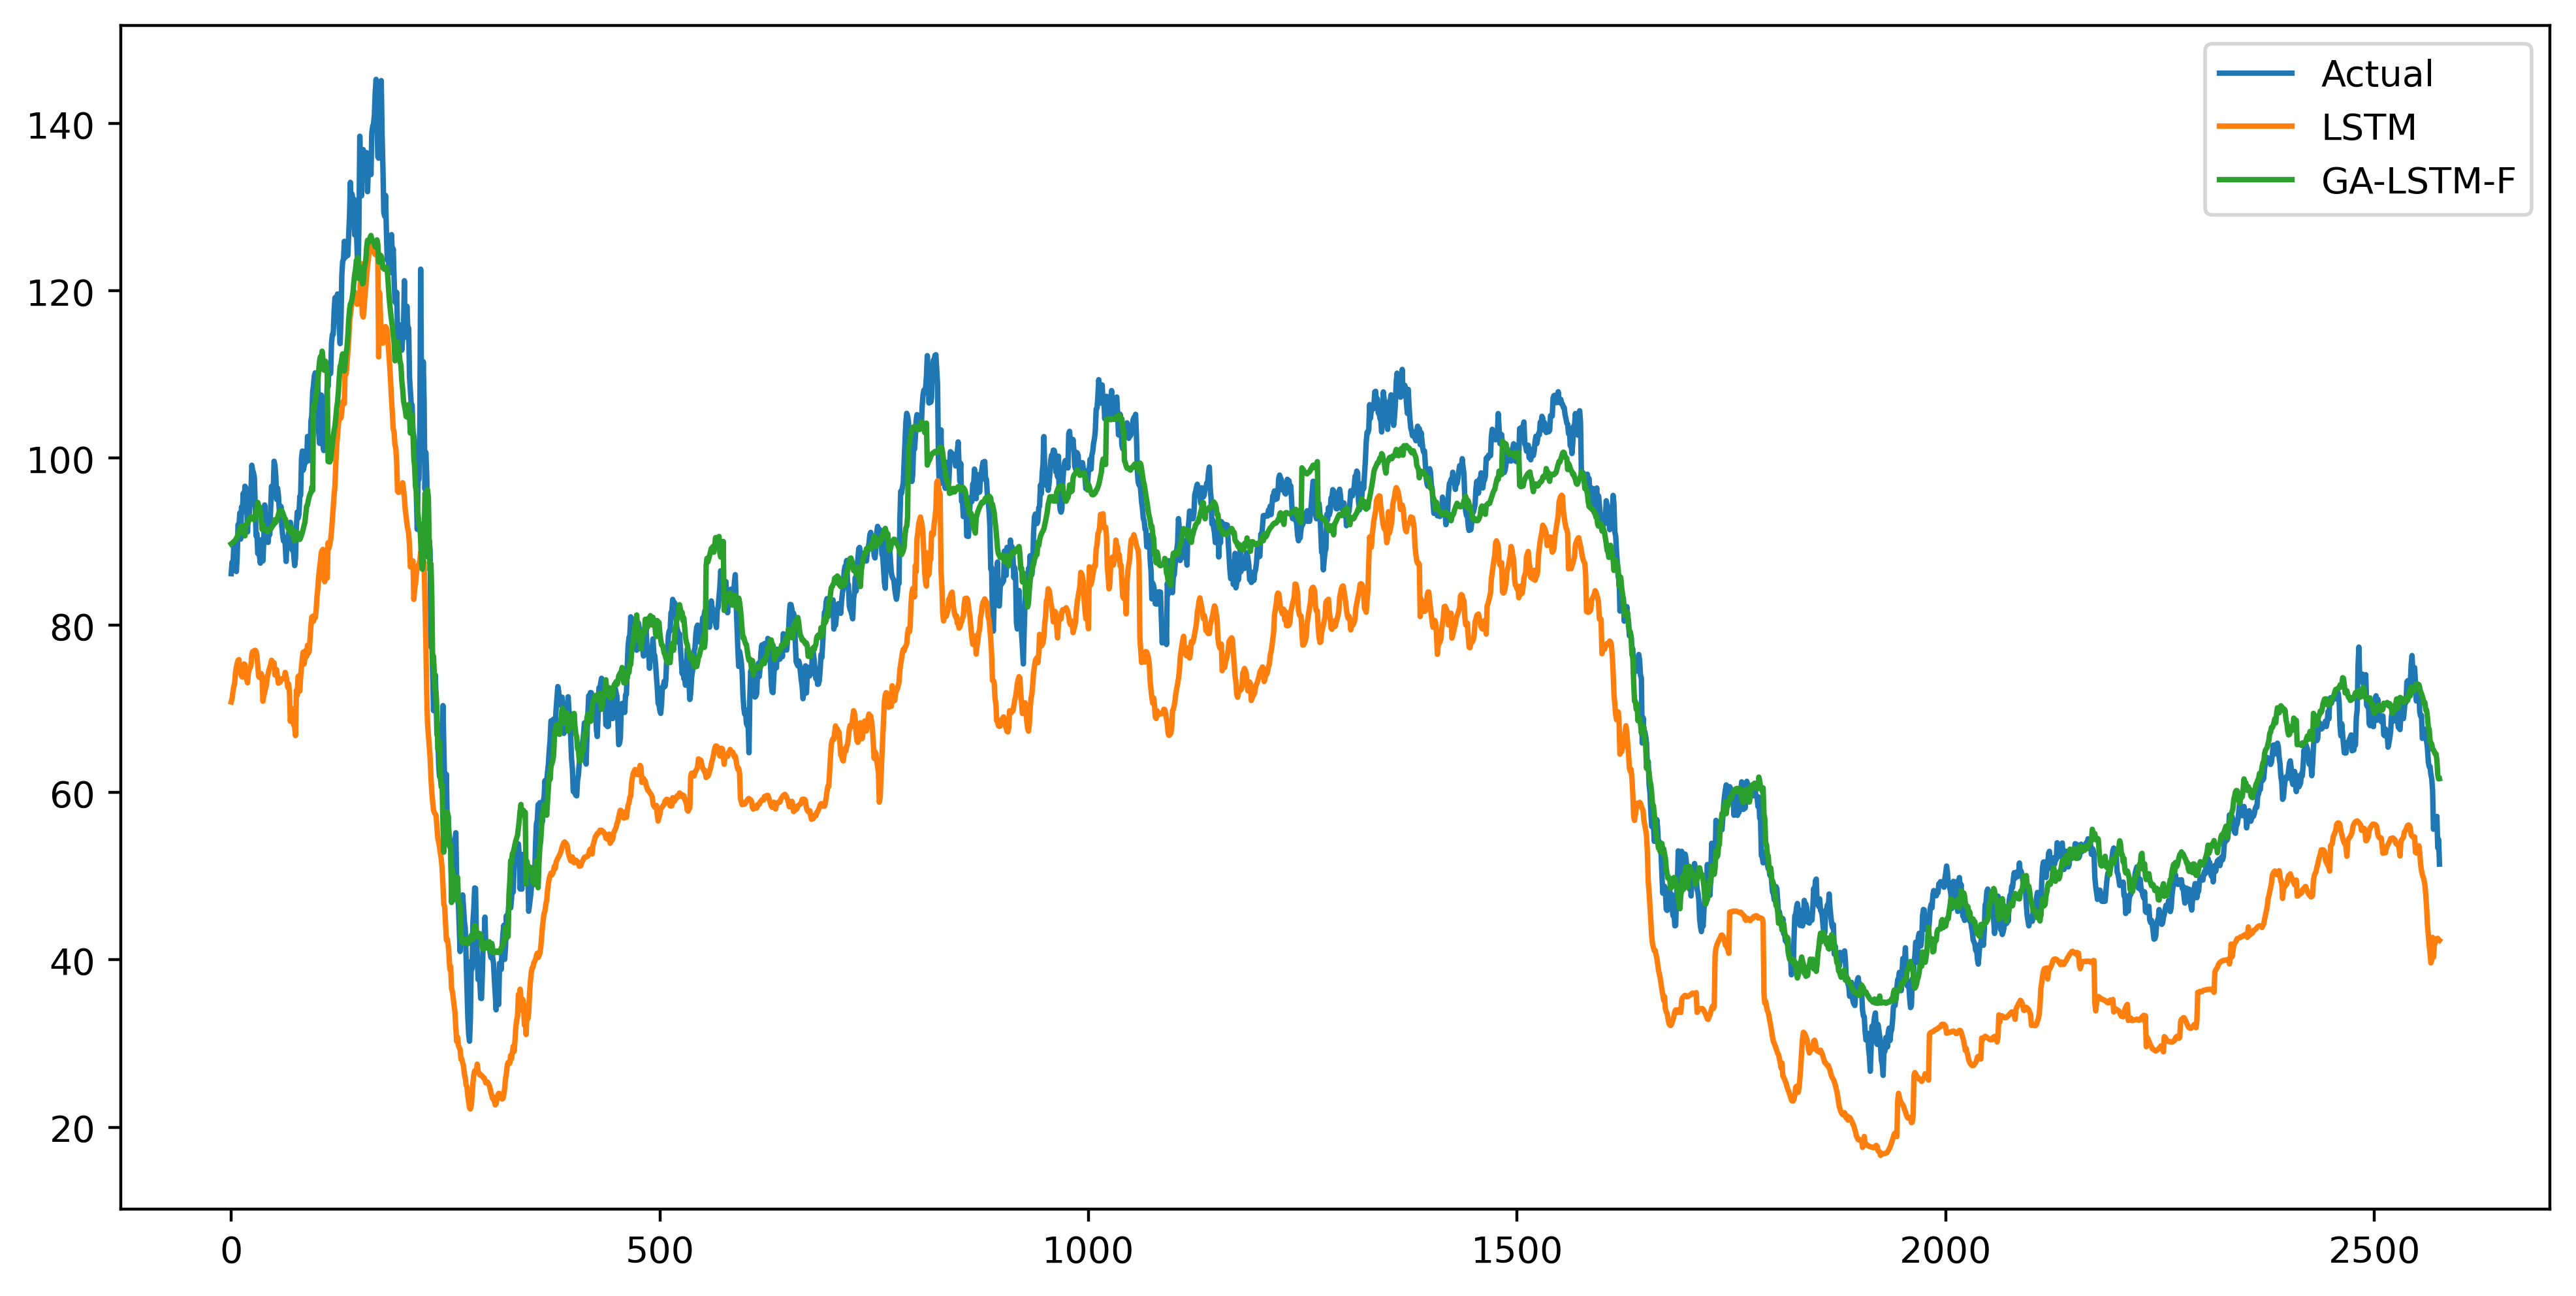

In [37]:
plt.figure(figsize = (12,6), dpi = 400)
plt.plot(y_train_ann, label = 'Actual')
#plt.plot(y_pred__train_ga_nn, label = 'GA-ANN-F')
#plt.plot(y_pred__train_ann, label = 'ANN')
plt.plot(y_pred__train_lstm, label = 'LSTM')
plt.plot(y_pred__train_ga_lstm_f, label = 'GA-LSTM-F')
plt.legend()

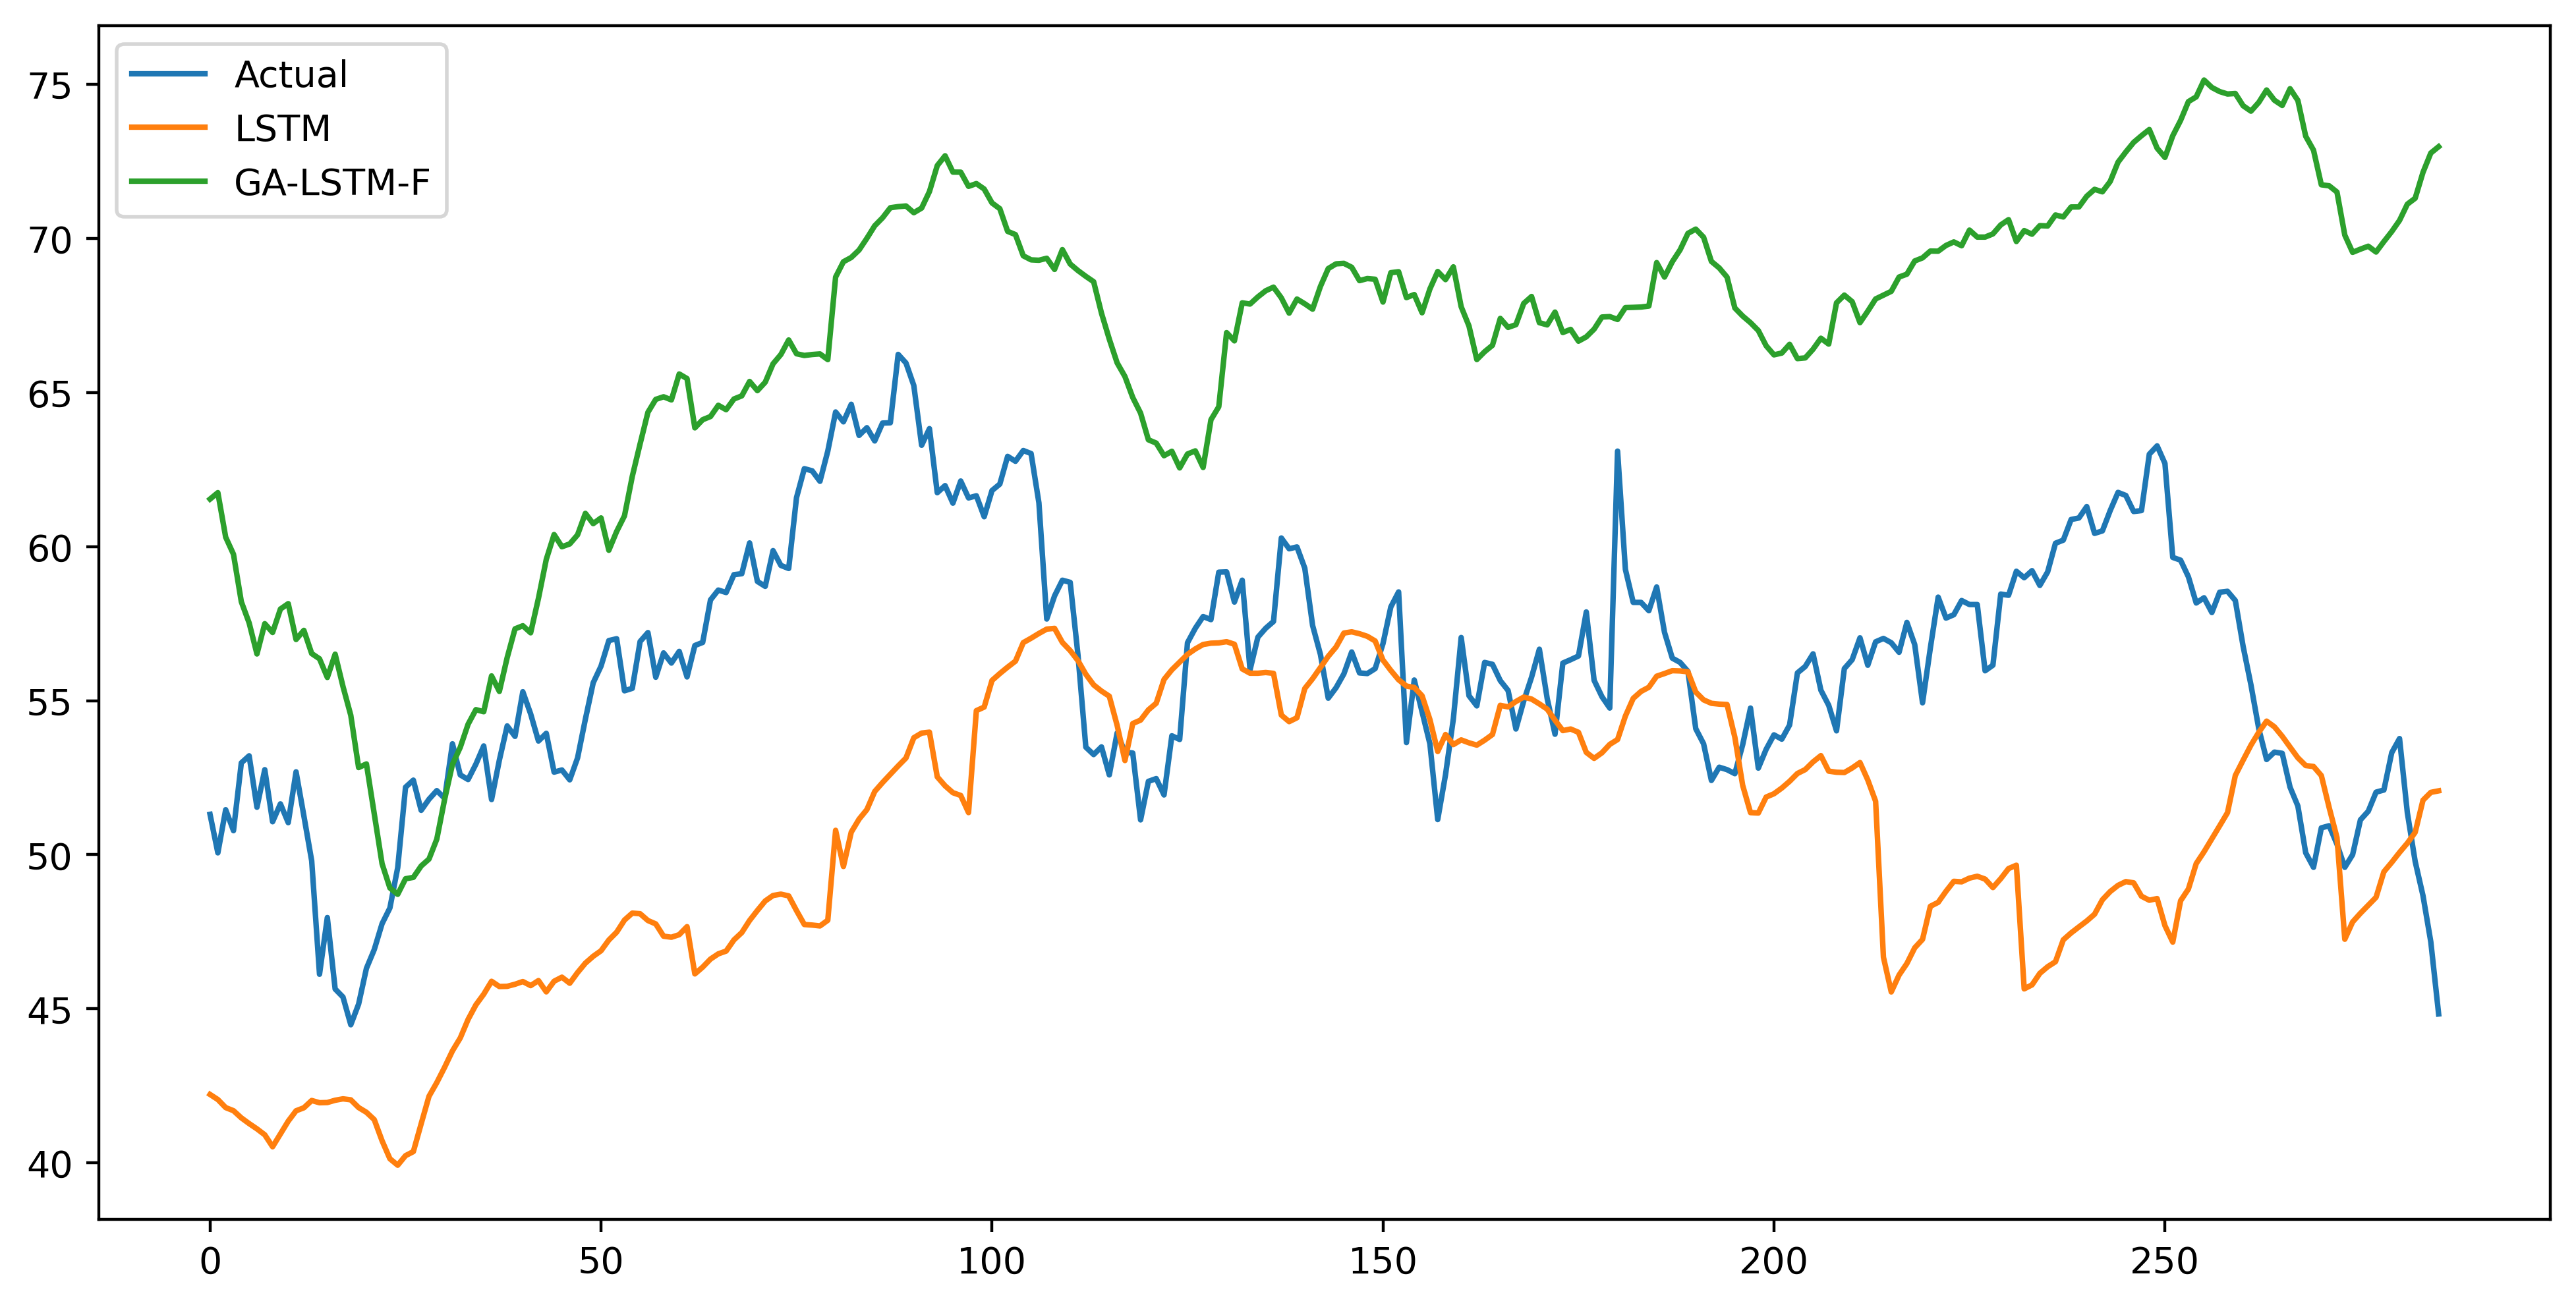

In [38]:
plt.figure(figsize = (12,6), dpi = 400)
plt.plot(y_test, label = 'Actual')
#plt.plot(y_pred__train_ga_nn, label = 'GA-ANN-F')
#plt.plot(y_pred__train_ann, label = 'ANN')
plt.plot(y_pred__test_lstm, label = 'LSTM')
plt.plot(y_pred__test_ga_lstm_f, label = 'GA-LSTM-F')
plt.legend()

In [39]:
arr_lstm_ga_f = list(y_pred__train_ga_lstm_f) + list(y_pred__test_ga_lstm_f)
arr_lstm = list(y_pred__train_lstm) + list(y_pred__test_lstm)


In [40]:
arr_lstm_ga_f1 = []
for x in arr_lstm_ga_f:
    arr_lstm_ga_f1.append(float(x))
    
arr_lstm1 = []
for x in arr_lstm:
    arr_lstm1.append(float(x))
    


In [48]:
temp = pd.read_csv('temp1.csv', index_col='Unnamed: 0')

In [49]:
temp['LSTM'] = arr_lstm1
temp['GA_LSTM_F'] = arr_lstm_ga_f1

In [52]:
temp

DATE  Actual        ANN   GA_ANN_F       LSTM  GA_LSTM_F
14    2007-10-08   86.19  37.727489  64.785660  70.849083  89.754662
15    2007-10-09   87.58  39.110336  64.490265  71.228577  89.821960
16    2007-10-10   87.19  38.735291  64.919067  72.074455  89.924789
17    2007-10-11   89.48  40.521767  66.621346  72.689896  90.033119
18    2007-10-12   88.58  42.567089  64.885735  73.109650  90.113106
...          ...     ...        ...        ...        ...        ...
2914  2020-02-13   51.36  25.968416  45.890278  50.374458  71.115837
2915  2020-02-14   49.78  26.022779  46.879910  50.724934  71.307602
2916  2020-02-18   48.67  26.122488  45.461826  51.769032  72.148445
2917  2020-02-19   47.17  27.231556  46.597939  52.022560  72.775902
2918  2020-02-20   44.83  28.258421  46.854820  52.072510  72.981224

[2863 rows x 6 columns]

In [54]:
#temp.to_csv('temp1.csv')

In [61]:
temp['DATE'] = pd.to_datetime(temp['DATE'])

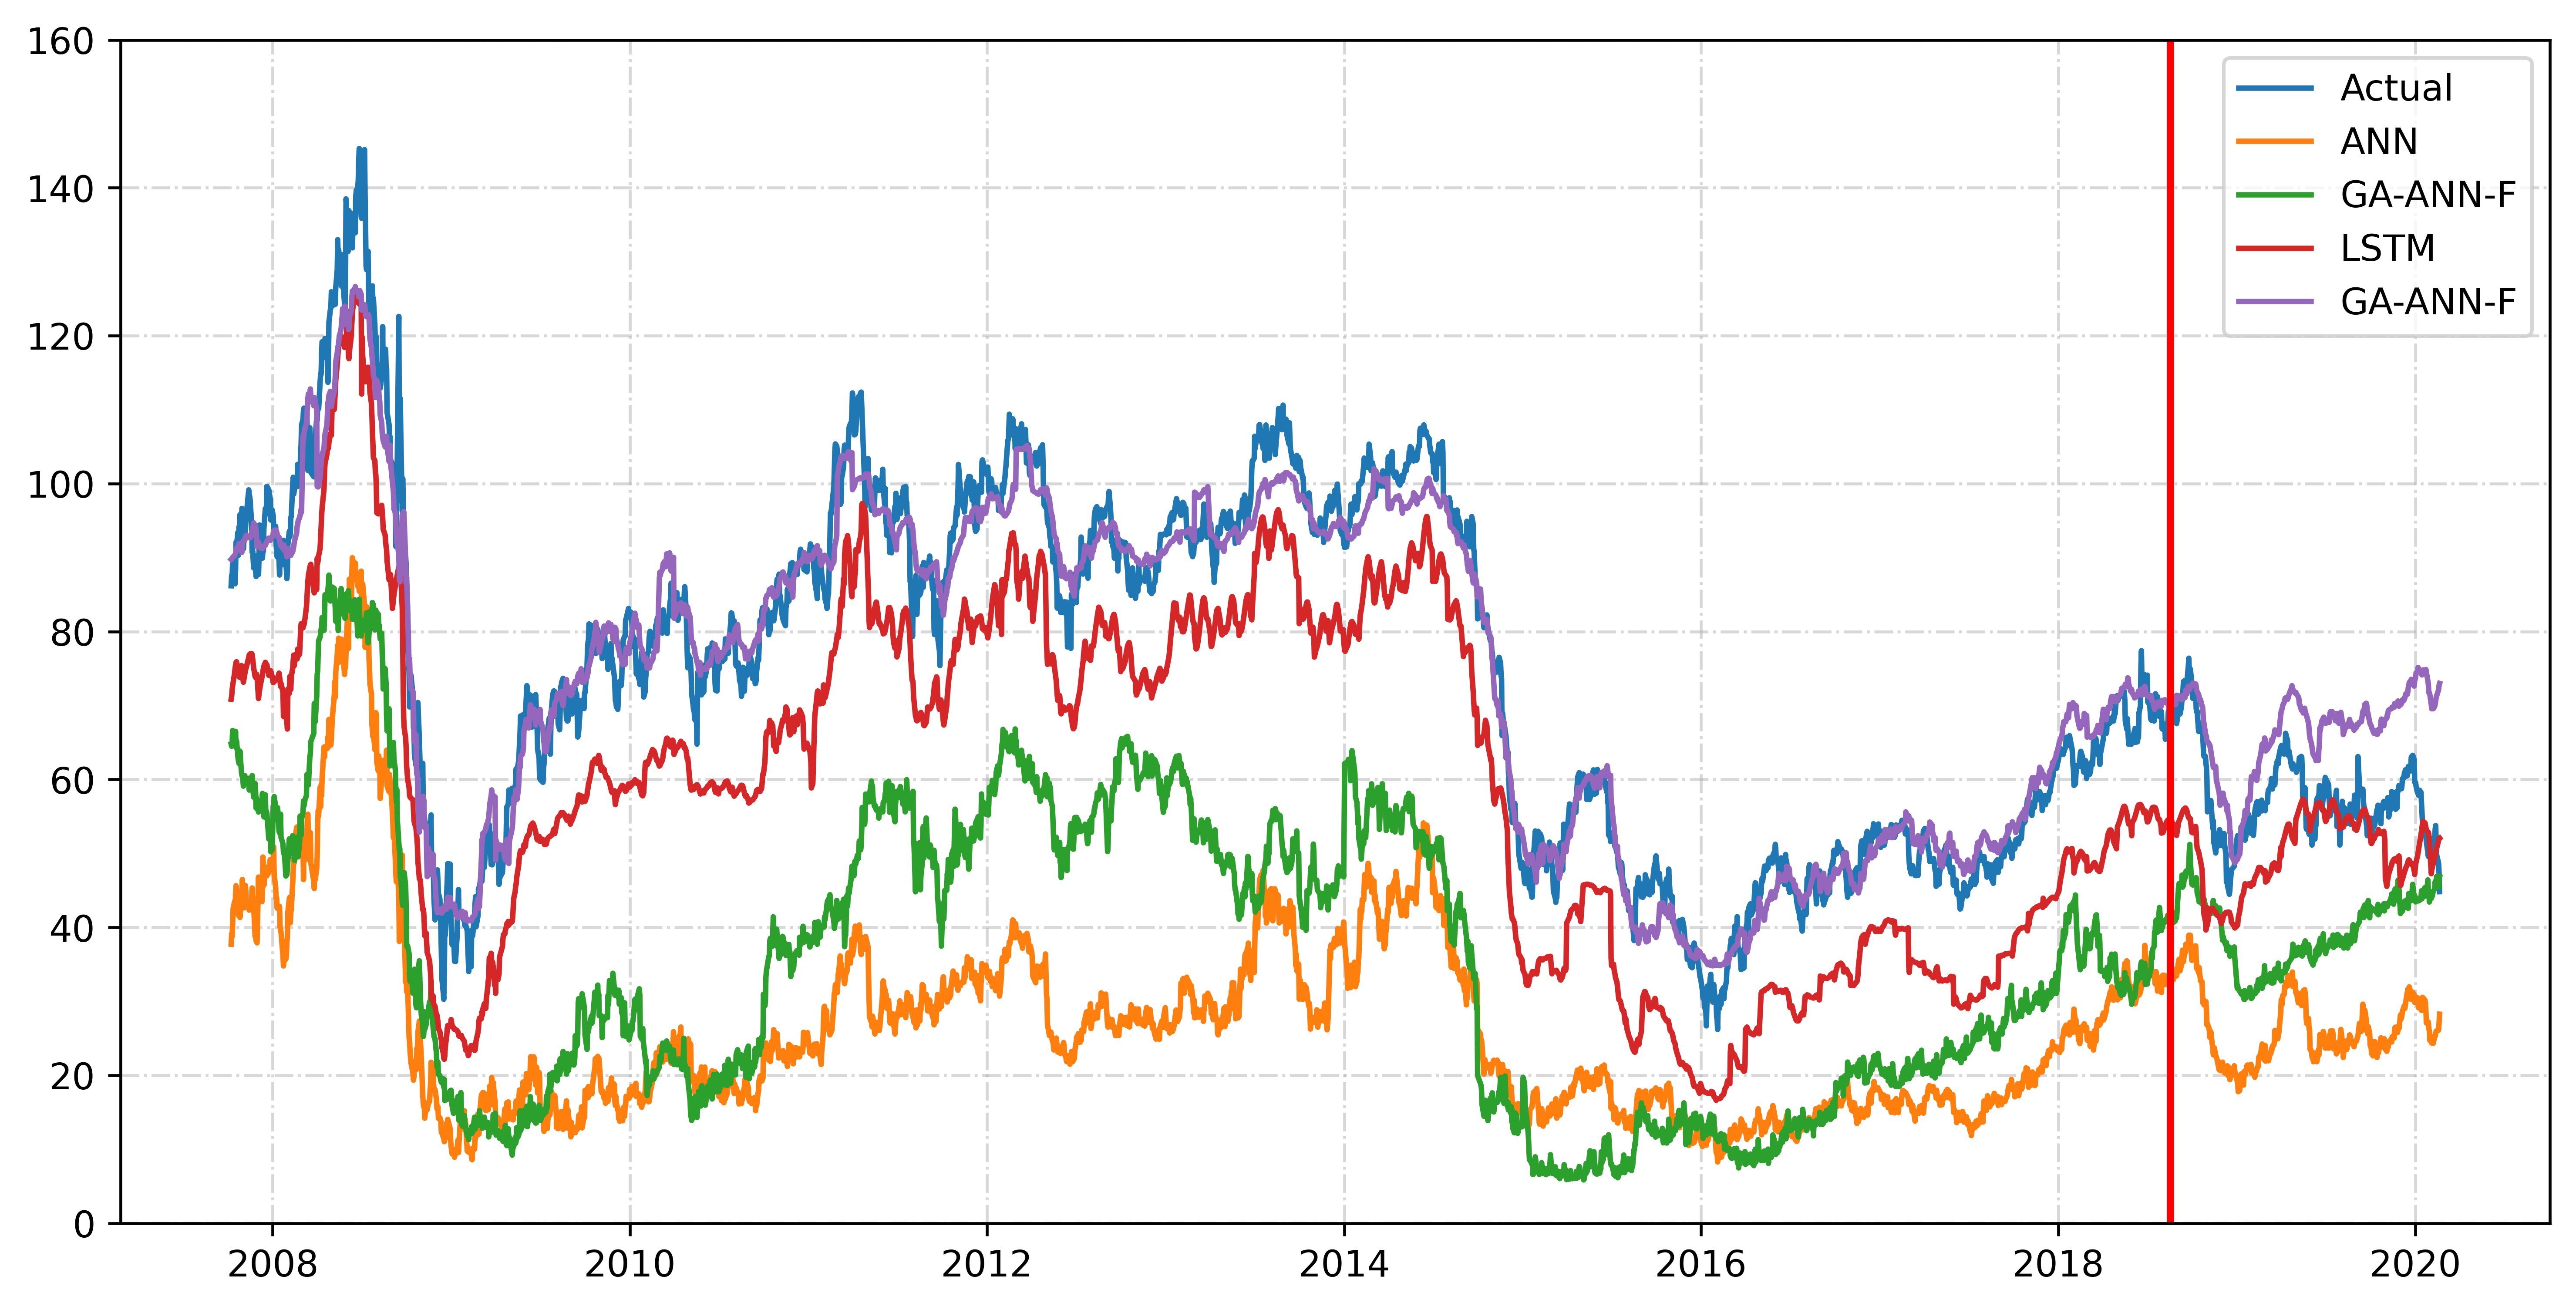

In [66]:
plt.figure(figsize = (12,6), dpi = 600)

plt.plot( temp['DATE'],temp['Actual'], label = 'Actual')
plt.plot( temp['DATE'],temp['ANN'], label = 'ANN')
plt.plot( temp['DATE'],temp['GA_ANN_F'], label = 'GA-ANN-F')
plt.plot( temp['DATE'],temp['LSTM'], label = 'LSTM')
plt.plot( temp['DATE'],temp['GA_LSTM_F'], label = 'GA-ANN-F')

plt.vlines(x = datetime(2018,8,18), ymin = 0, ymax= 240, color = 'red', linewidth = 2)
#plt.plot(predictions_ga_ann_test, label = 'ANN_GA',  marker = '*', alpha  =  0.5)
#plt.plot(predictions_ga_ann_test, label = 'LSTM_GA', alpha  =  0.5)
plt.legend()
plt.grid(linestyle = '-.', alpha = 0.5)
plt.ylim(0,160)
#plt.savefig('PlotFinal.jpg', dpi = 800)
plt.show()
